In [1]:
import torch
from torch import nn, optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

file_path_image_data = "task2b/single_label_image_dataset/image_data_dim60.txt"
file_path_image_labels = "task2b/single_label_image_dataset/image_data_labels.txt"

image_data = np.loadtxt(file_path_image_data)
labels = np.loadtxt(file_path_image_labels)

group_data = {1:0,2:1,3:2,5:3,6:4}
idx_to_labels = ["Forest","Highway","Inside","OpenCountry","Street"]

NUM_CLASSES = 5
MAX_EPOCHS = 50
INPUT_DIM  = image_data.shape[1]
image_data = image_data[np.in1d(labels, list(group_data.keys()))]
labels = labels[np.in1d(labels, list(group_data.keys()))]

print(image_data.shape)
print(labels.shape)

labels = np.vectorize(group_data.get)(labels)


(1598, 60)
(1598,)


In [3]:
class MLFFNN(nn.Module):
    """
    Class of Multi Layer Feed Forward Neural Network (MLFFNN)
    """
    def __init__(self, hidden_dim) :
        super(MLFFNN, self).__init__()
        torch.manual_seed(3)
        # adding linear and non-linear hidden layers
        self.mlffnn = nn.Sequential(nn.Linear(INPUT_DIM, hidden_dim),
                                       nn.Tanh(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.Tanh(),
                                       nn.Linear(hidden_dim, NUM_CLASSES))
        
    def forward(self, X):
        y = self.mlffnn(X)
        return y

hidden_dim = 48
BATCH_SIZE = 32
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(image_data,labels, train_size=0.7)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.67)

X_train, y_train, X_valid, X_test, y_valid, y_test = map(torch.tensor, [X_train, y_train, X_valid, X_test, y_valid, y_test])




In [4]:
accuracy_metrics = {
    'train': [],
    "val": []
}
loss_metrics = {
    'train': [],
    "val": []
}

In [5]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = acc * 100
    
    return acc

In [6]:
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_valid.unsqueeze(1), y_valid.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test.unsqueeze(1), y_test.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)


In [7]:

lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
criterion = nn.CrossEntropyLoss()

def train_model(optimizer,model,model_type="model_delta"):
    model.train()
    loss_metrics = {
    'train': [],
    "val": []
    }
    accuracy_metrics = {
    'train': [],
    "val": []
    }
    no_improvement=0
    best_loss = 100000
    for epoch in range(MAX_EPOCHS):
        train_loss = []
        correct_classified = 0
        for X_train, y_train in train_dataloader:
            X_train = X_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.long).to(device)

            optimizer.zero_grad()

            score = model(X_train)
            score = score.squeeze(dim=1)
            y_train = y_train.squeeze(dim=1)
            
            loss = criterion(input=score, target=y_train)
            loss.backward()
            train_loss.append(loss.item())
            max_indices = torch.argmax(score, dim=1)
            correct_classified +=  (max_indices == y_train).float().sum()

            optimizer.step()

        accuracy_metrics["train"].append(correct_classified.item() / len(train_dataloader.dataset))
        # Validation
        validation_loss = []
        correct_classified = 0

        with torch.no_grad():
            for X_valid, y_valid in val_dataloader:
                model.eval()
                X_valid = X_valid.type(torch.float32).to(device)
                y_valid = y_valid.type(torch.long).to(device)
                
                score = model(X_valid)
                score = score.squeeze(dim=1)
                
                y_valid = y_valid.squeeze(dim=1)
                loss = criterion(input=score, target=y_valid)
                validation_loss.append(loss.item())

                max_indices = torch.argmax(score, dim=1)
                correct_classified +=  (max_indices == y_valid).float().sum()
        
        accuracy_metrics["val"].append(correct_classified.item() / len(val_dataloader.dataset))
        
        loss_metrics["train"].append(np.average(train_loss))
        loss_metrics["val"].append(np.average(validation_loss))
    
        if np.average(validation_loss) < best_loss:
            best_loss = np.average(validation_loss)
            torch.save(model, f'{model_type}.pth')
            no_improvement=0
        else:
            no_improvement+=1
            if no_improvement==4:
                break

    
    return loss_metrics[:-no_improvement], accuracy_metrics[:-no_improvement],epoch-no_improvement


    


In [8]:
delta_loss = []
ada_delta_loss = []
adam_loss = []

In [14]:
def plot_comparative(loss_delta,loss_ada_delta,loss_adam,epochs,lr,is_type="train",loss_or_accuracy="loss"):
    plt.figure(figsize=(10,8),dpi=300)
    print(epochs[0],len(loss_delta[is_type]))
    plt.plot(range(epochs[0]+1),loss_delta[is_type],label="Delta")
    plt.plot(range(epochs[1]+1),loss_ada_delta[is_type],label="Adaptive Delta")
    plt.plot(range(epochs[2]+1),loss_adam[is_type],label="Adam")
    plt.legend()
    if is_type=="train":
        plt.title(f"Training {loss_or_accuracy} vs Number of epochs with Learning Rate: {lr}")
        plt.savefig(f"figs/training_loss_{lr}.png")
    else:
        plt.title(f"Validation {loss_or_accuracy} vs Number of epochs with Learning Rate: {lr}")
        plt.savefig(f"figs/validation_{loss_or_accuracy}_{lr}.png")

In [20]:
def plot_confusion_matrix(lr,model_type,dataloader):
    model = torch.load(f'{model_type}')
    model.eval()
    with torch.no_grad():
        confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
        for X_test, y_test in dataloader:
            X_test = X_test.type(torch.float32).to(device)
            y_test = y_test.type(torch.long).to(device)
            score = model(X_test)
            score = score.squeeze(dim=1)
            y_test = y_test.squeeze(dim=1)
            max_indices = torch.argmax(score, dim=1)
            for t, p in zip(y_test.cpu(), max_indices.cpu()):
                confusion_matrix[t.long(), p.long()] += 1
        plt.figure(figsize=(10,8),dpi=300)
        sns.heatmap(confusion_matrix.numpy(), annot=True, xticklabels=idx_to_labels, yticklabels=idx_to_labels)  
        plt.title(f"Confusion Matrix with Learning Rate: {lr}")
        plt.savefig(f"figs/confusion_matrix_{lr}.png")

3 4
3 4
3 4
3 4
49 50
49 50
49 50
49 50


/tmp/ipykernel_38981/3481146010.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8),dpi=300)


49 50
49 50
49 50
49 50
20 21
20 21
20 21
20 21


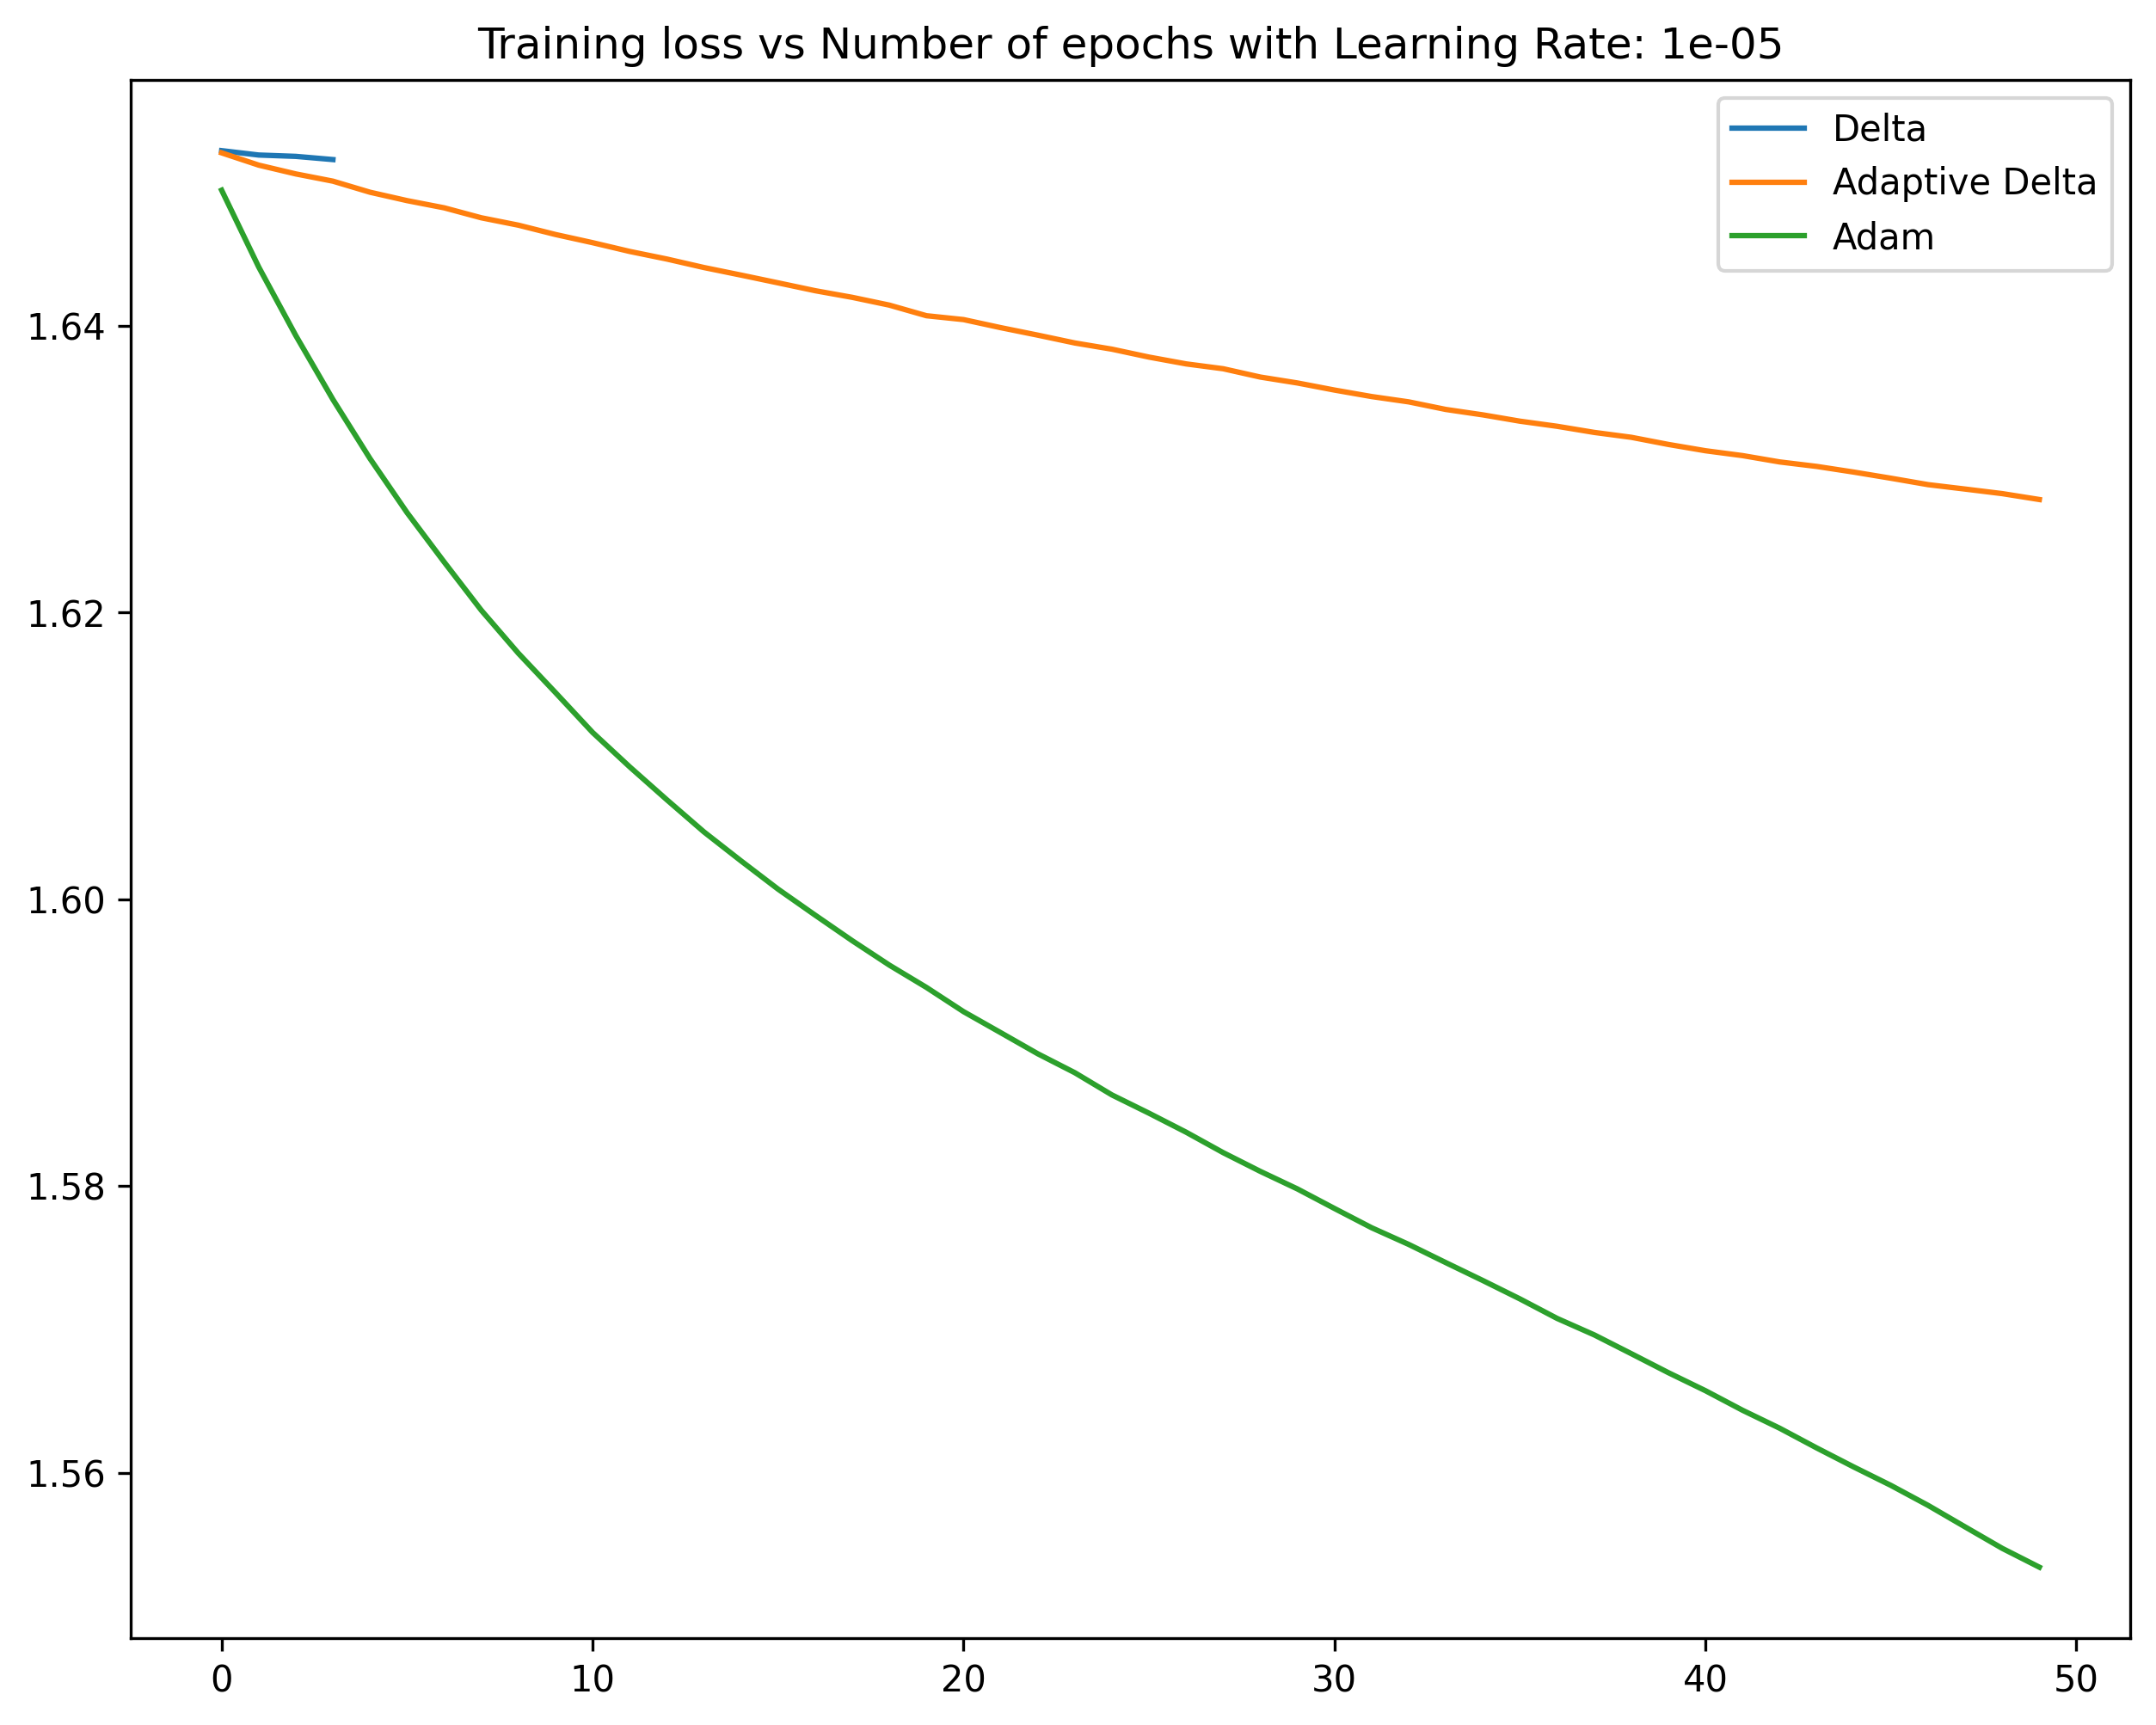

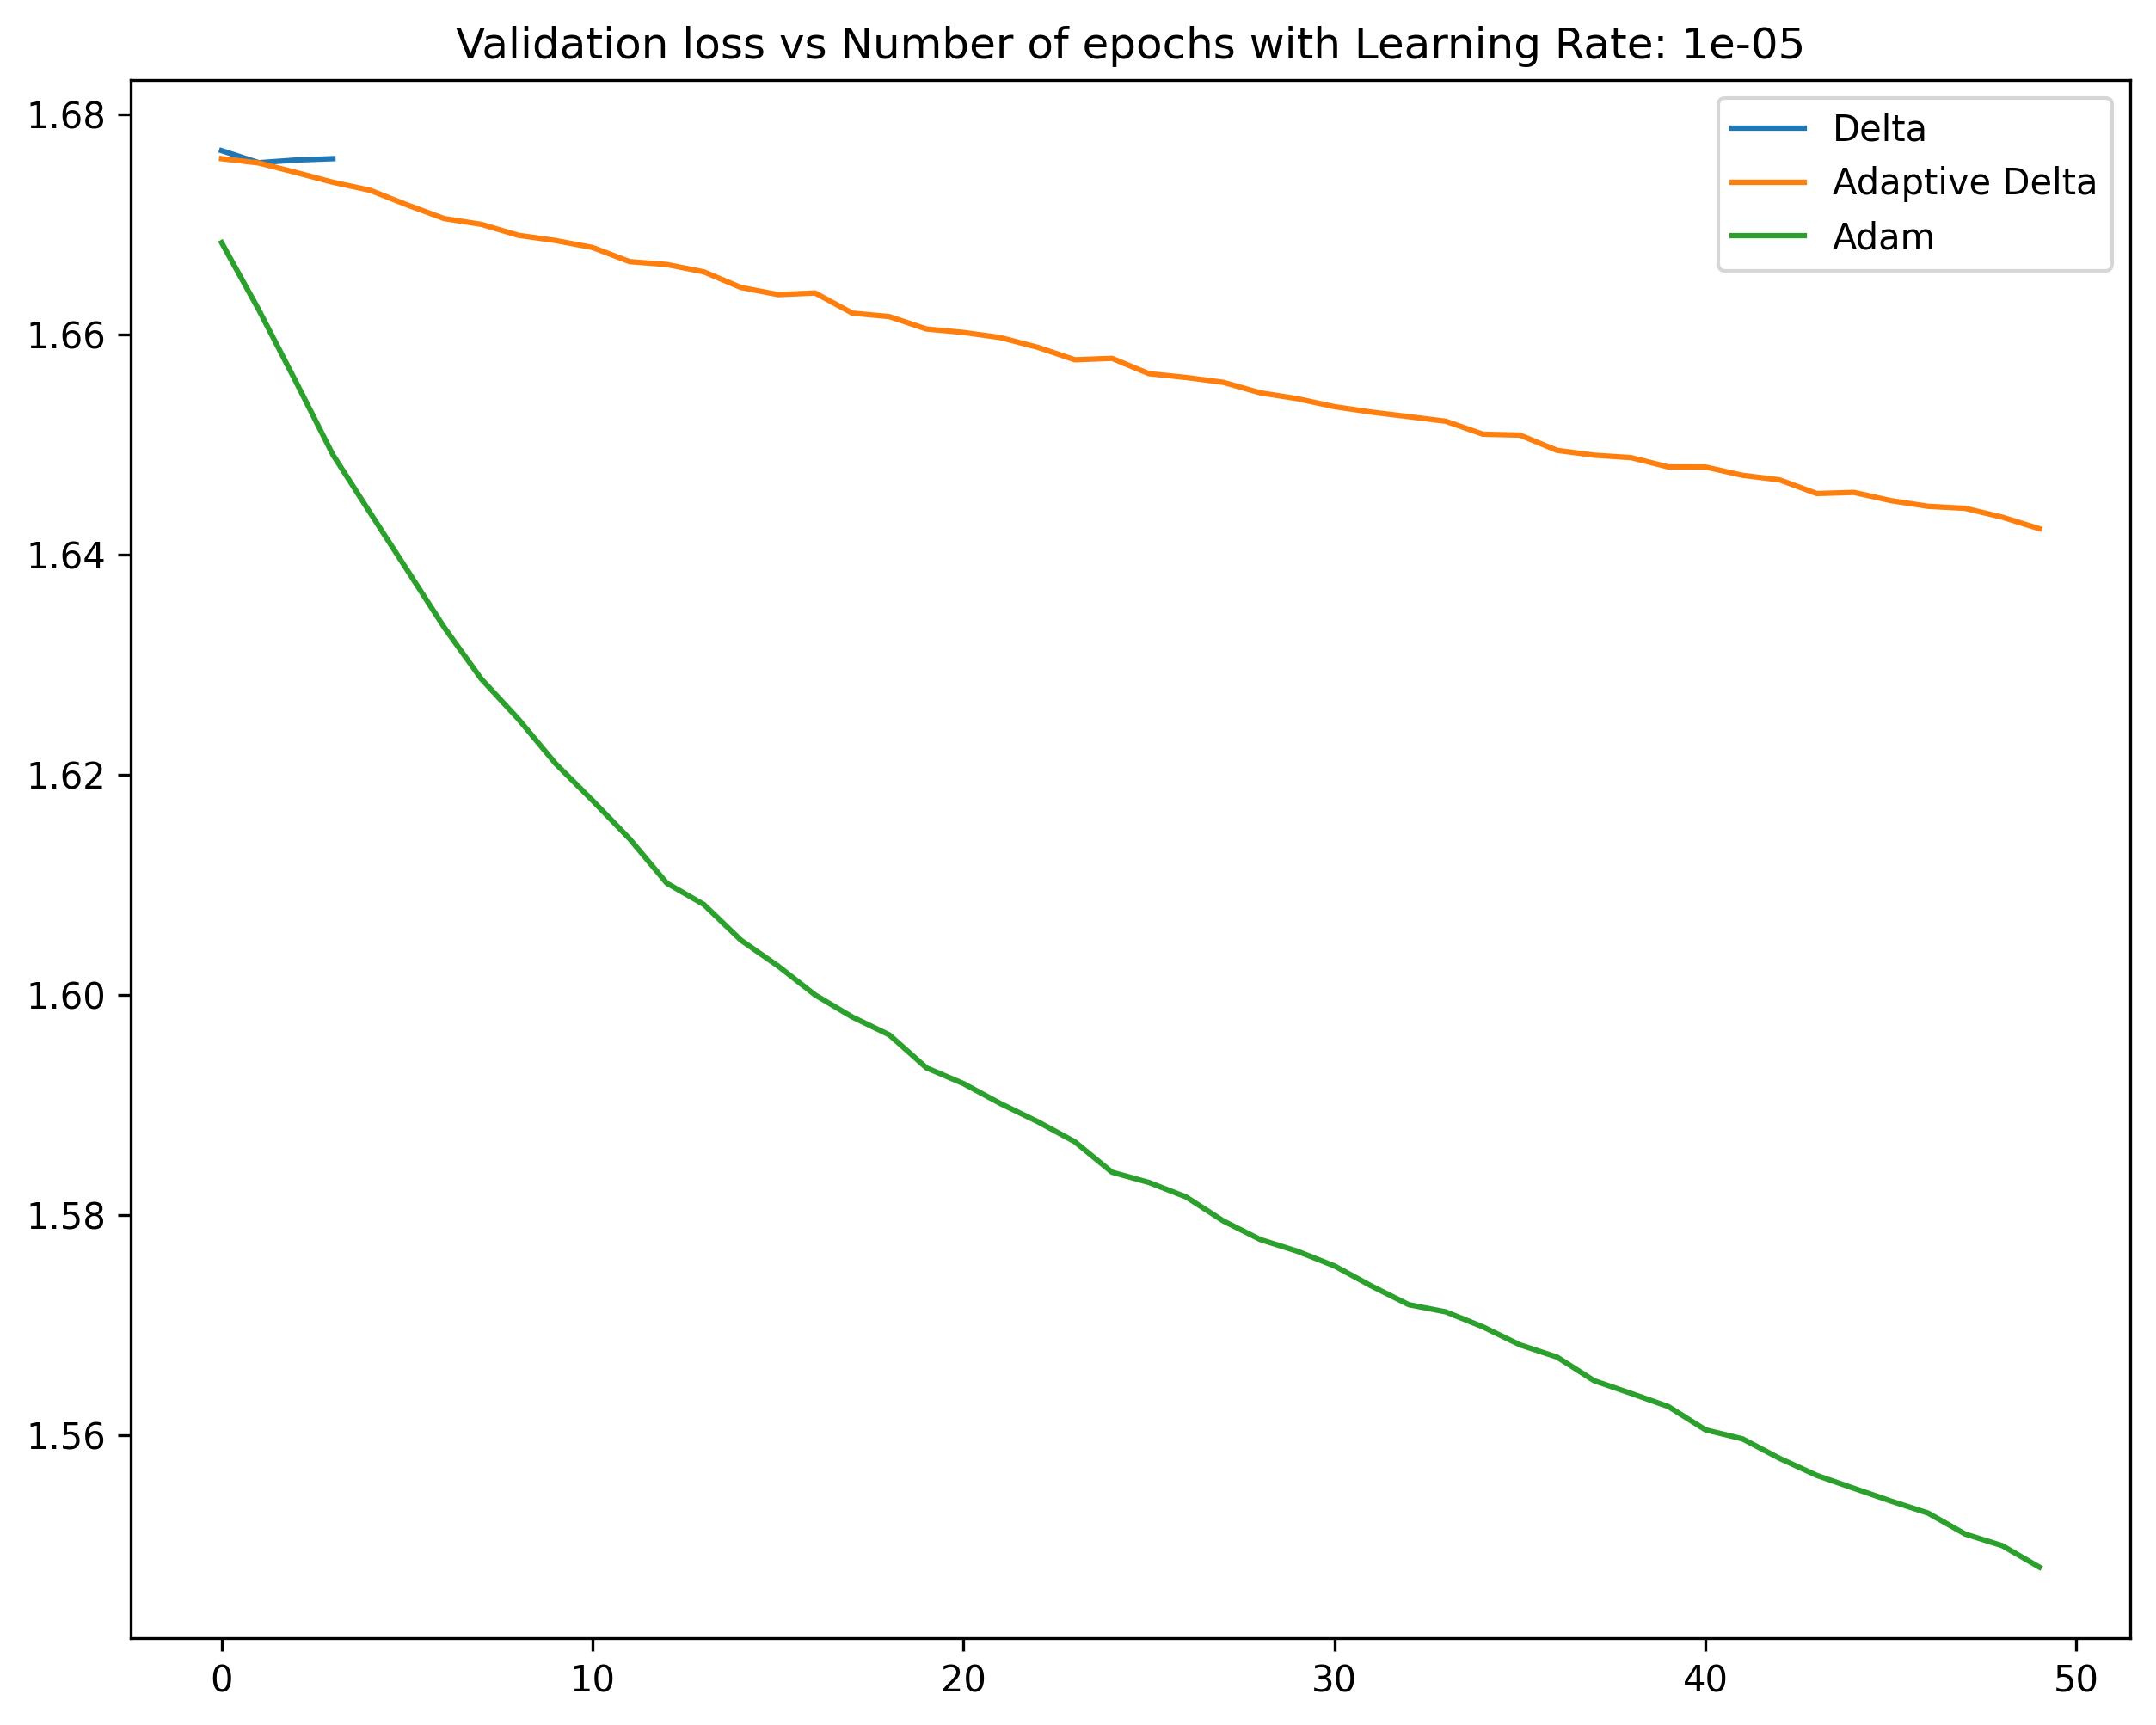

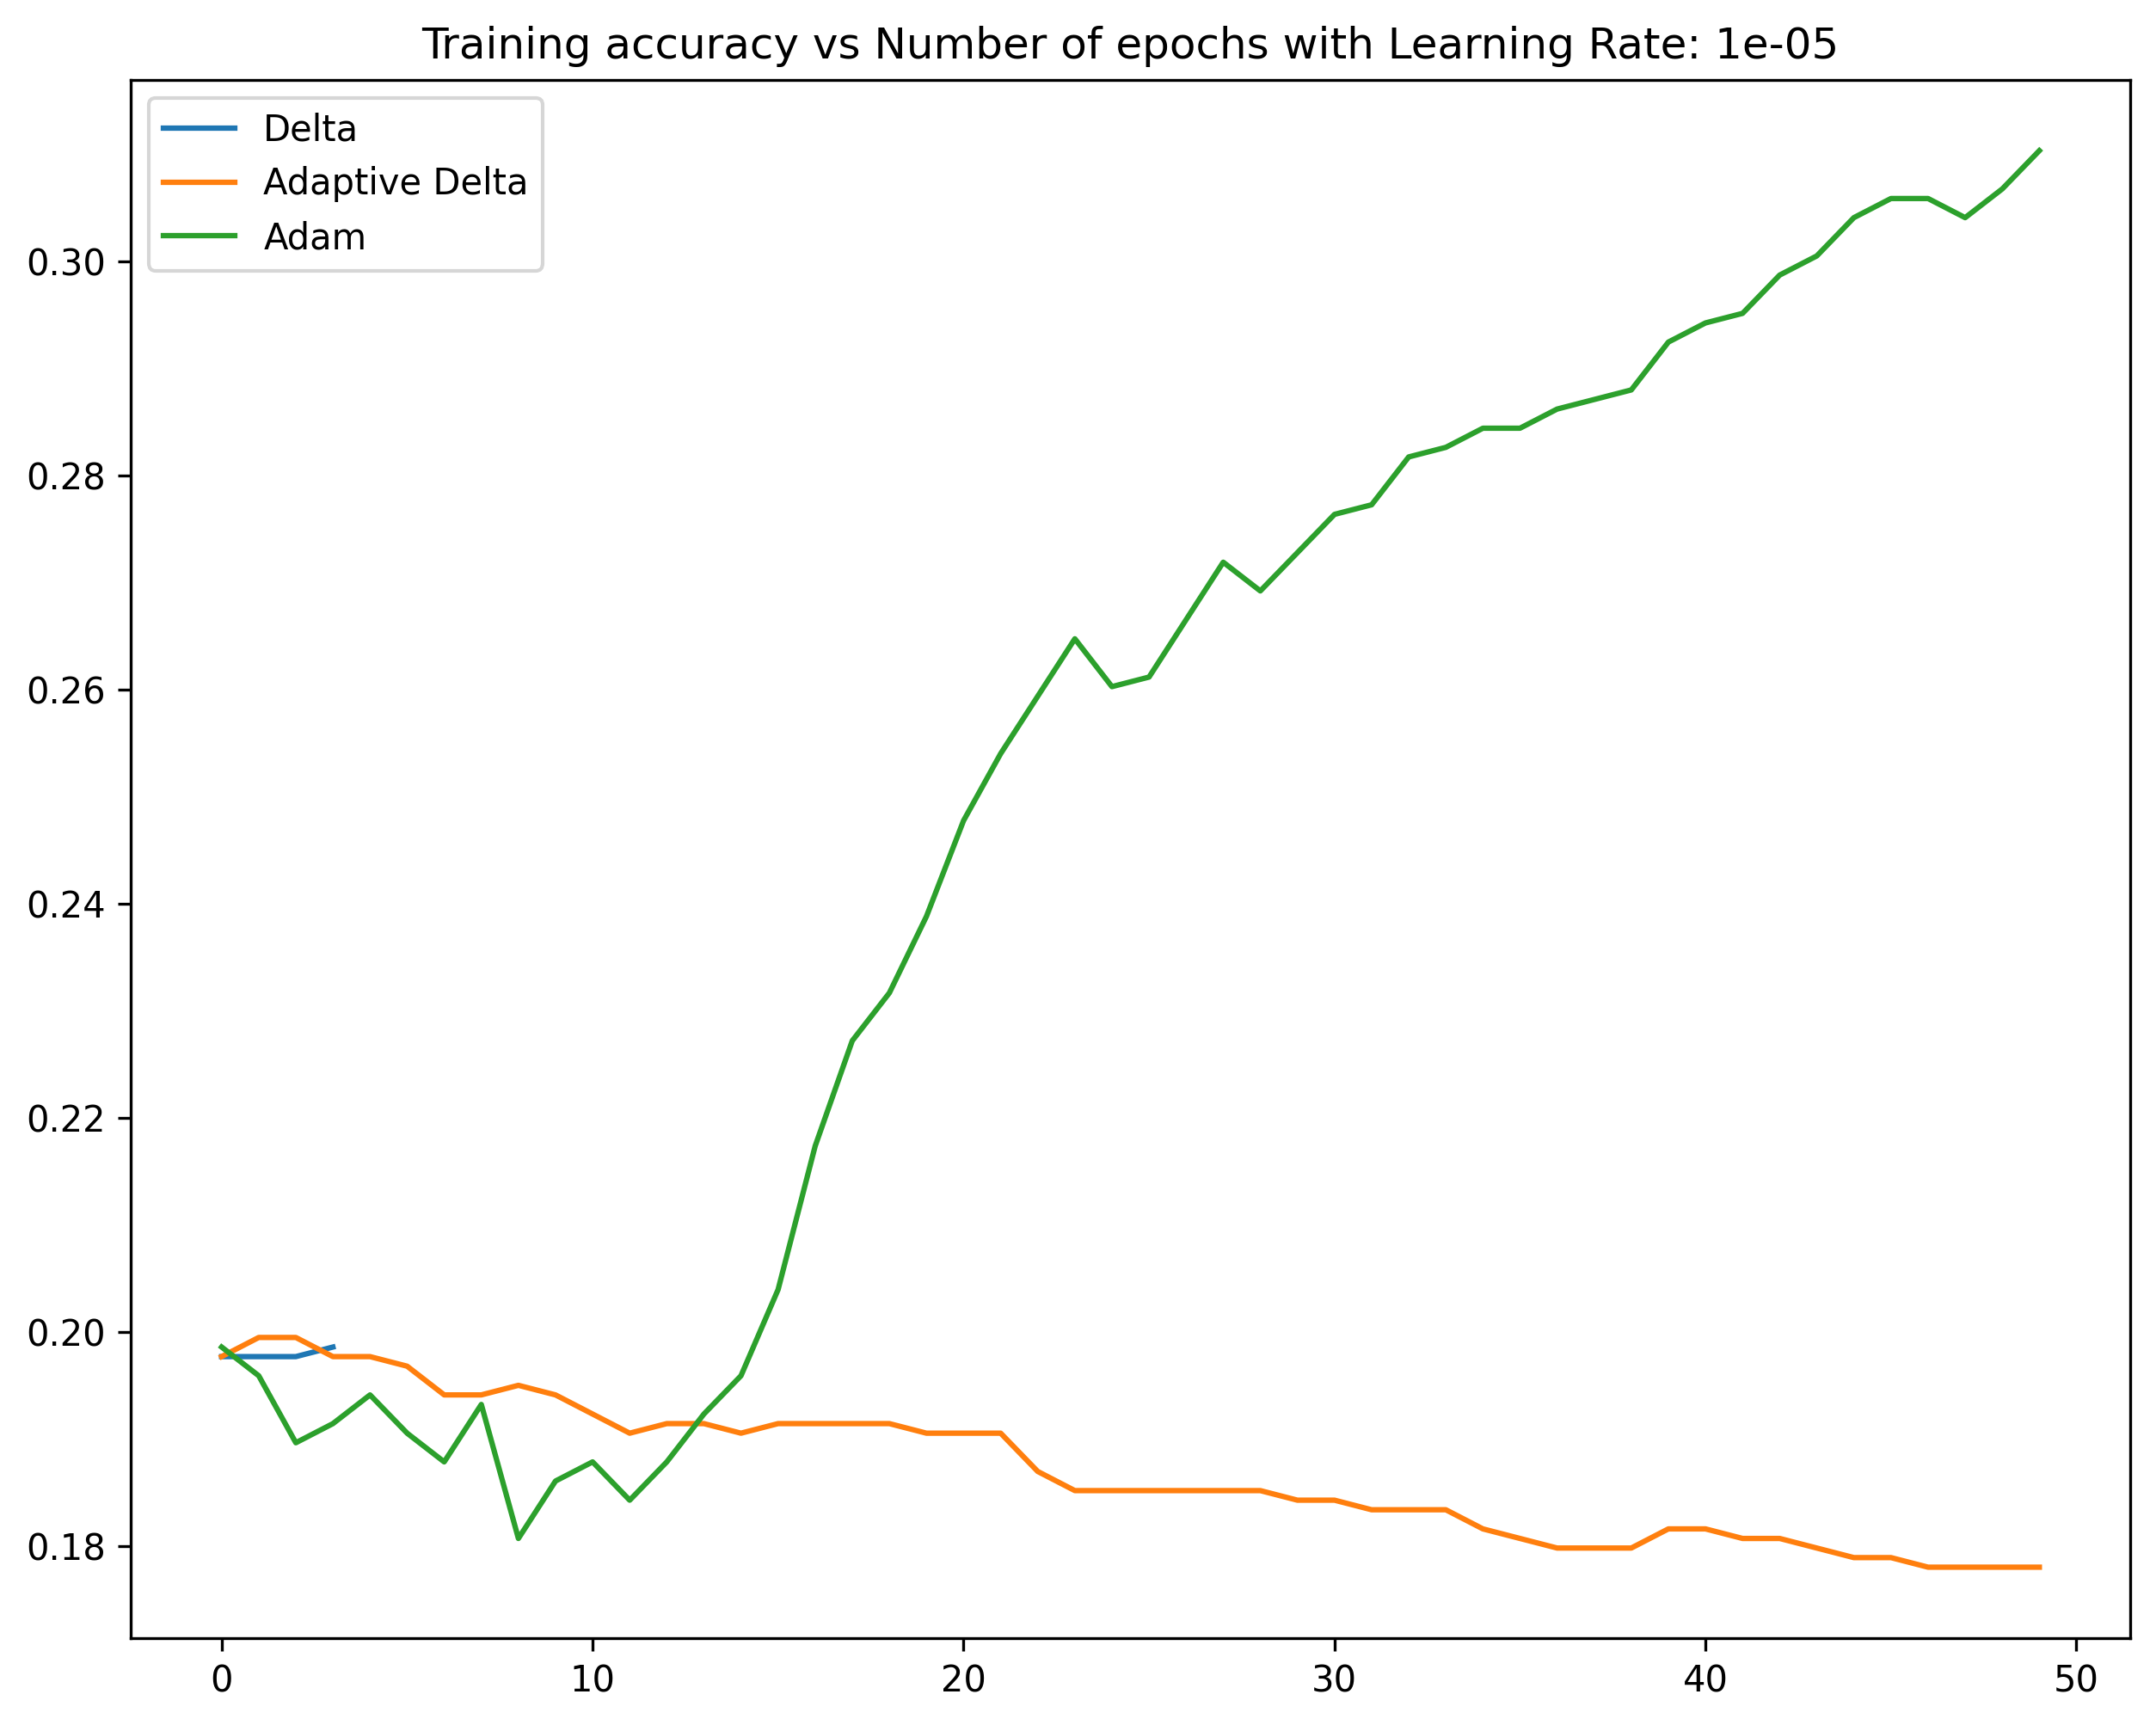

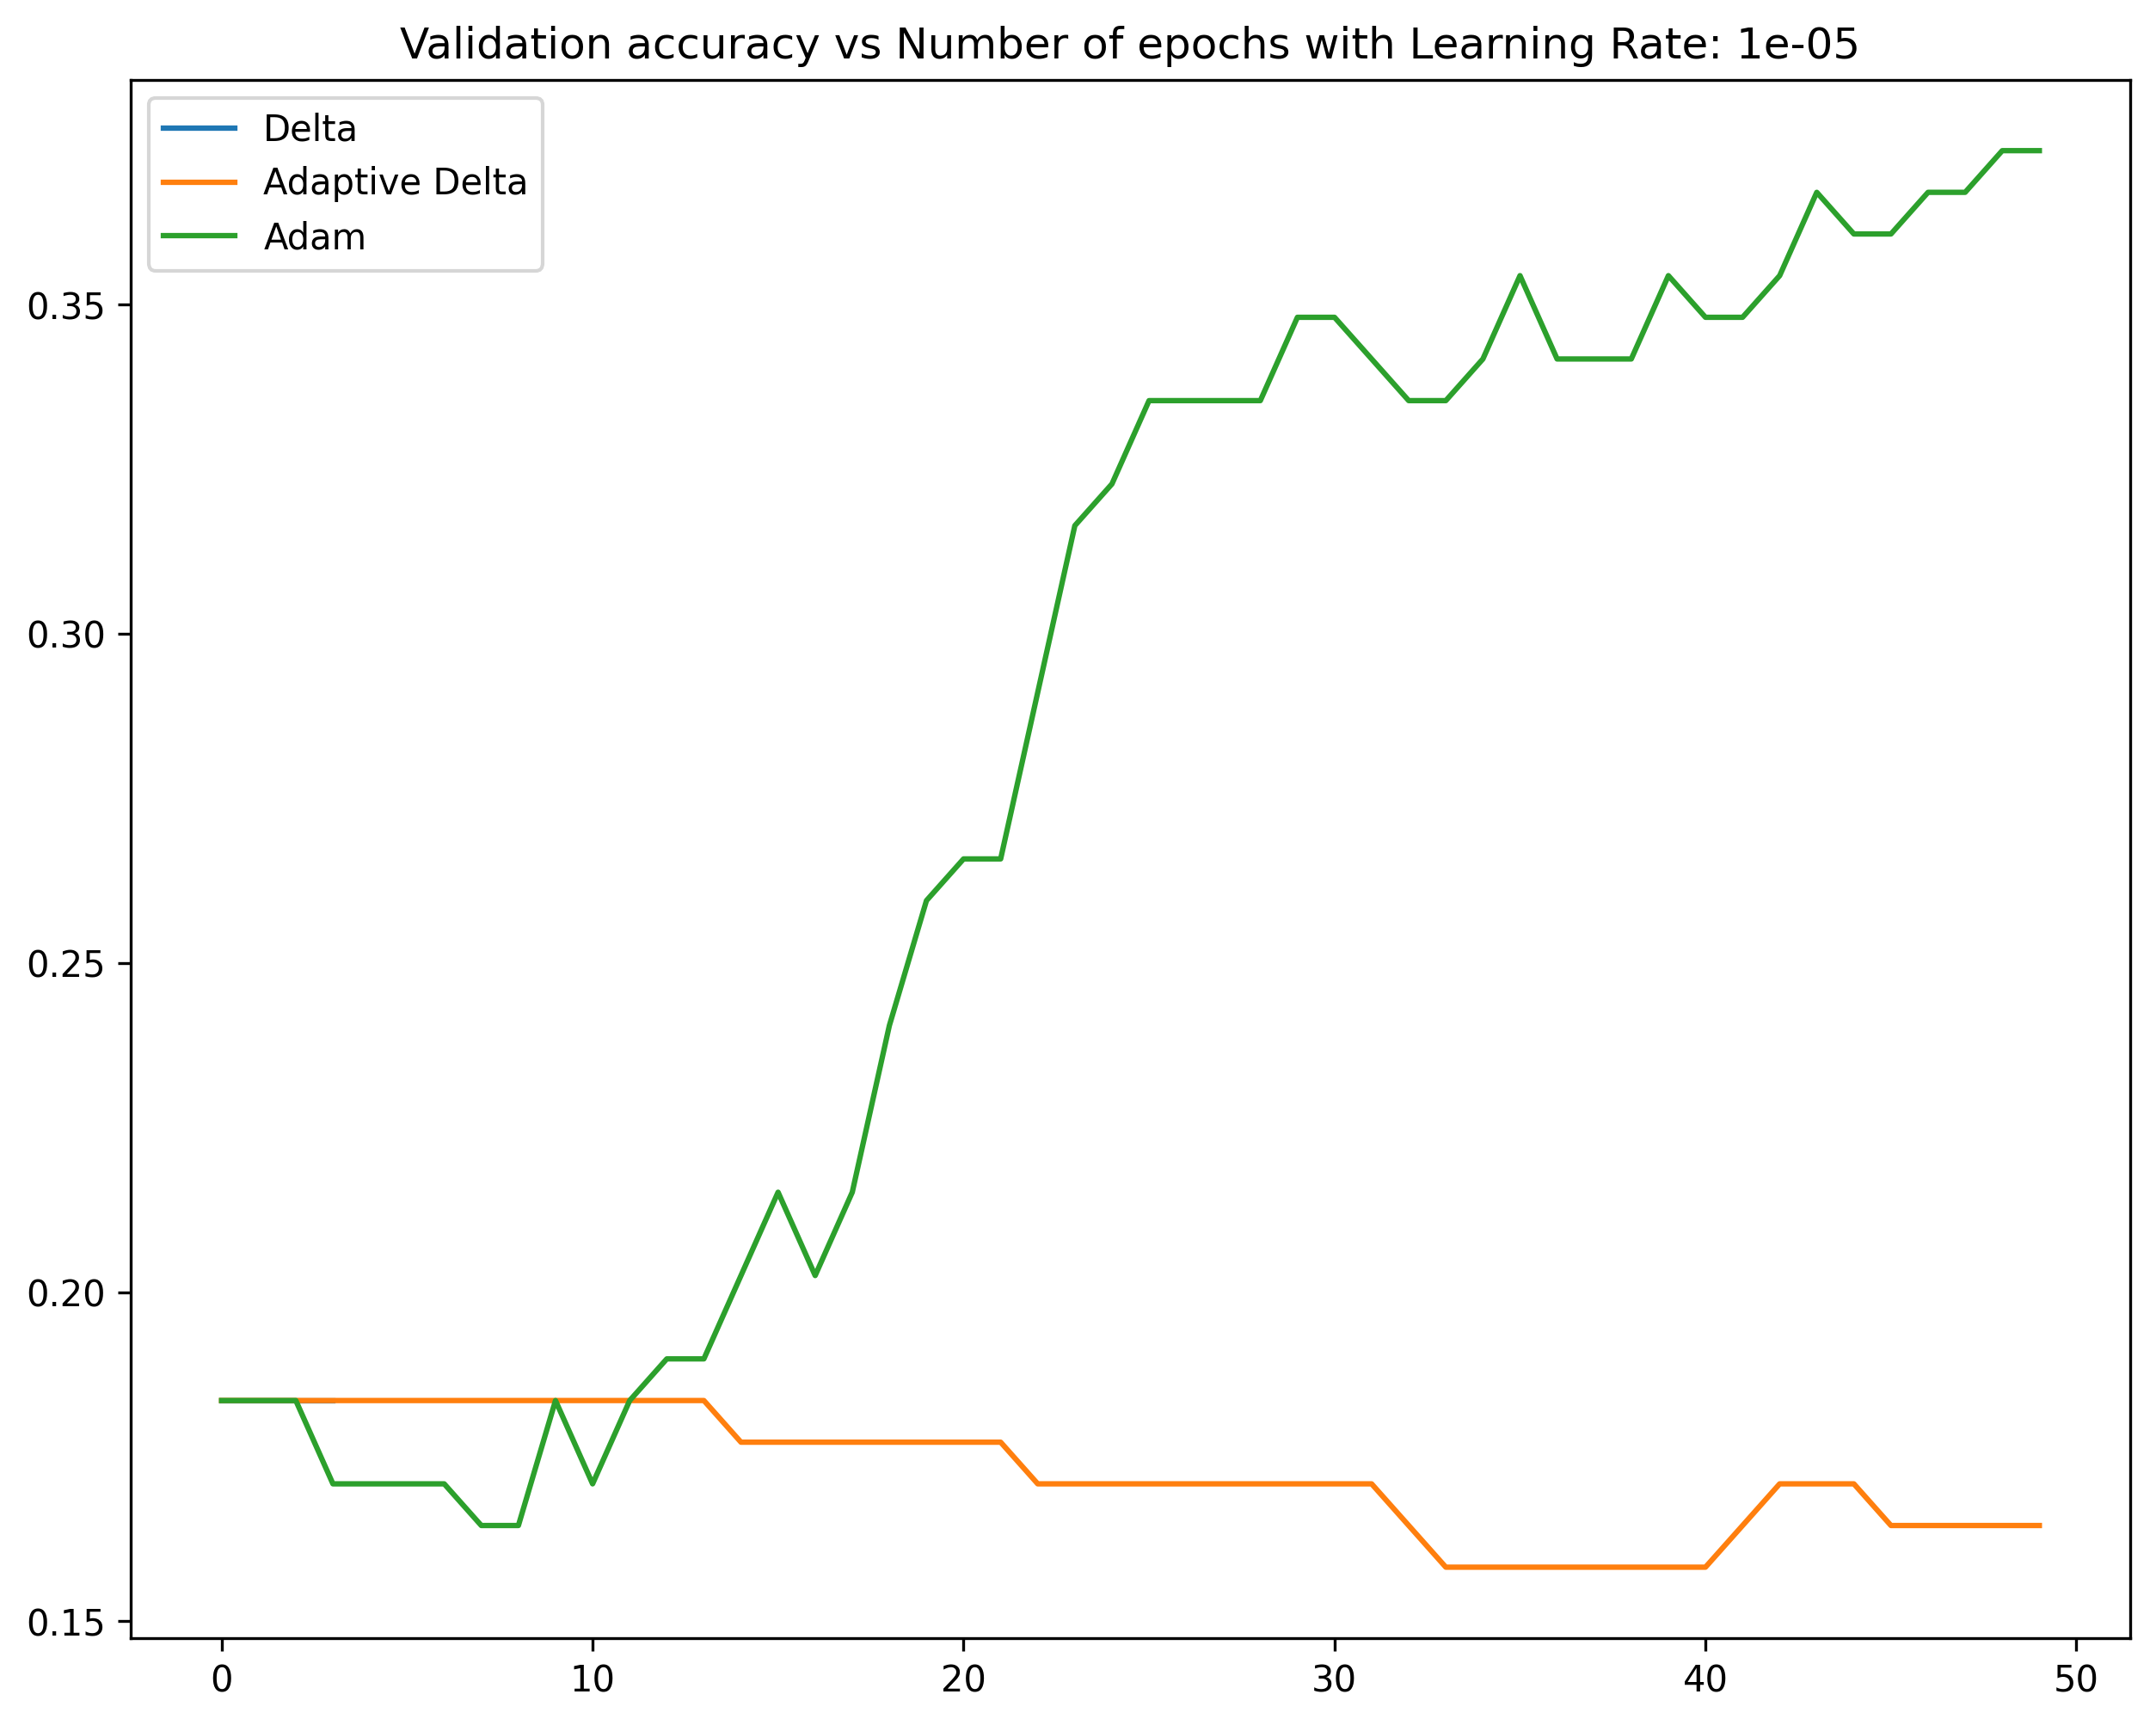

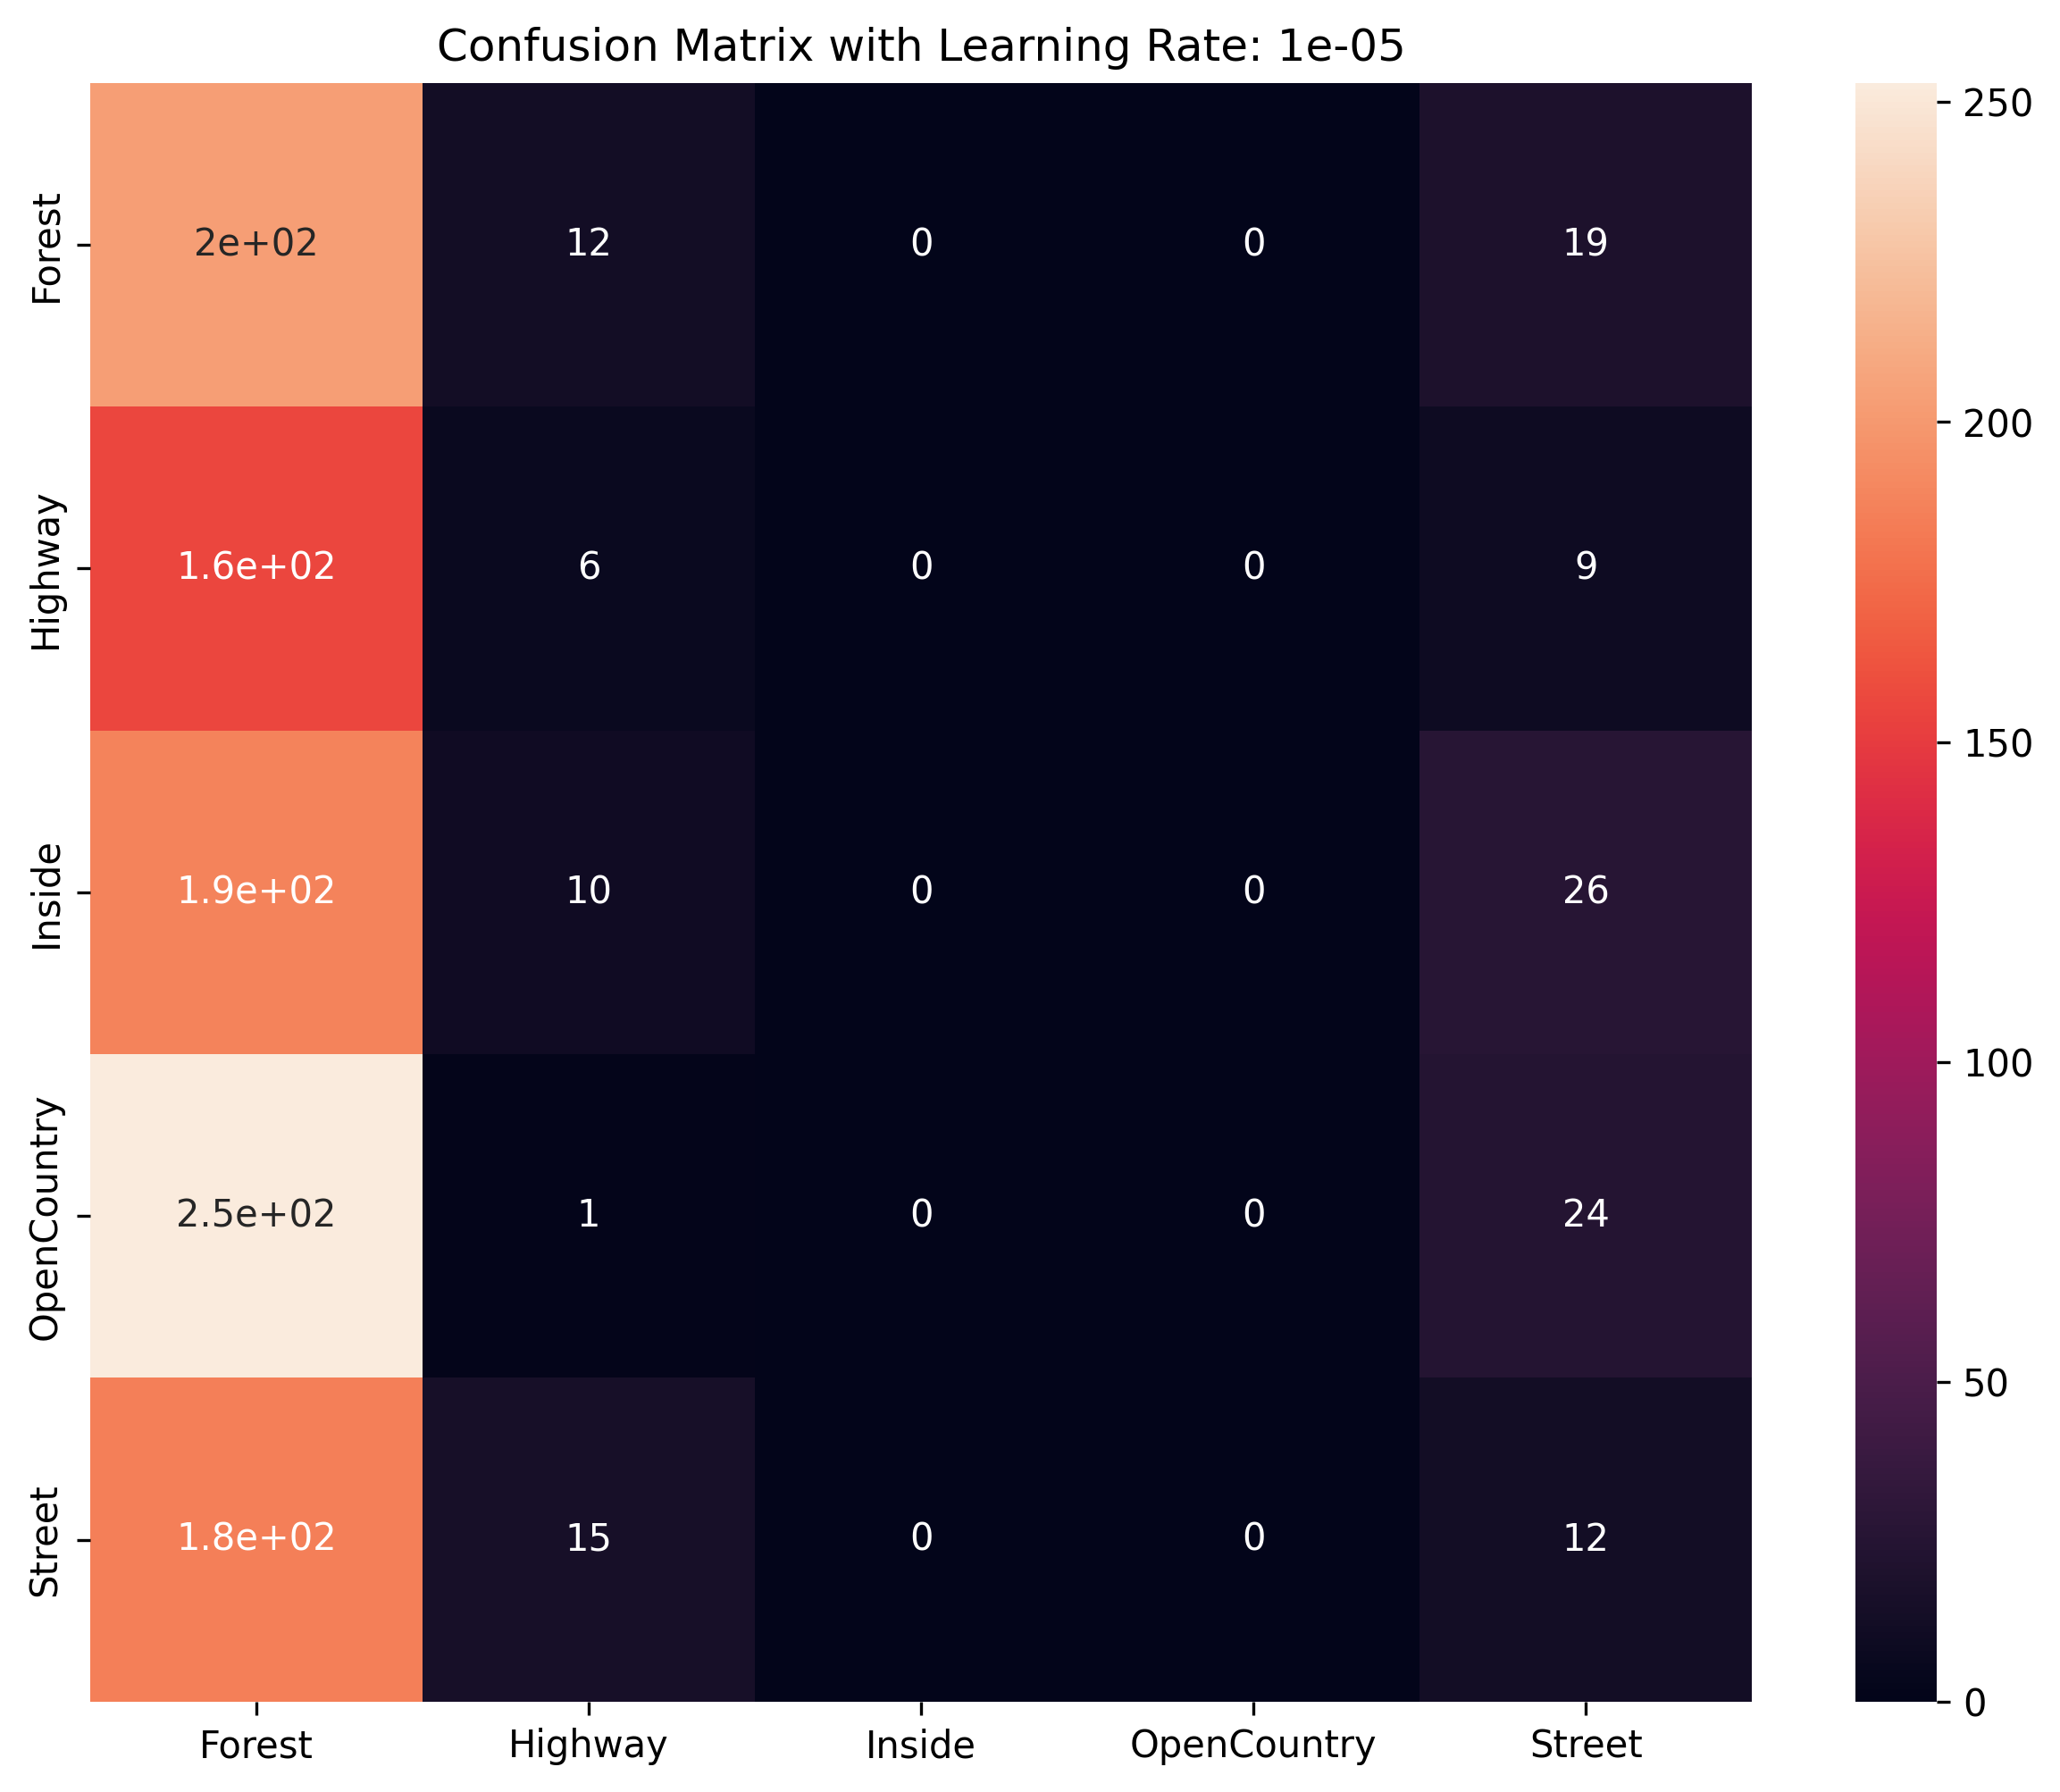

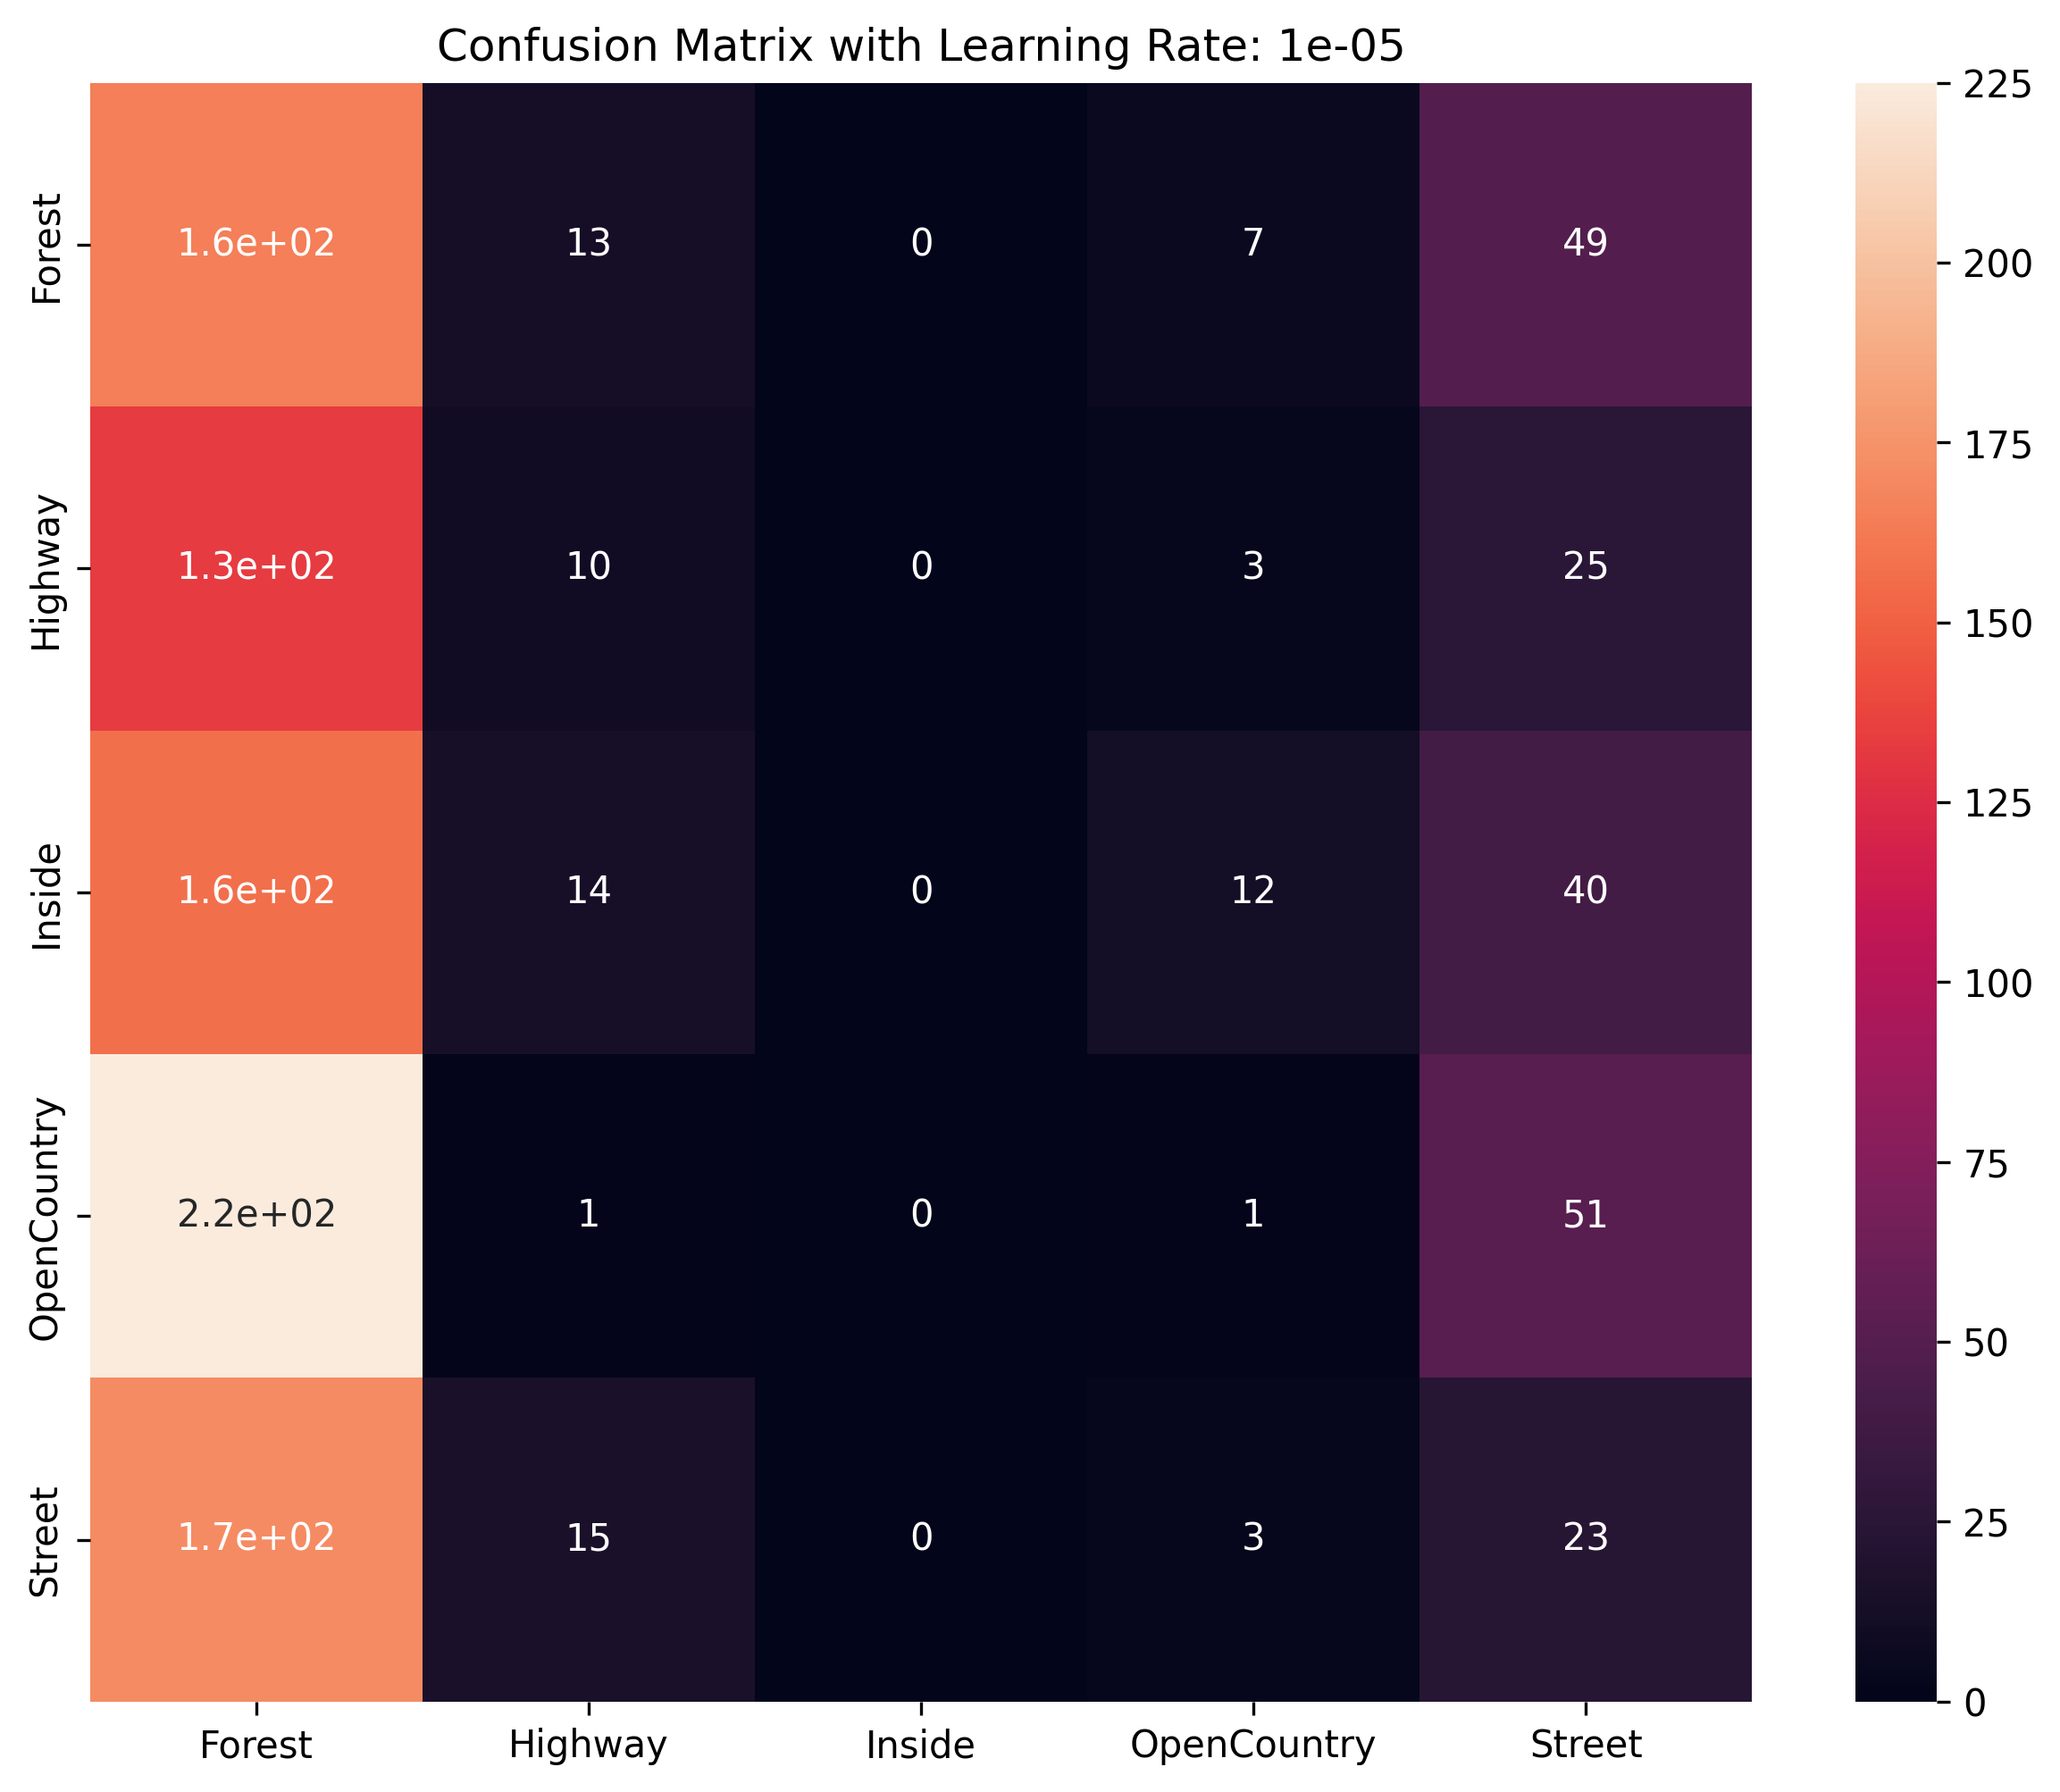

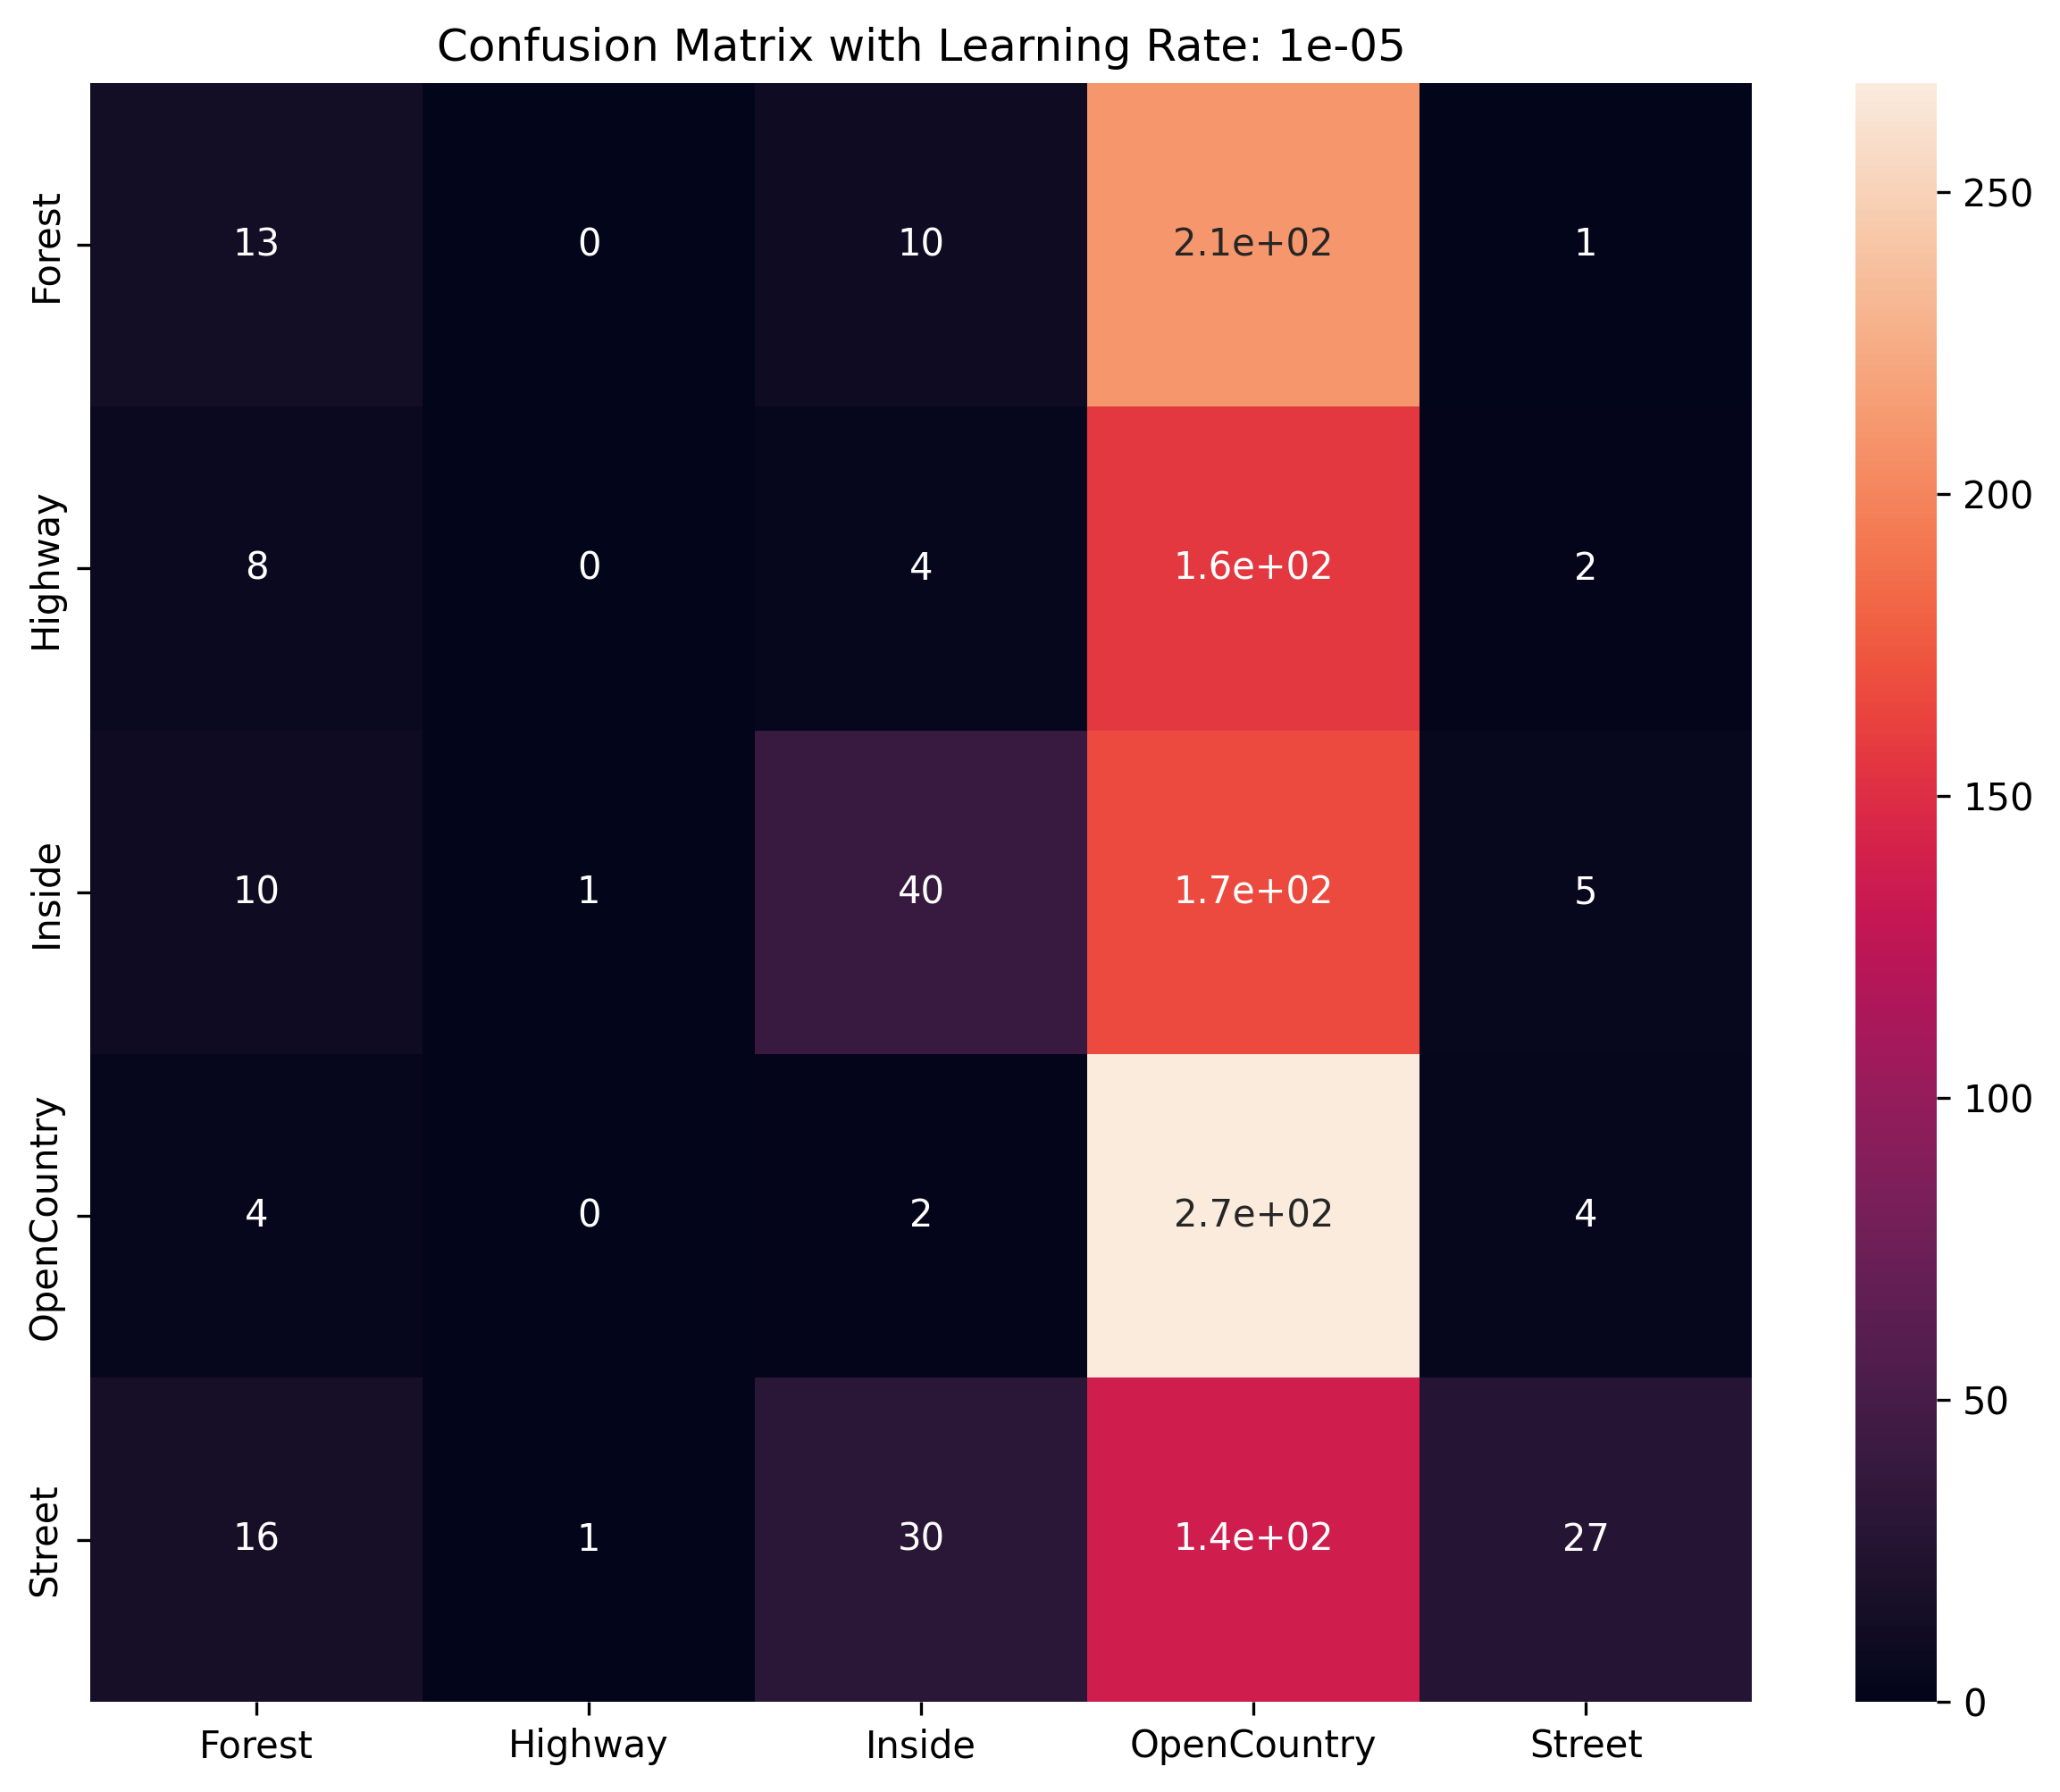

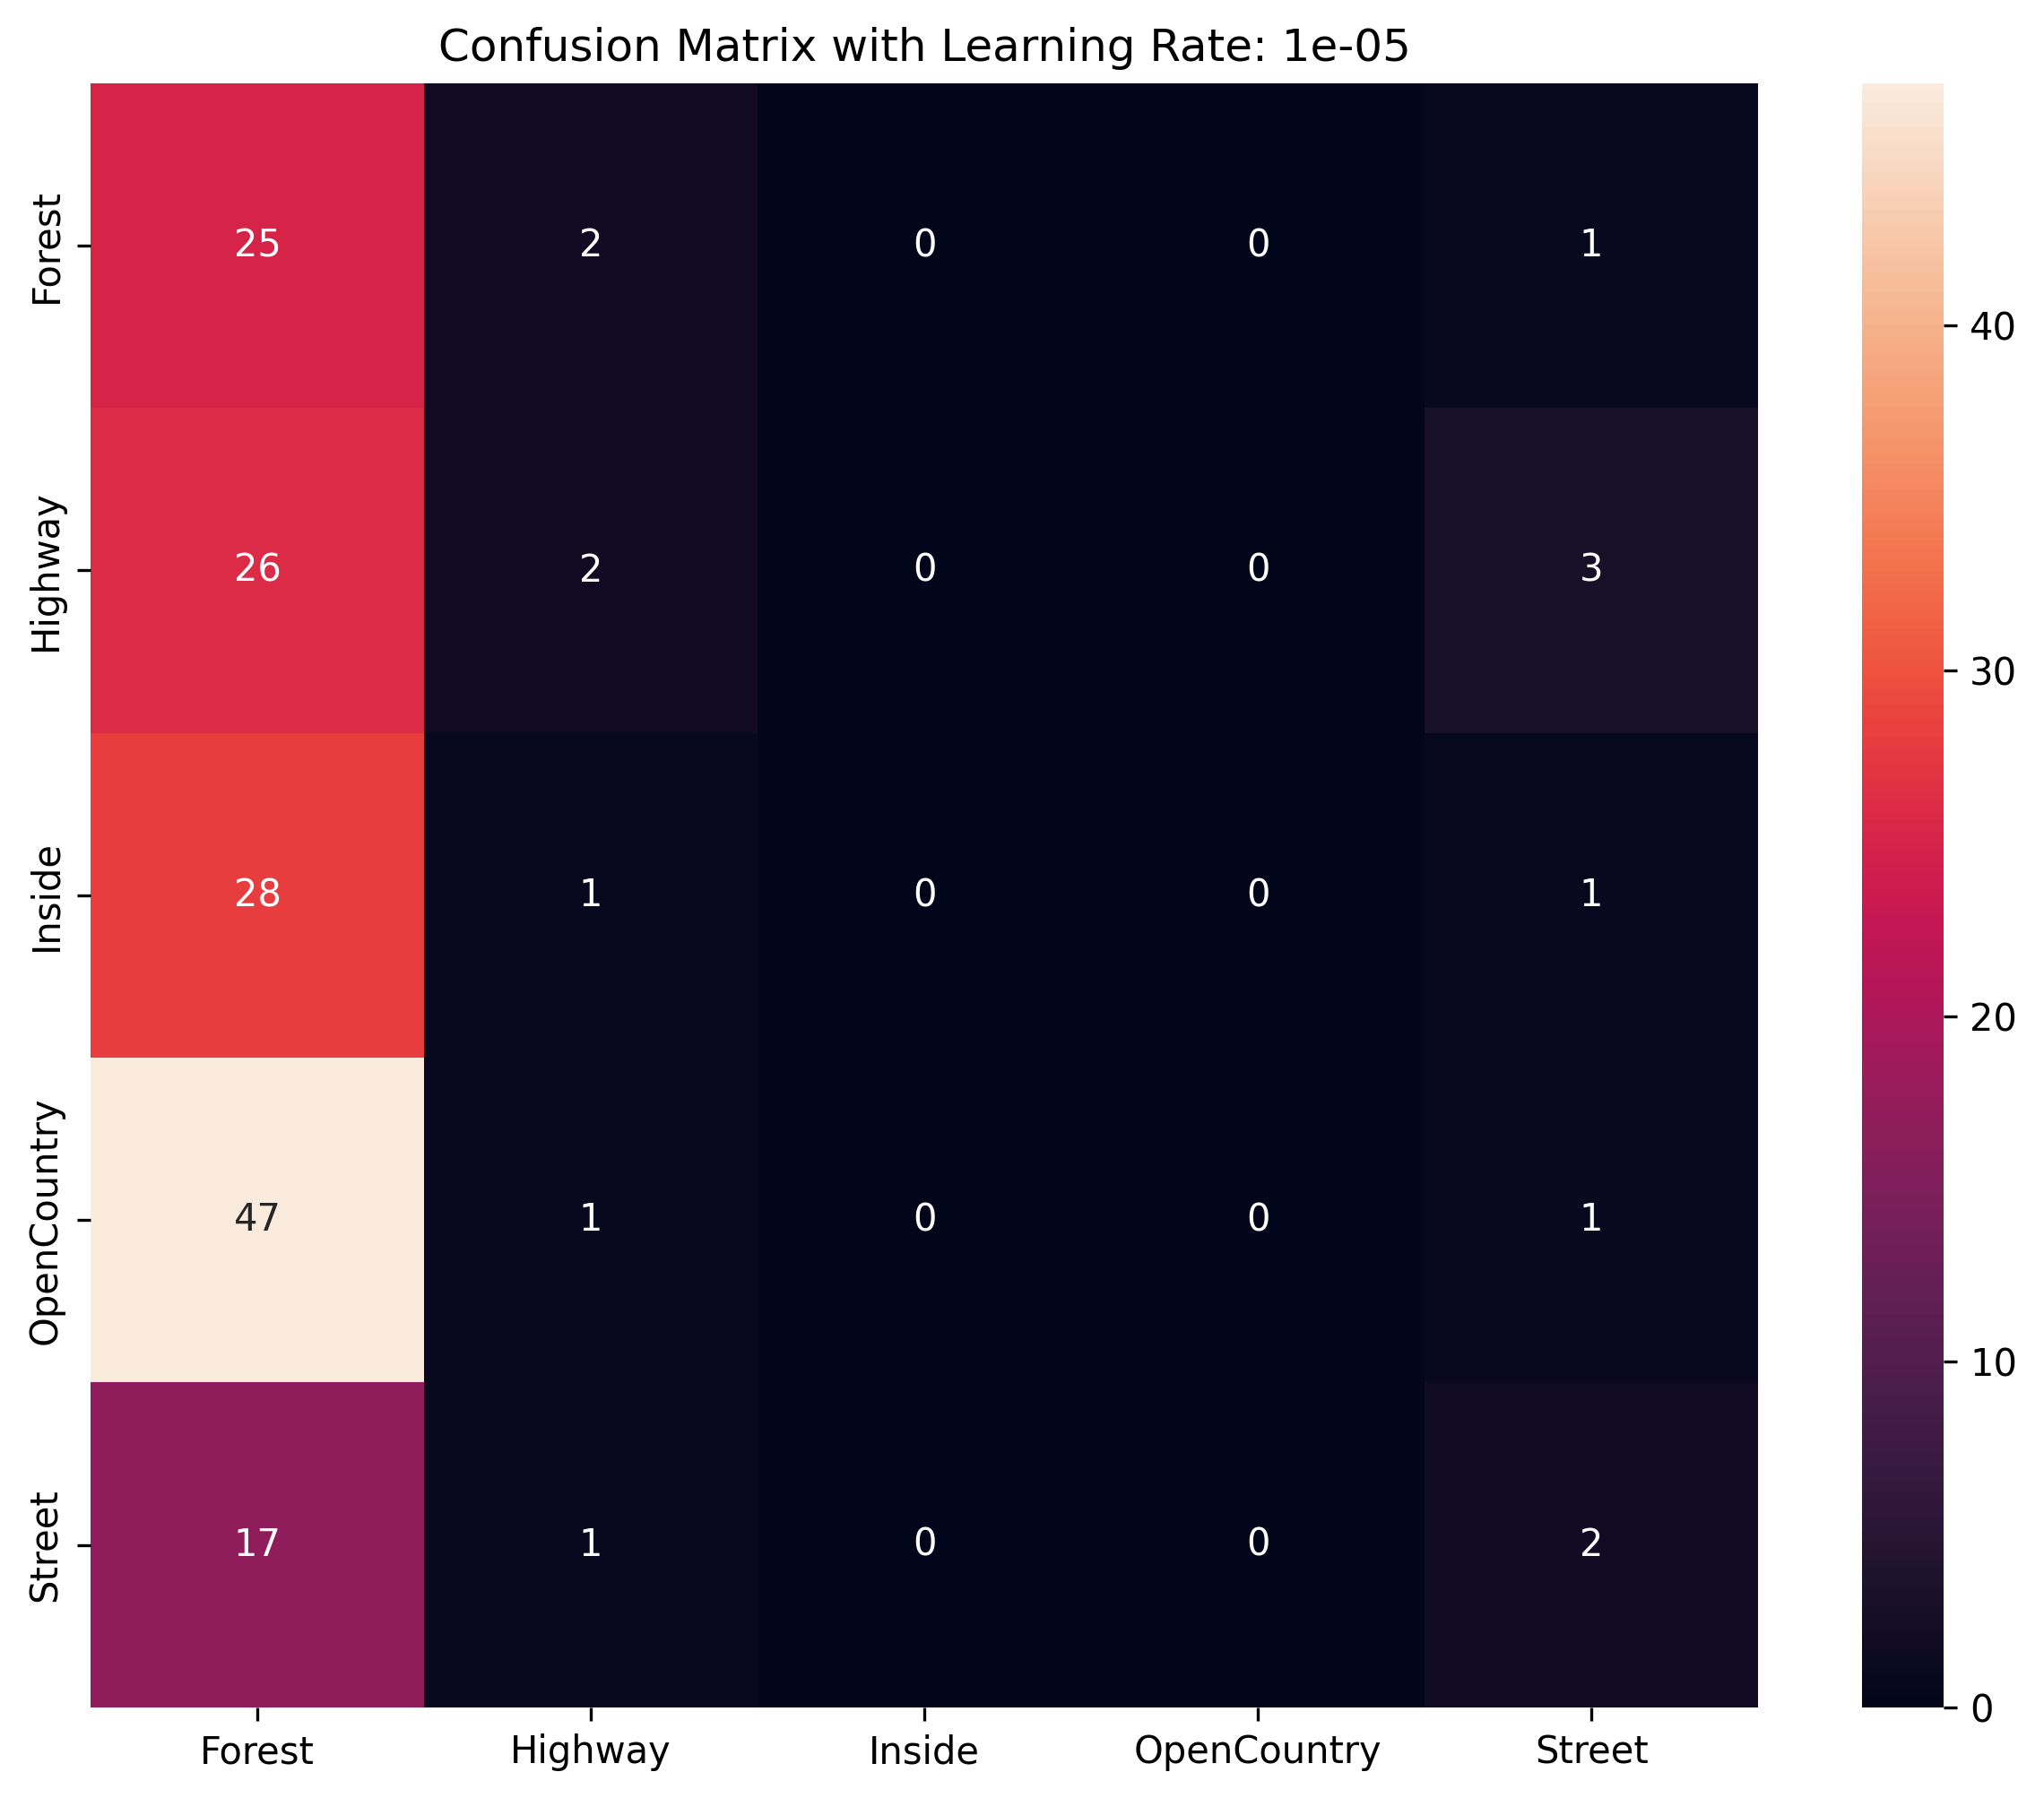

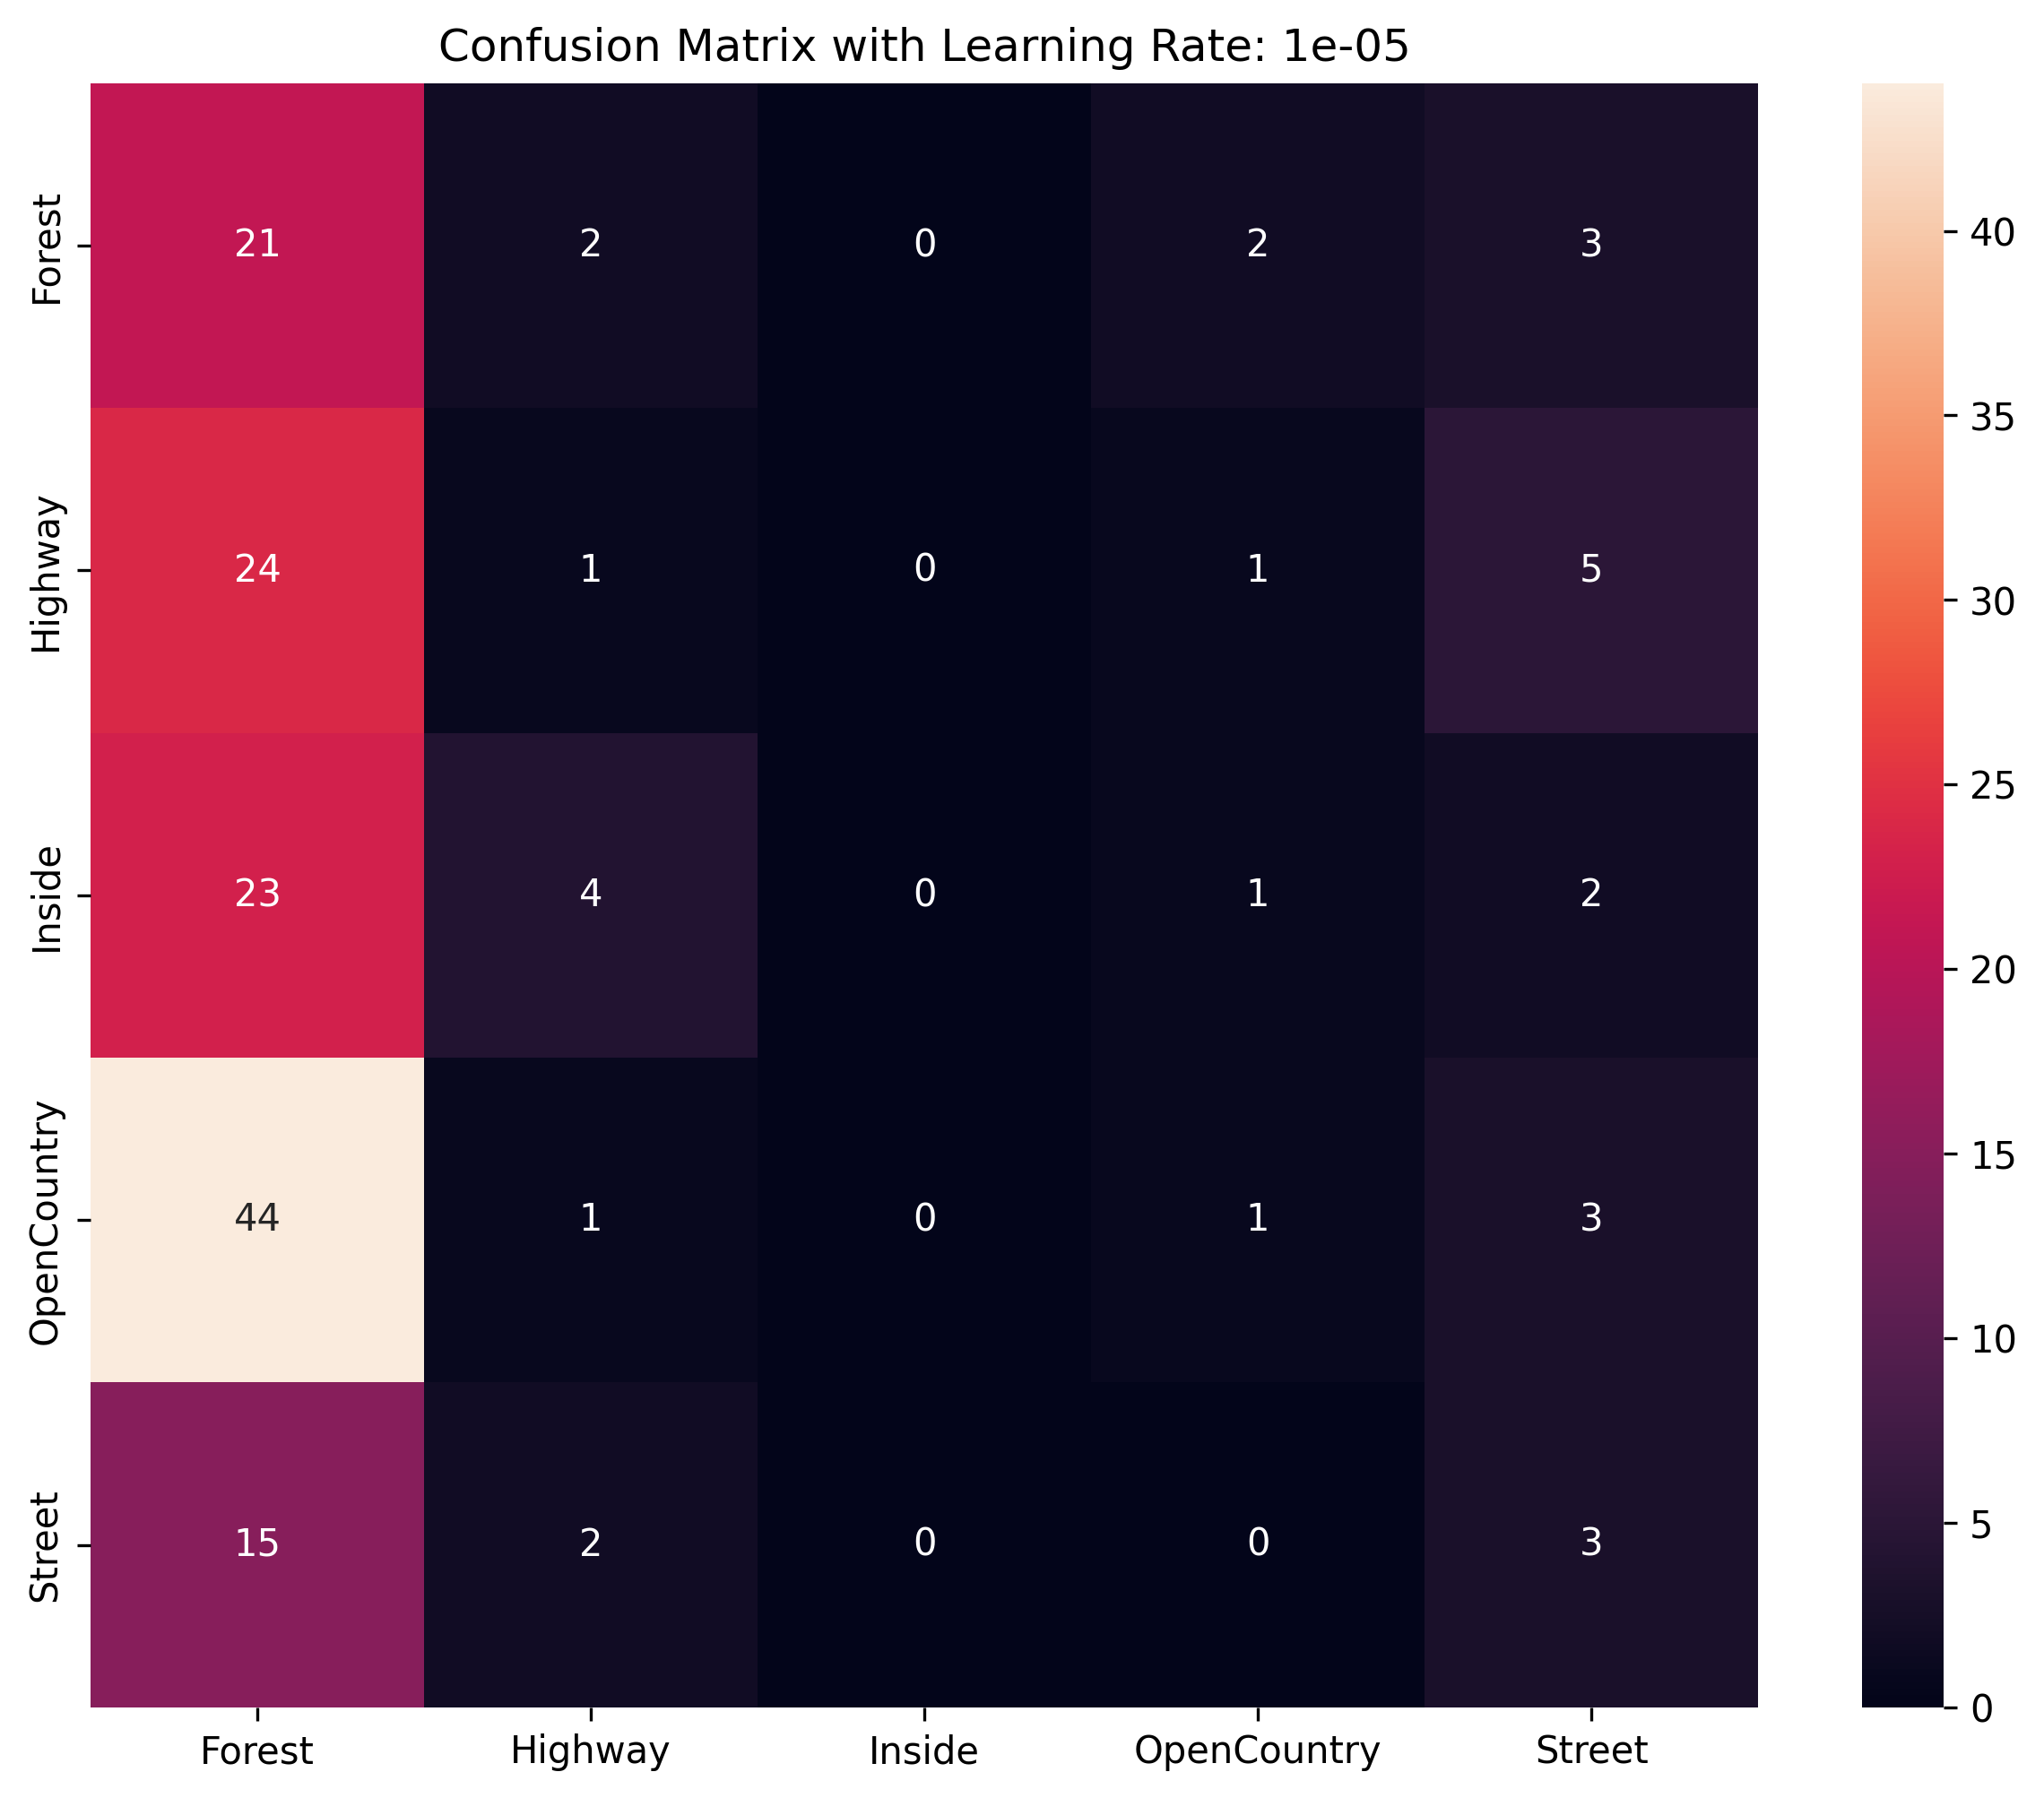

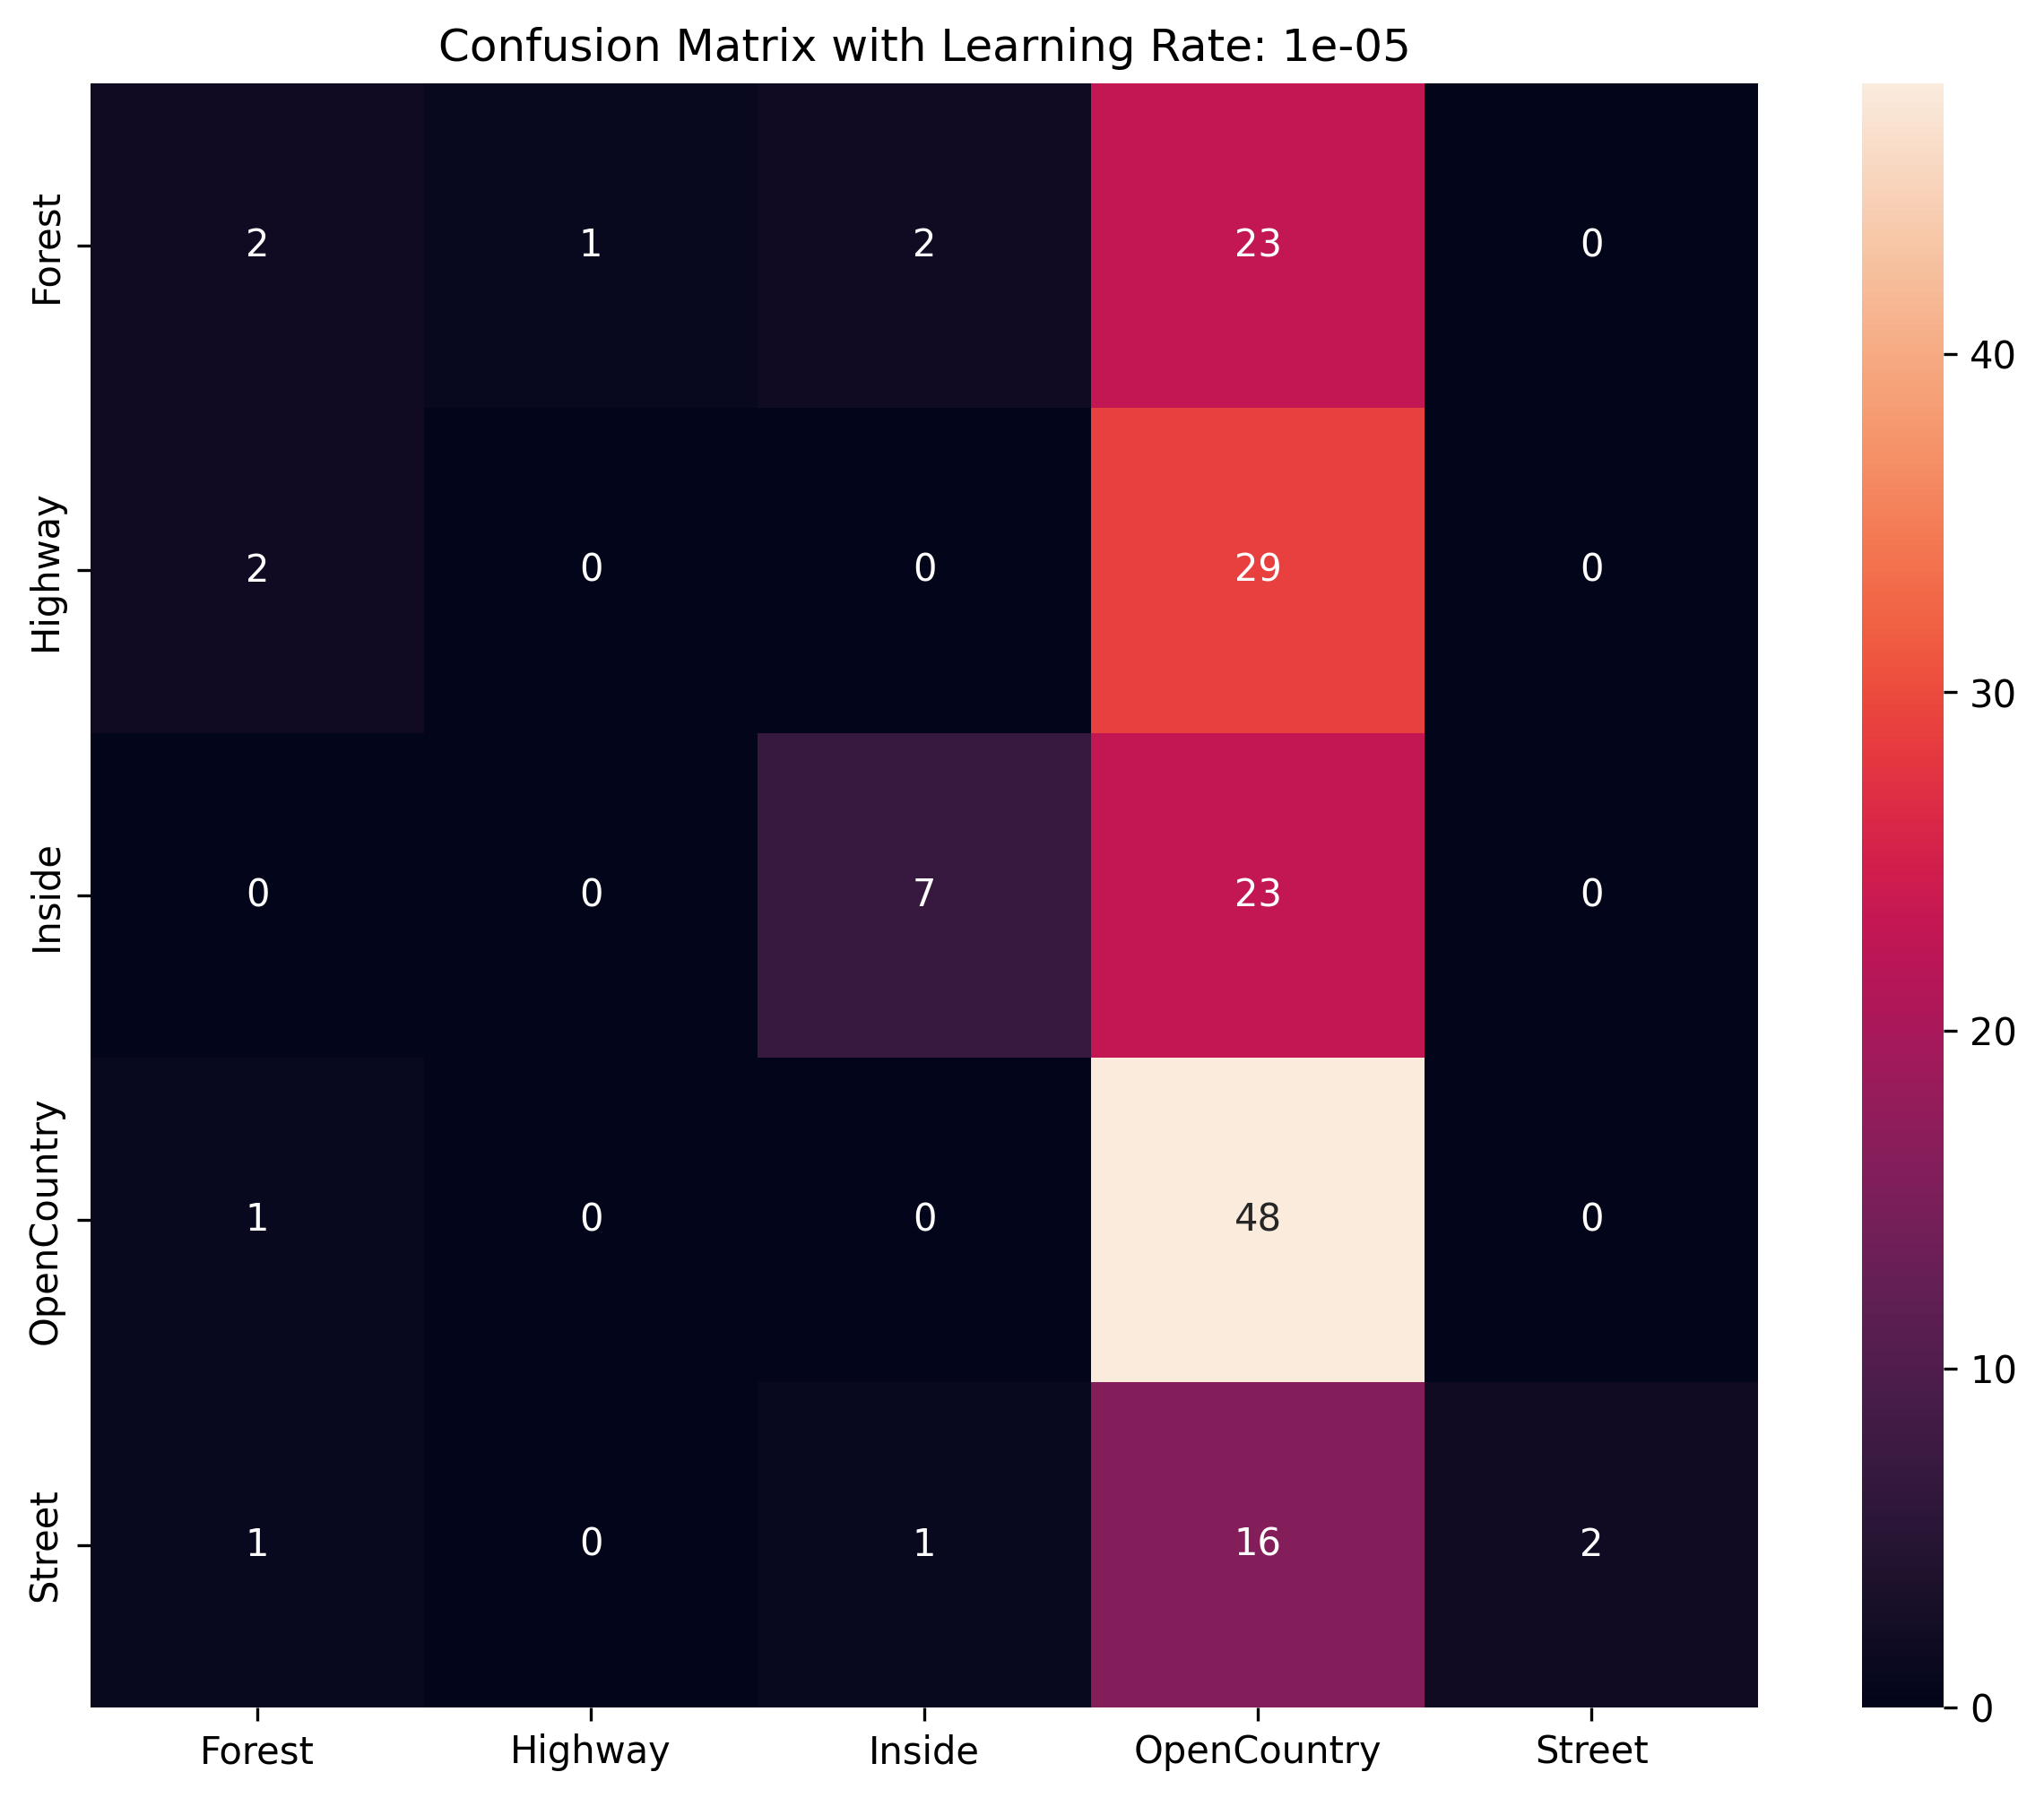

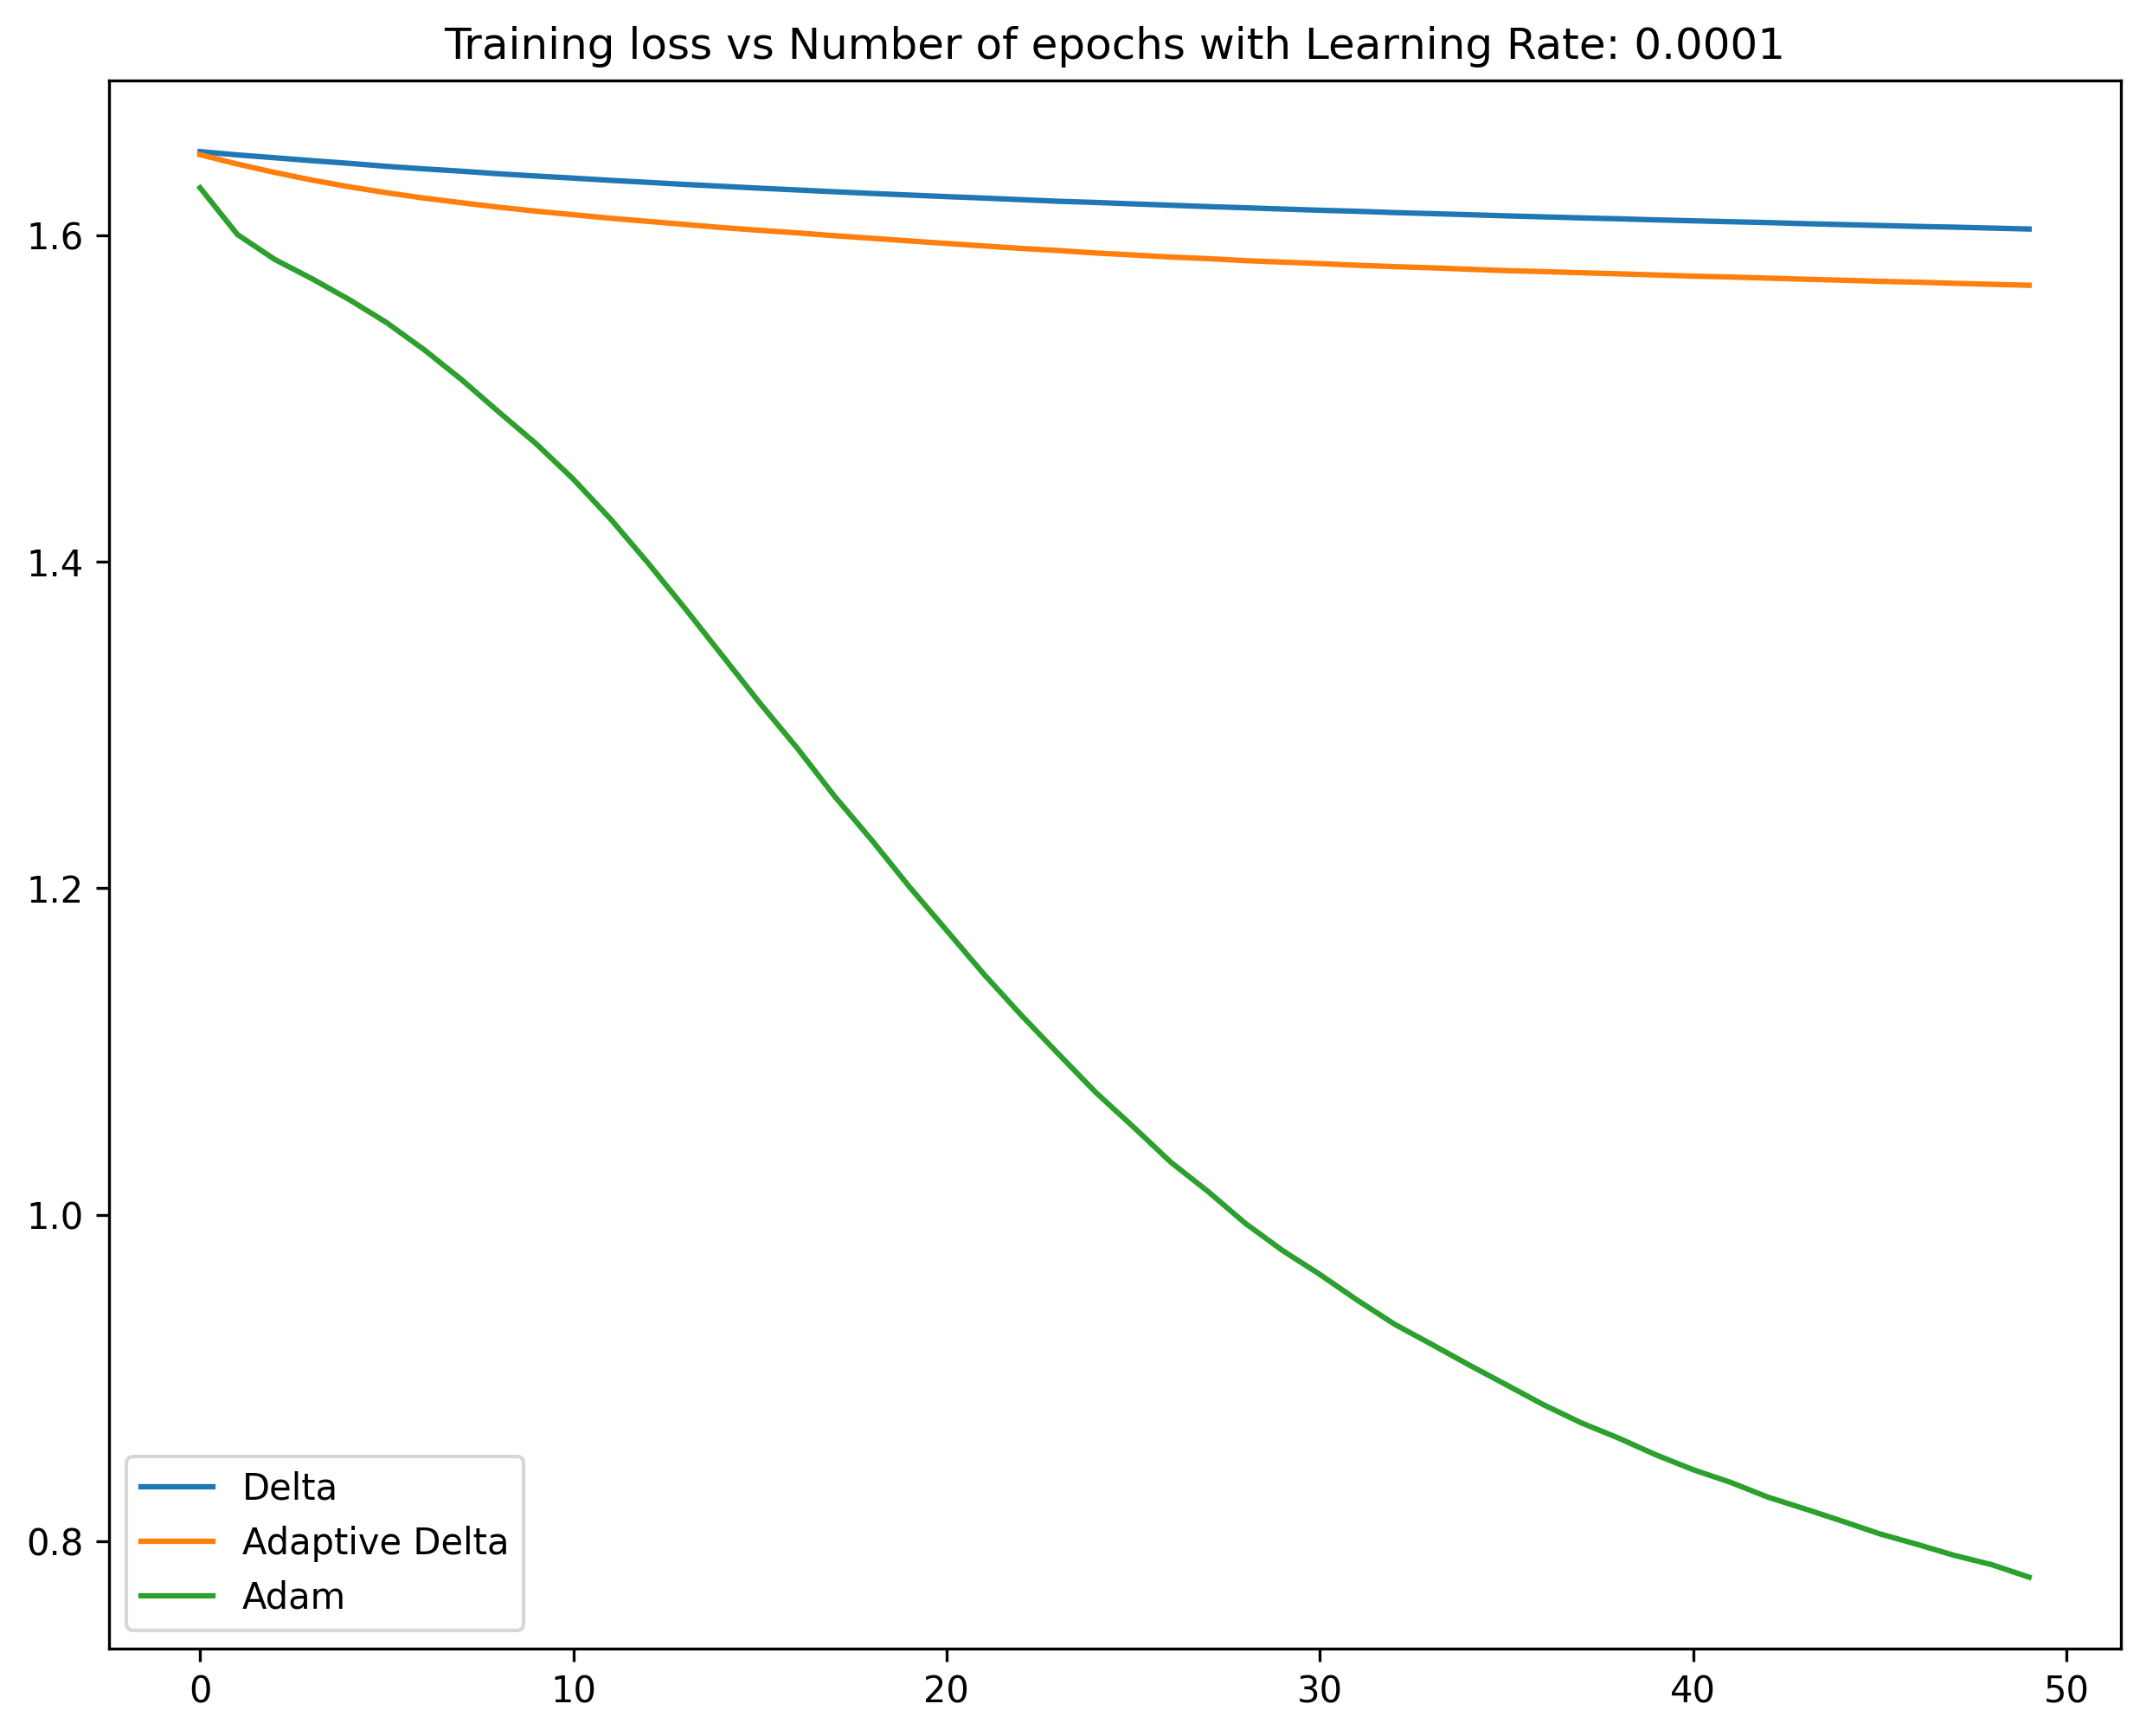

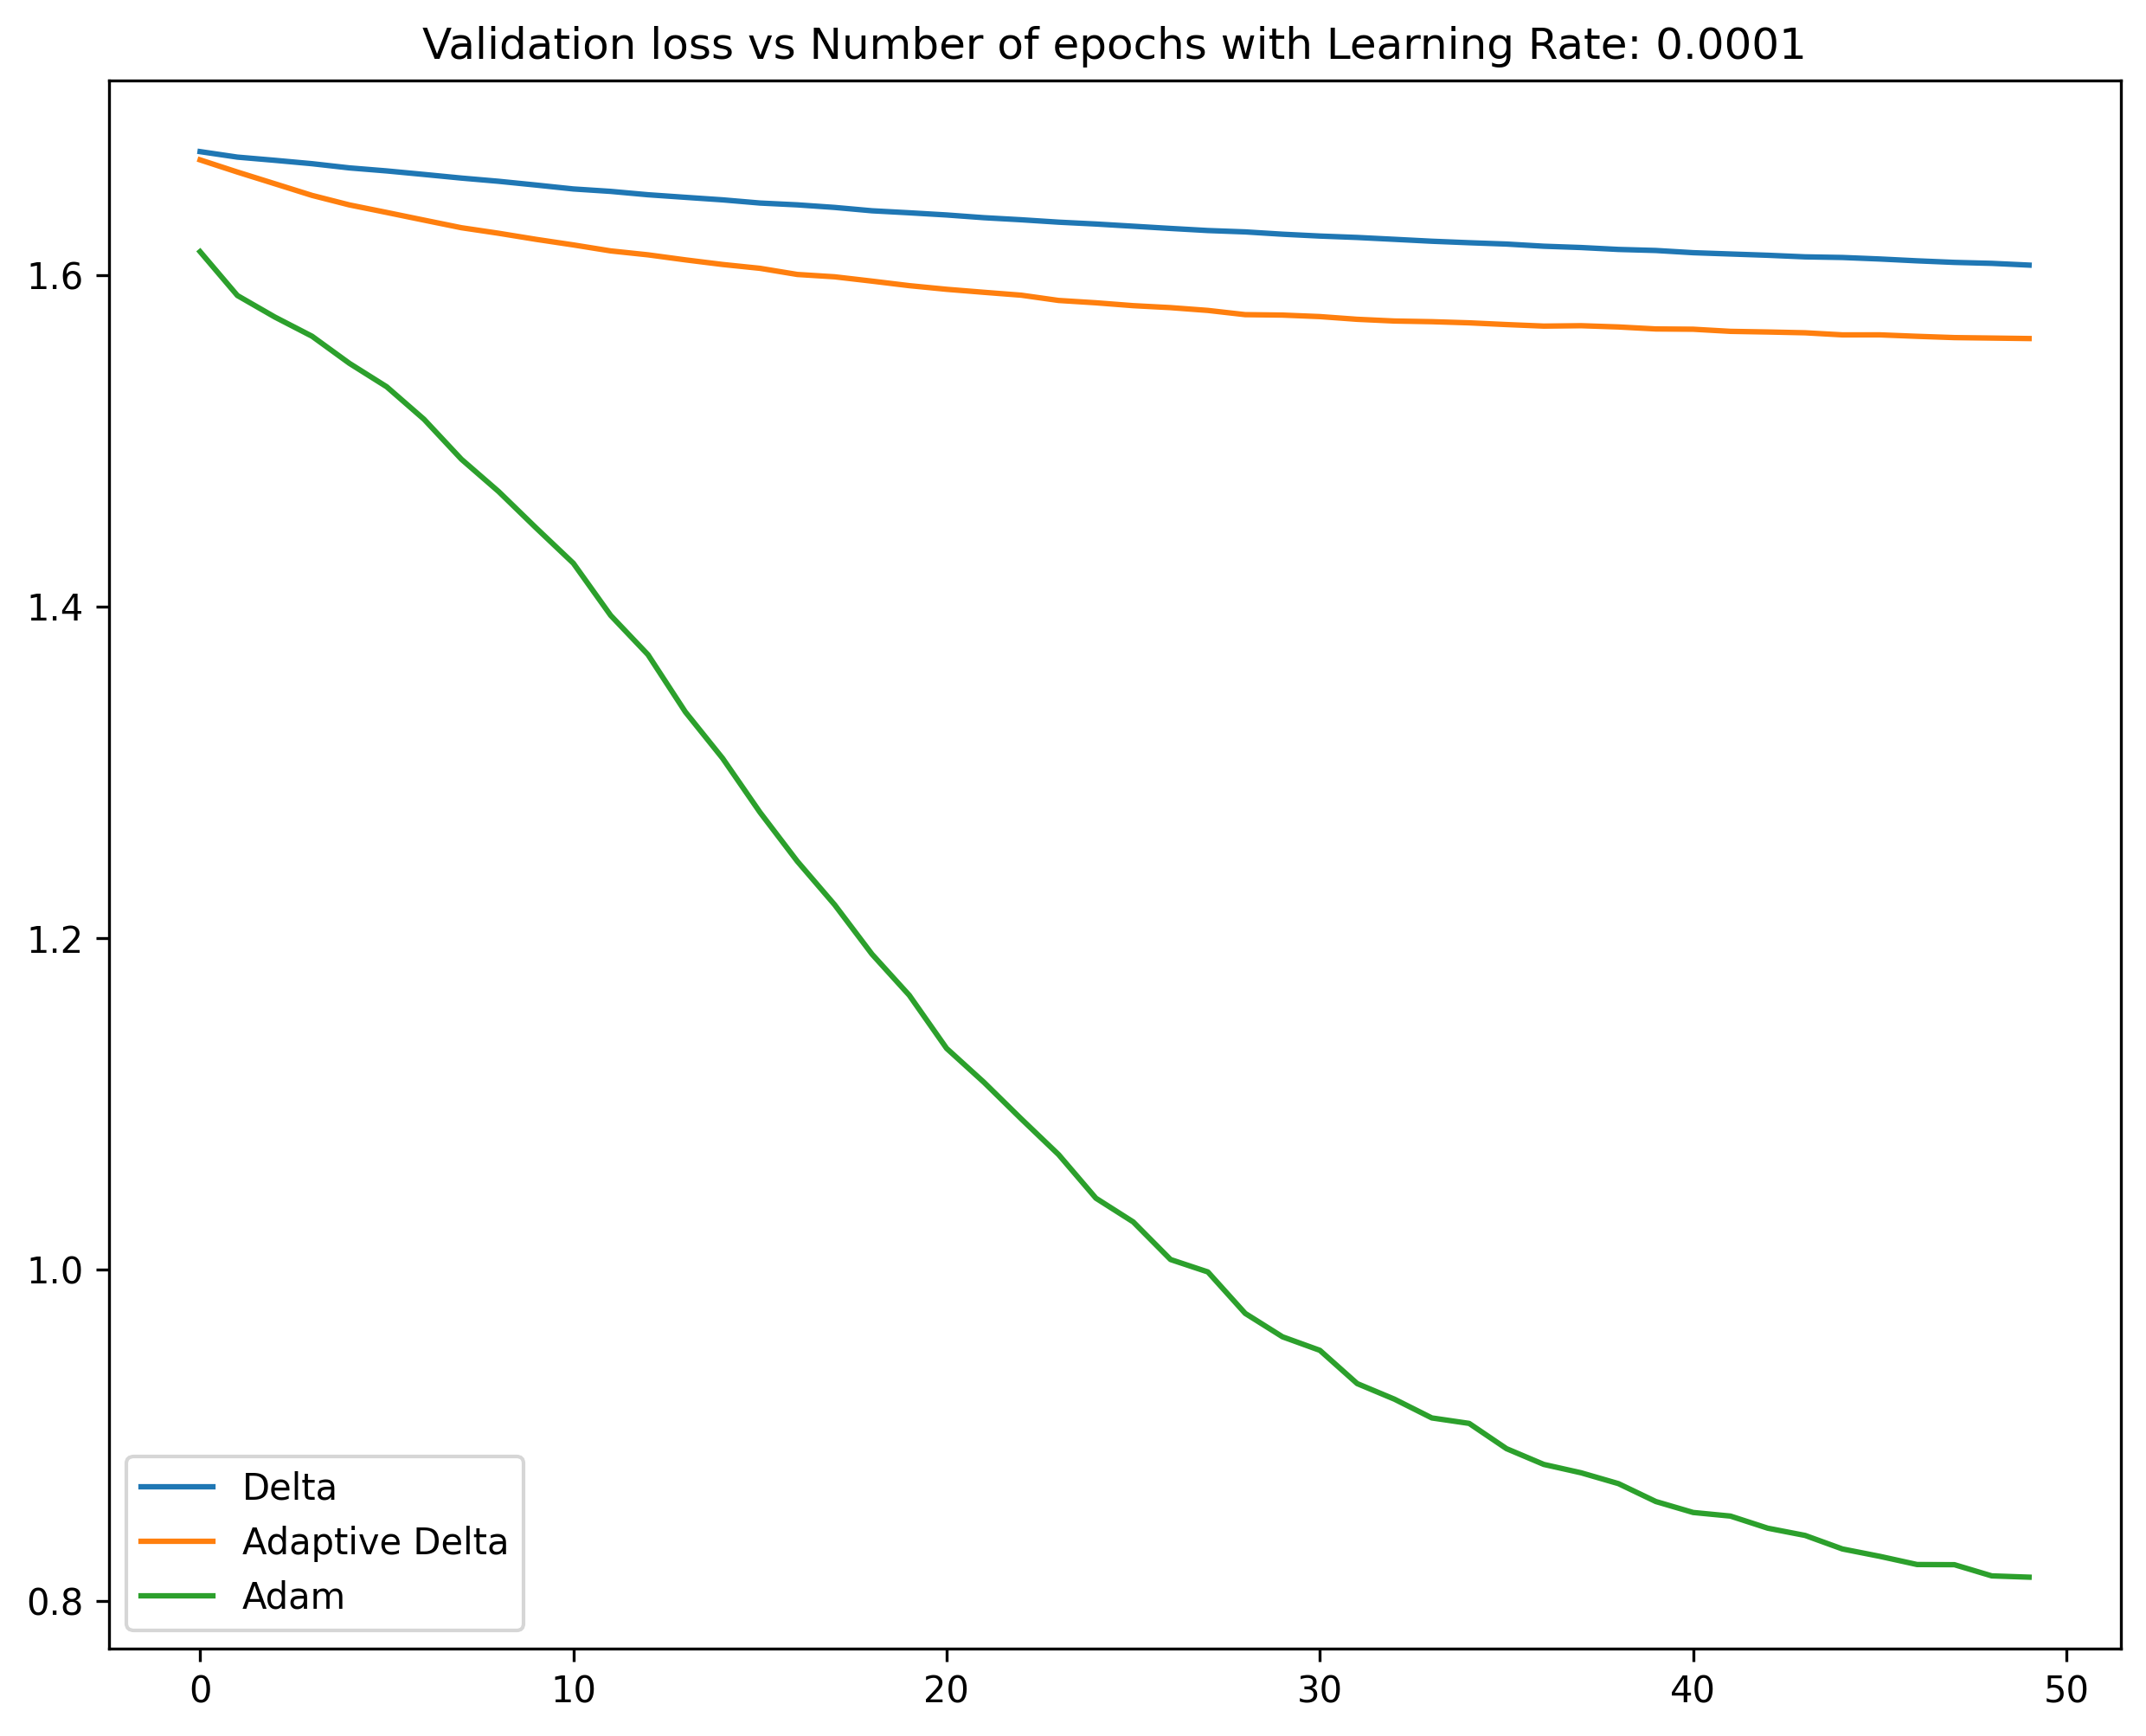

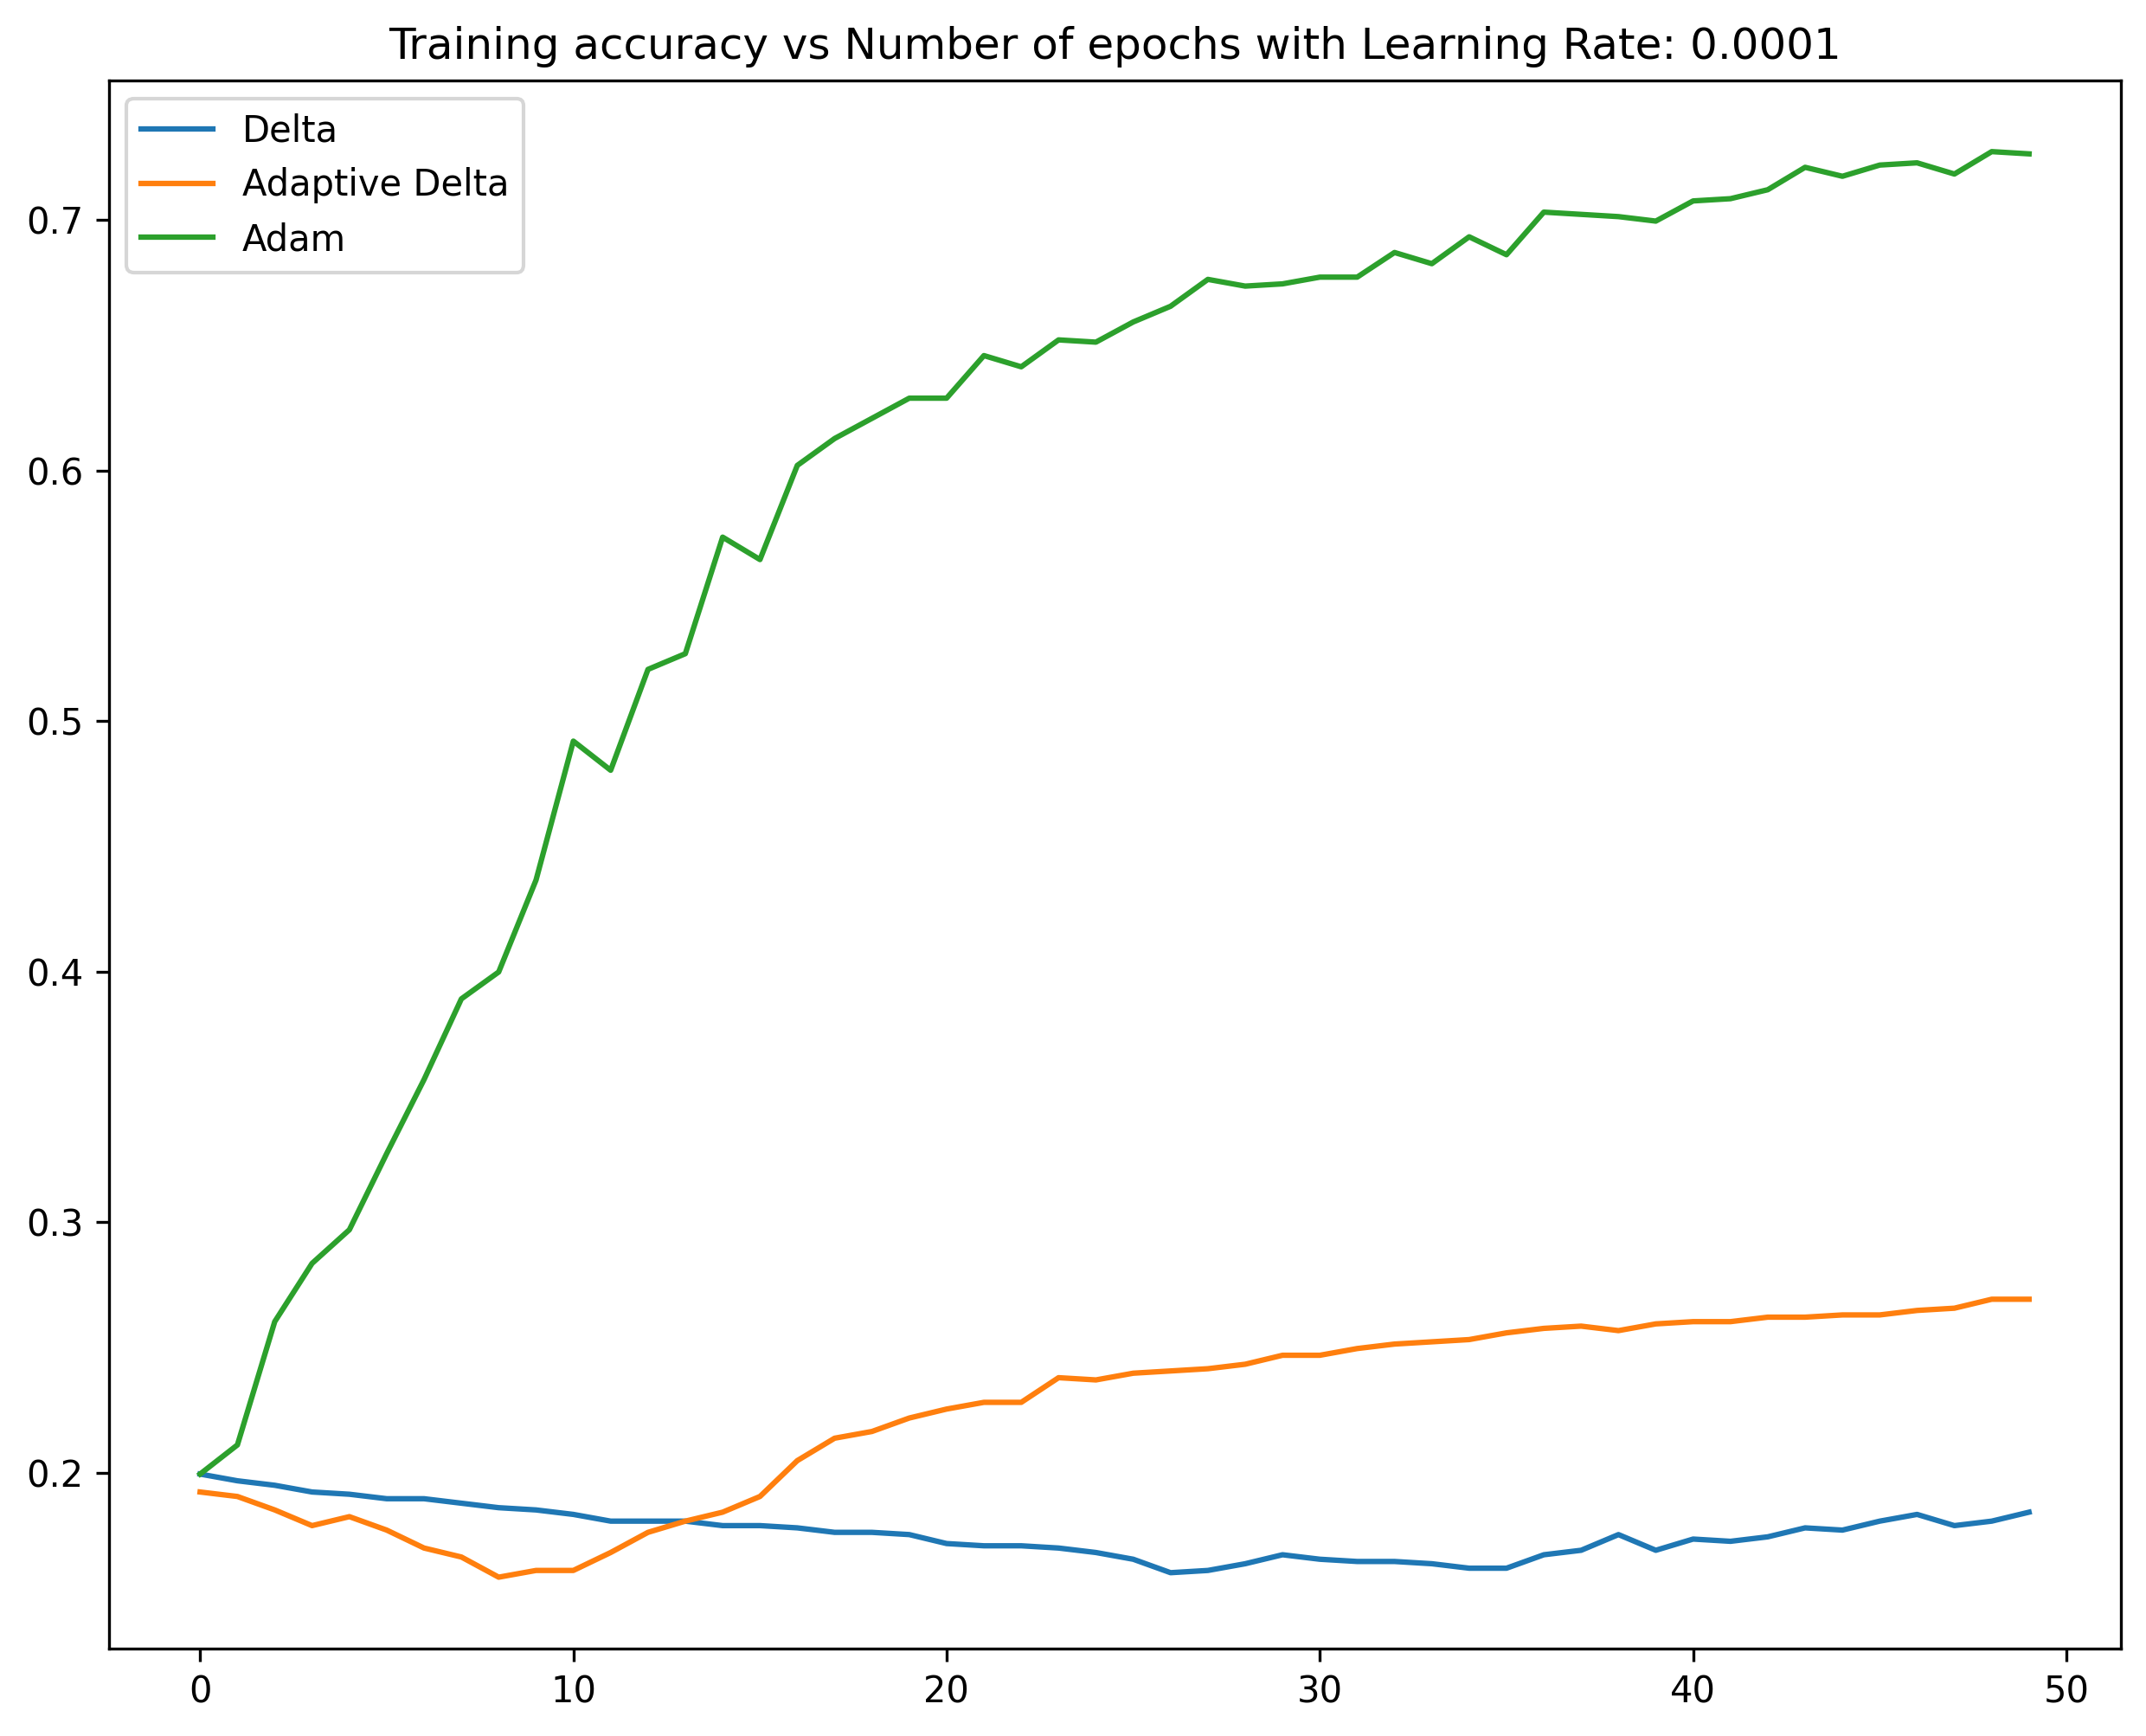

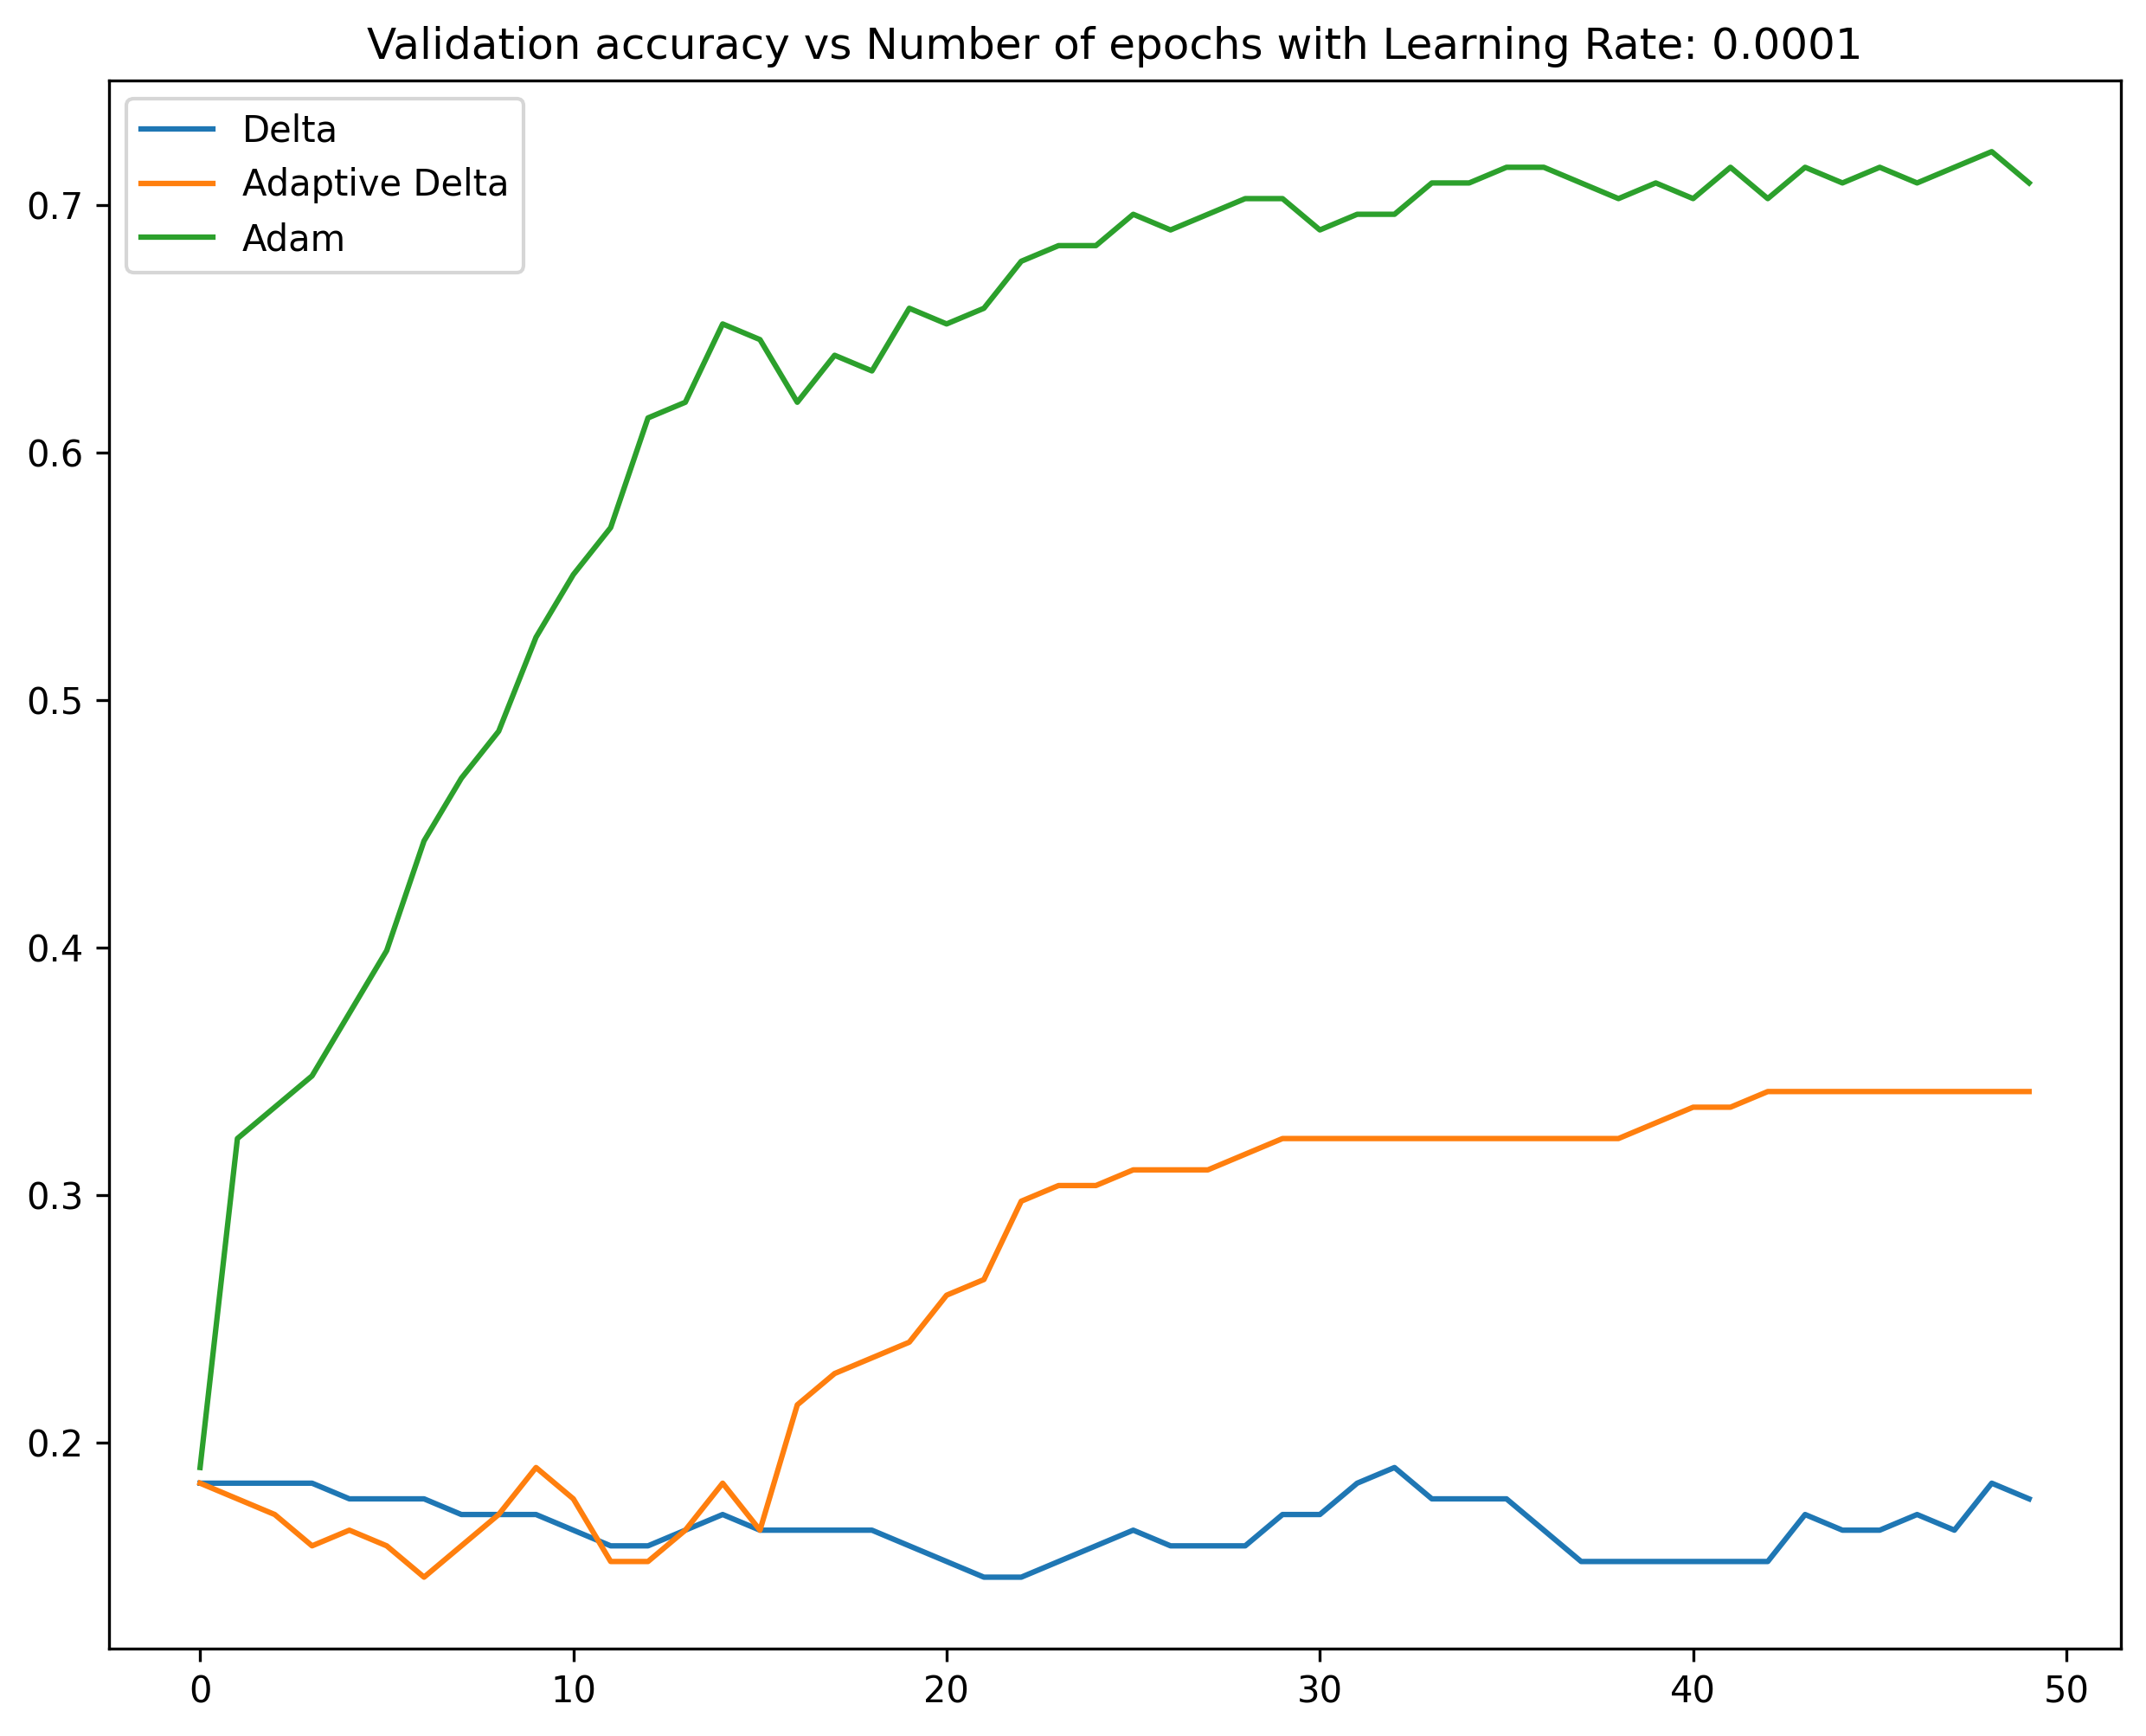

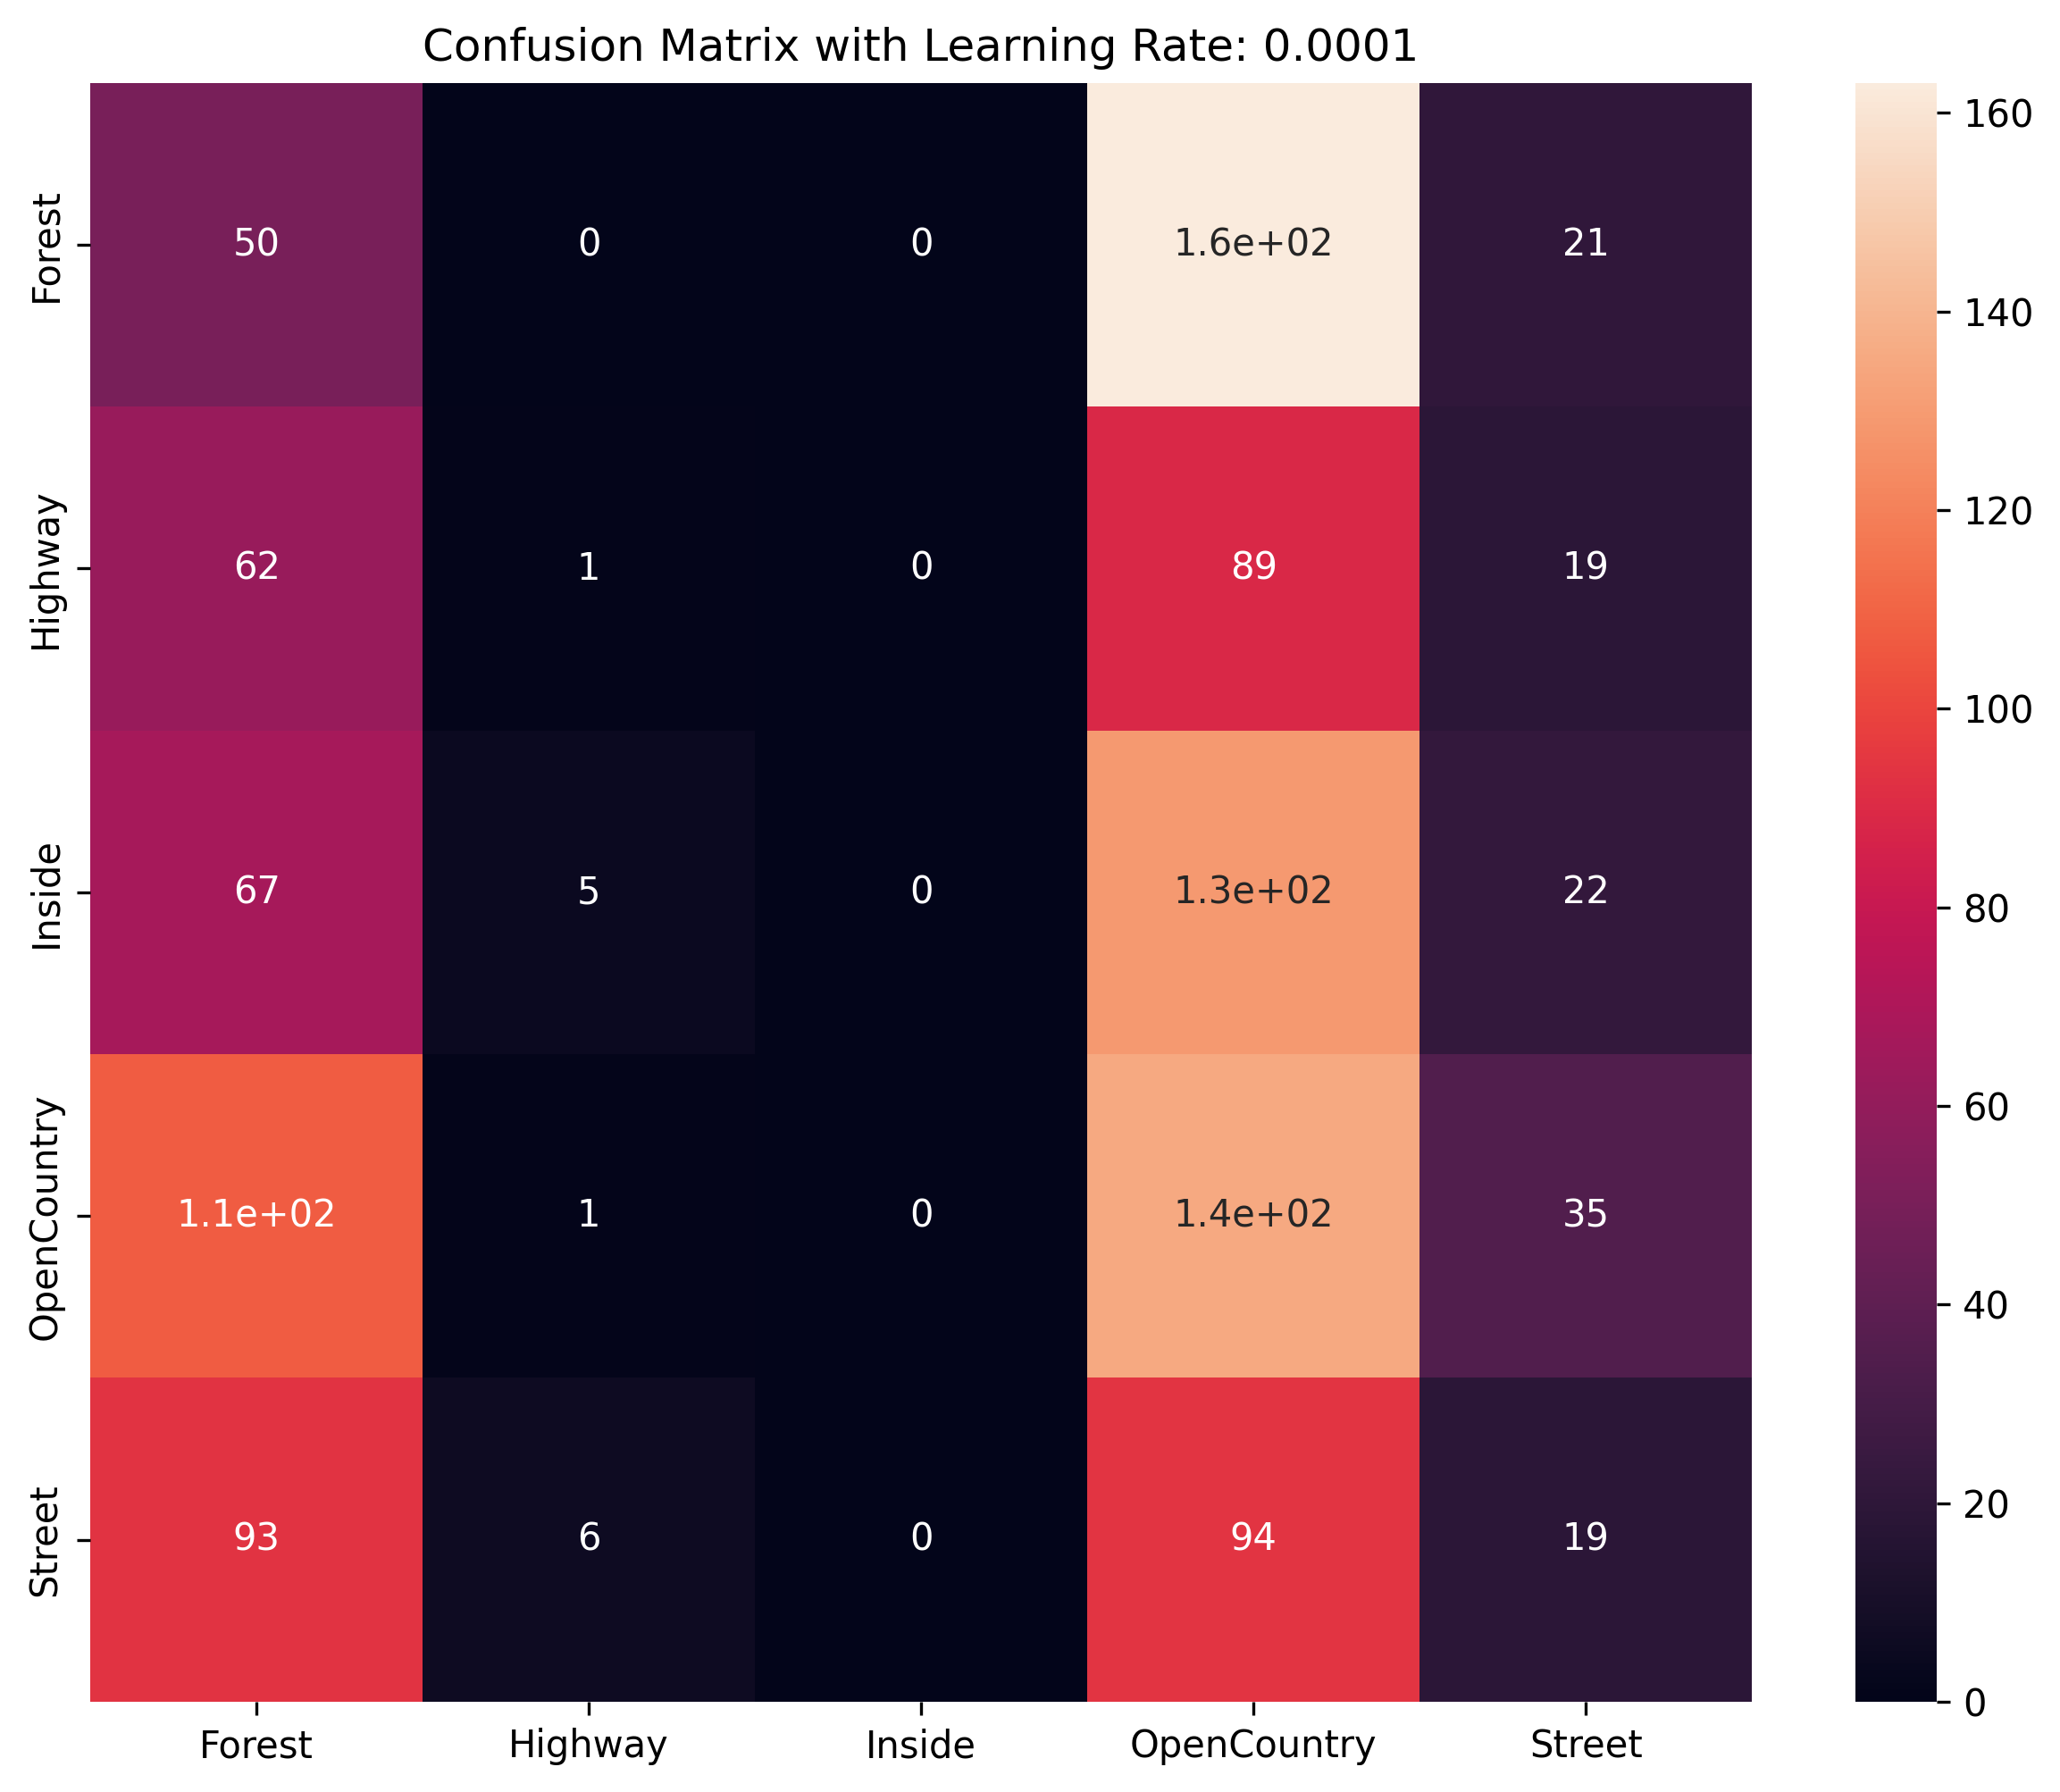

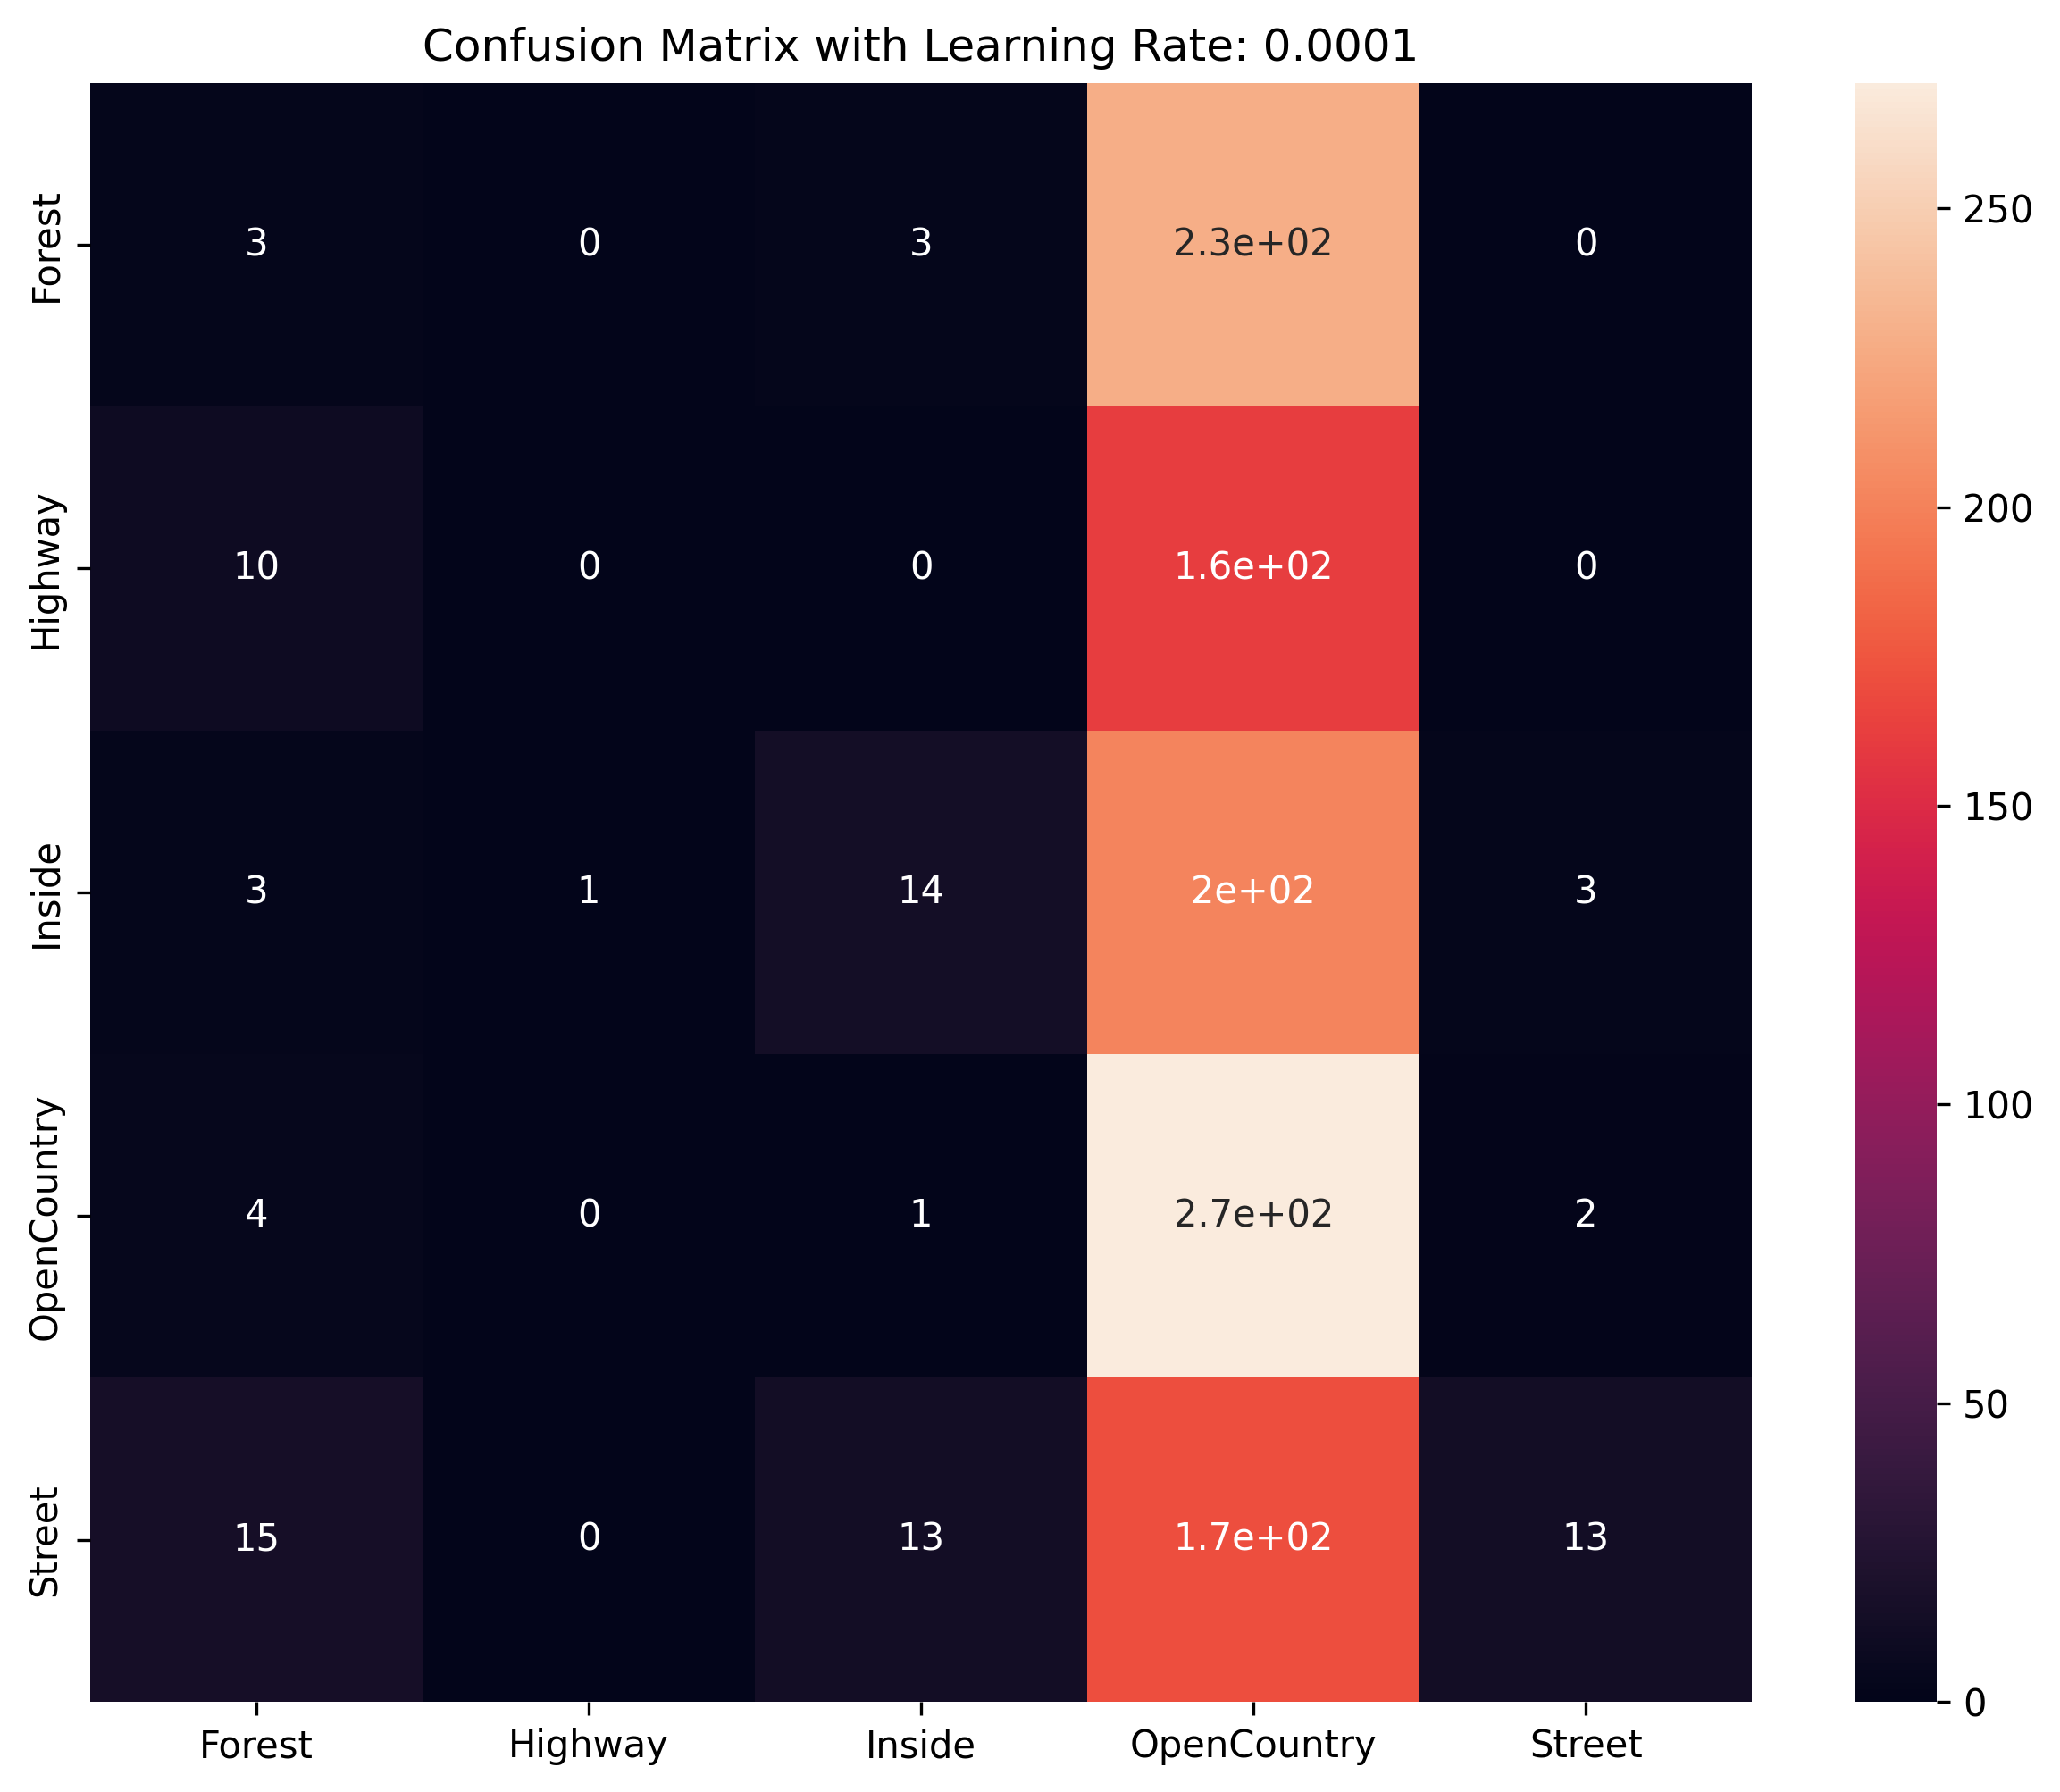

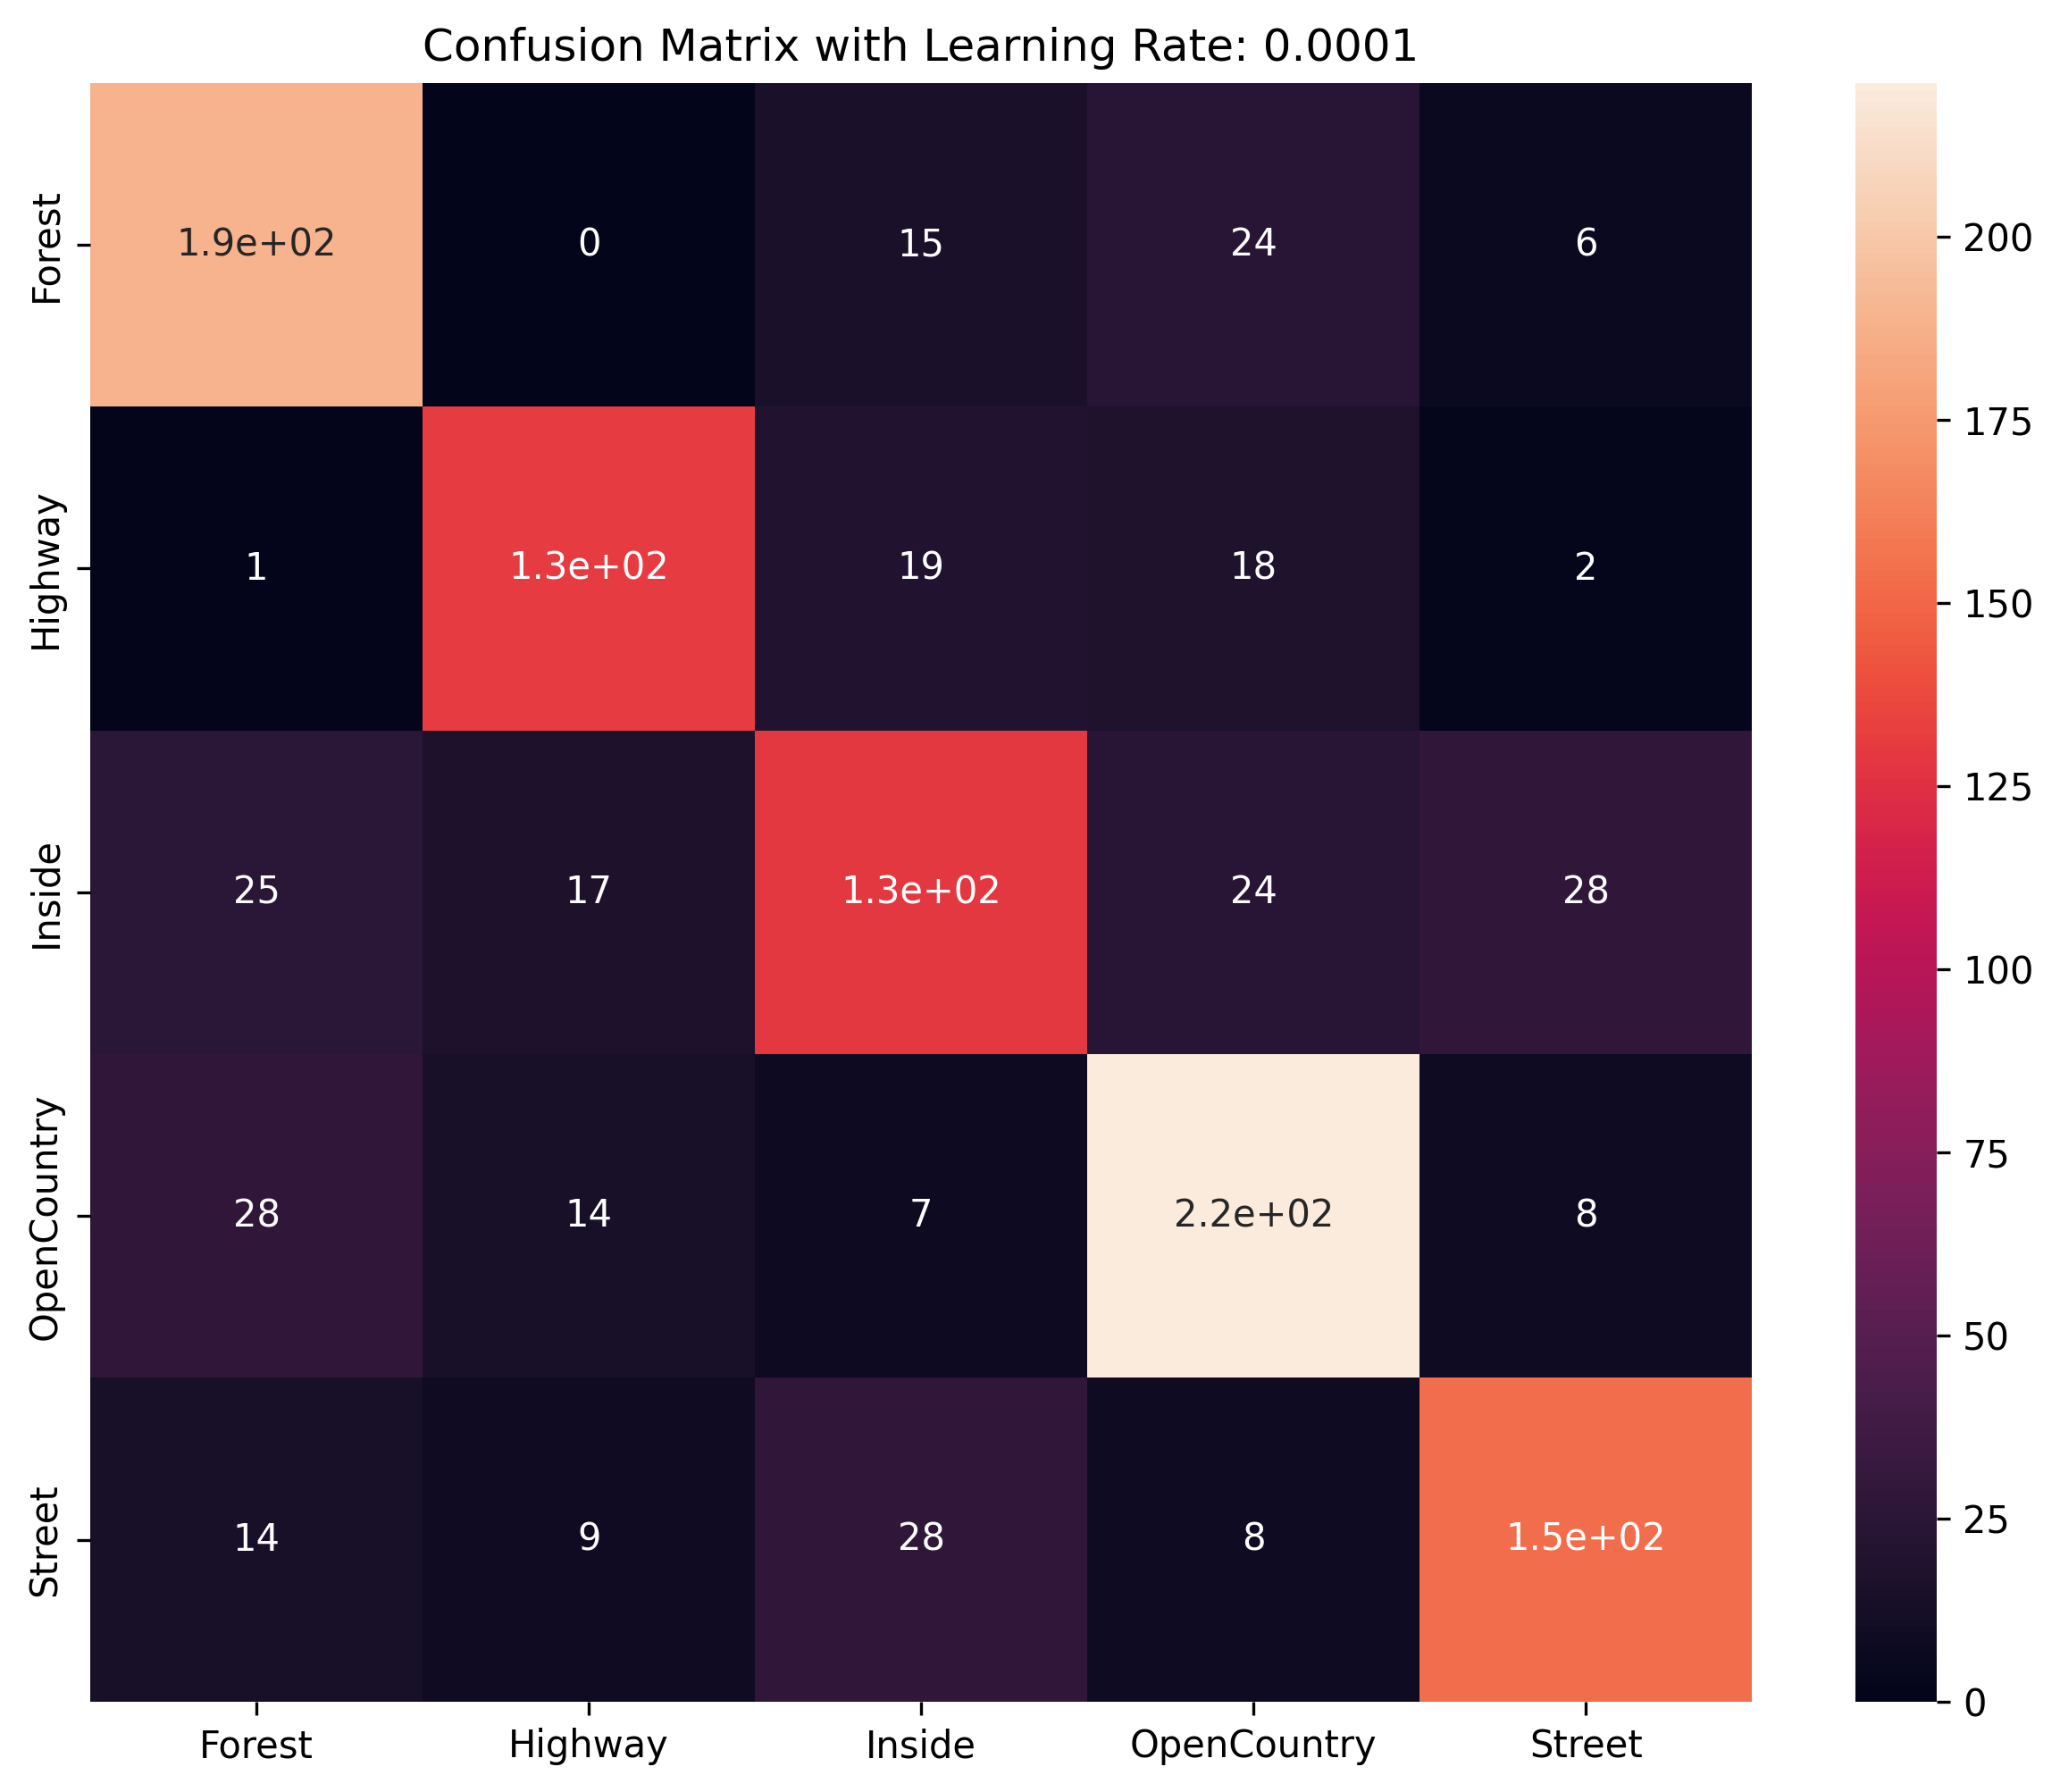

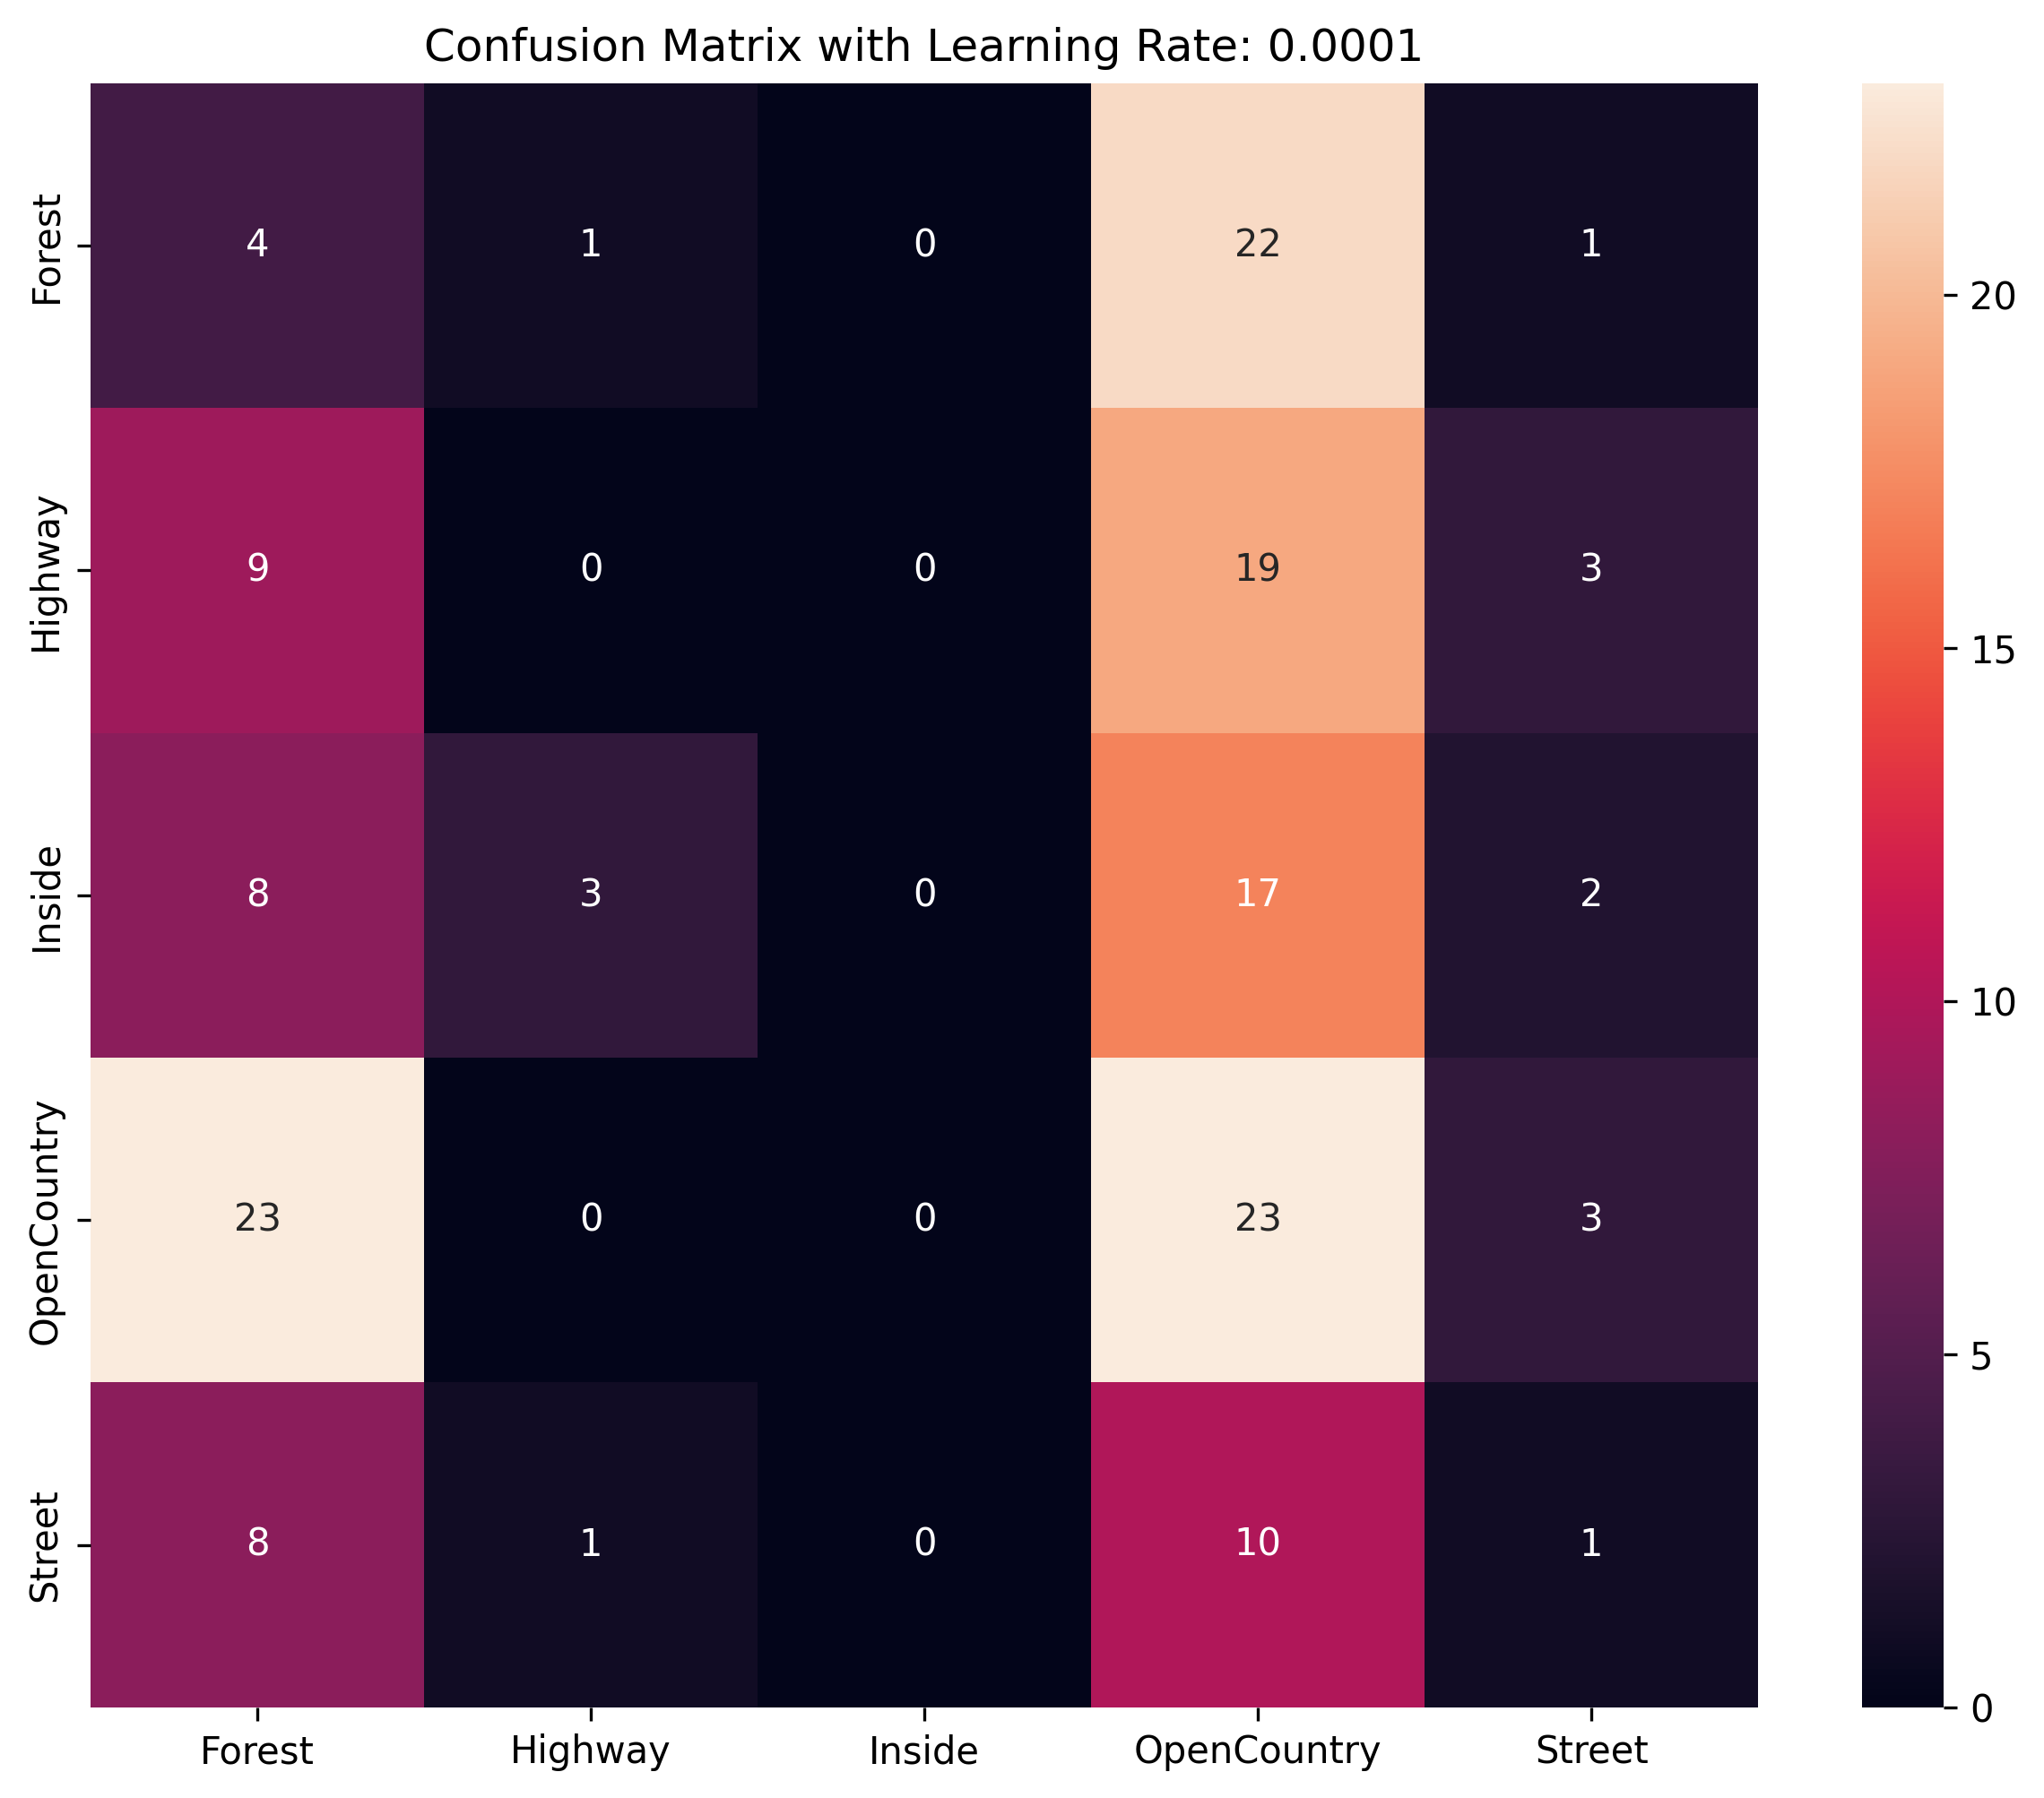

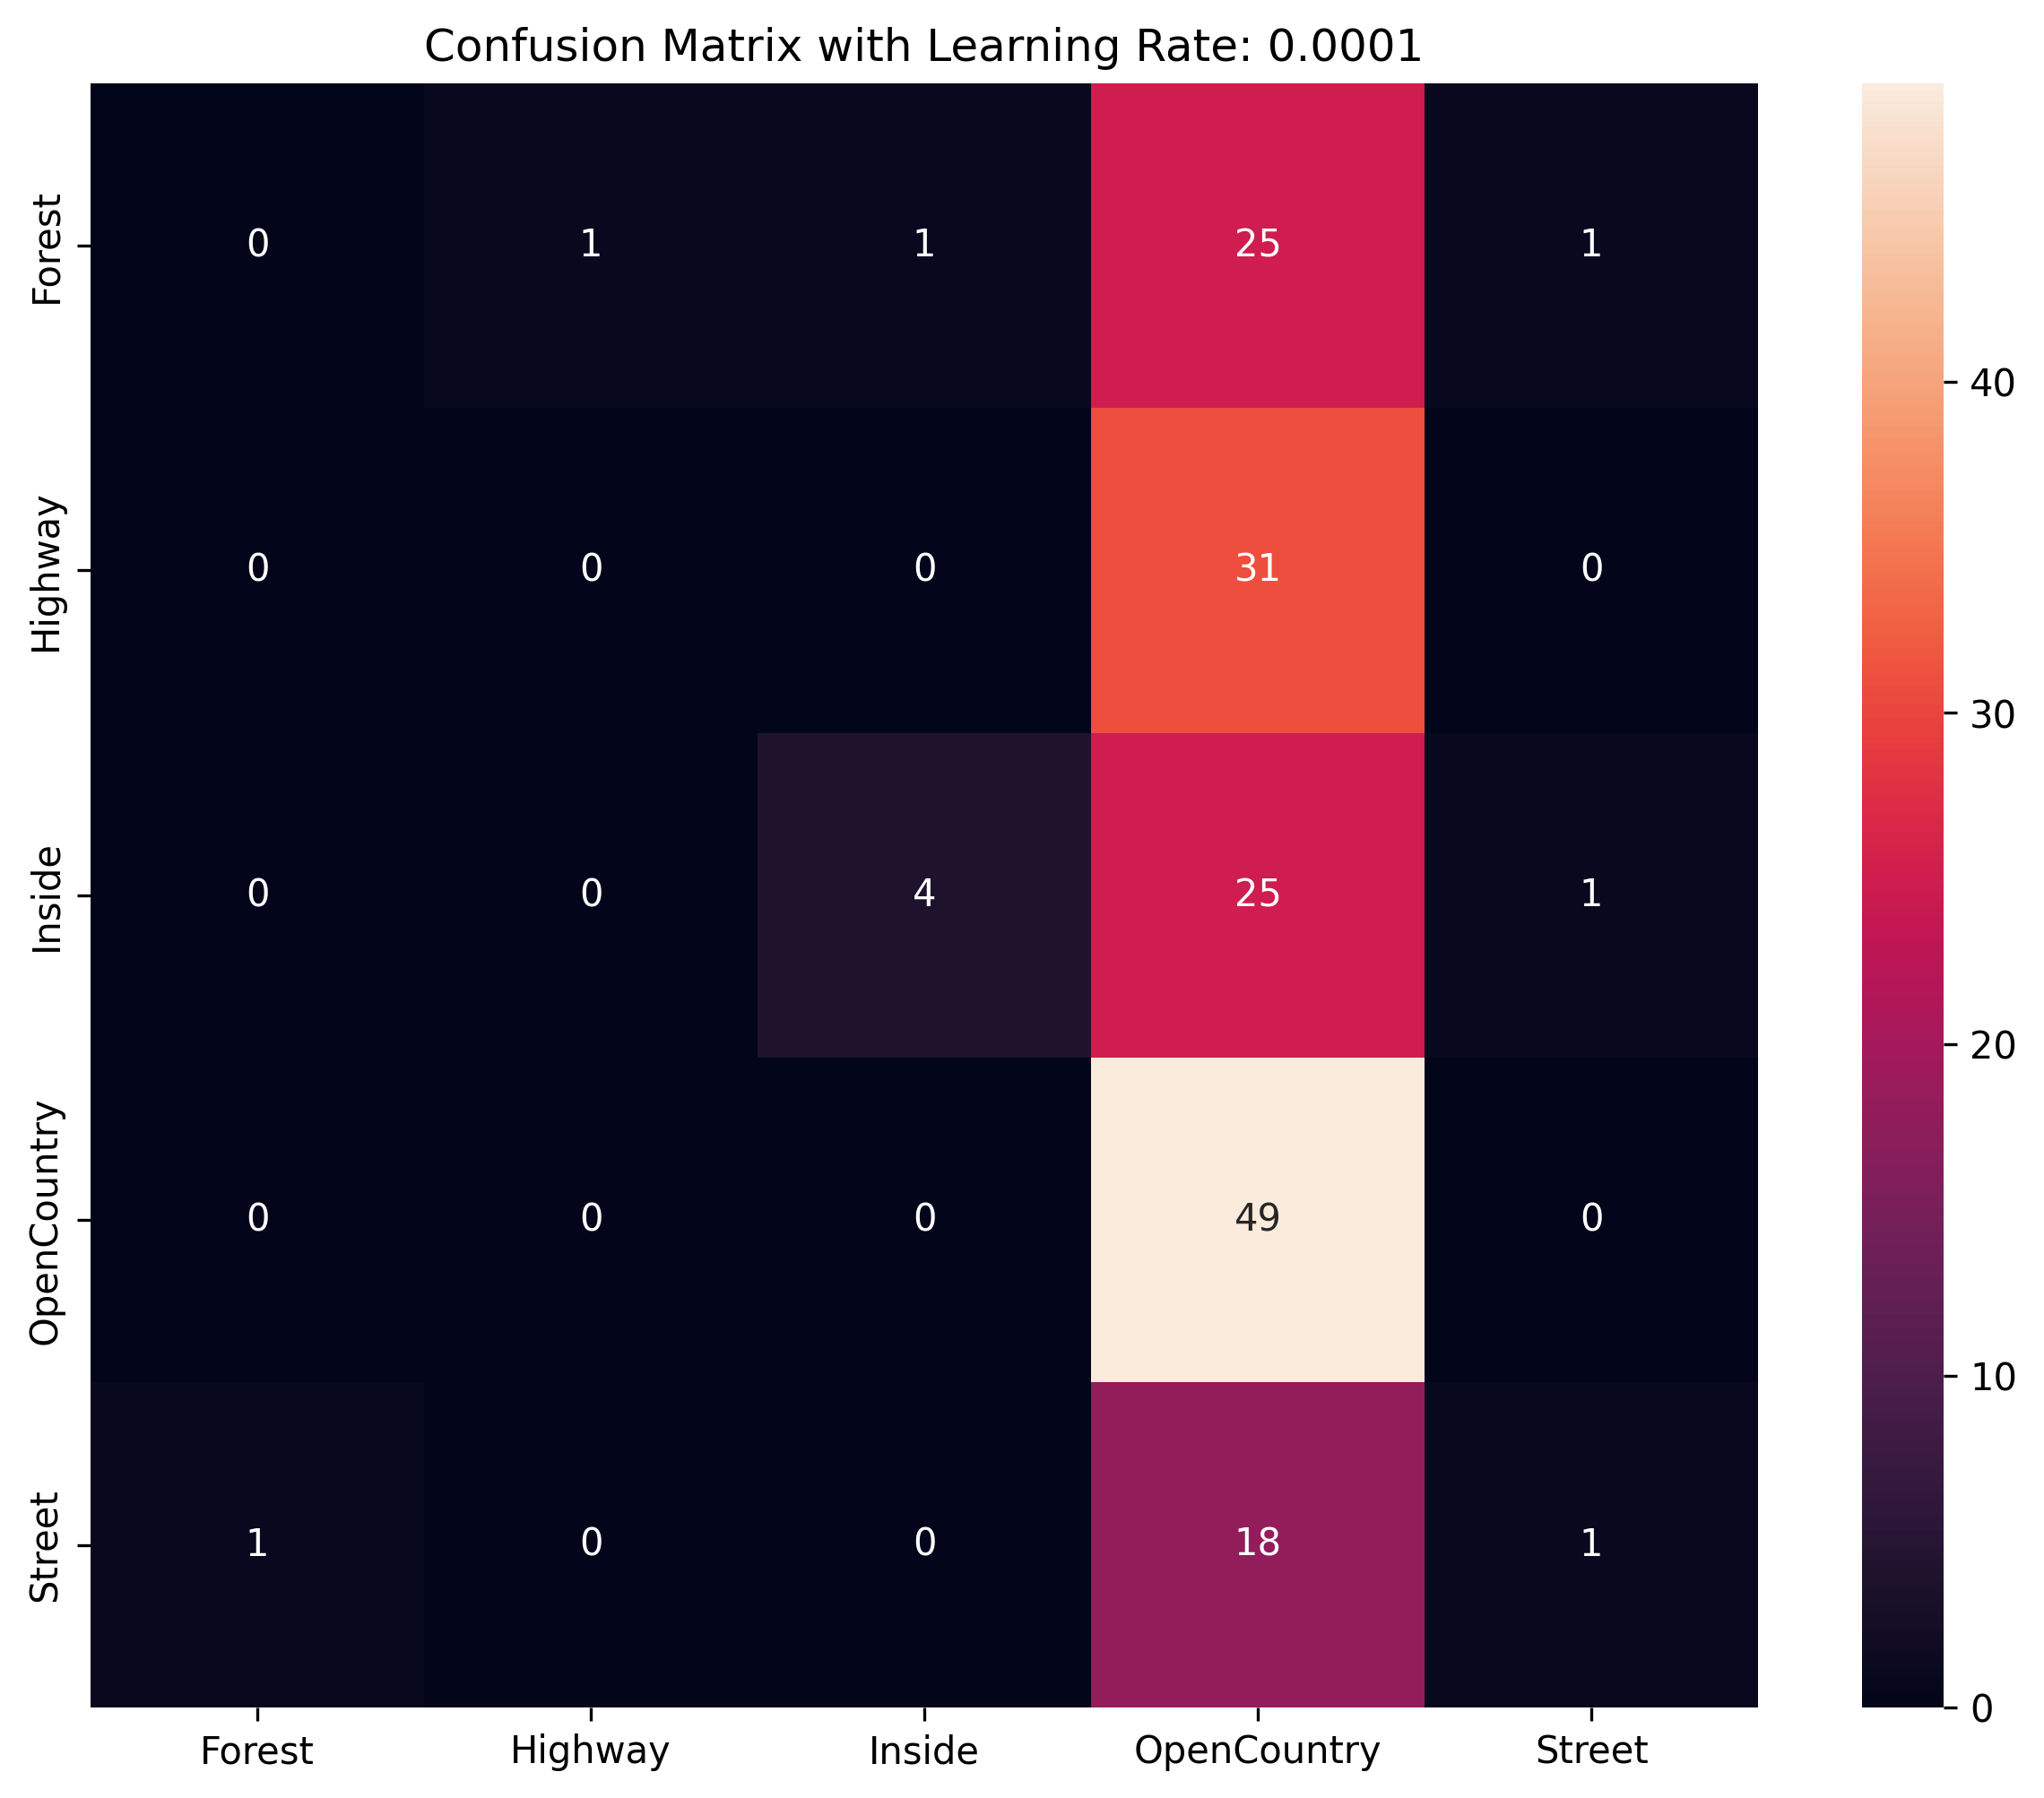

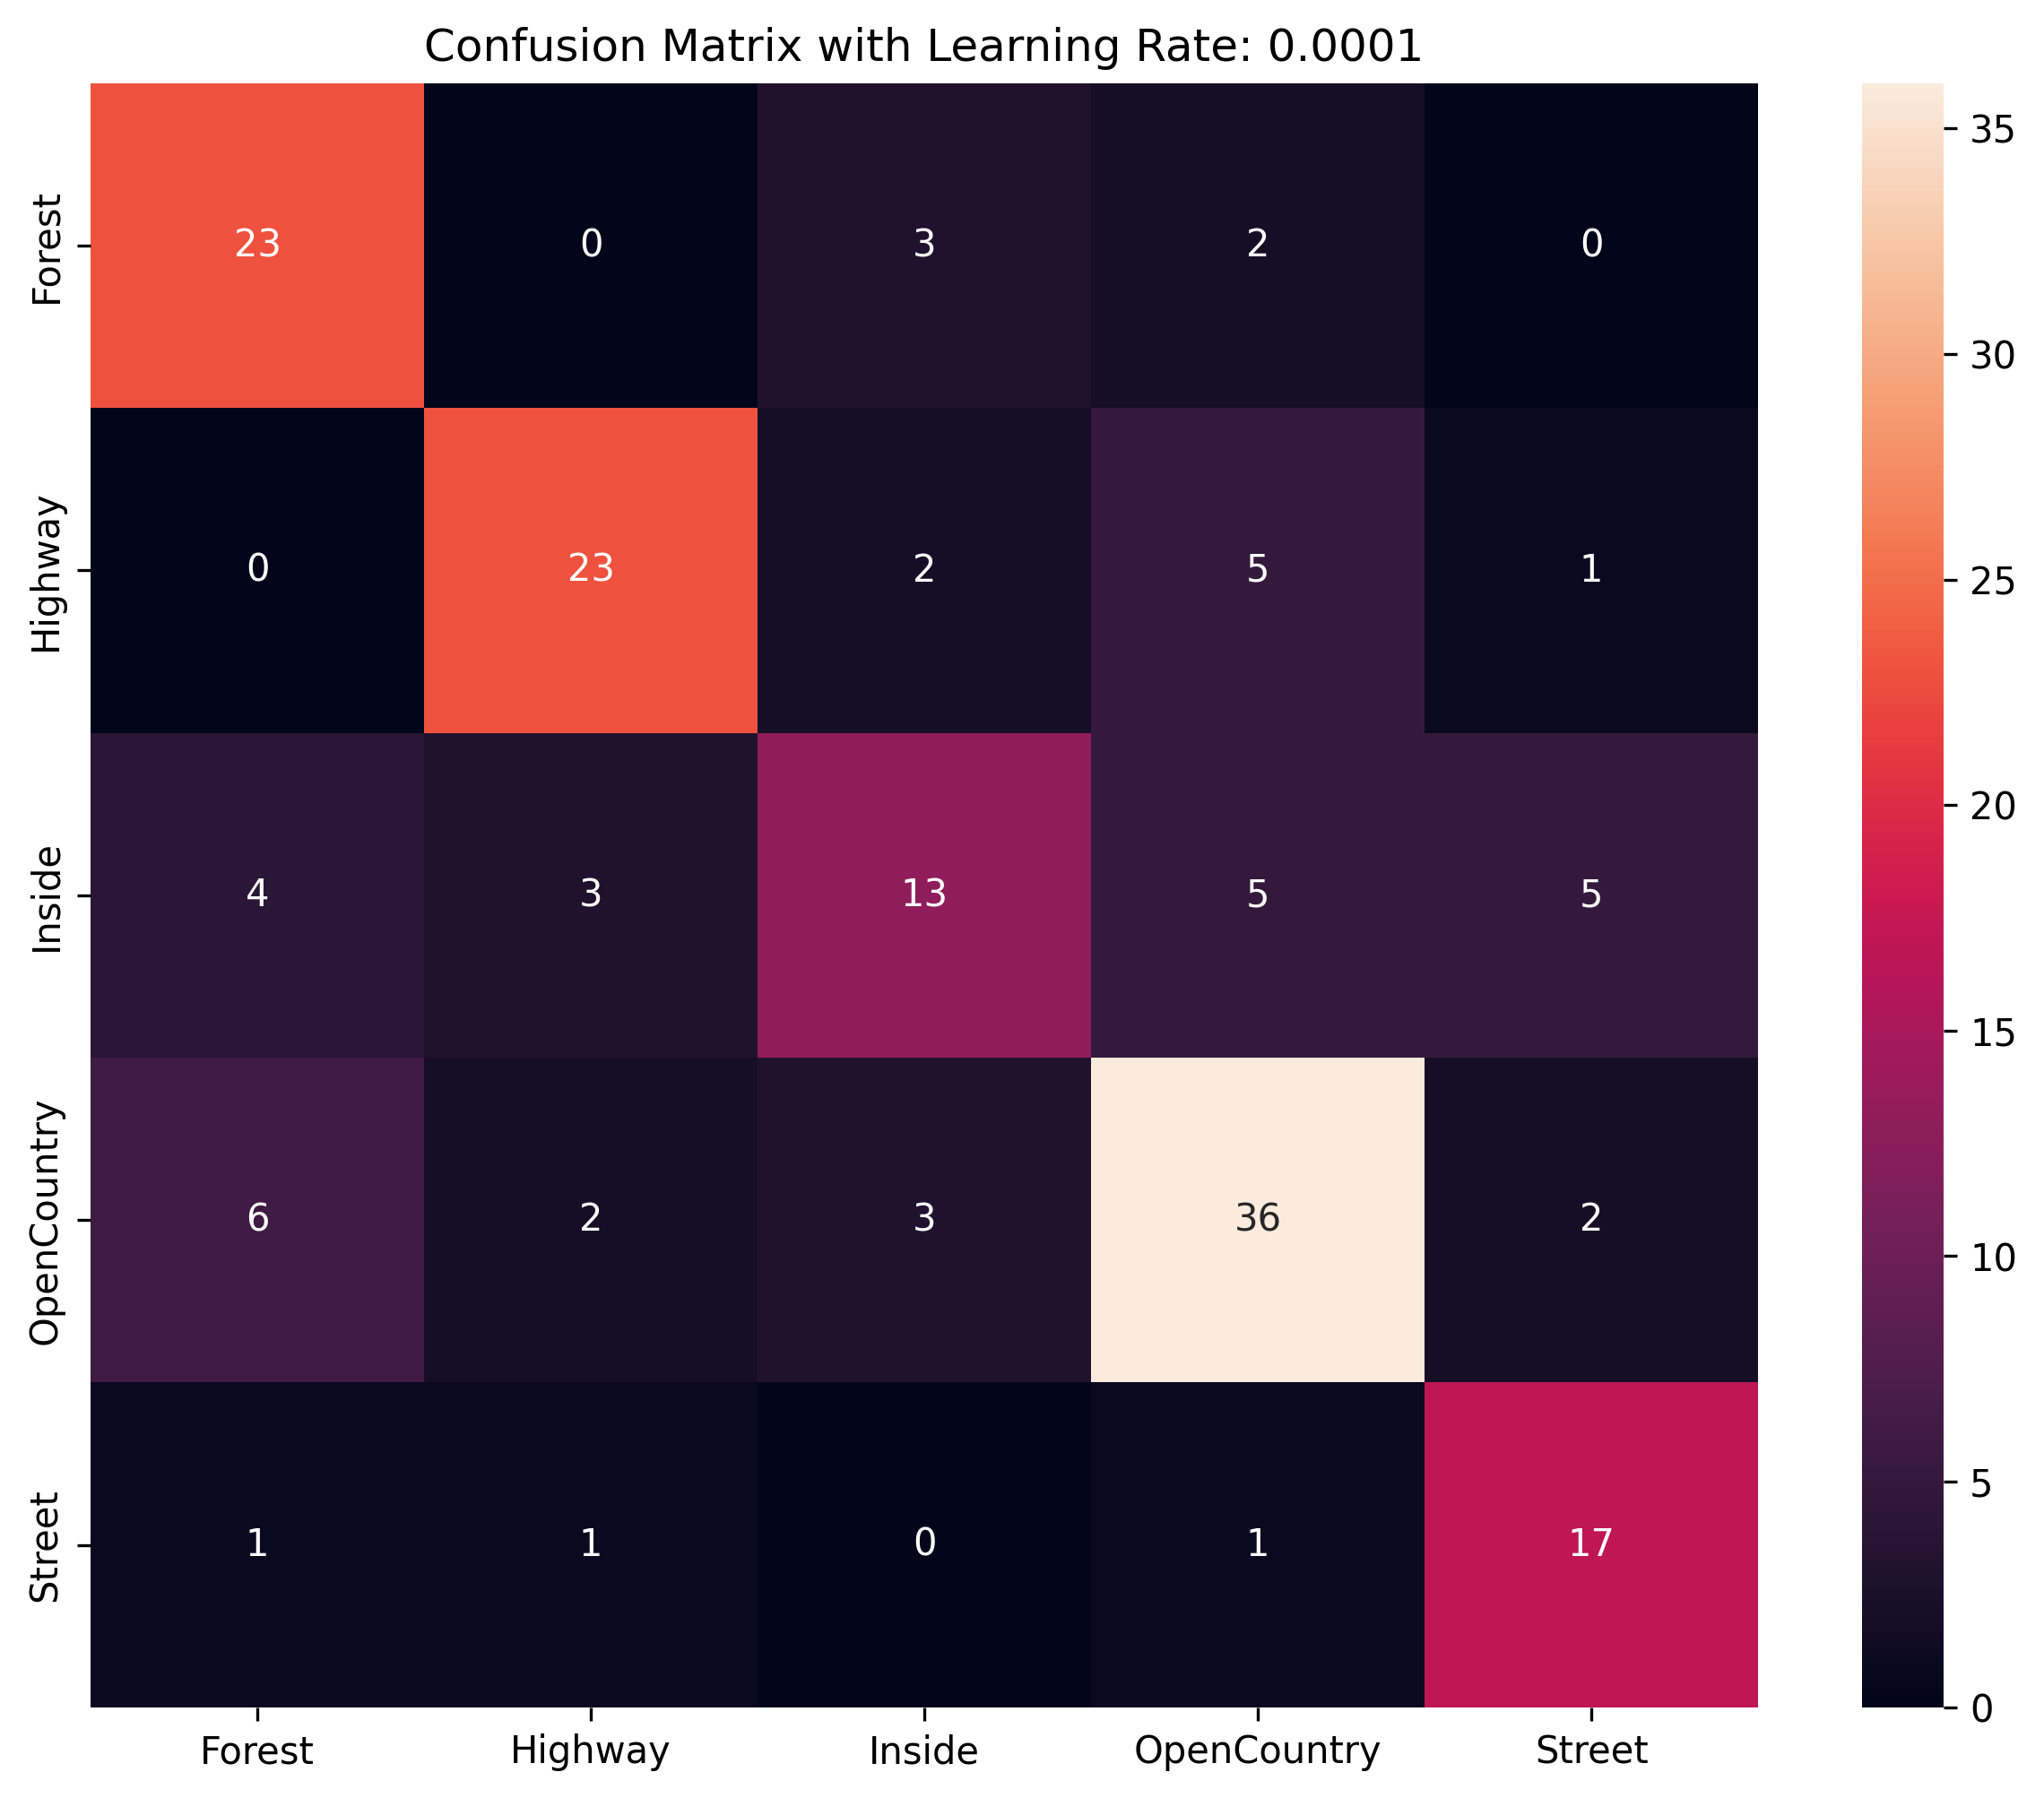

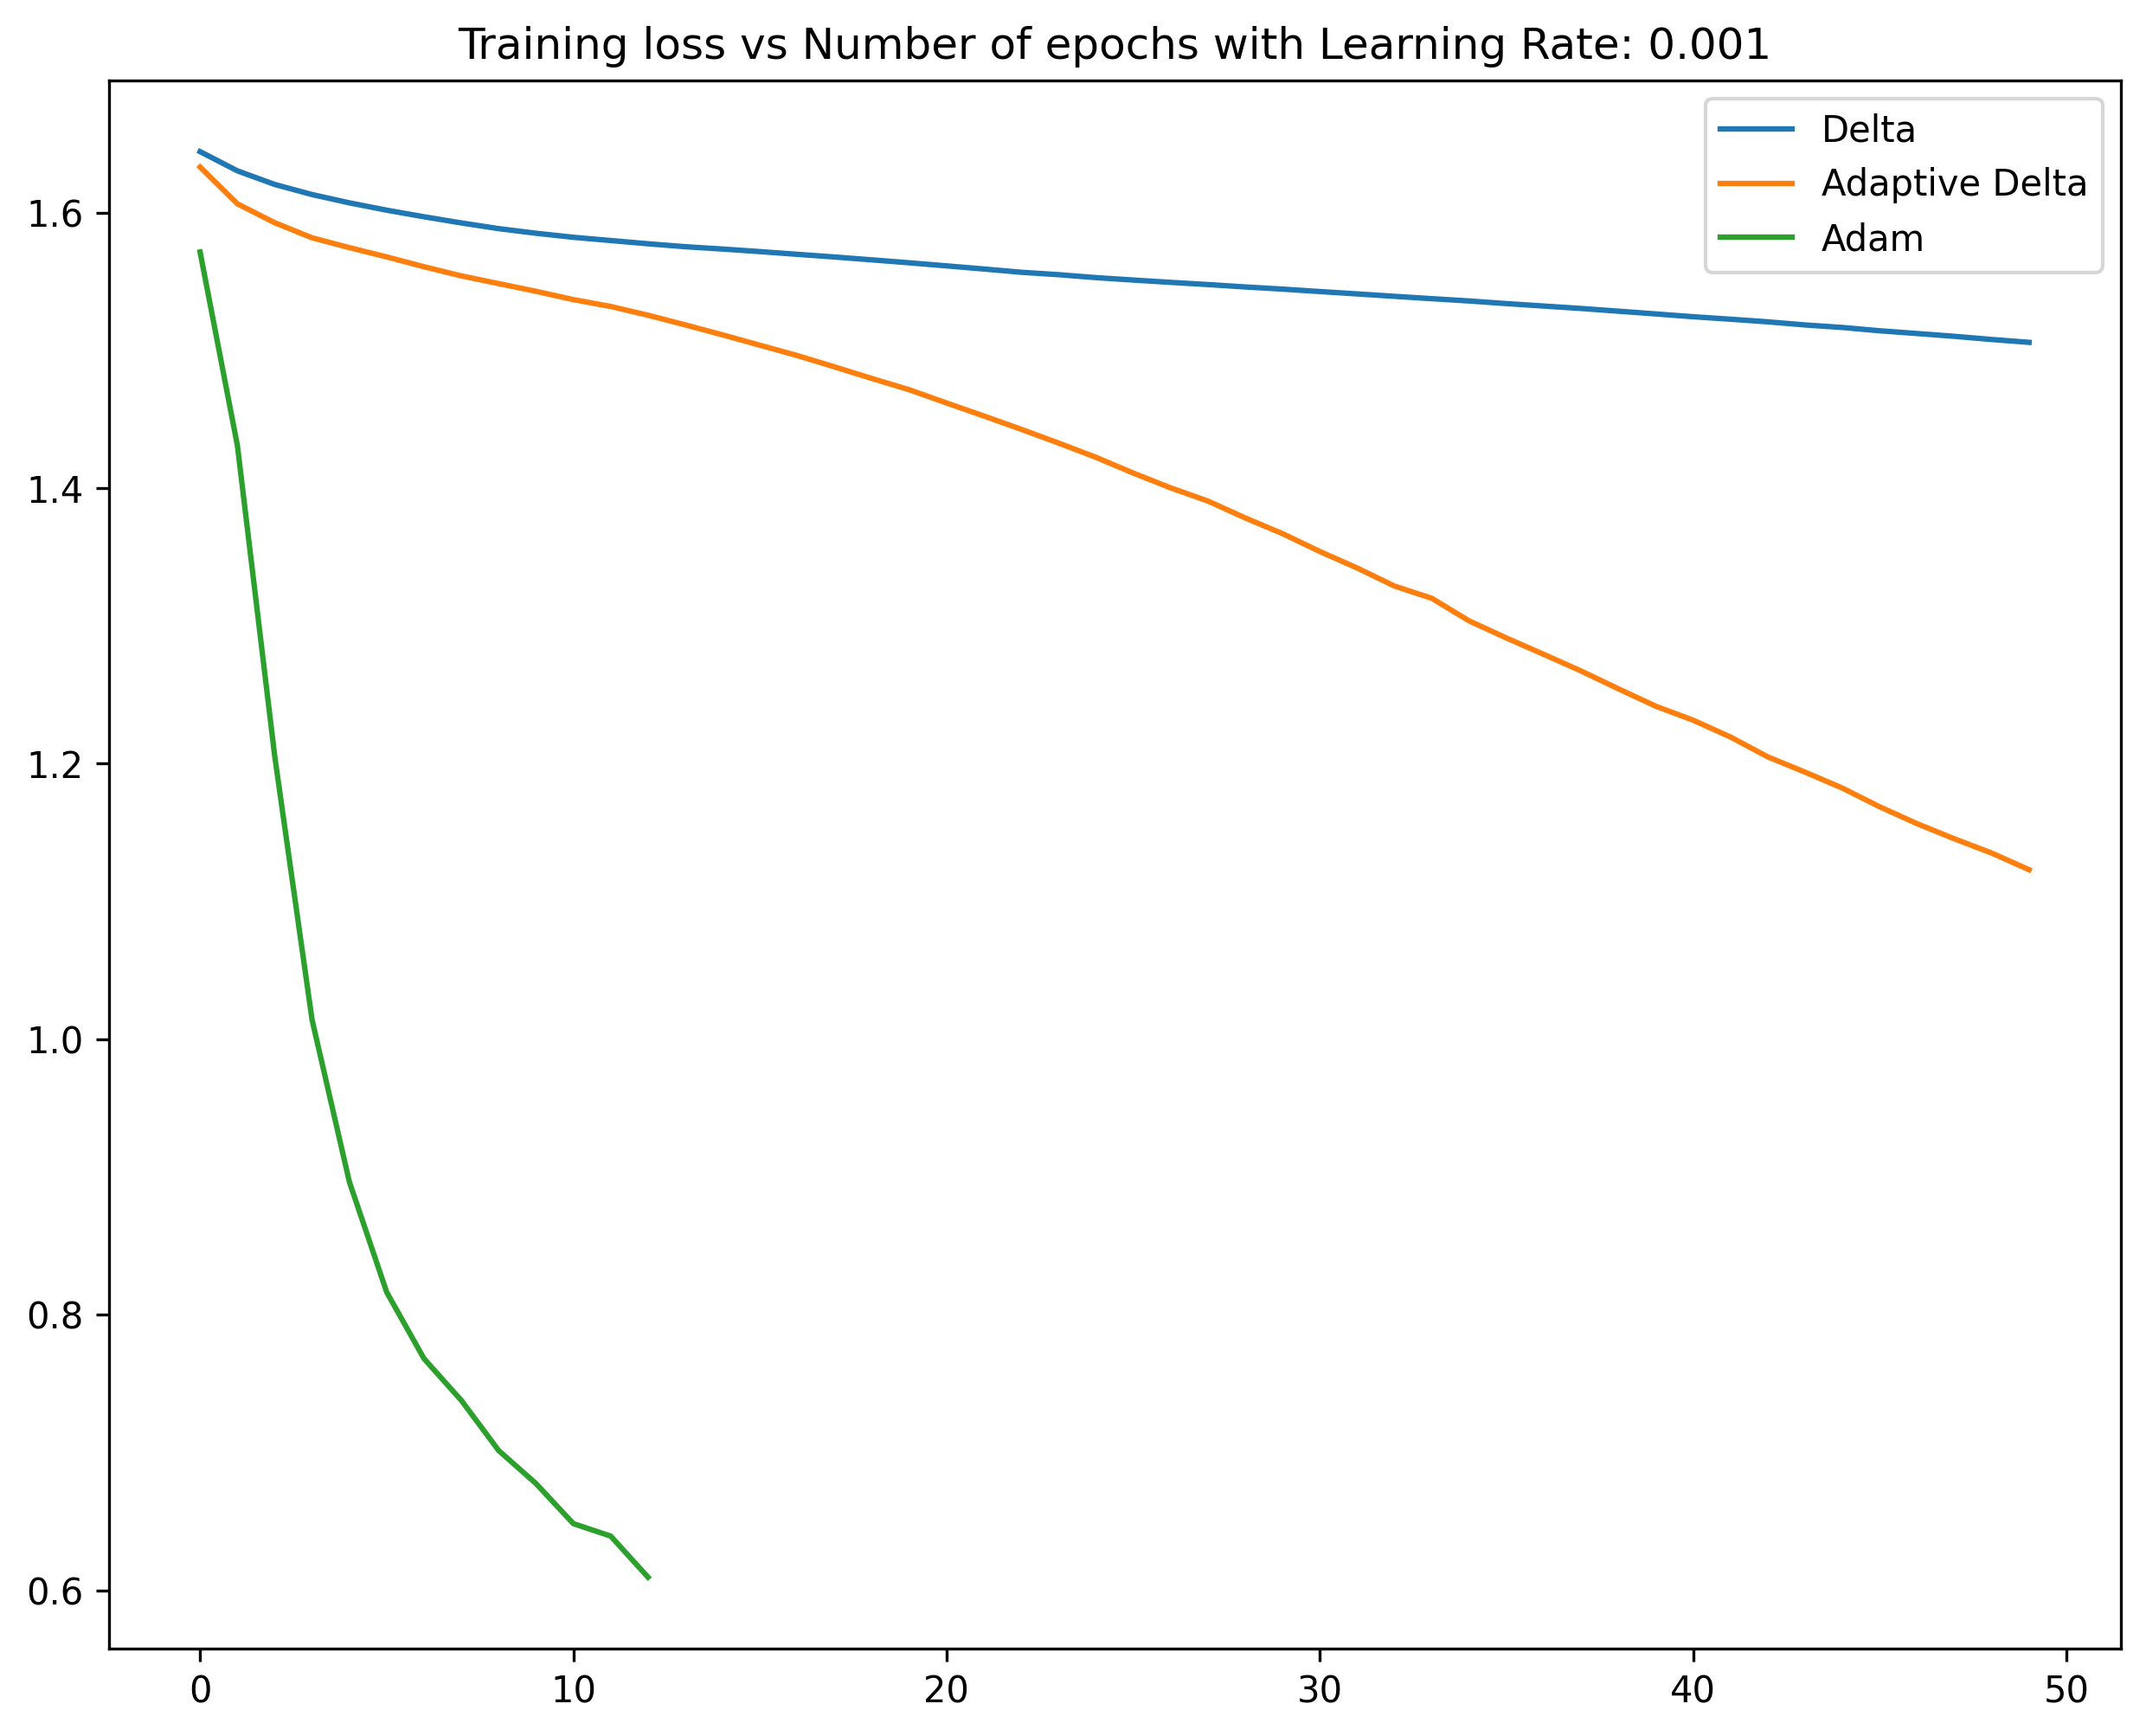

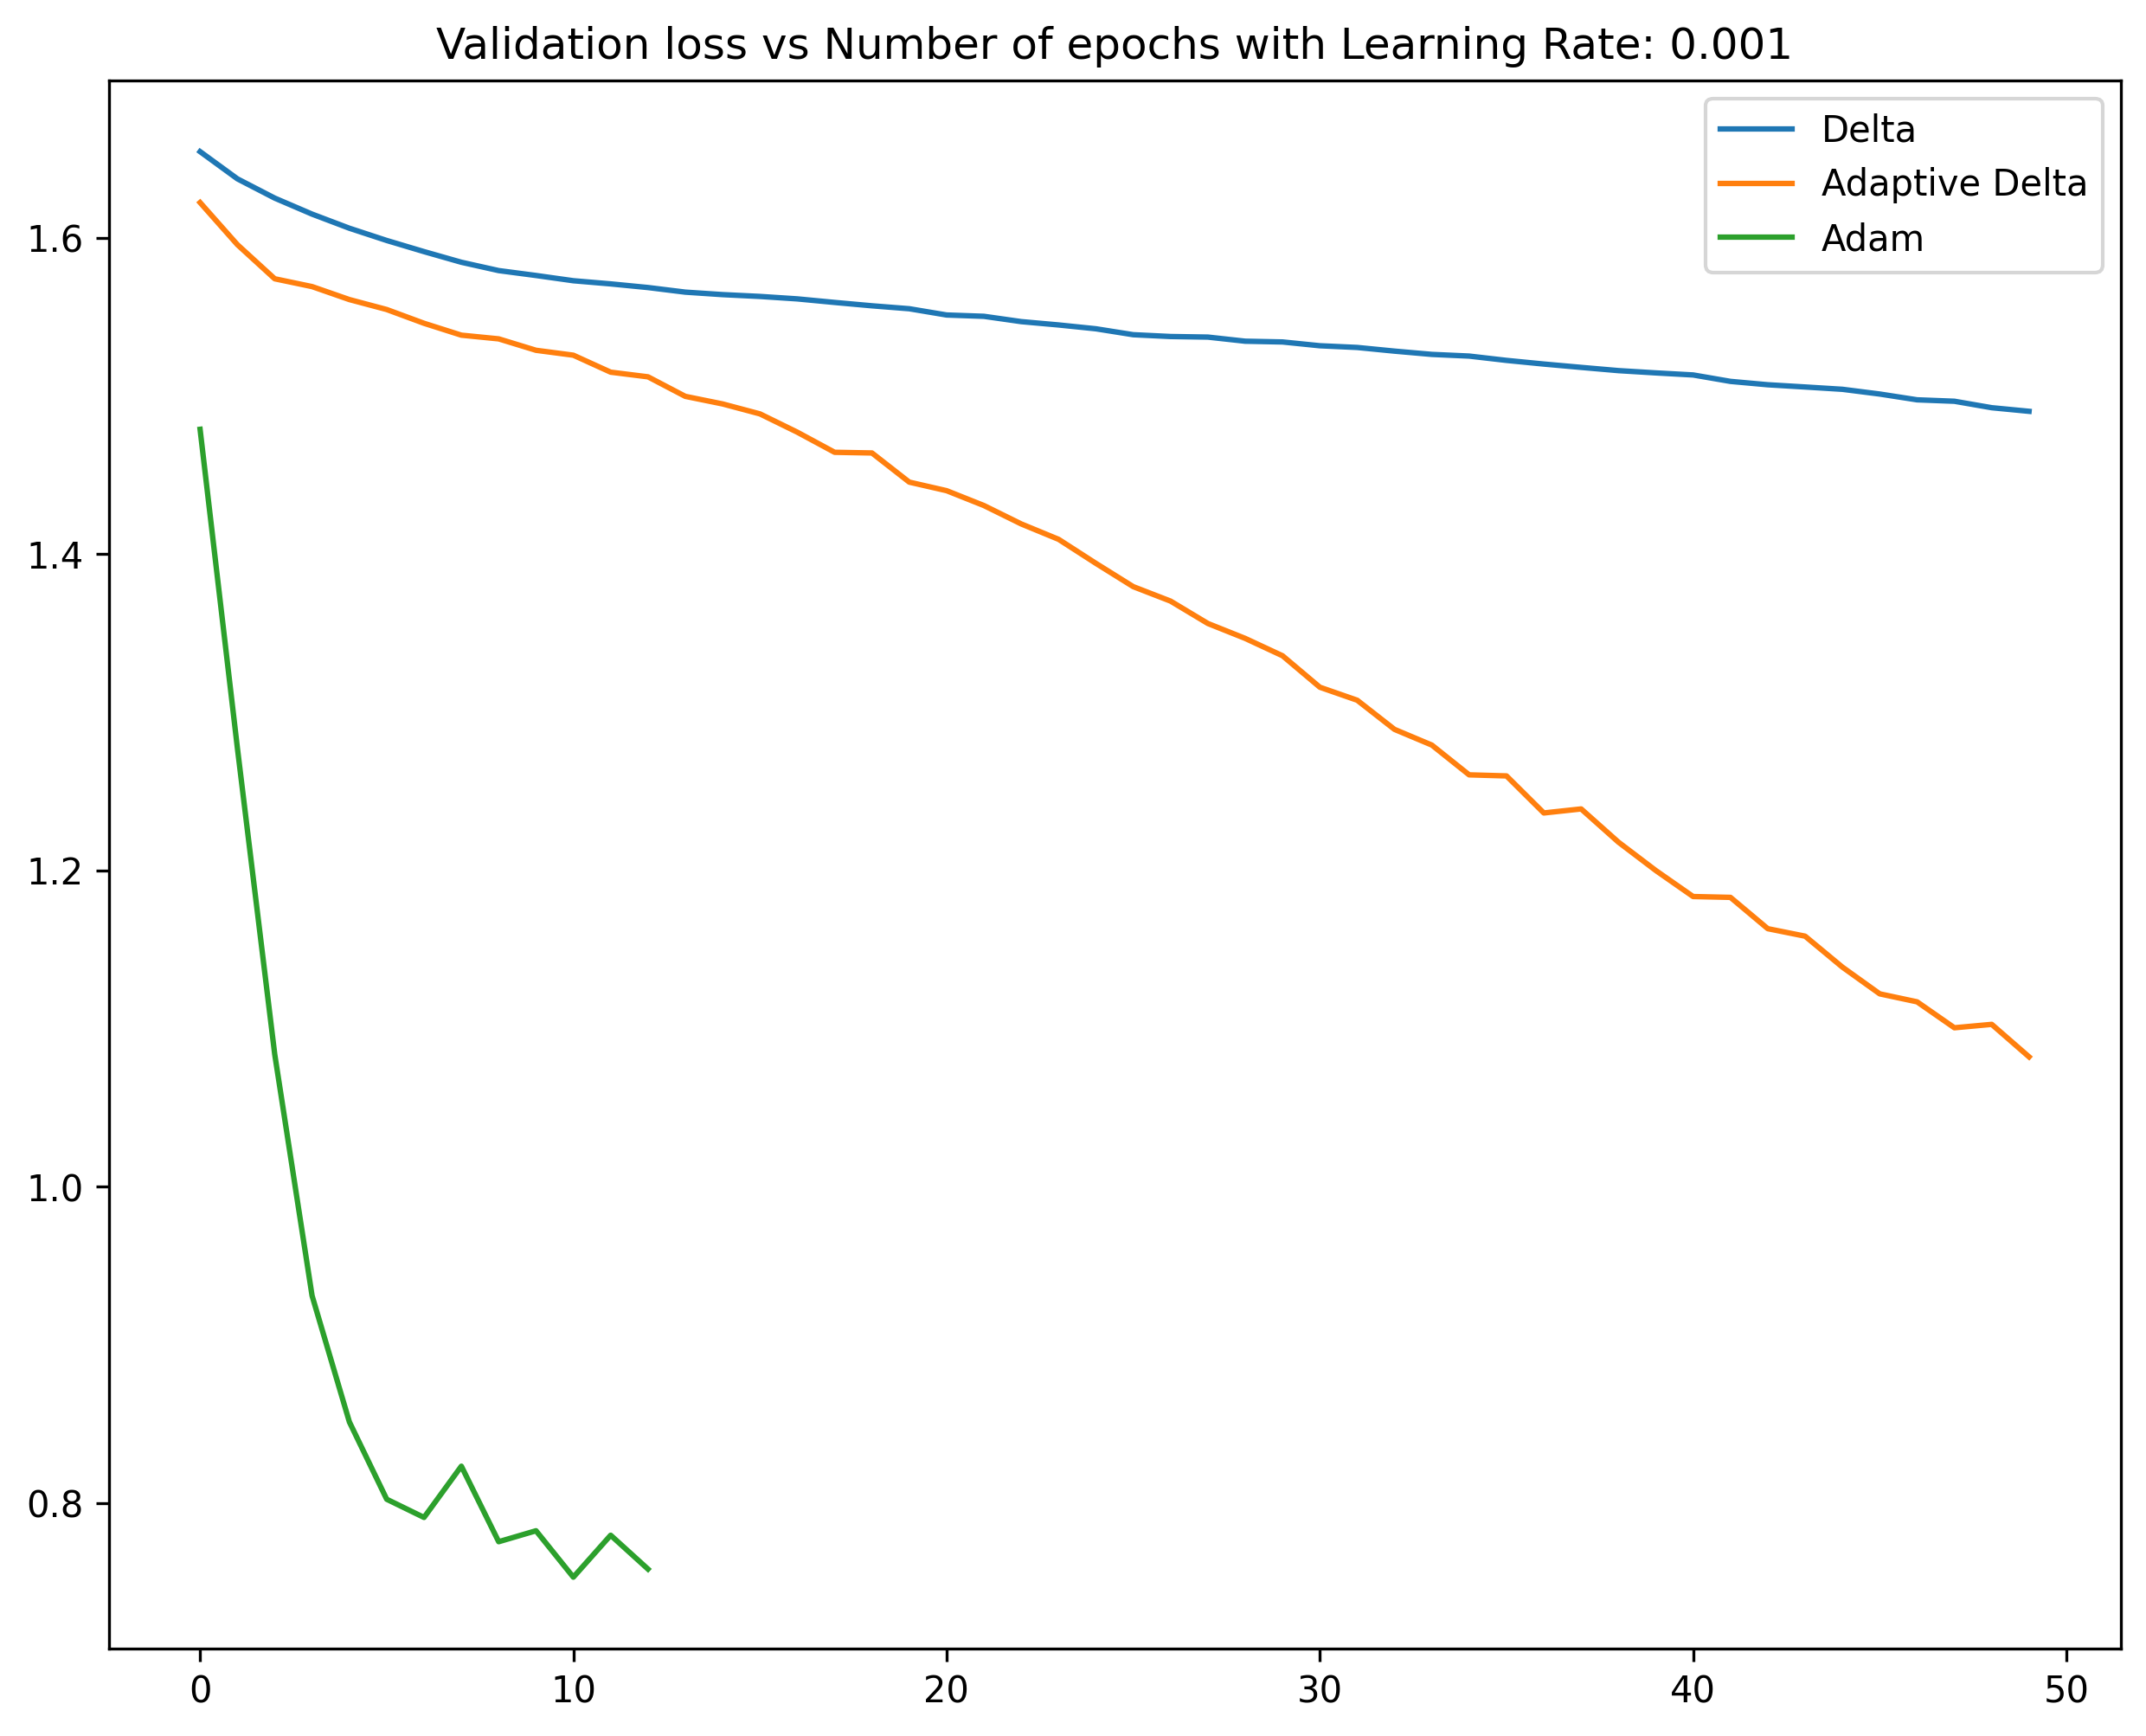

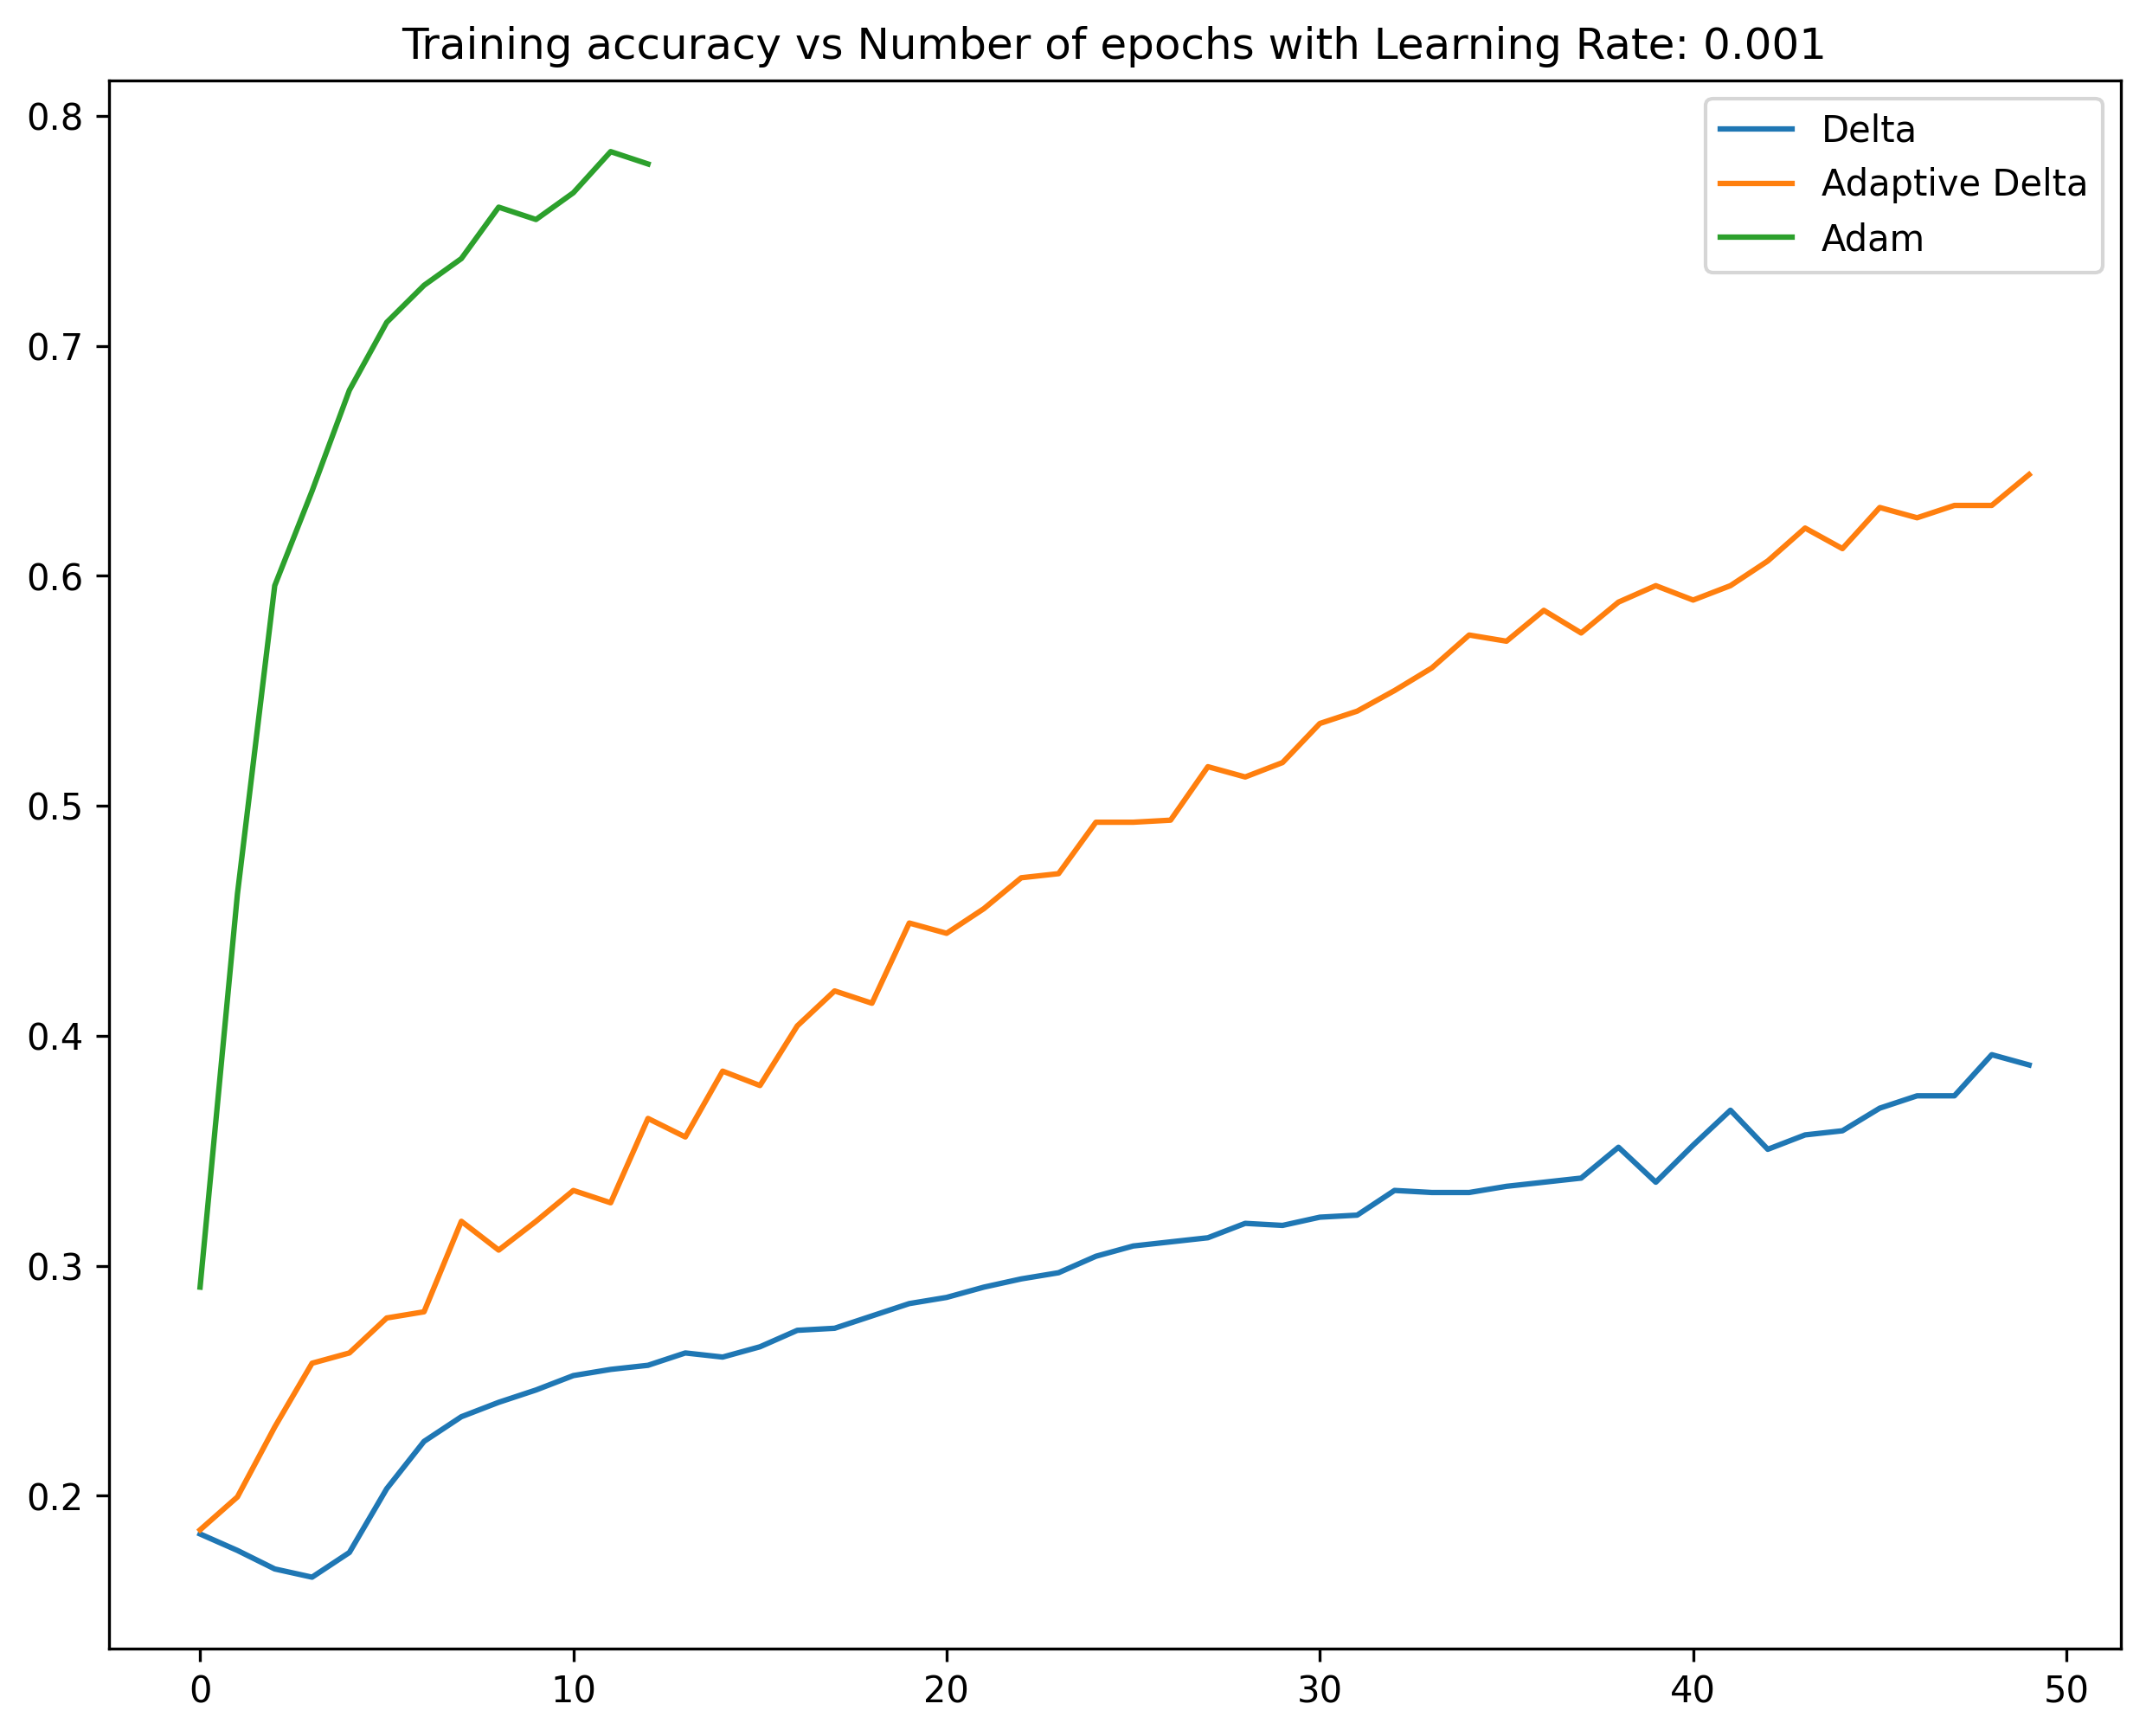

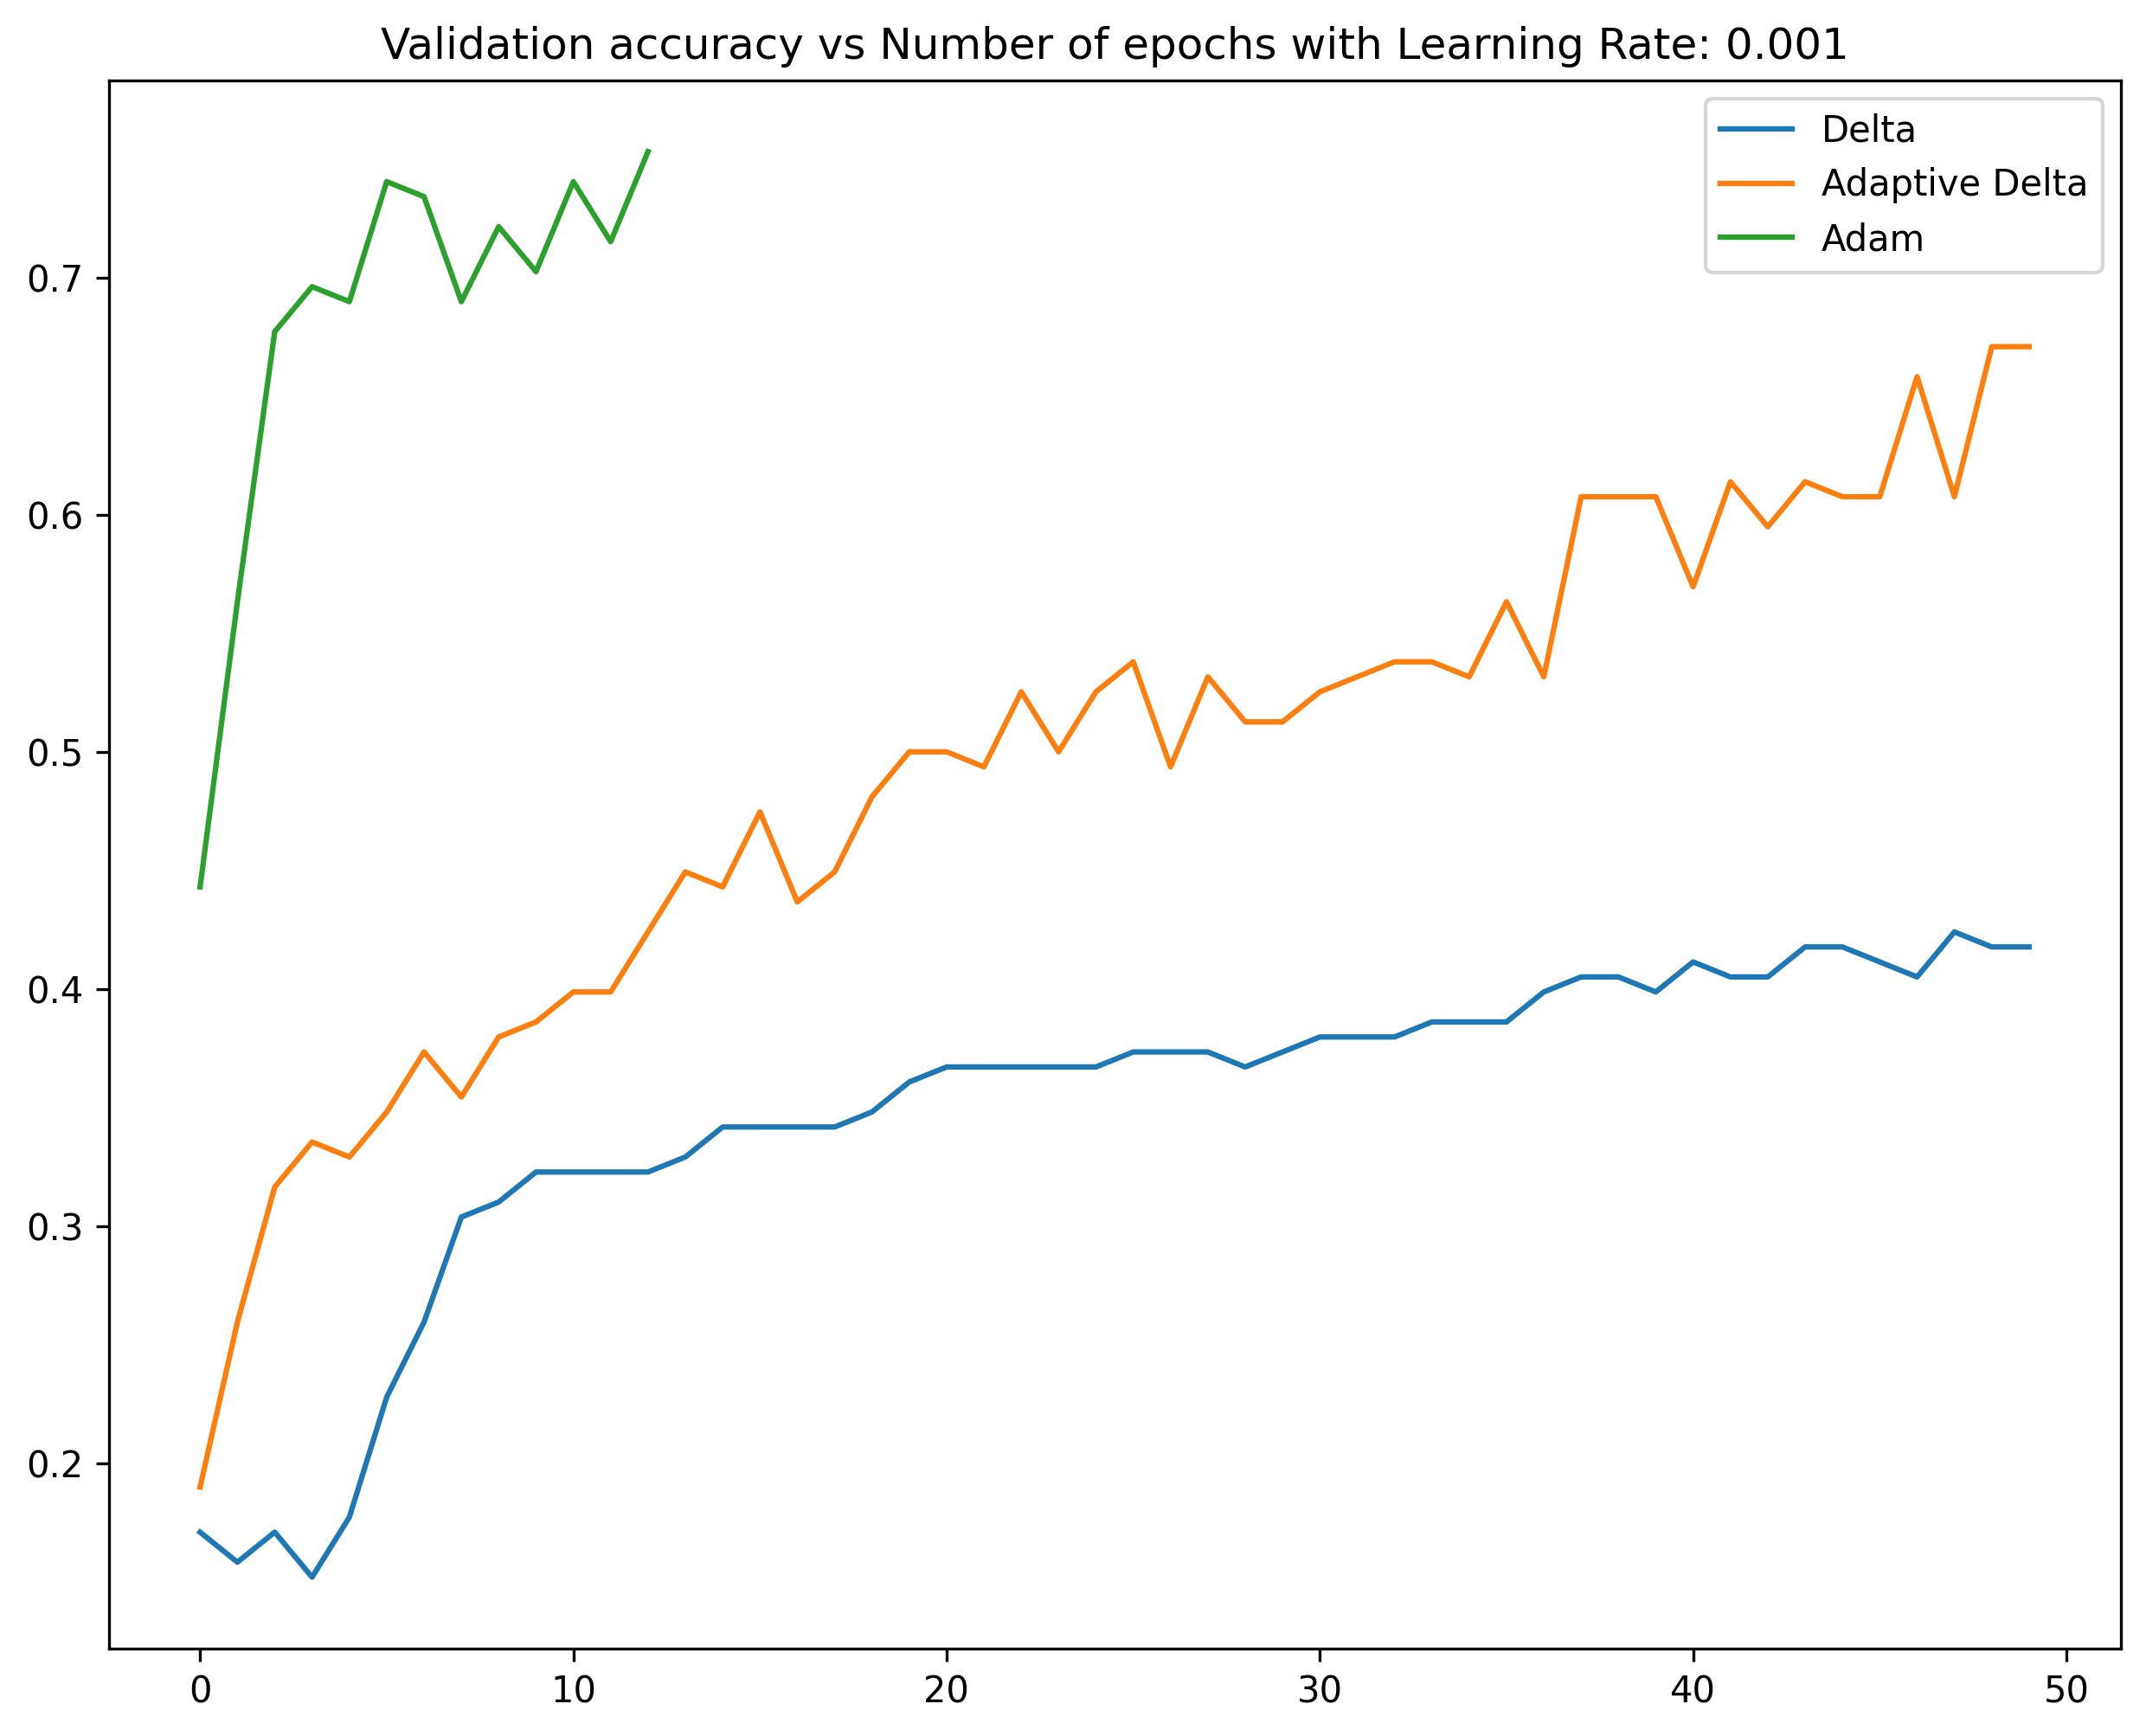

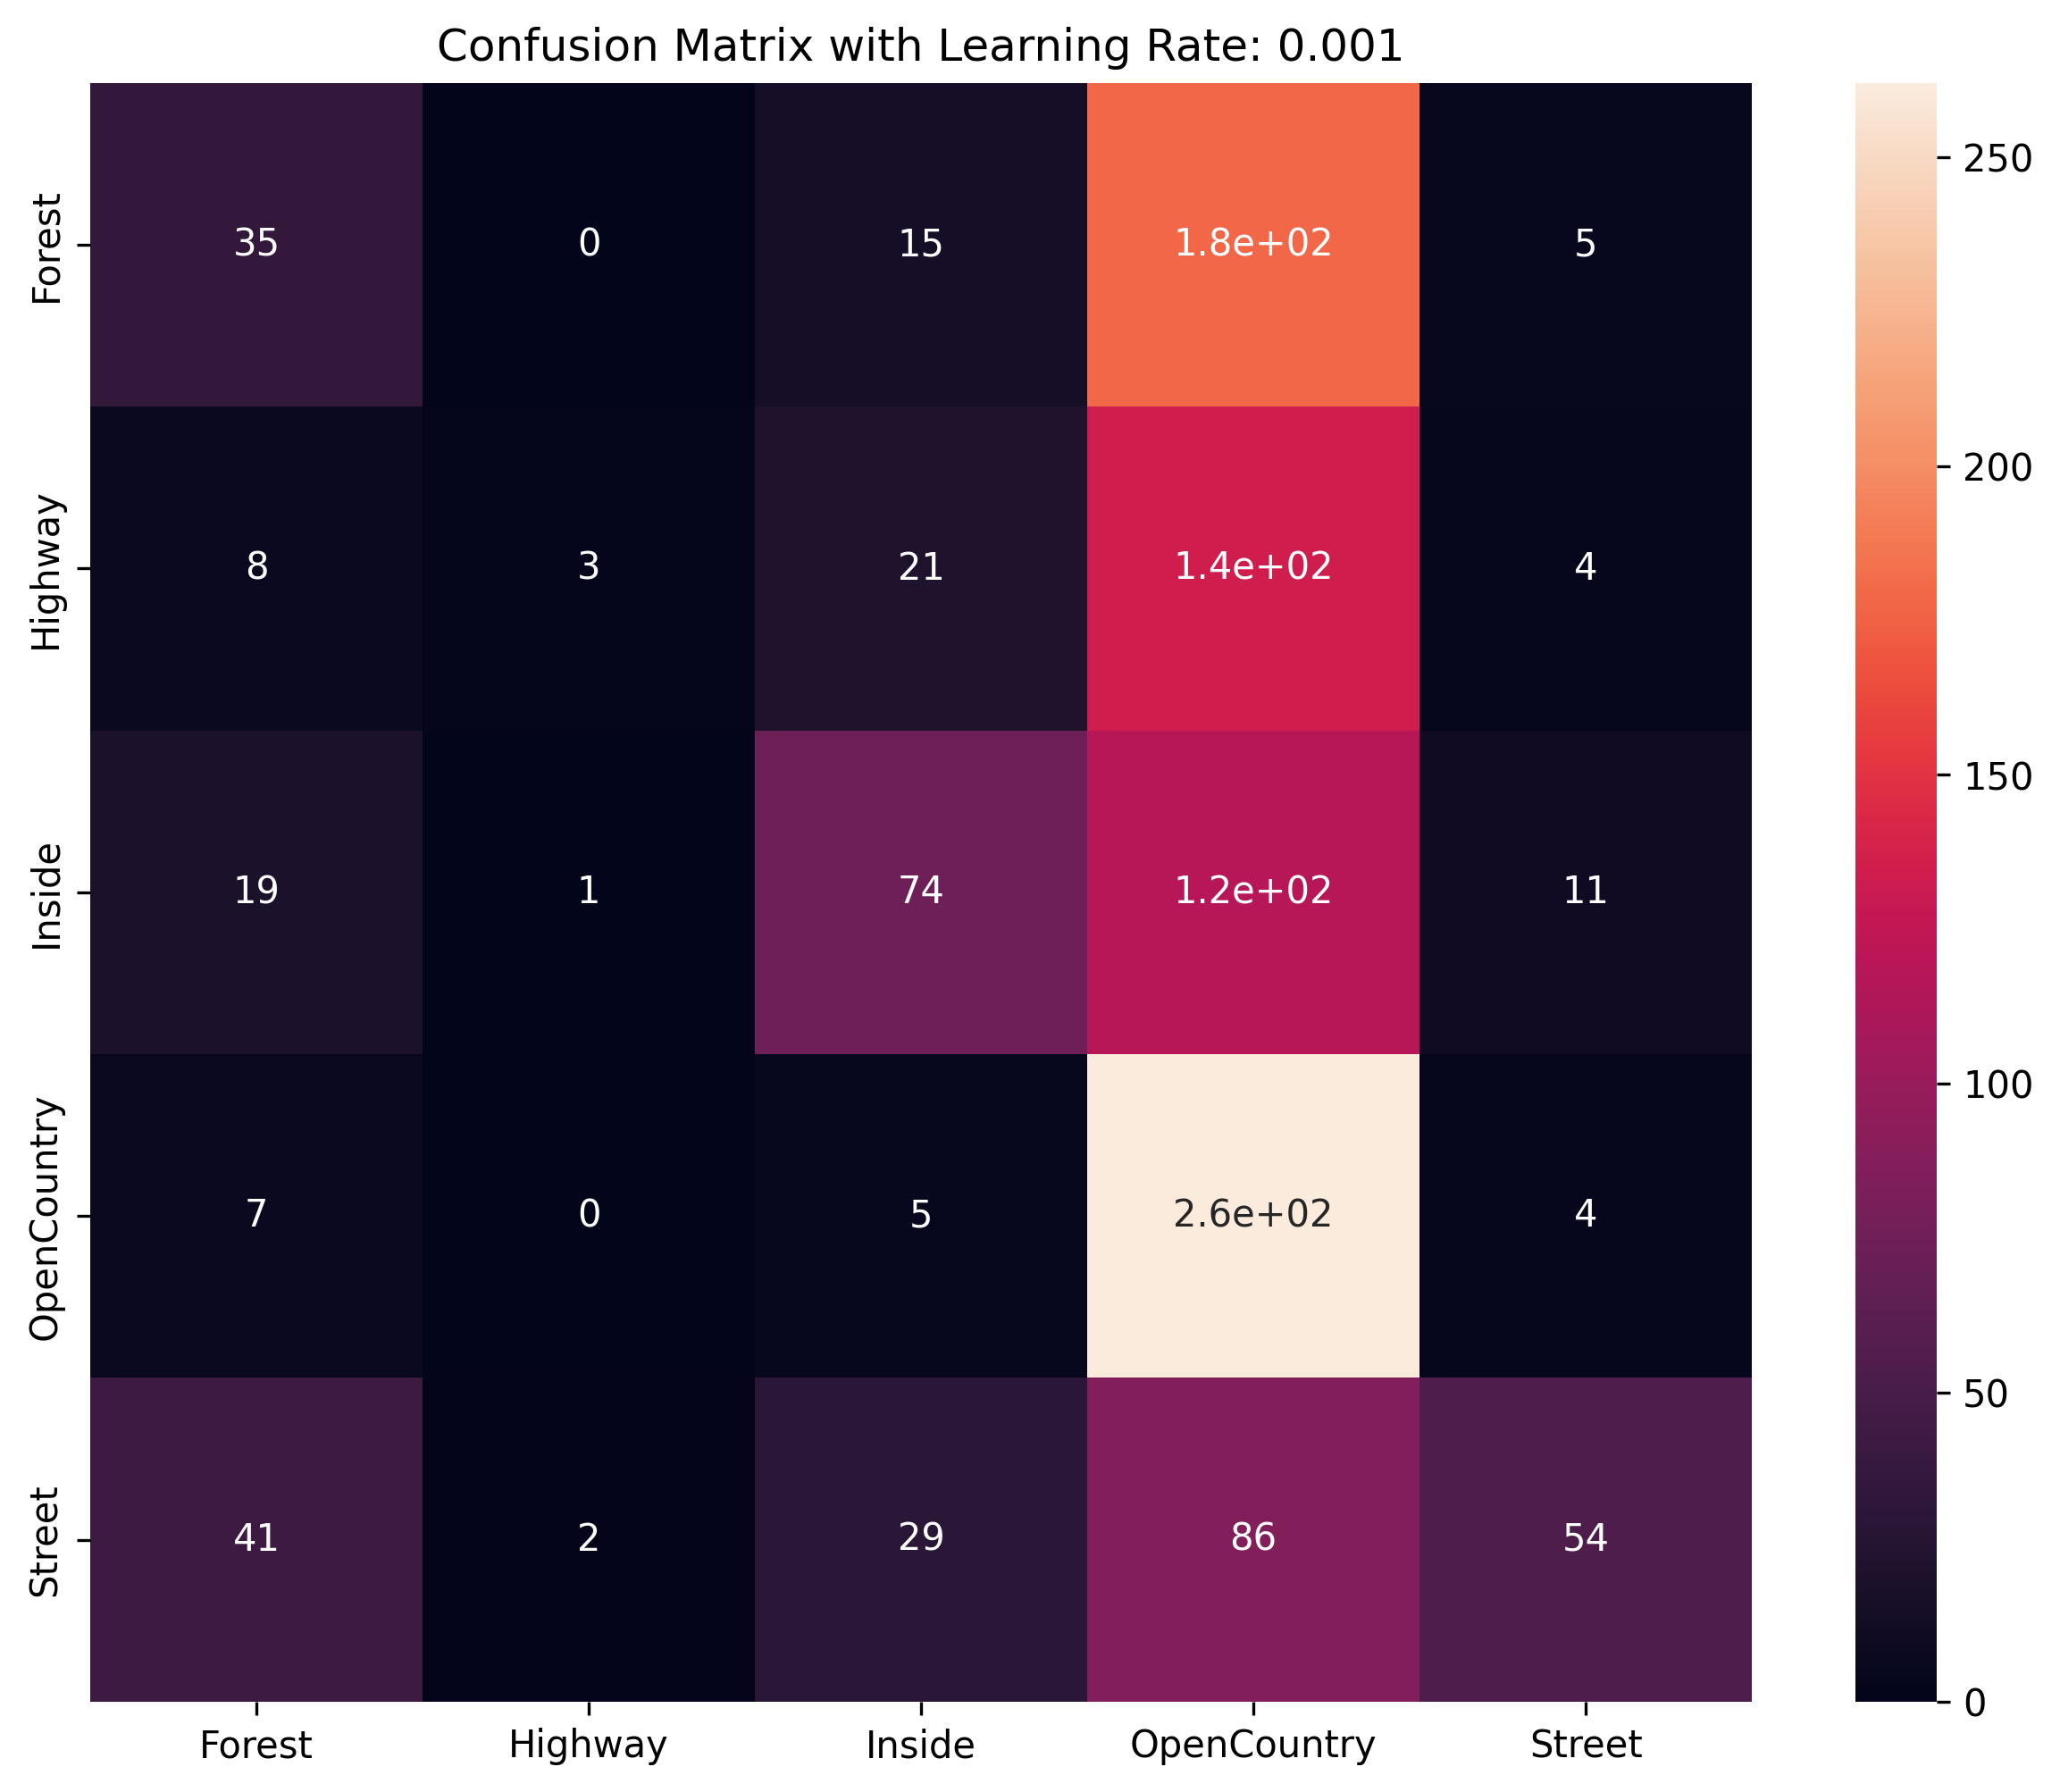

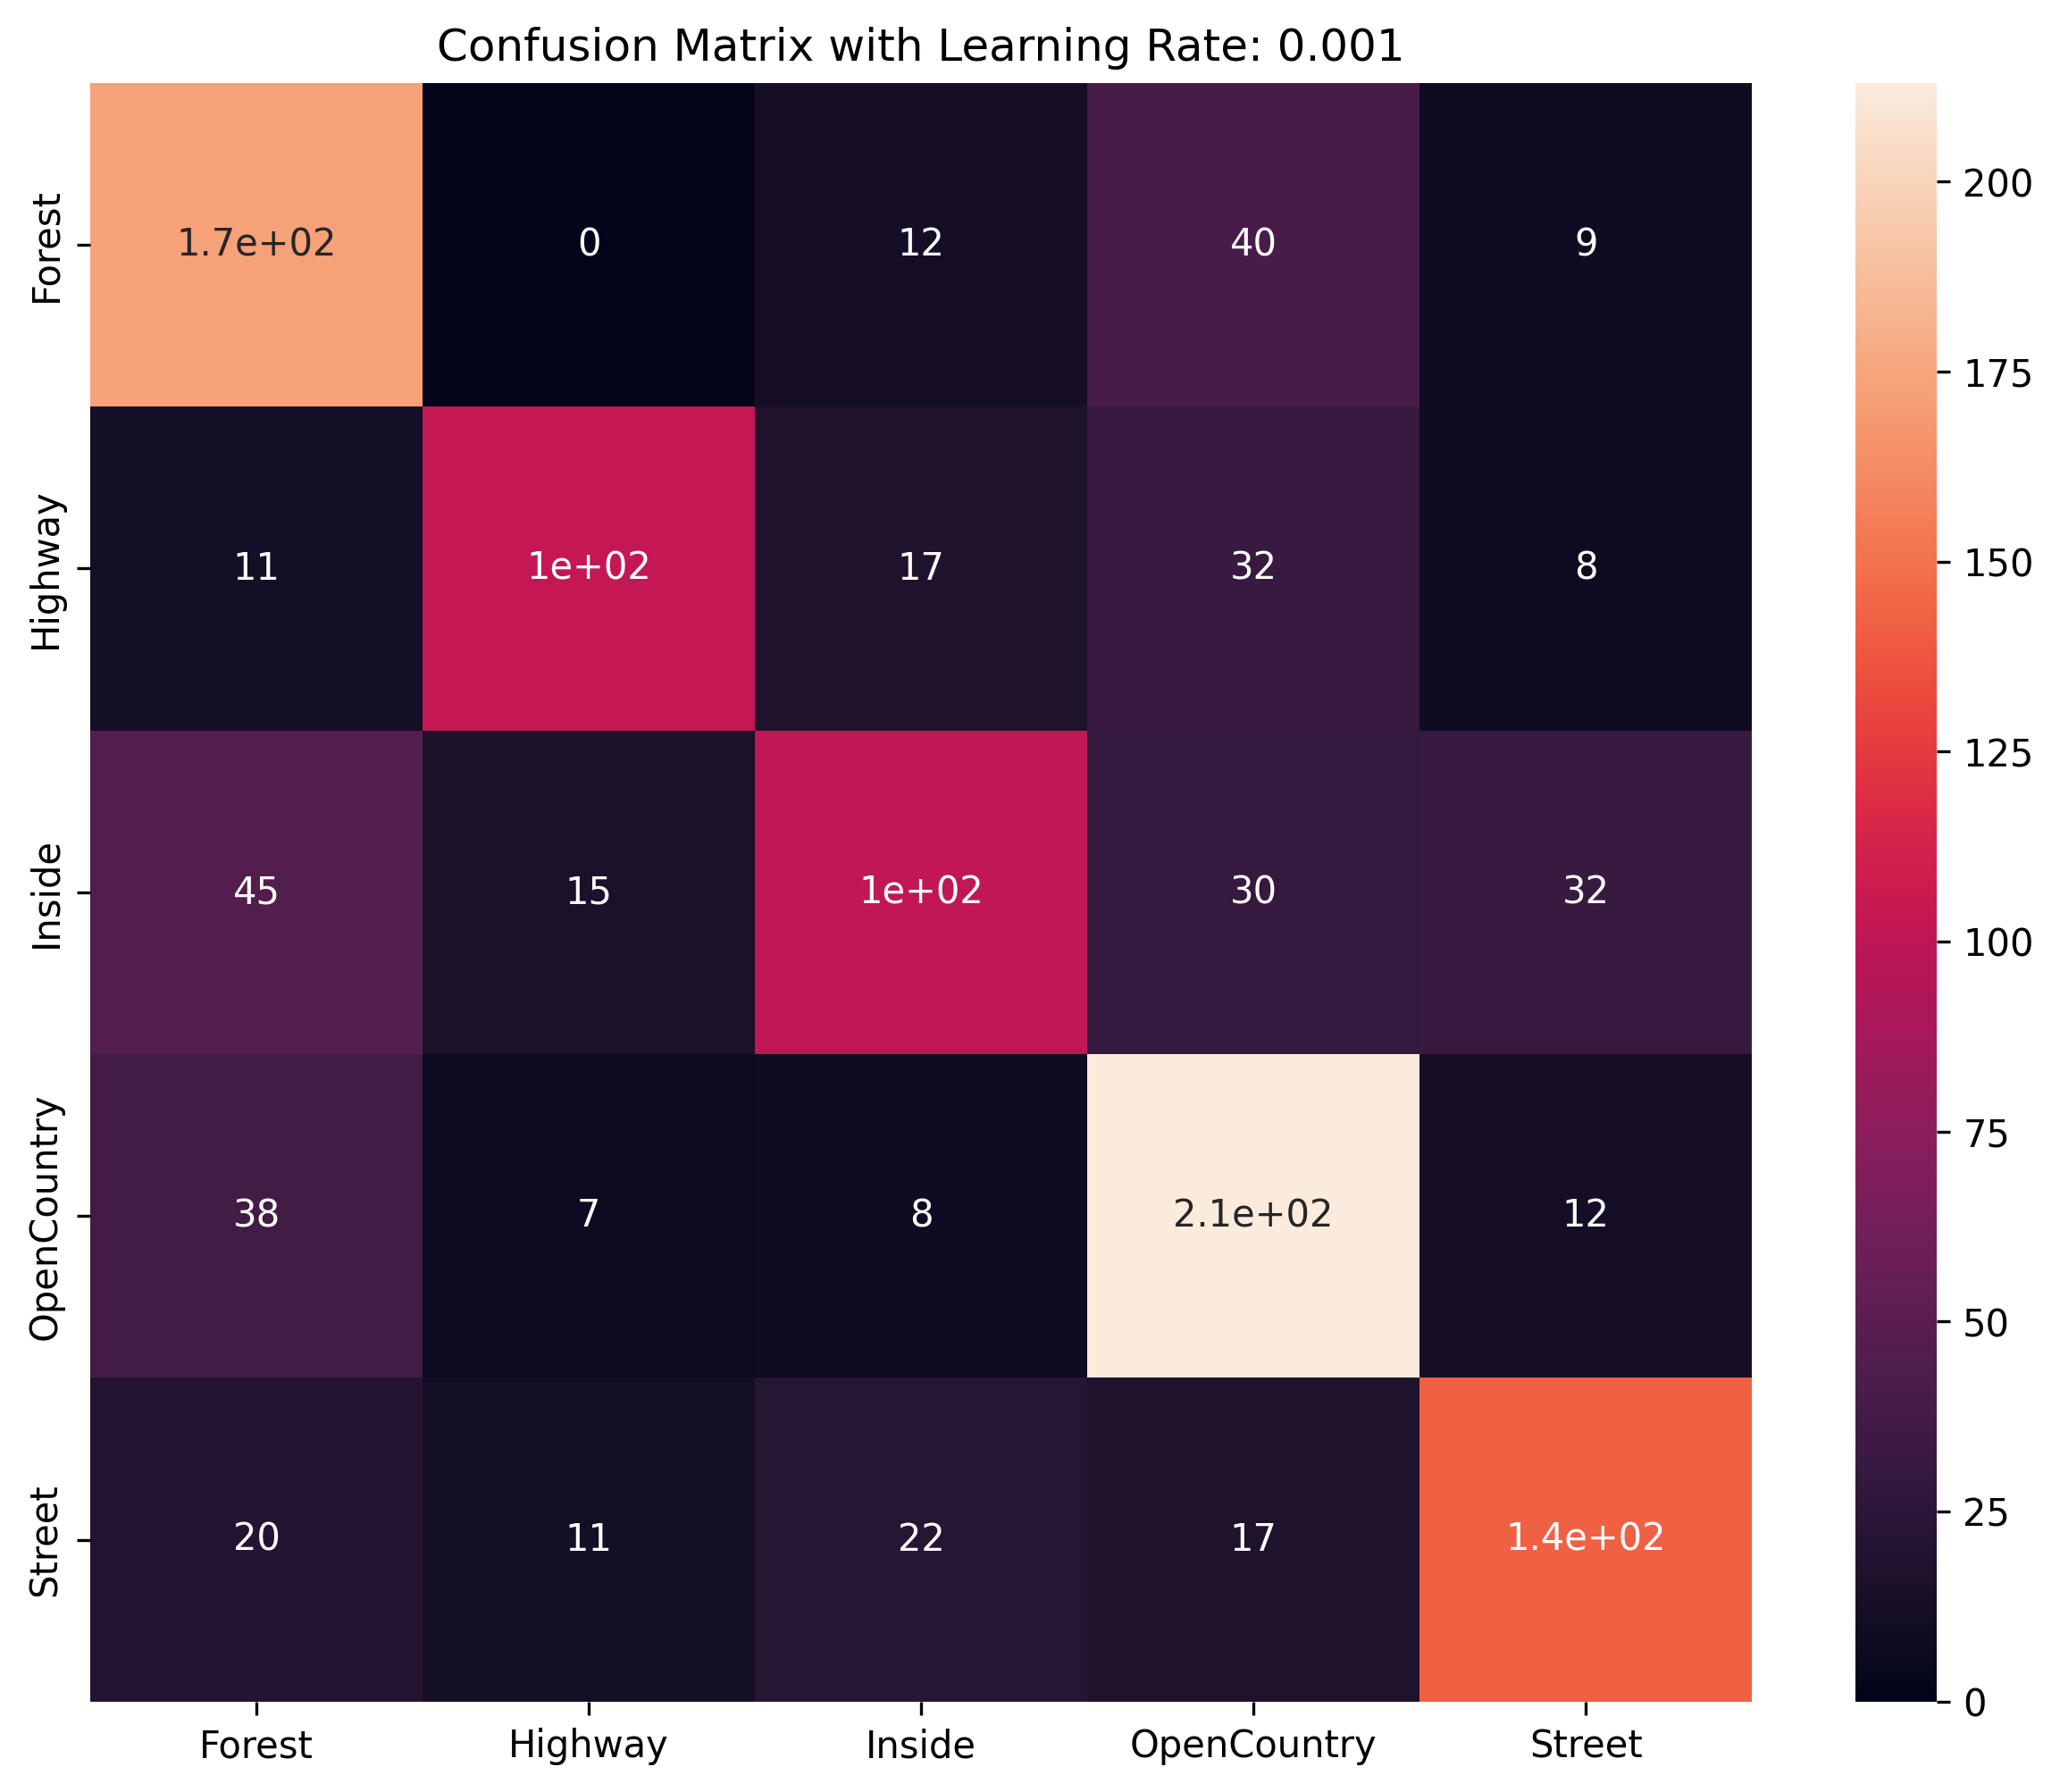

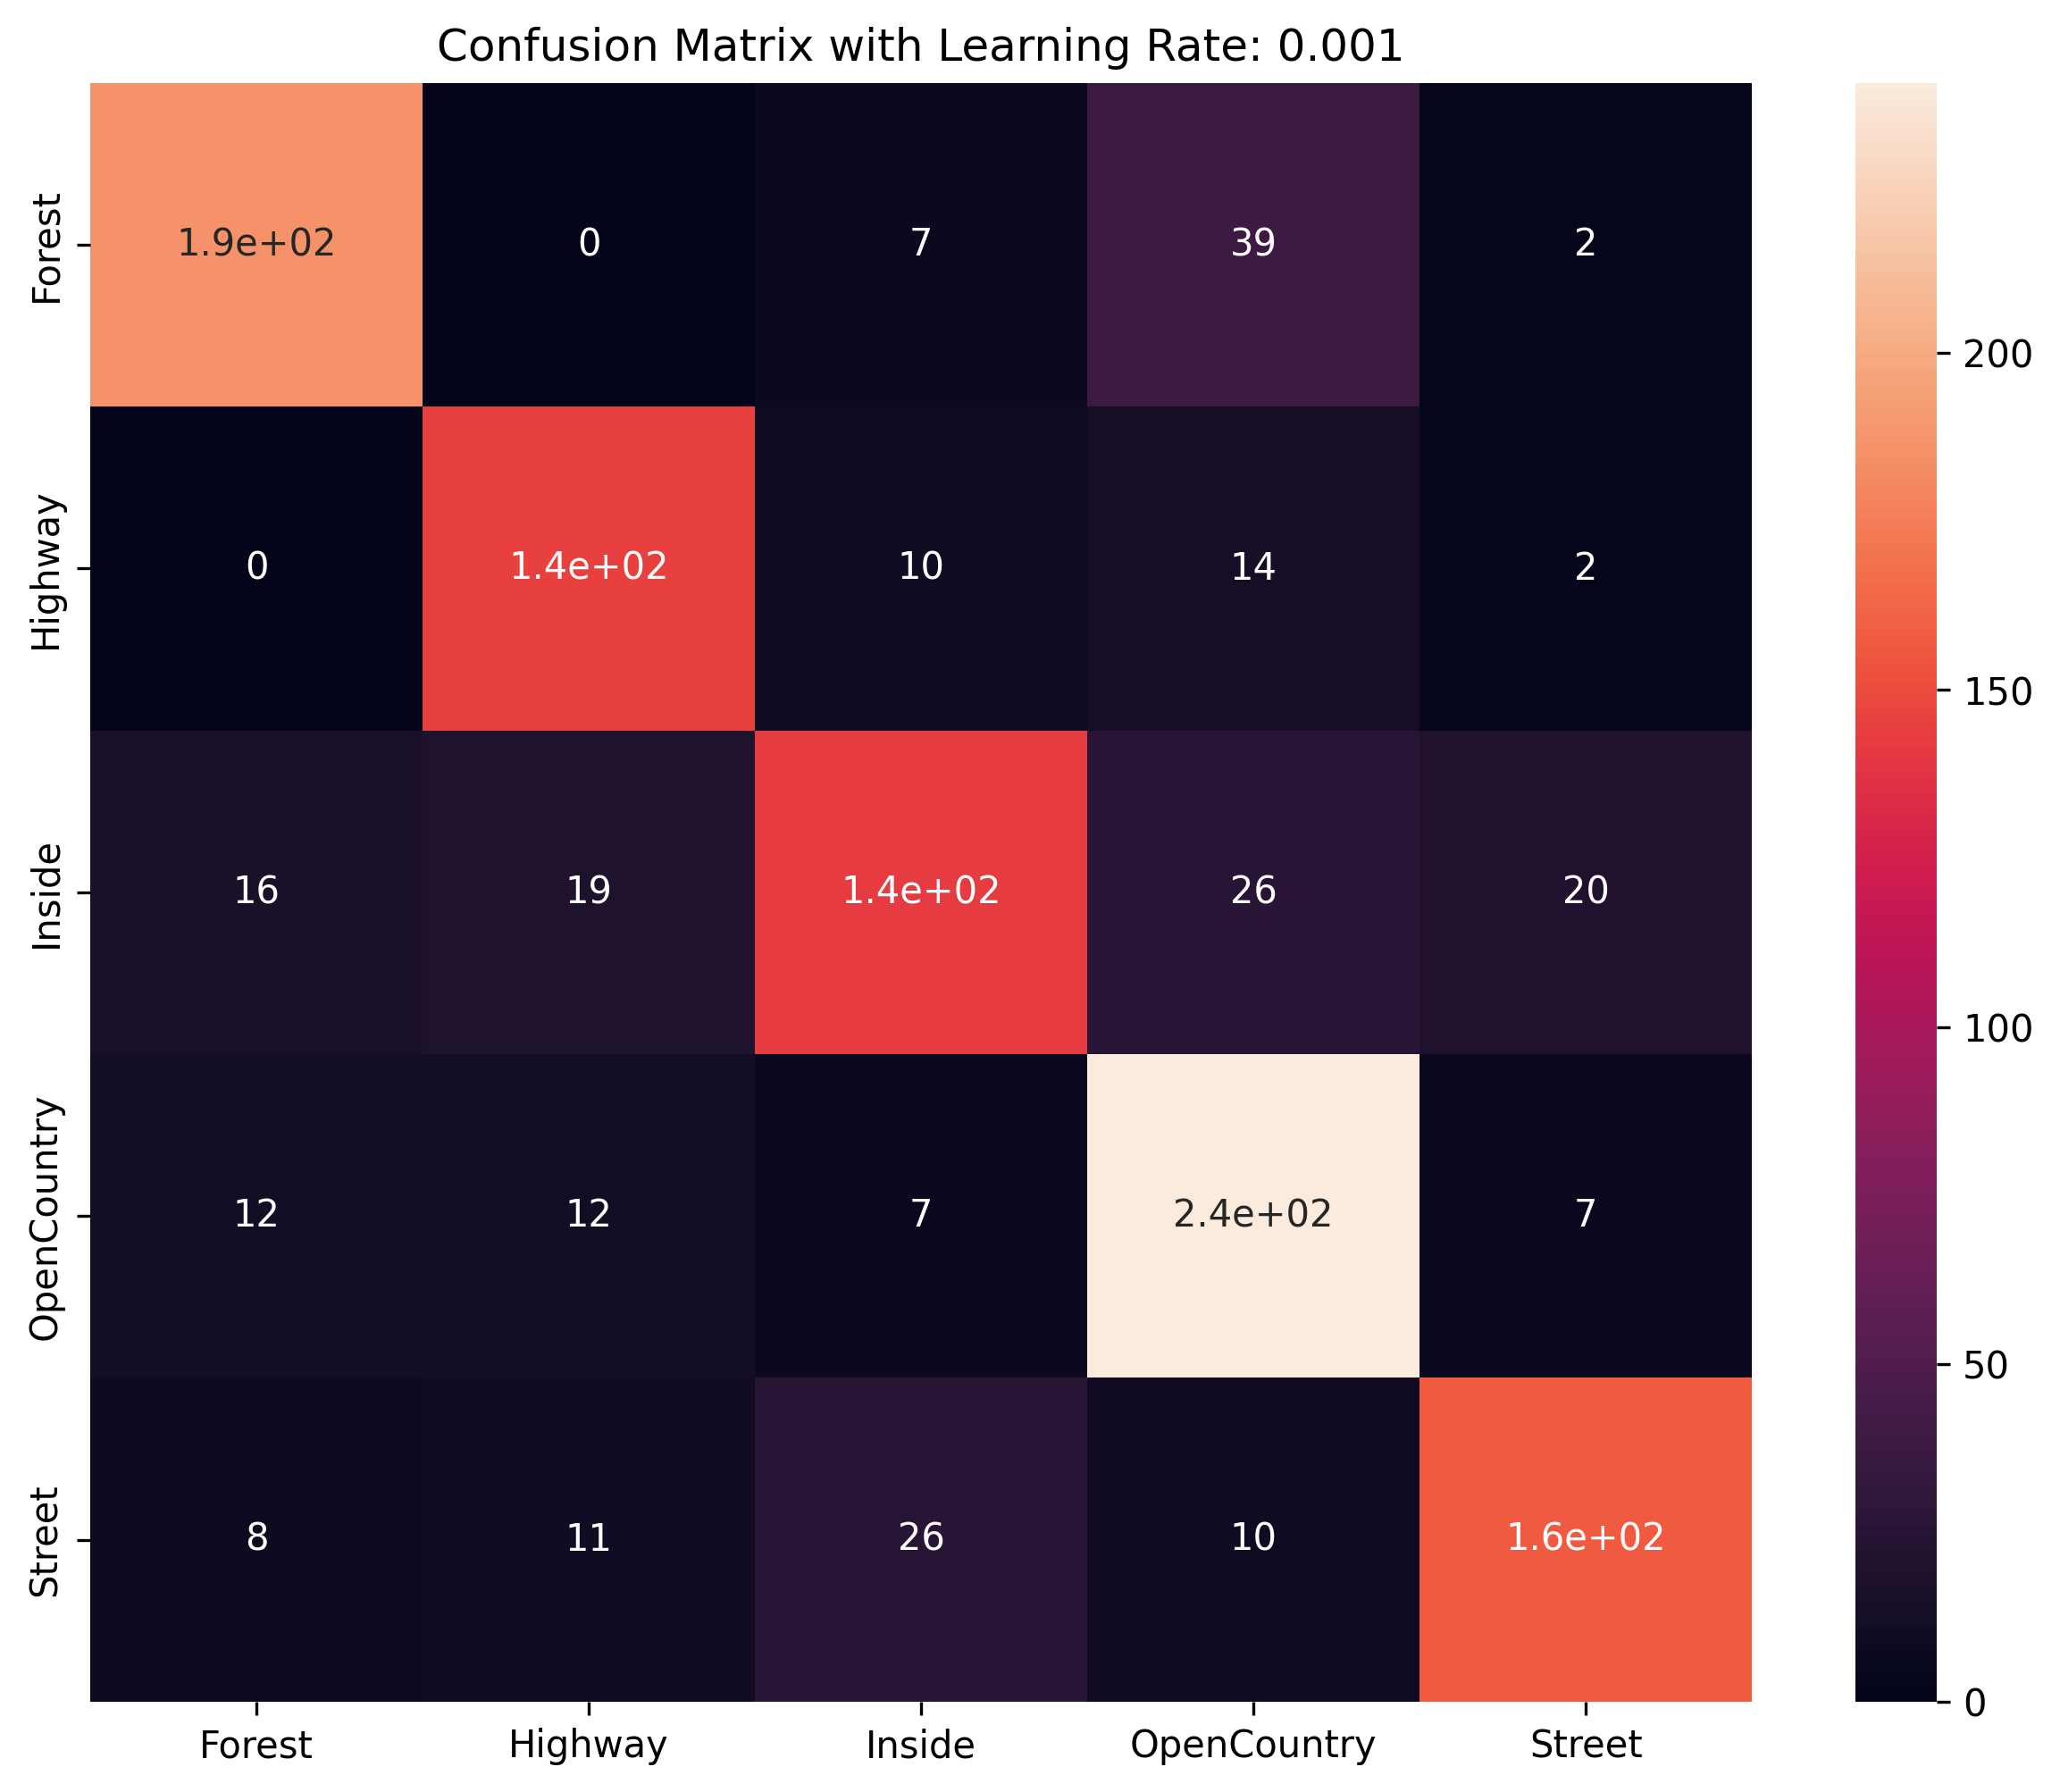

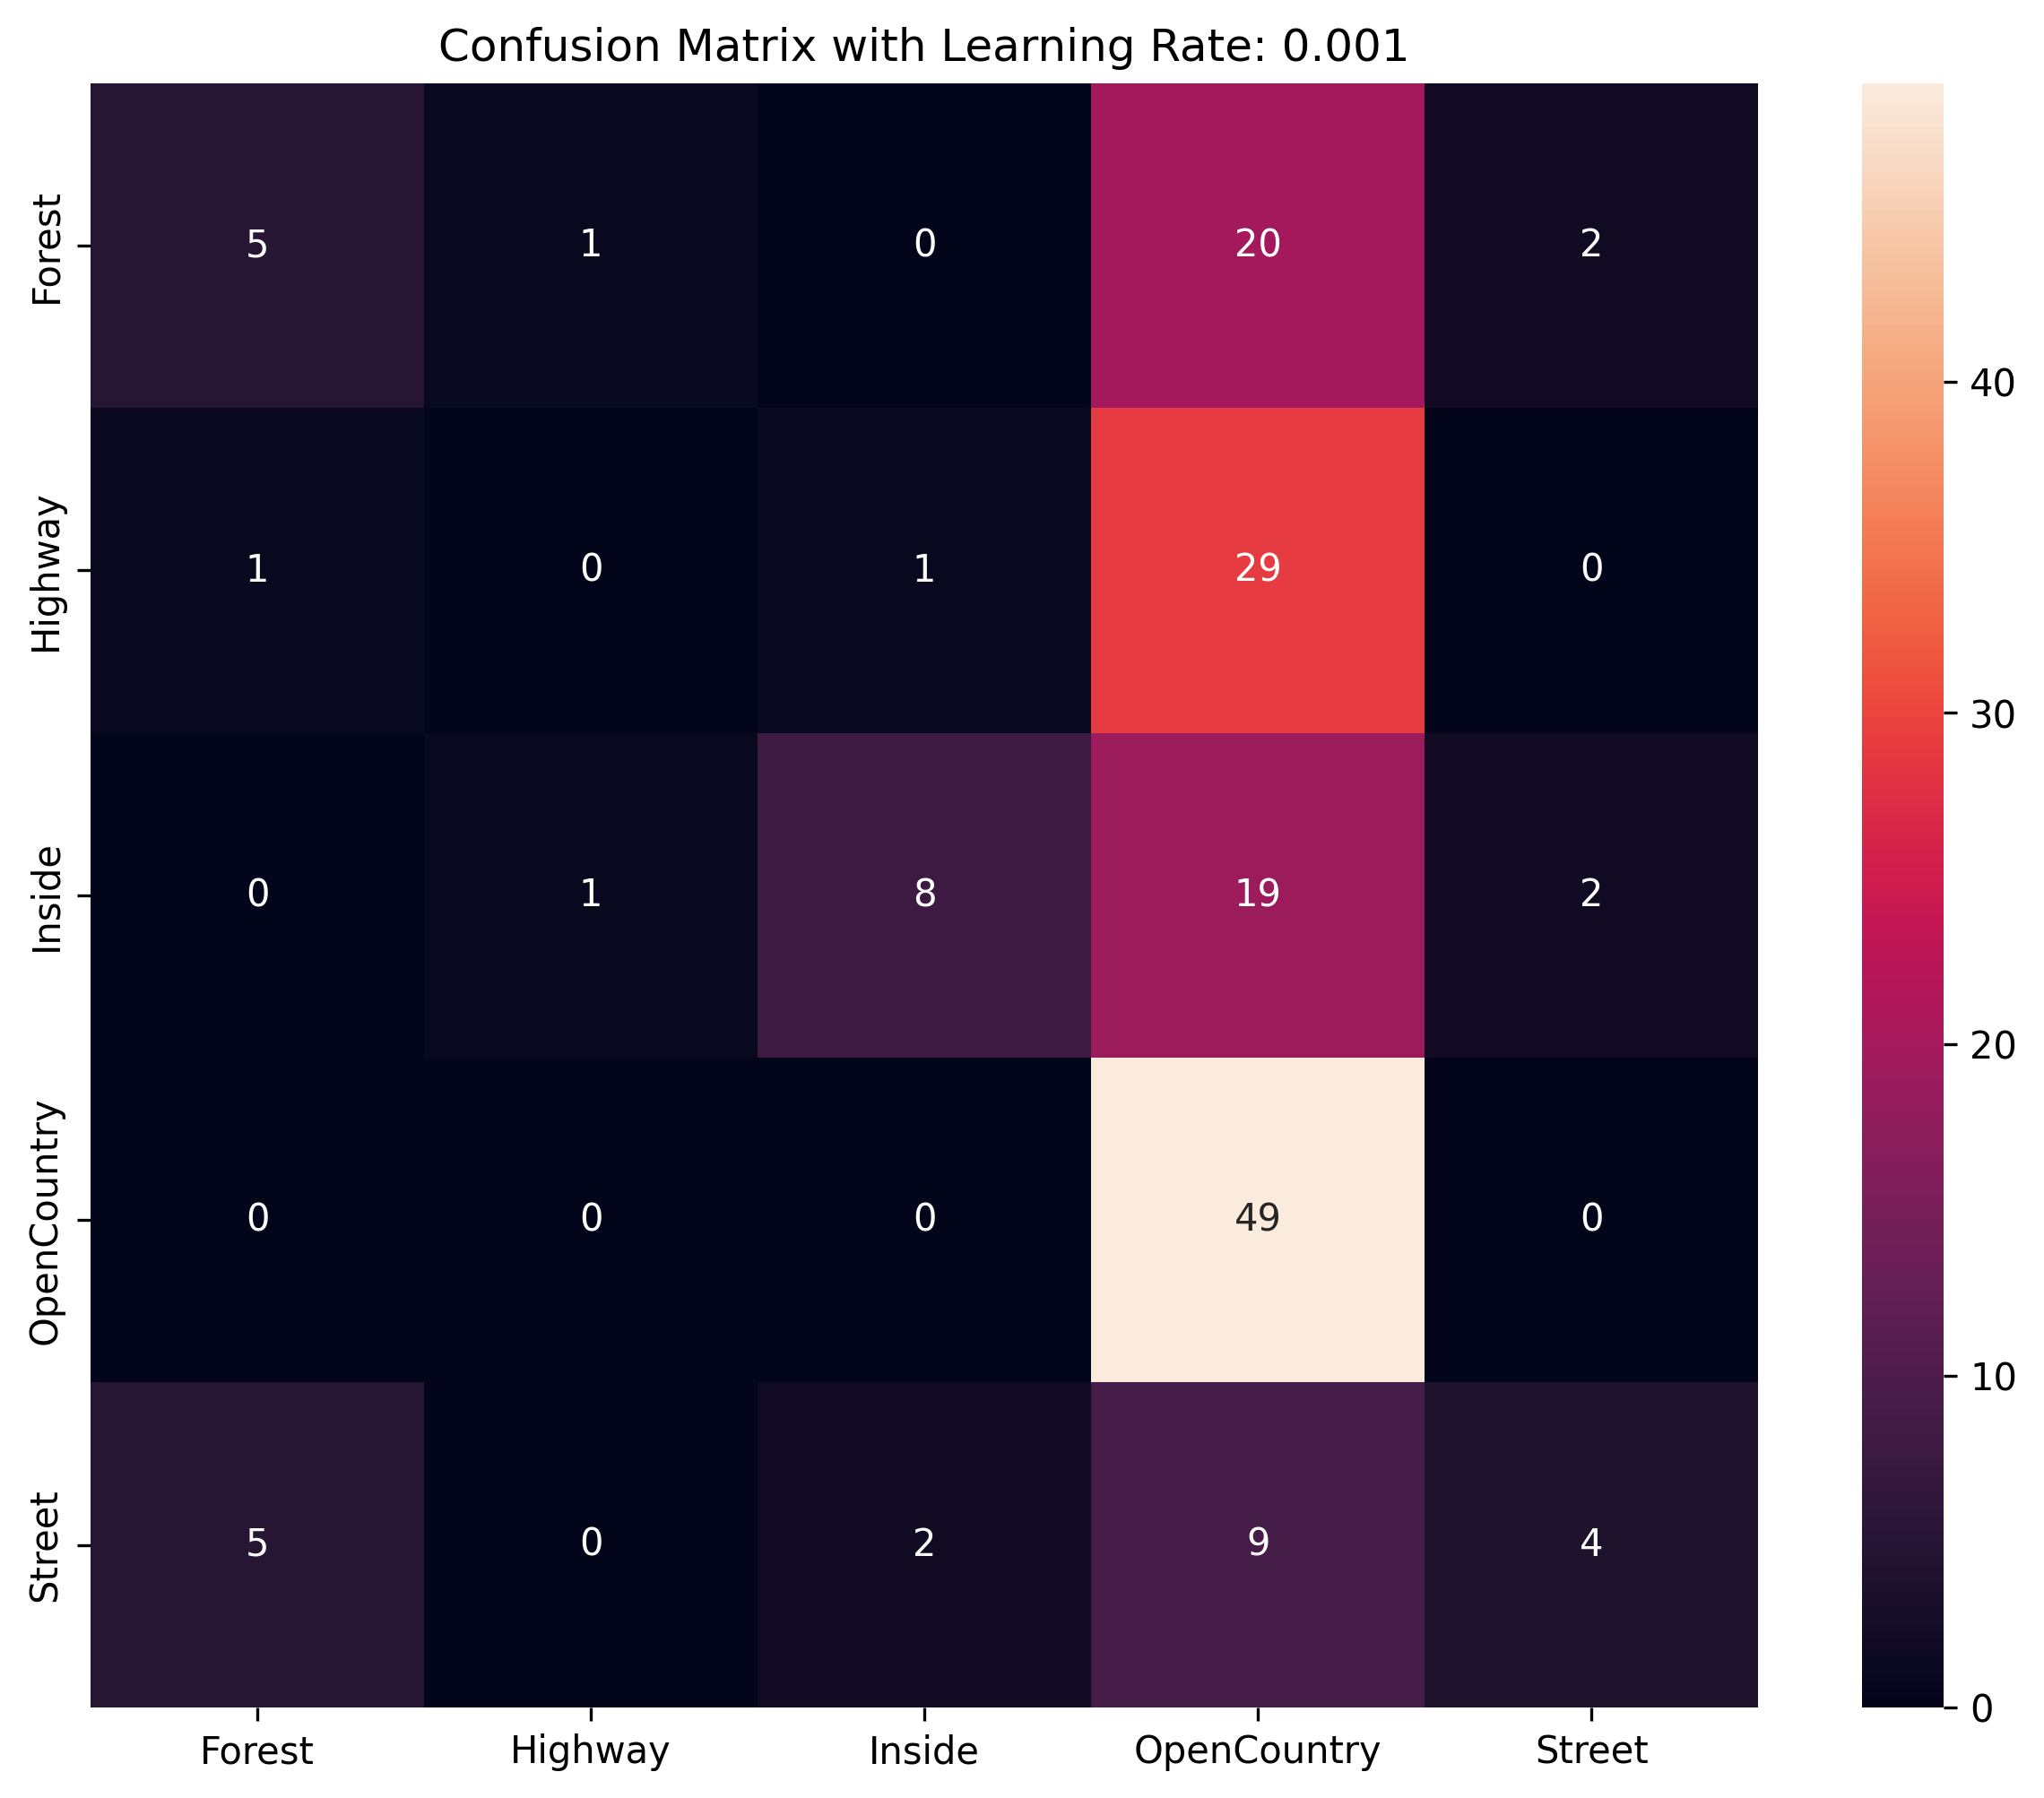

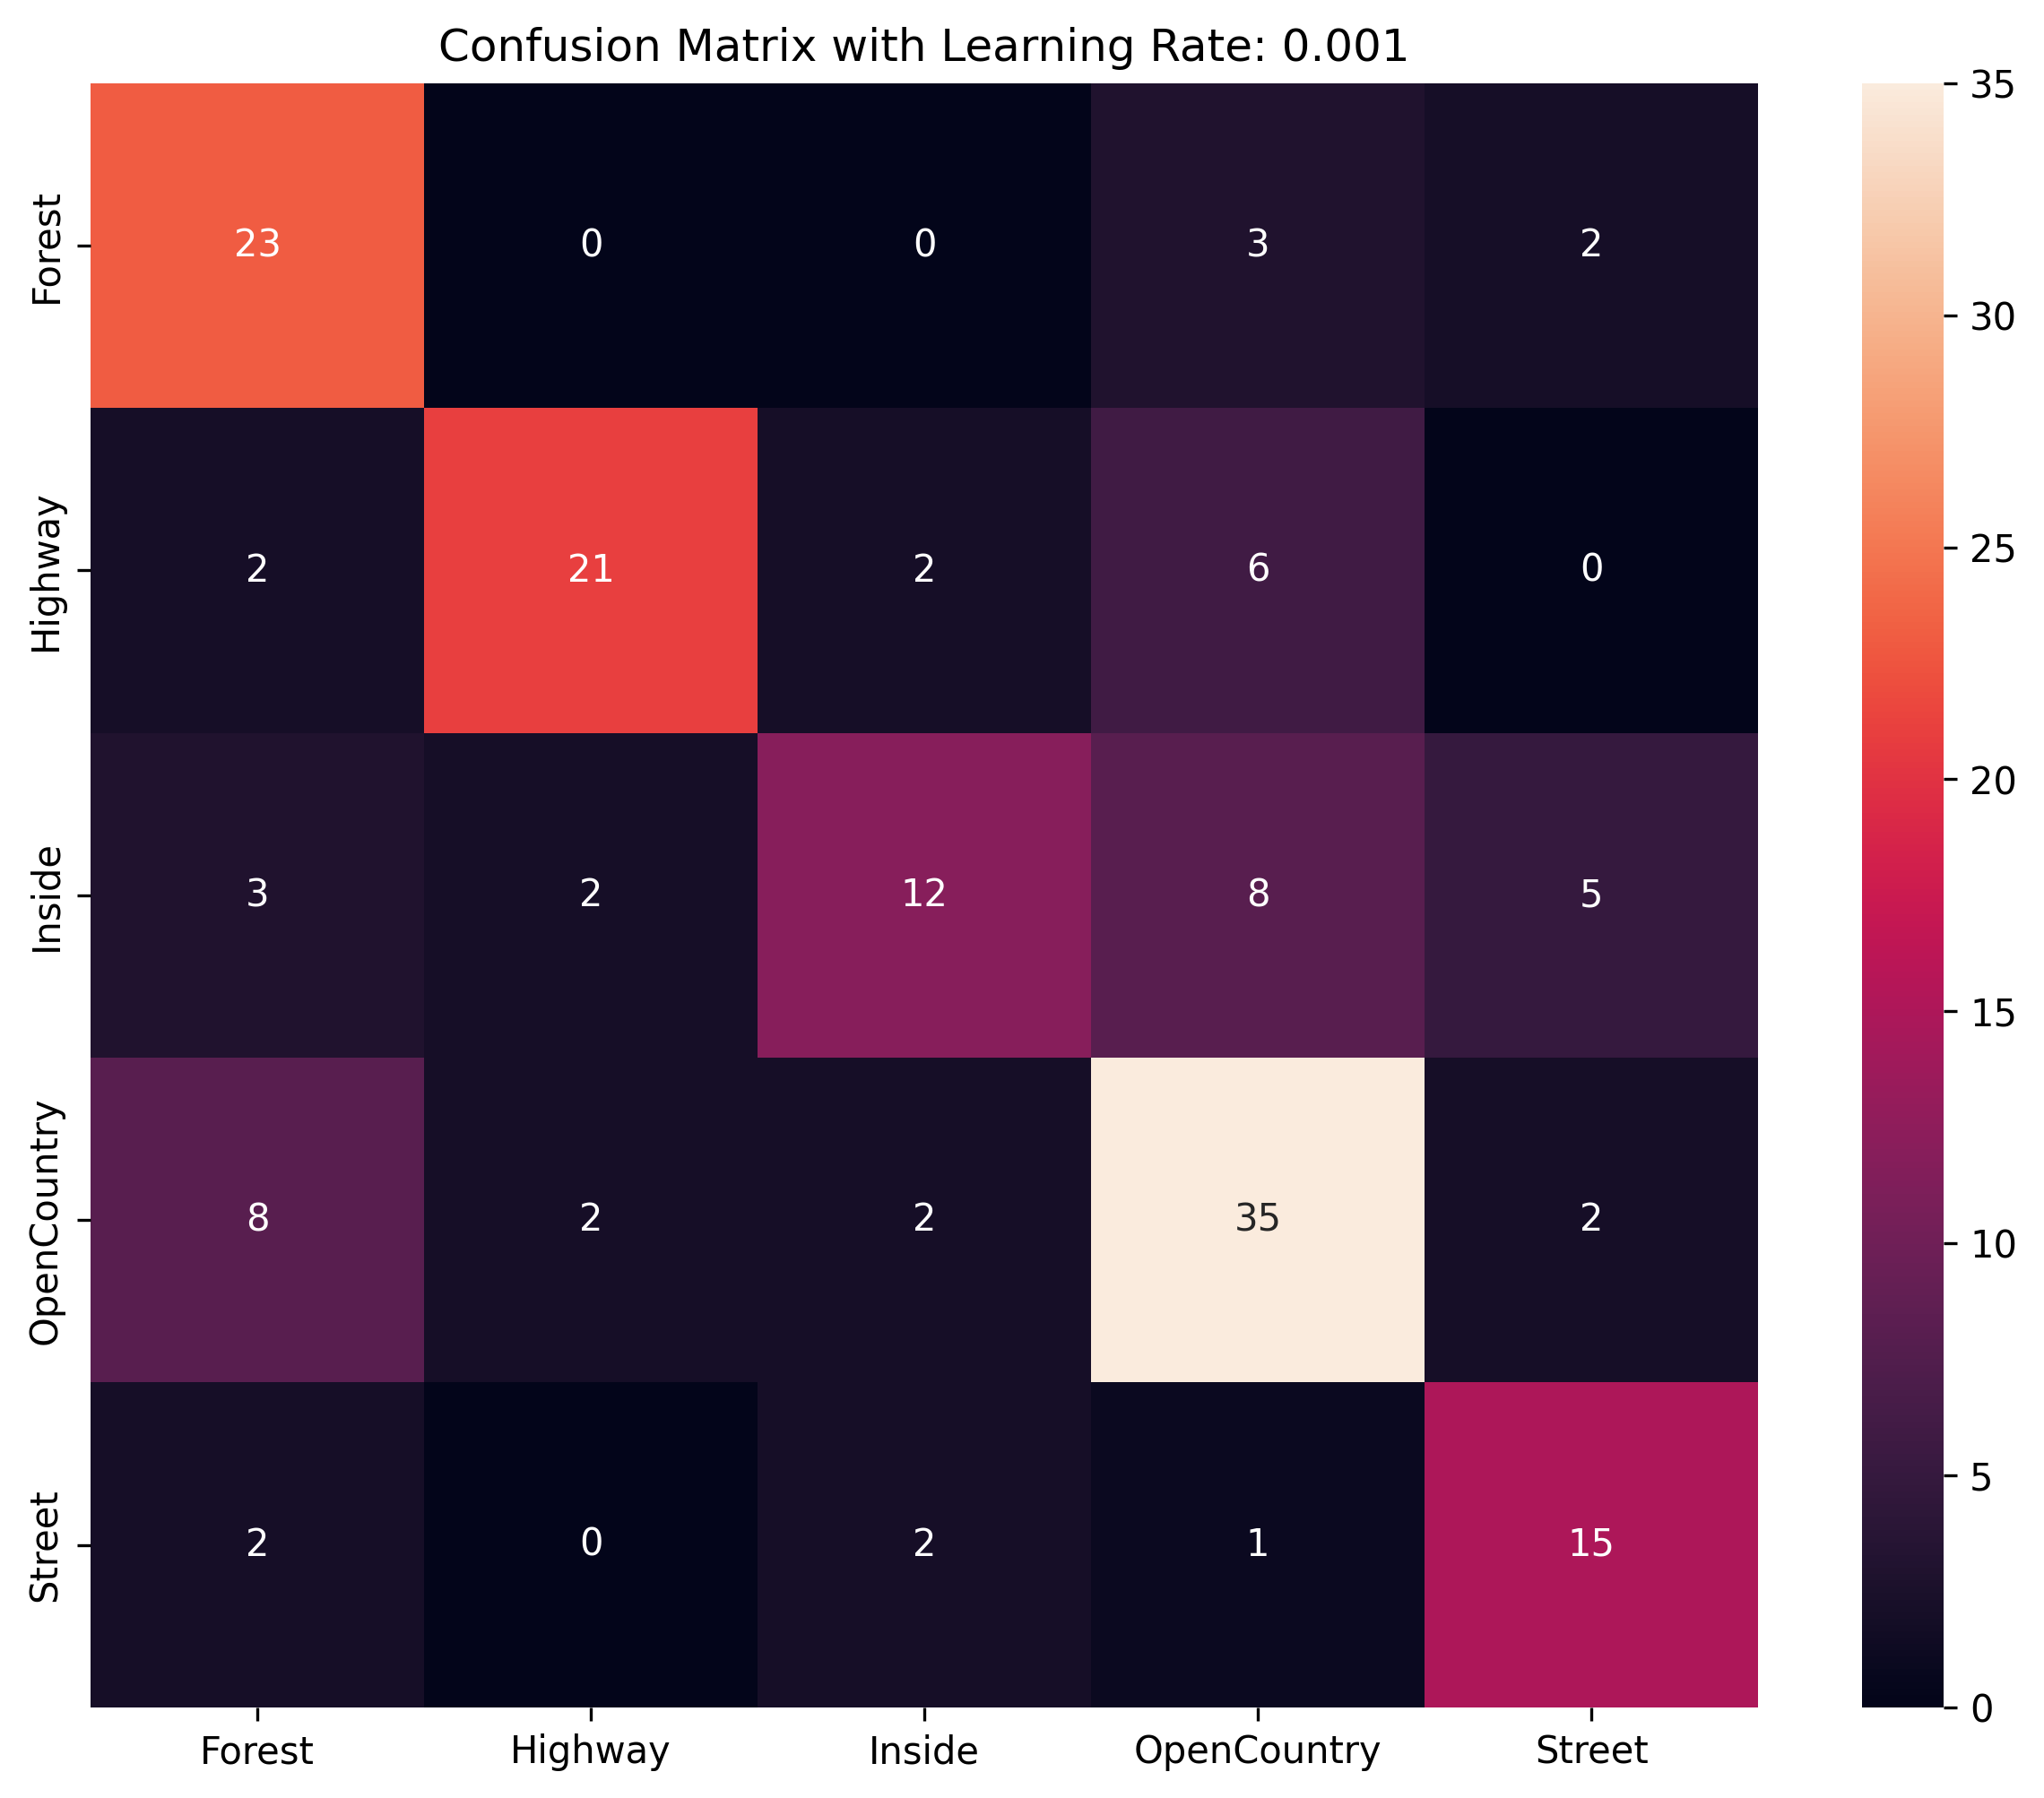

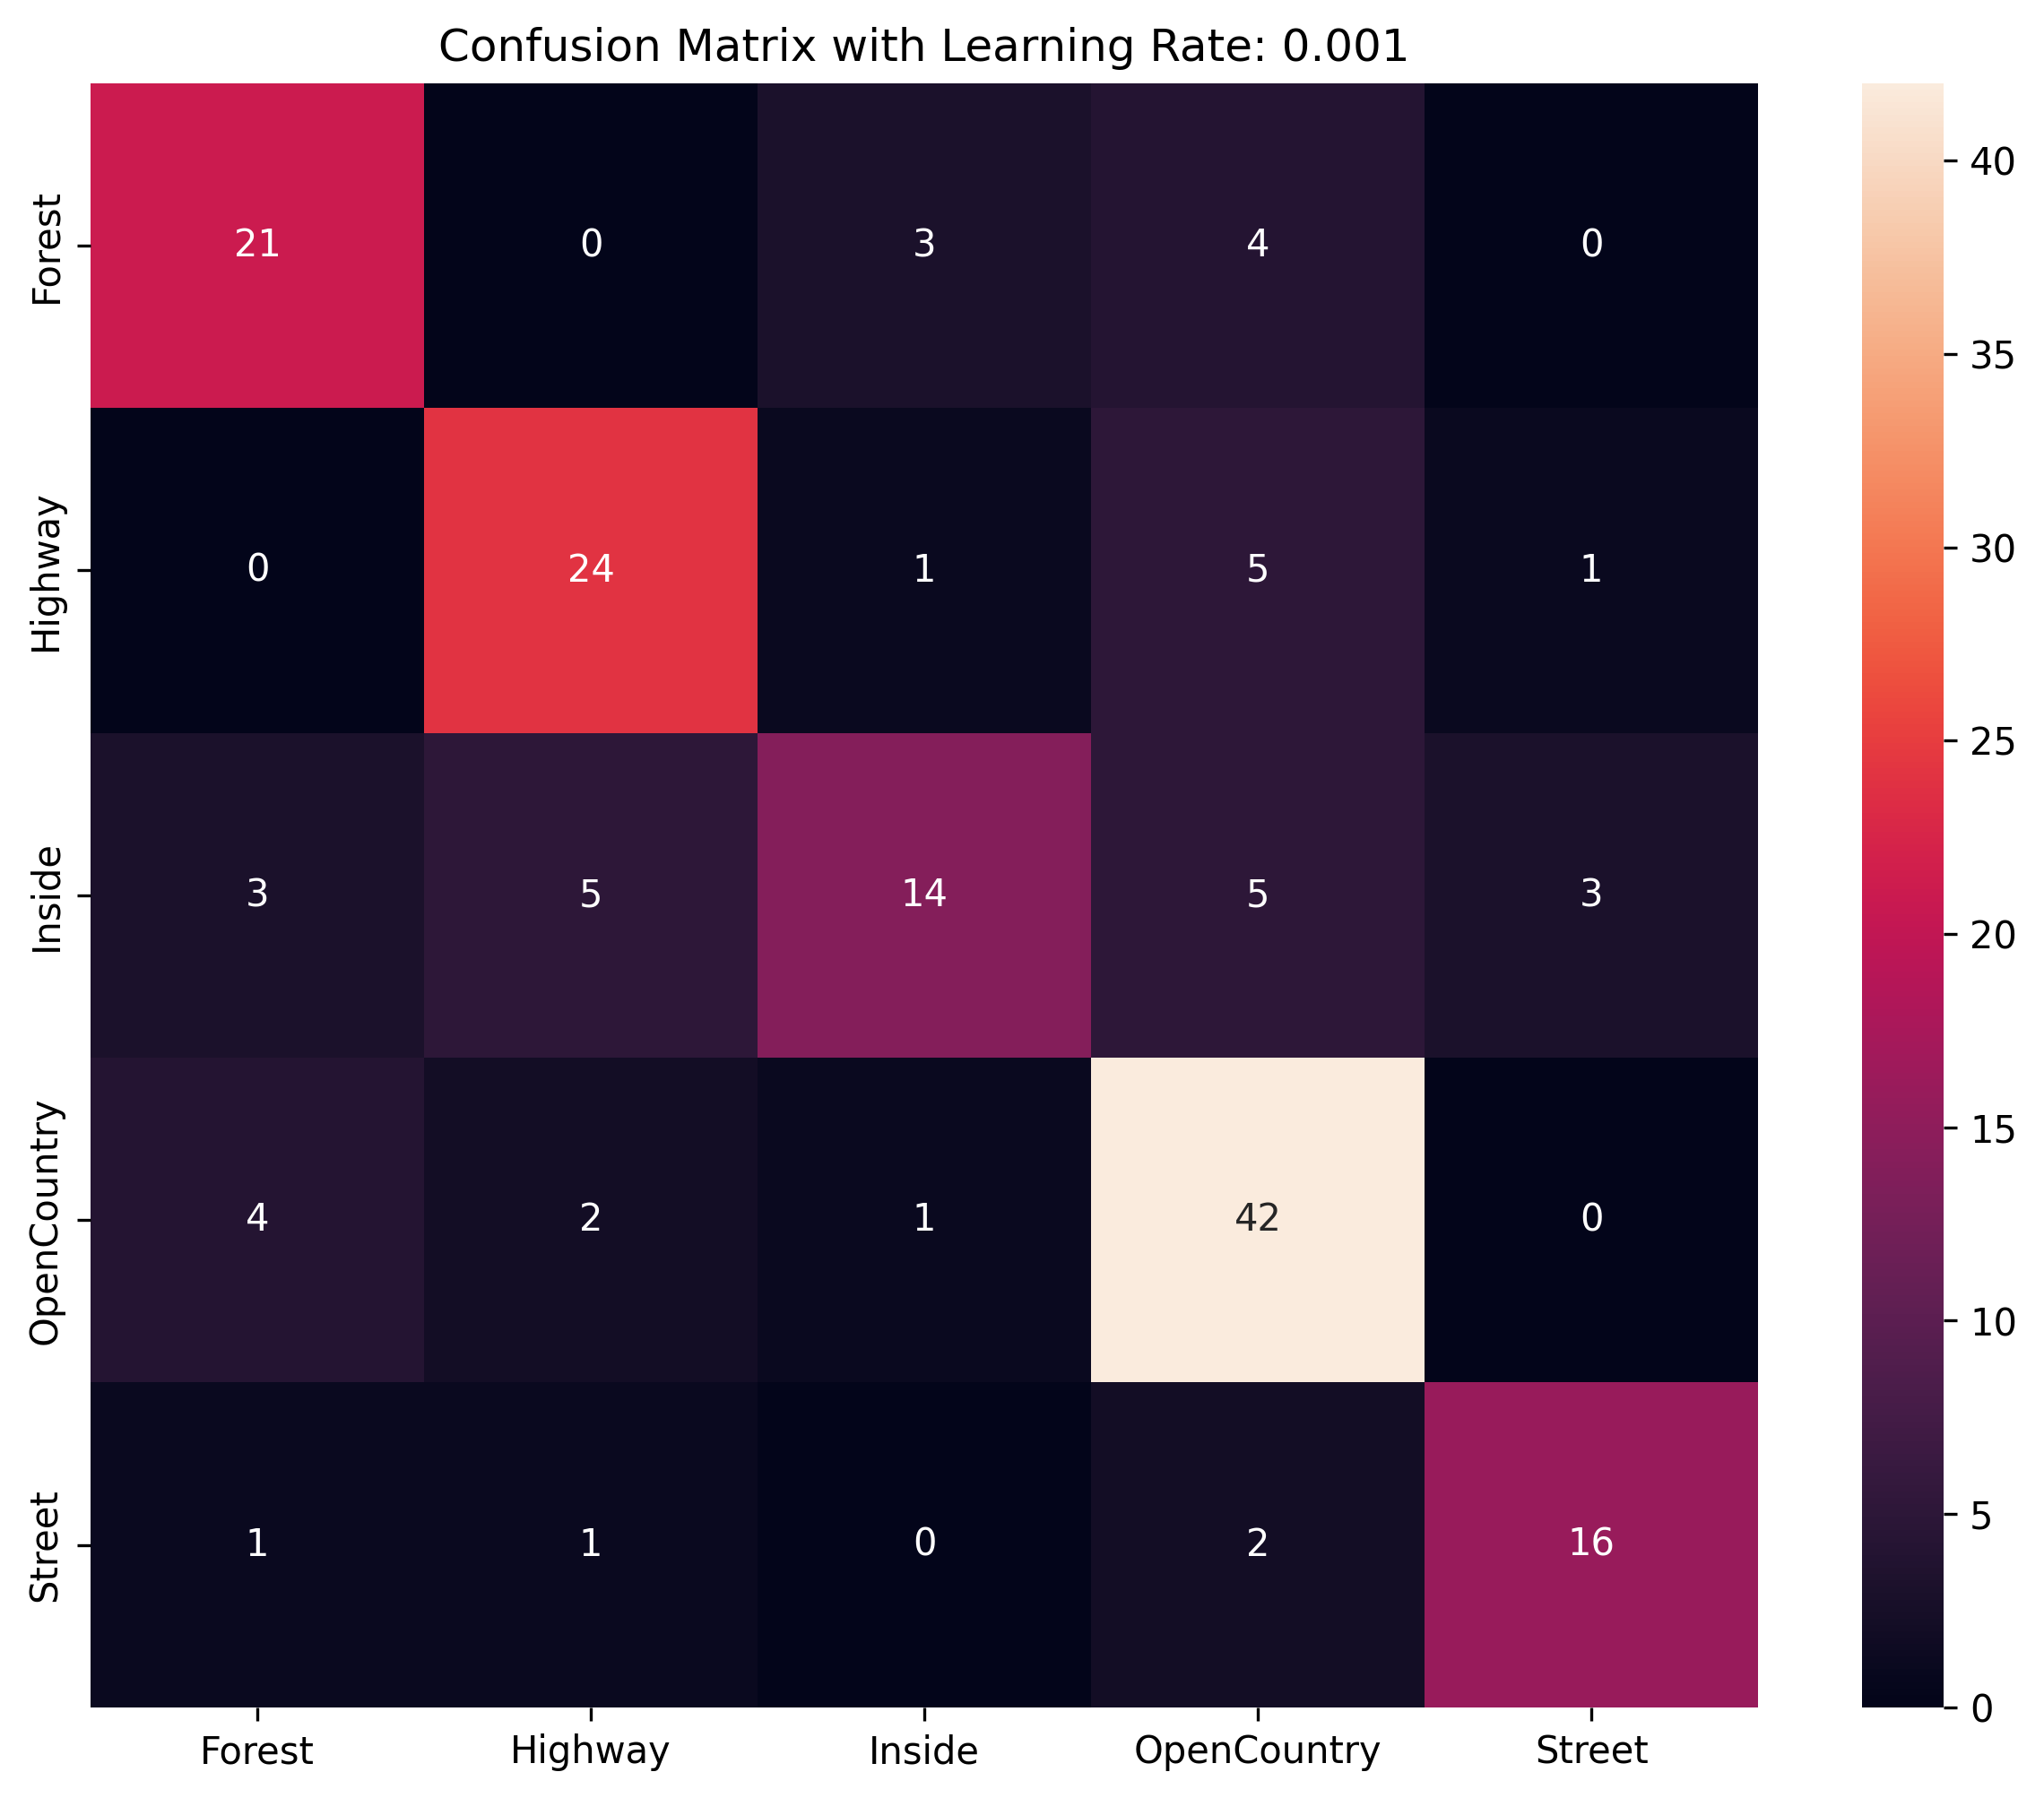

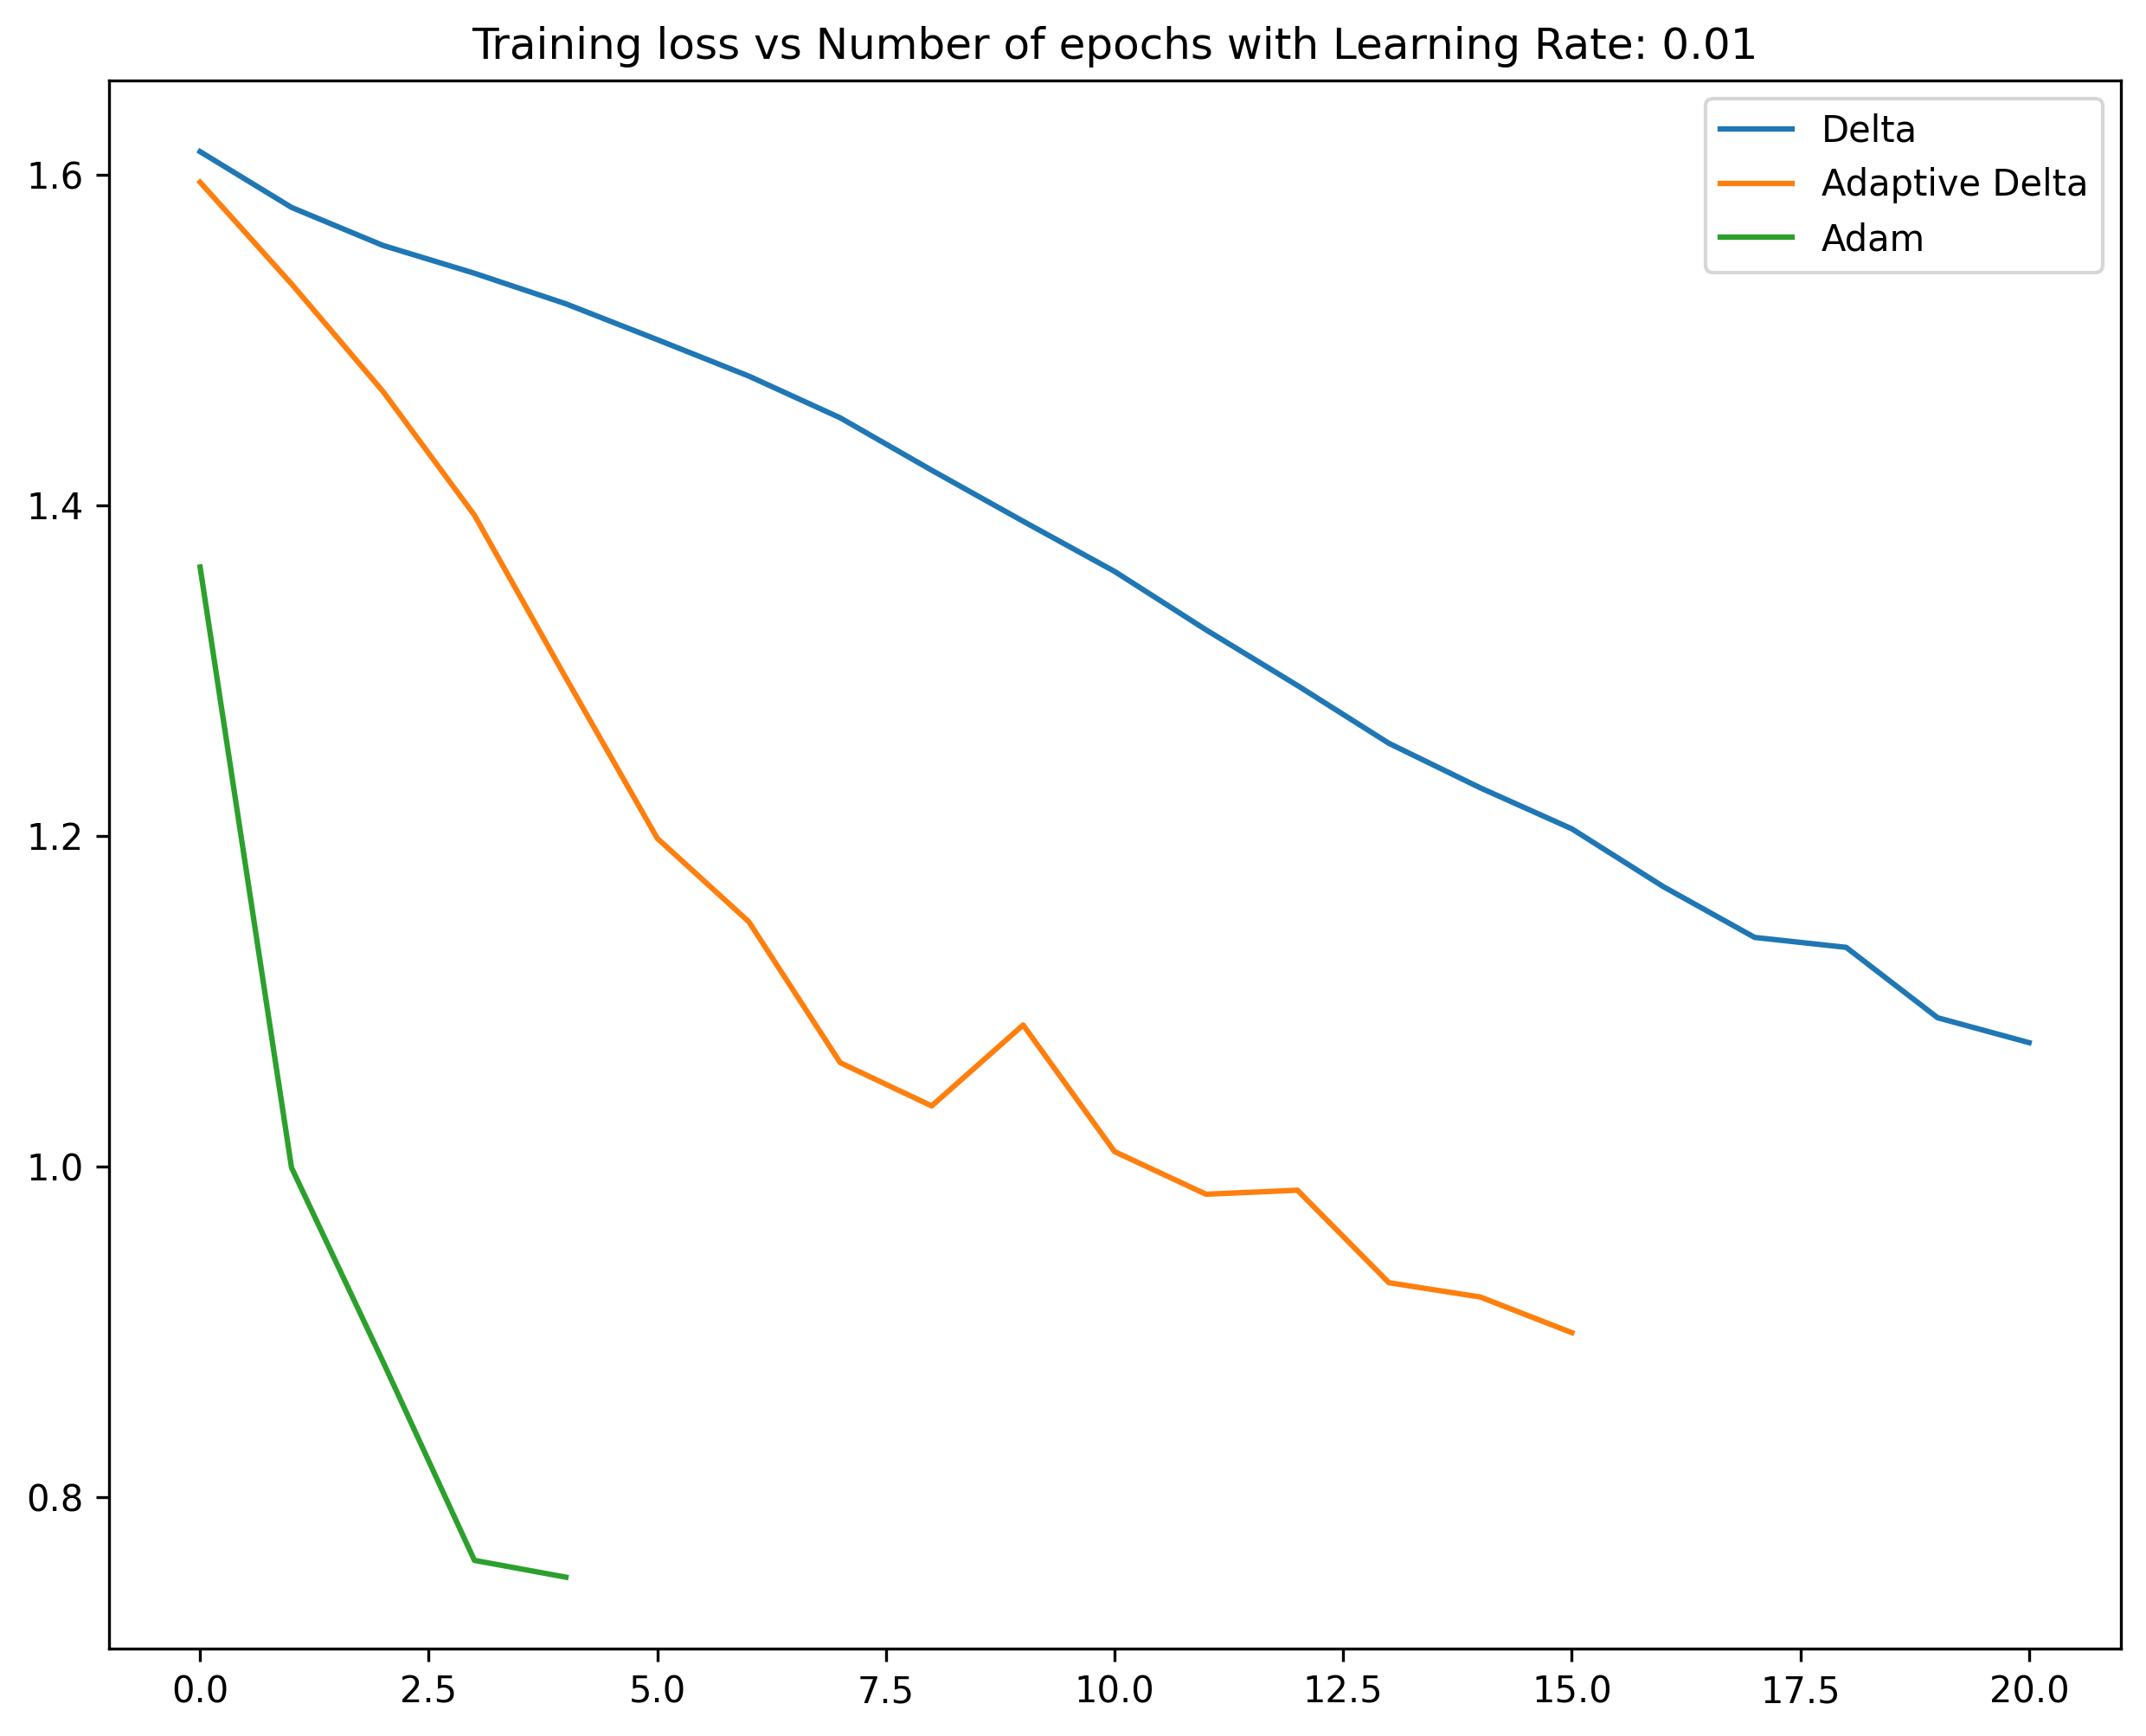

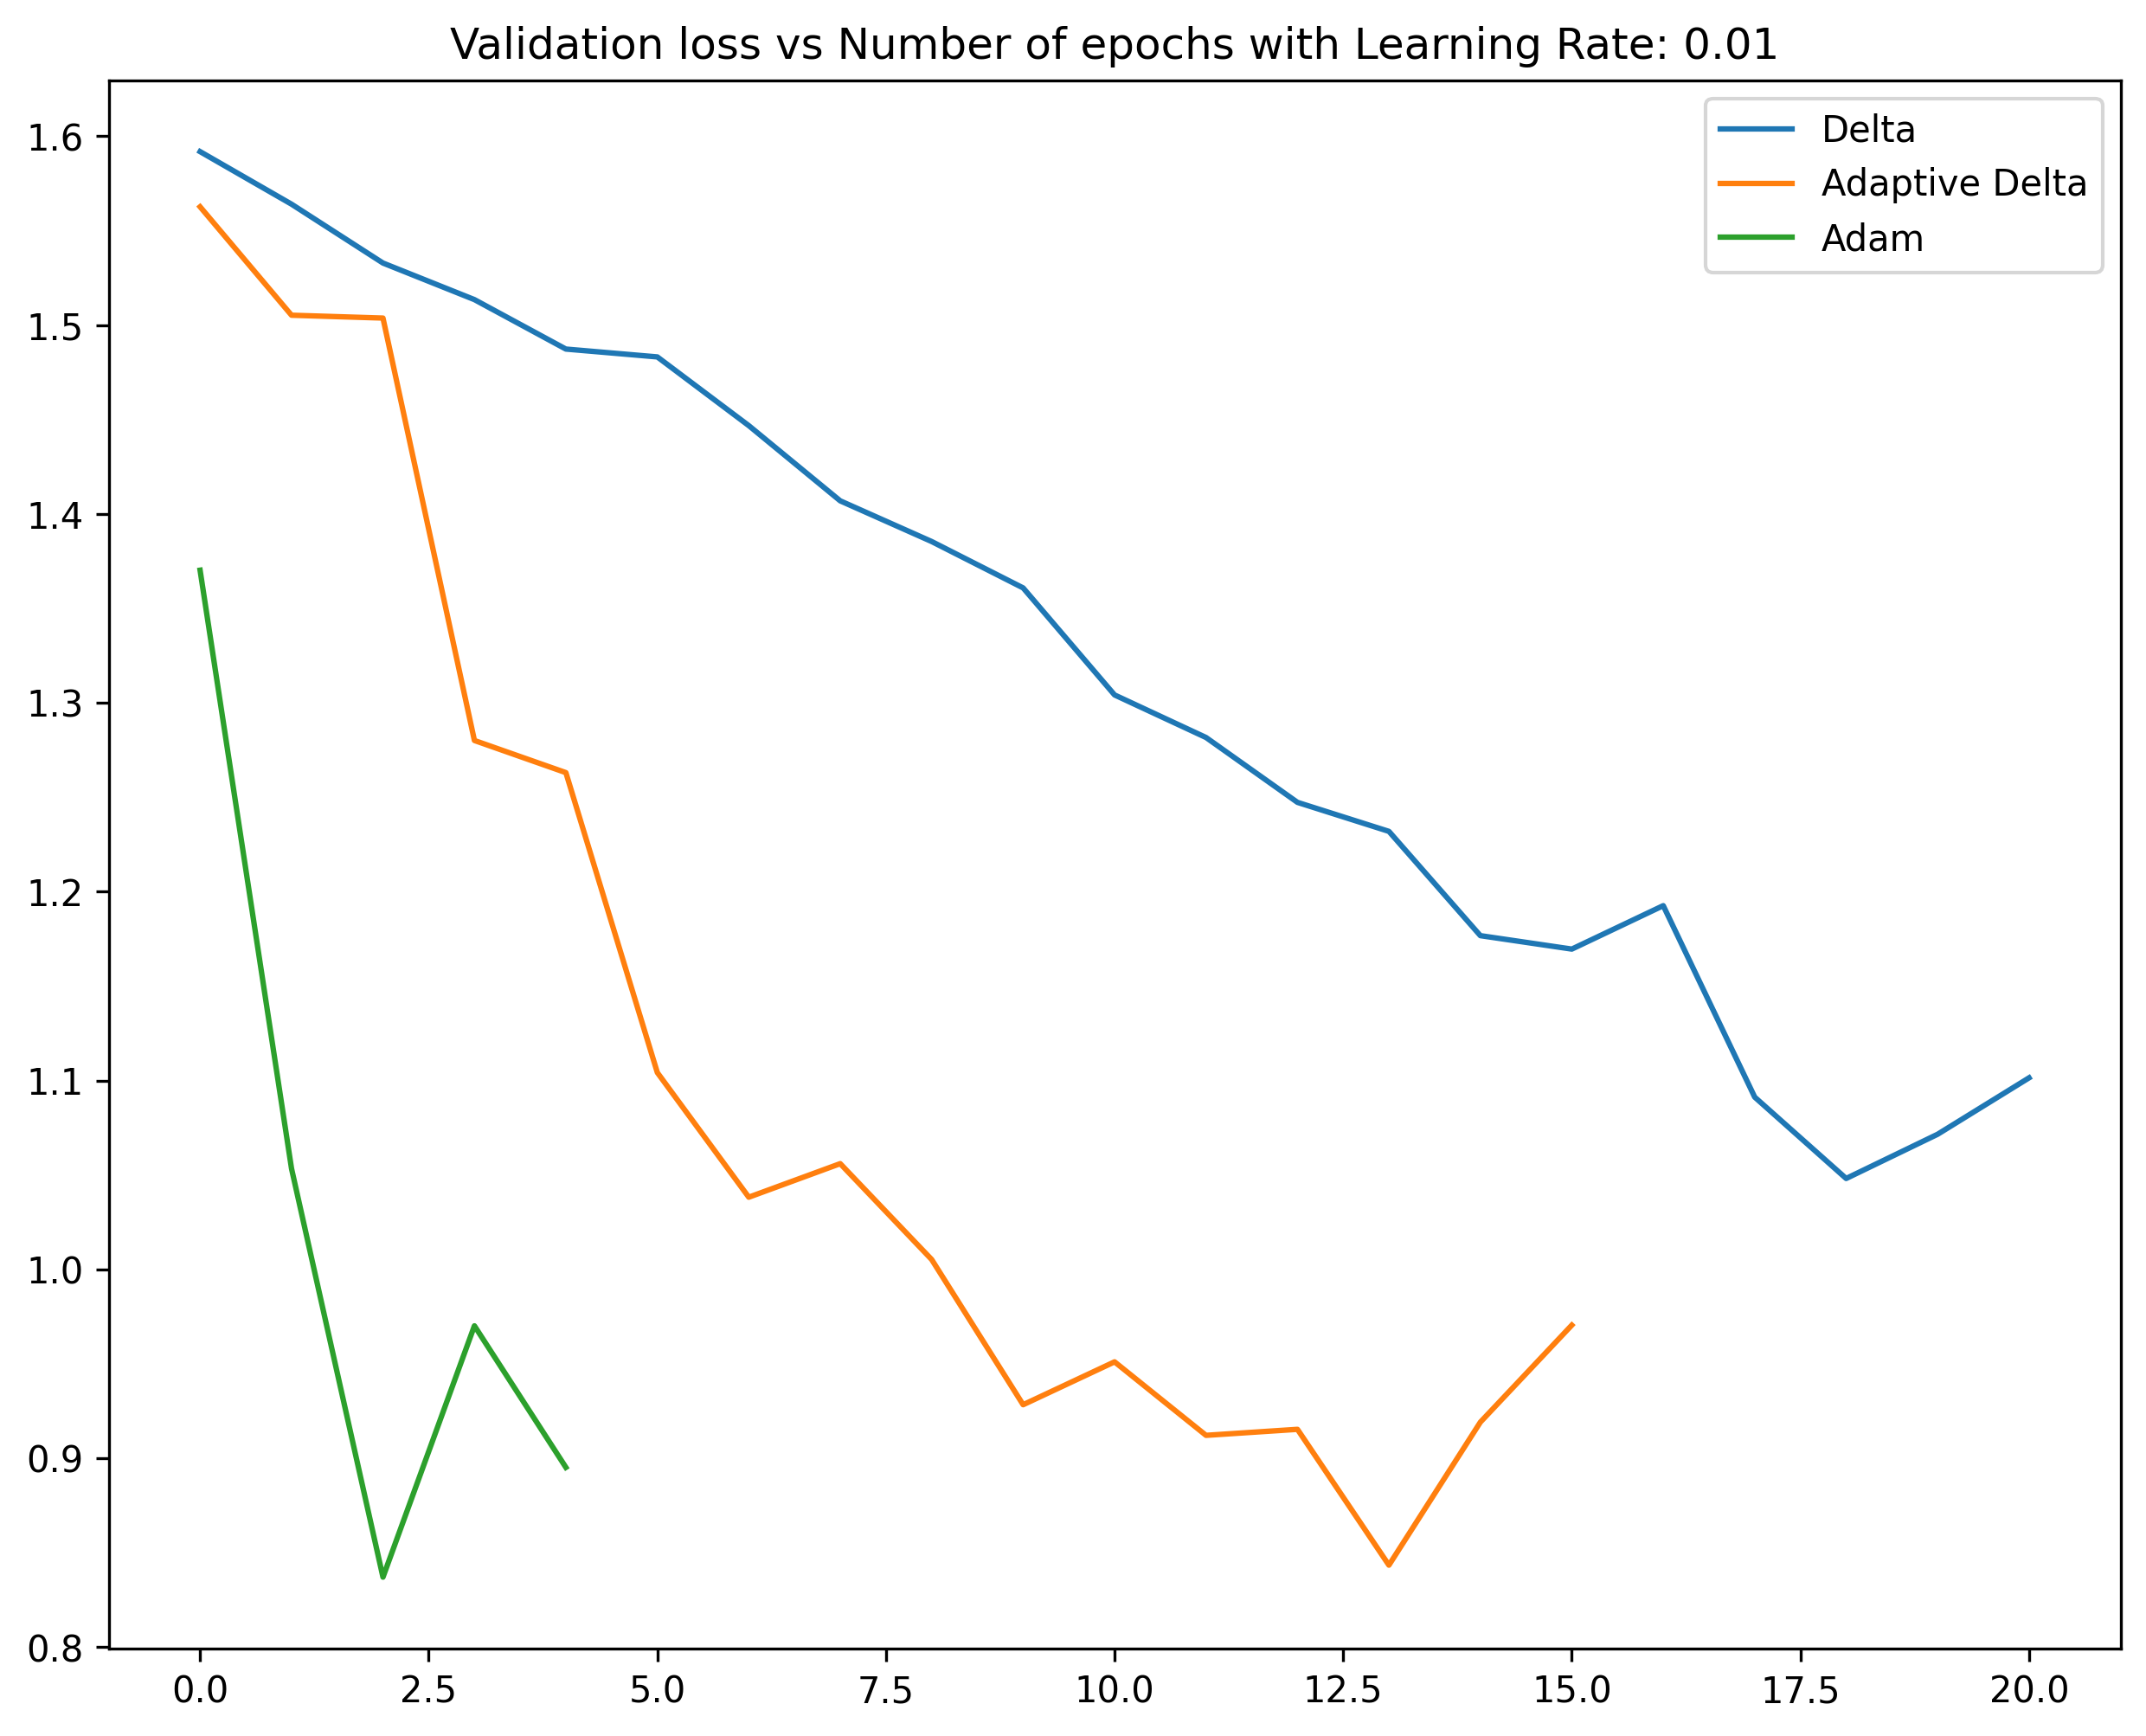

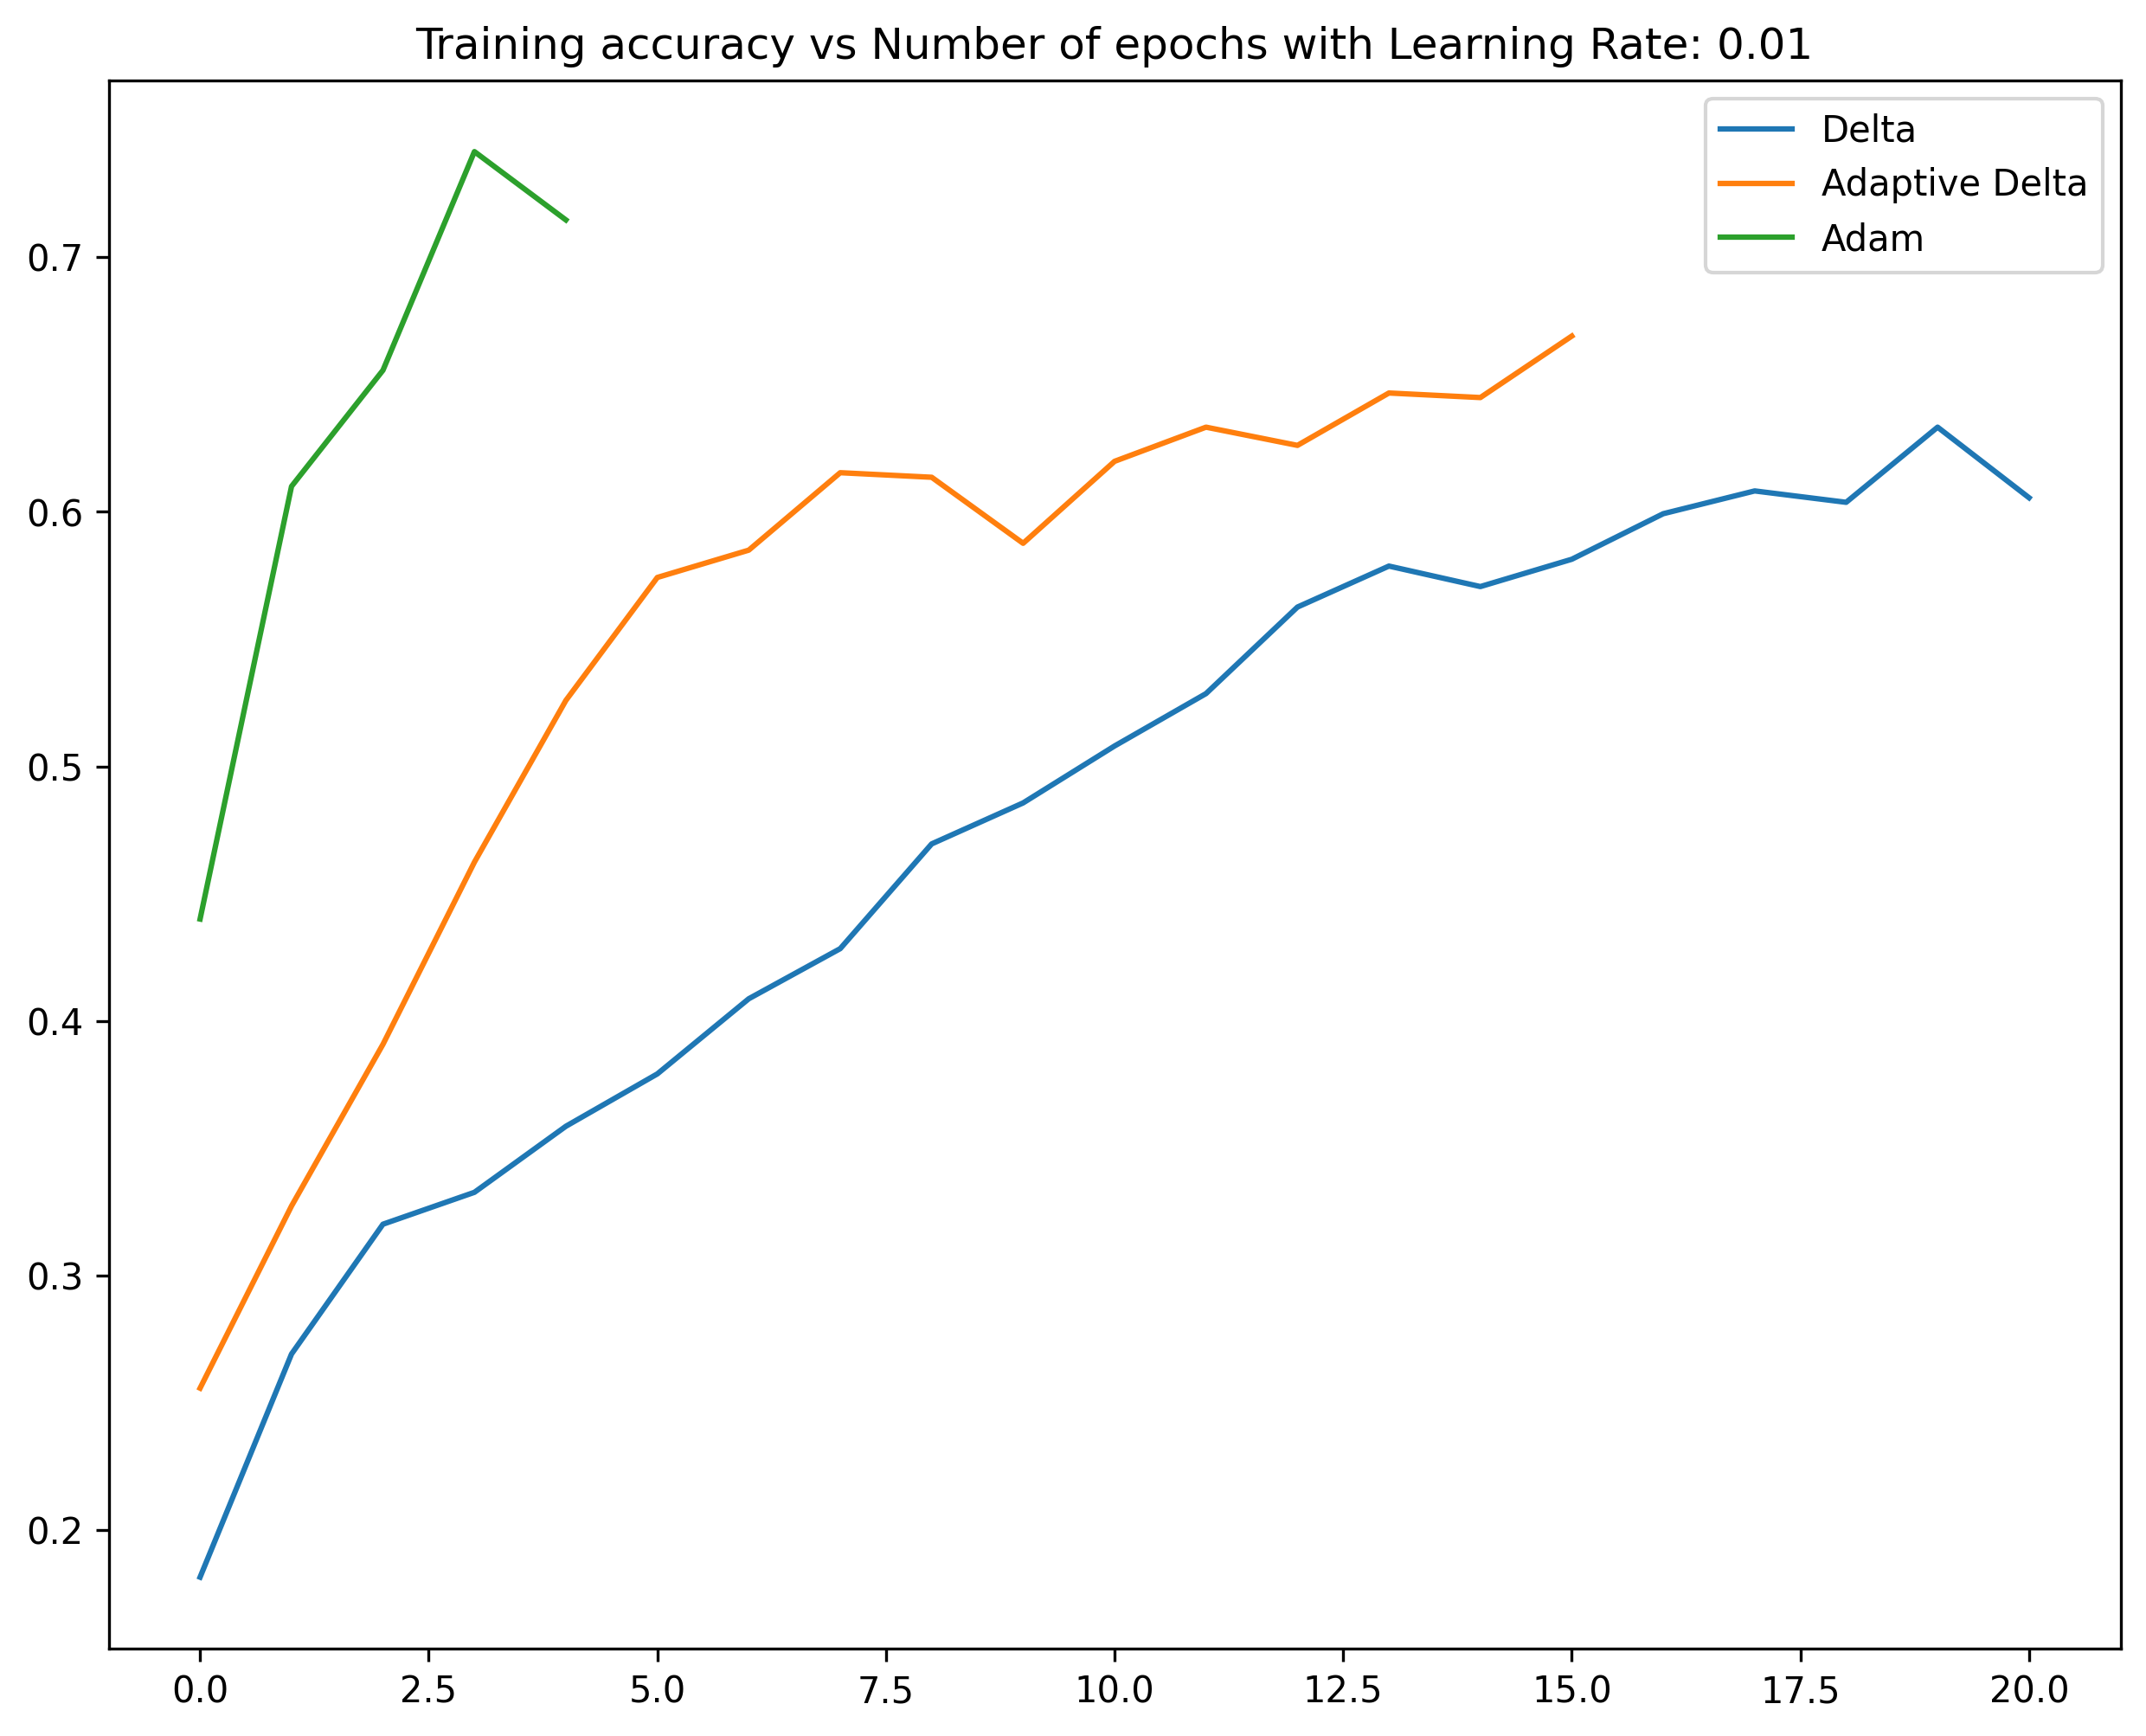

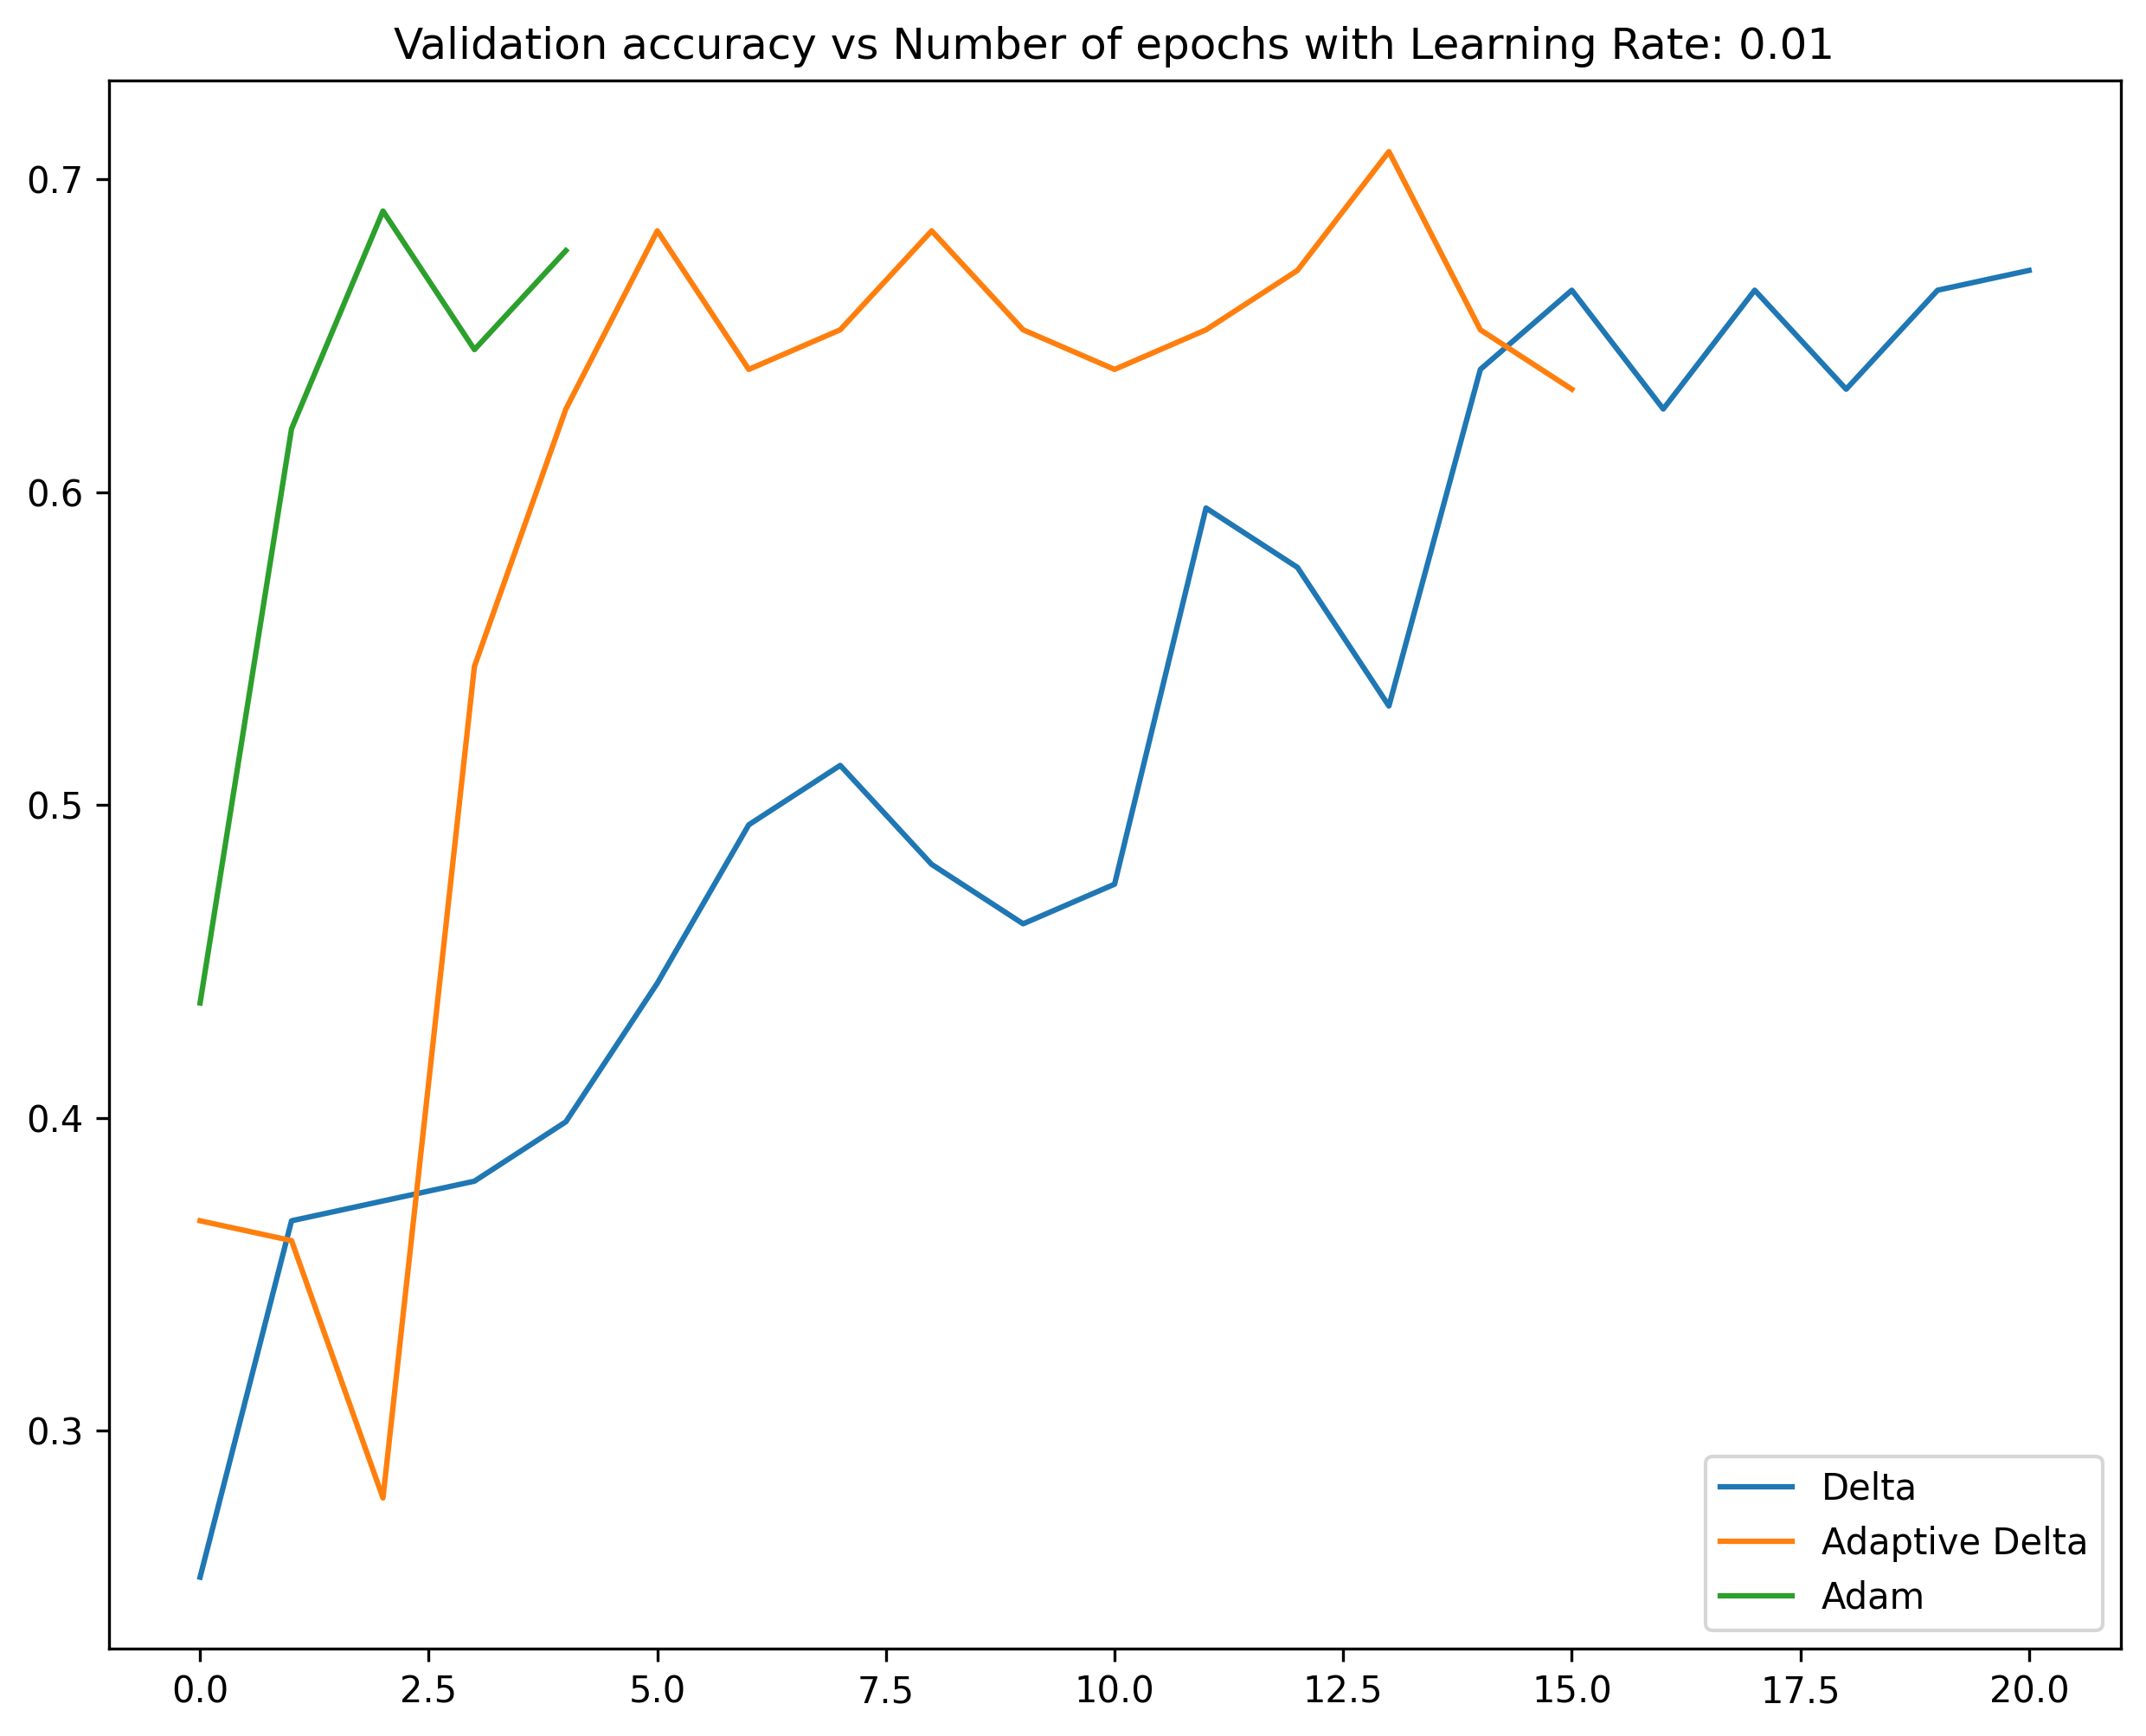

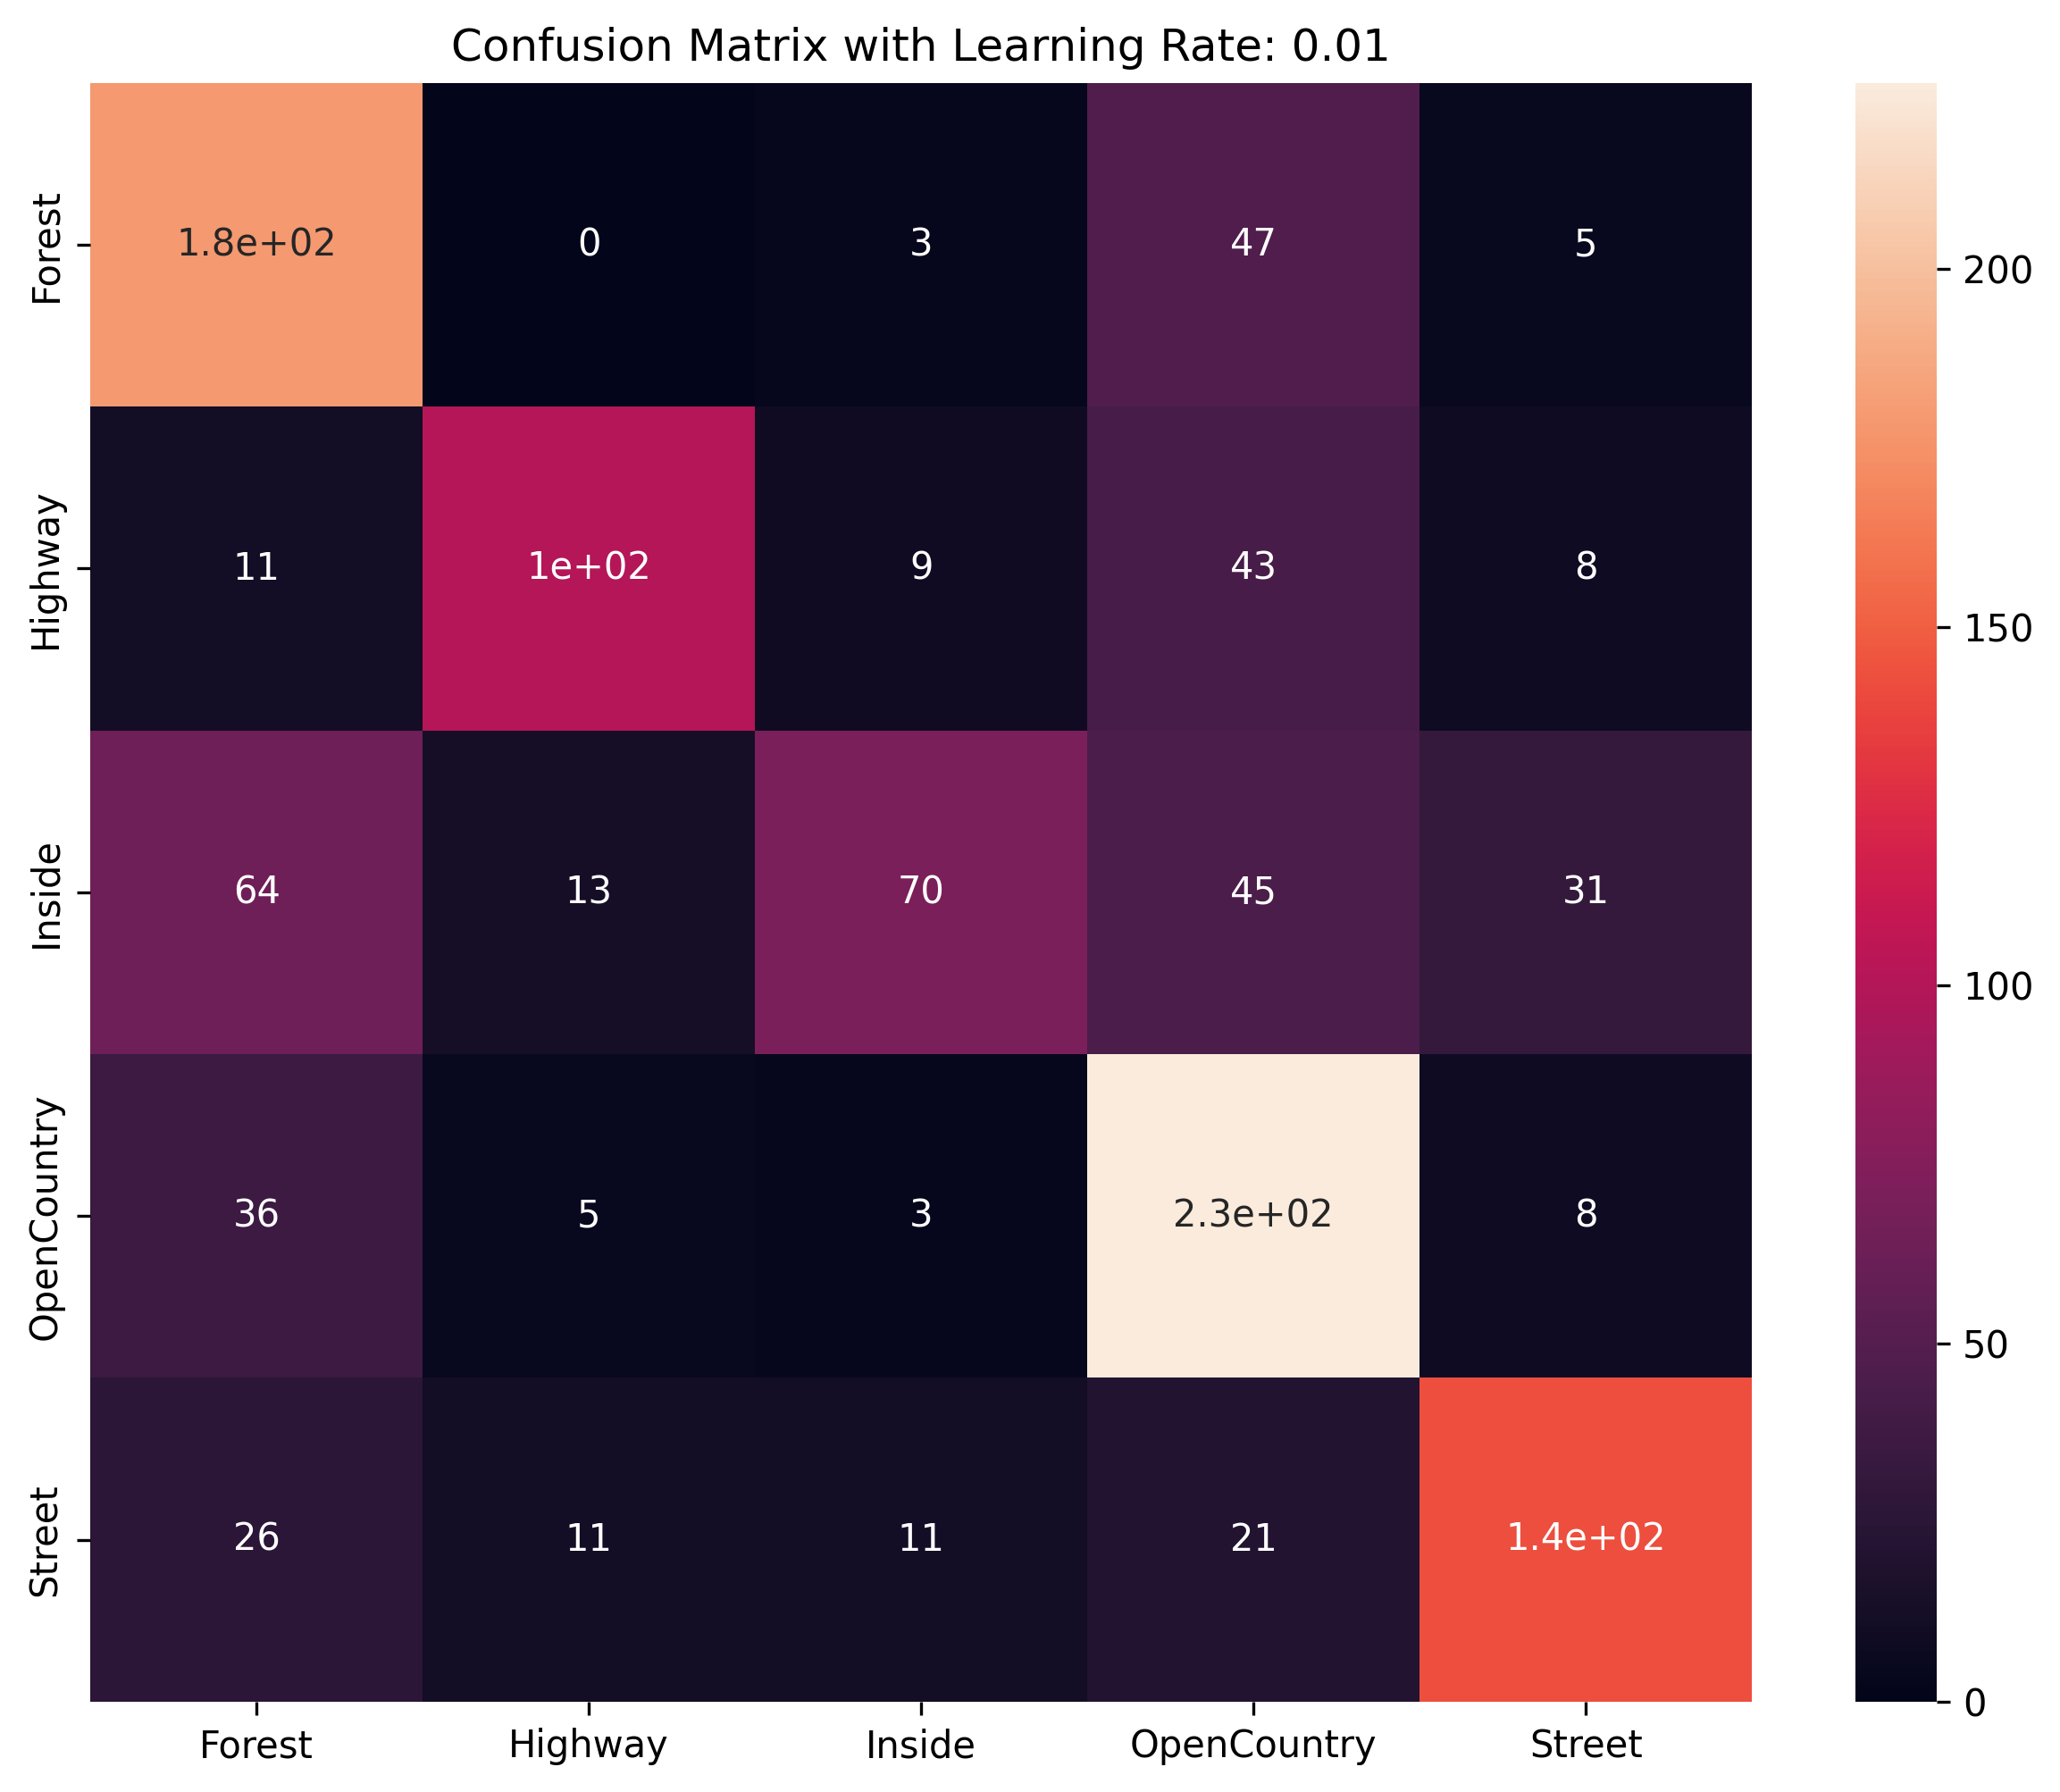

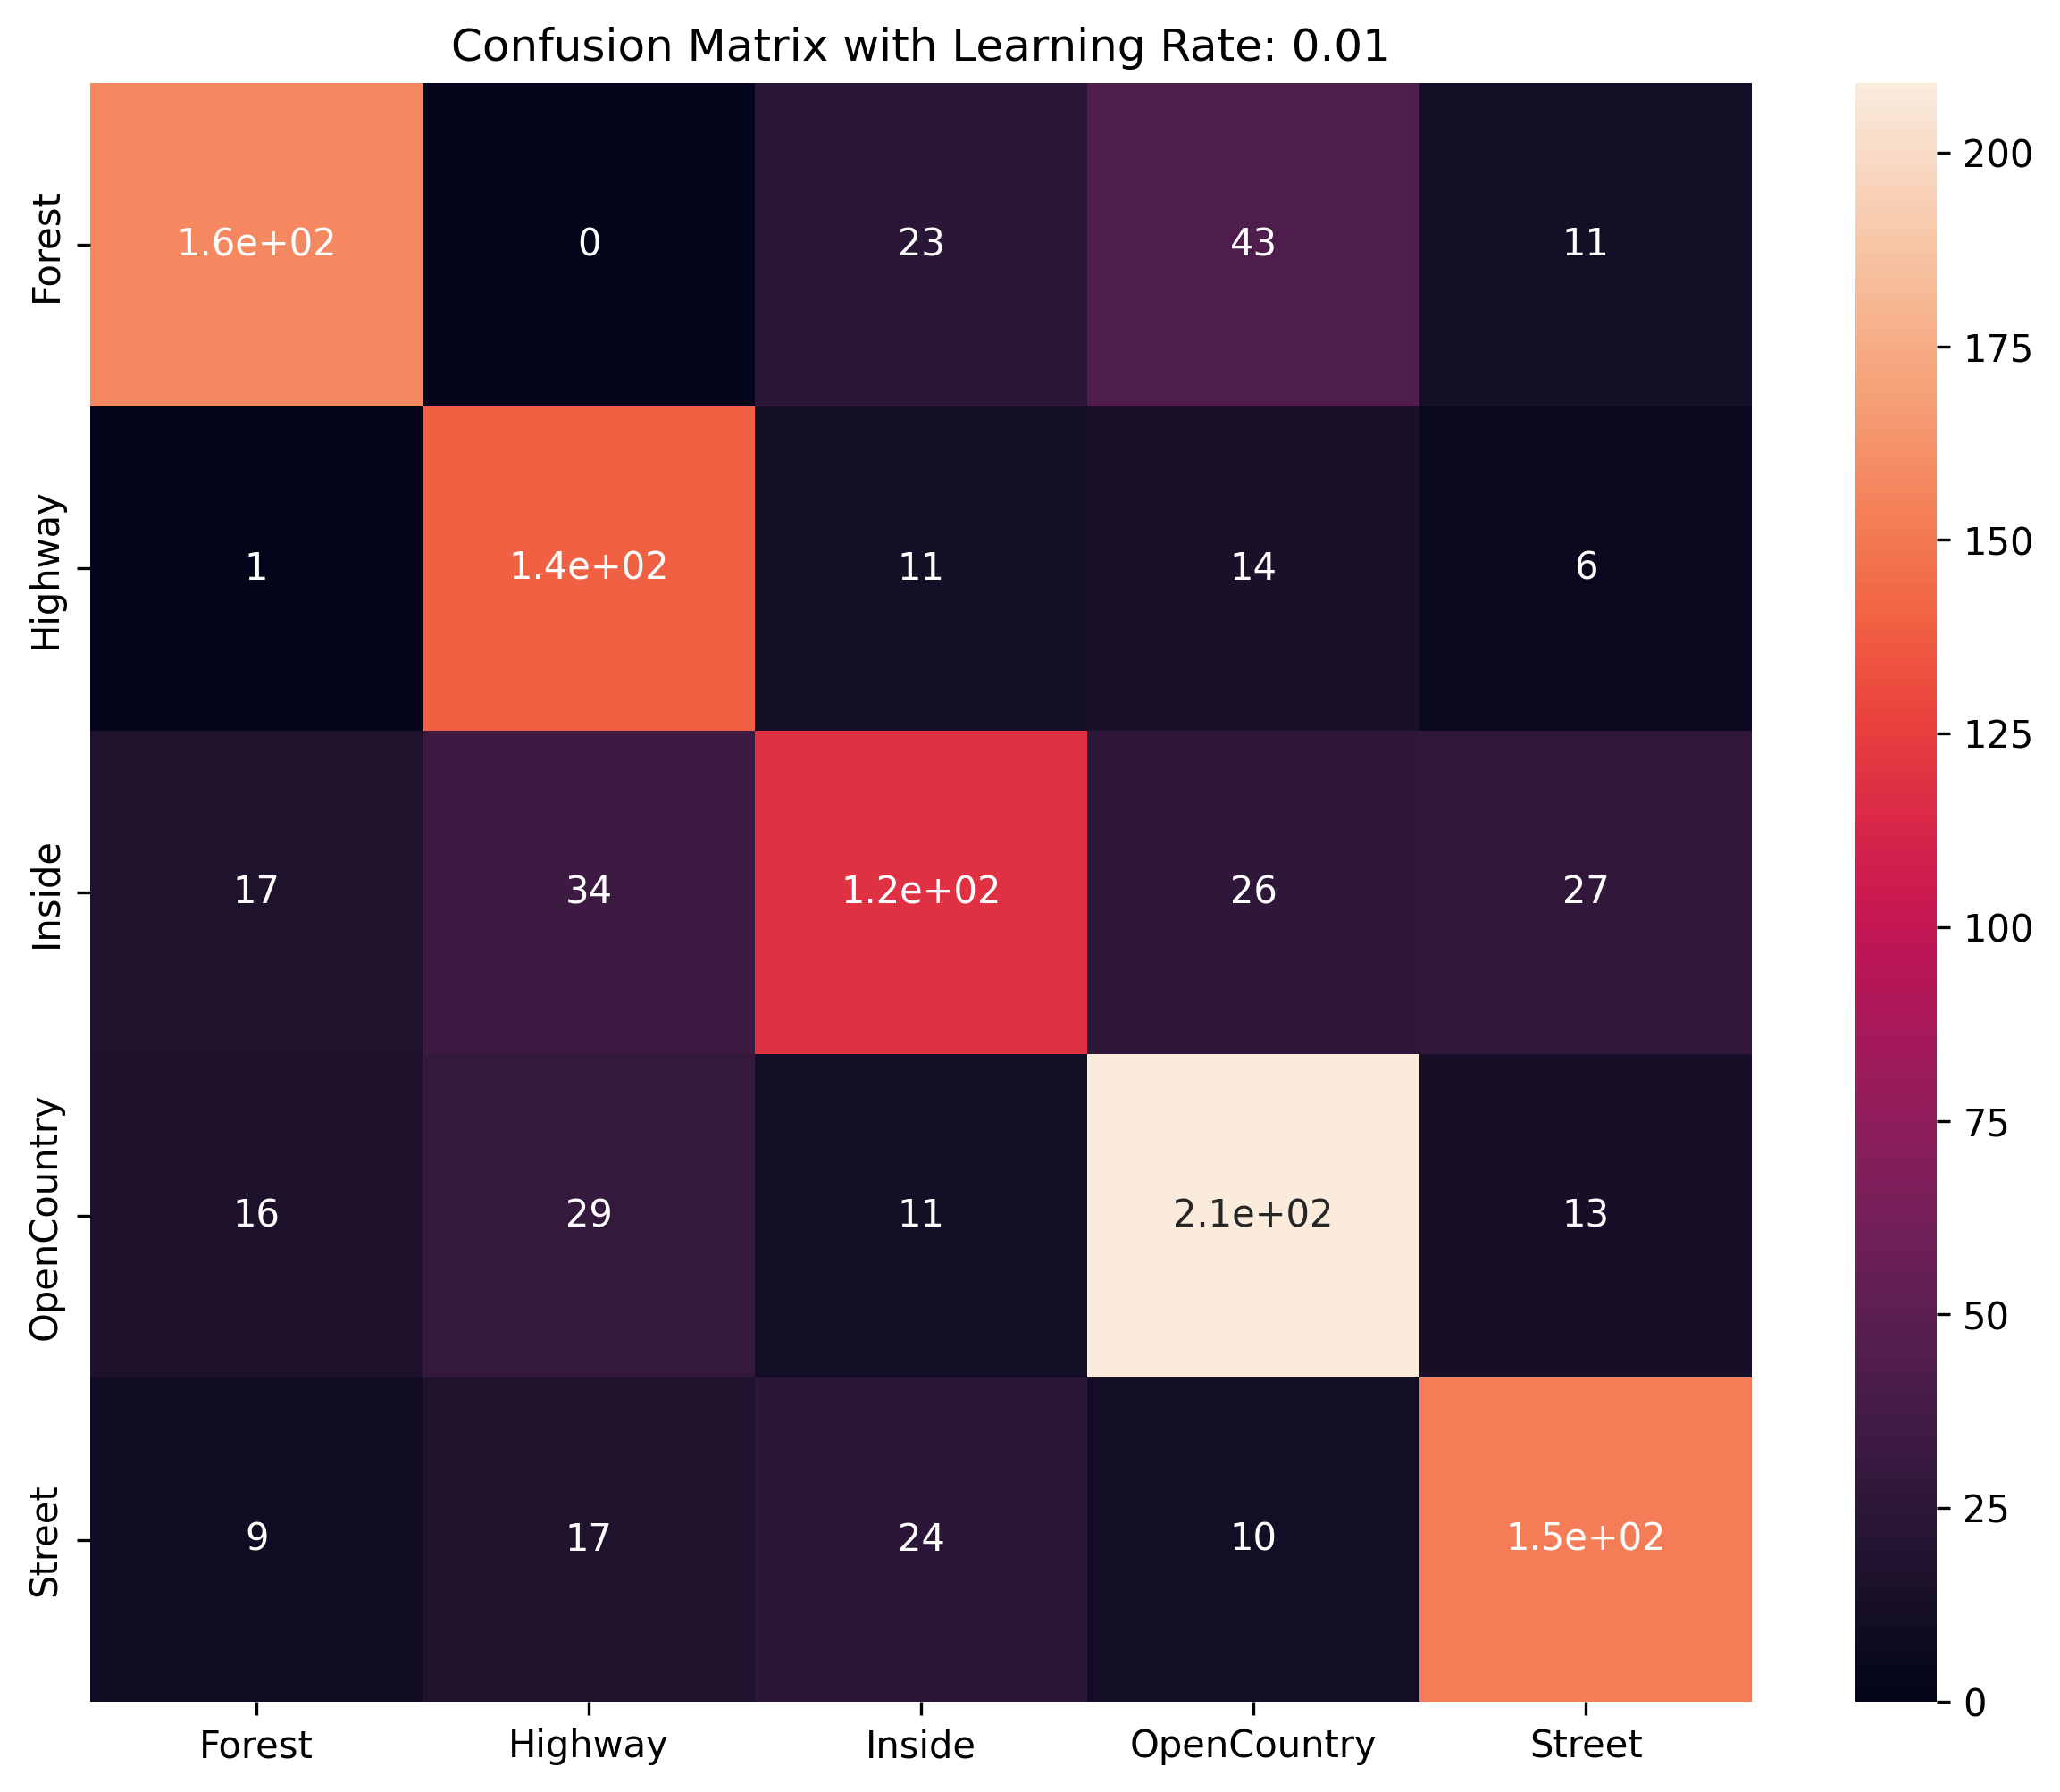

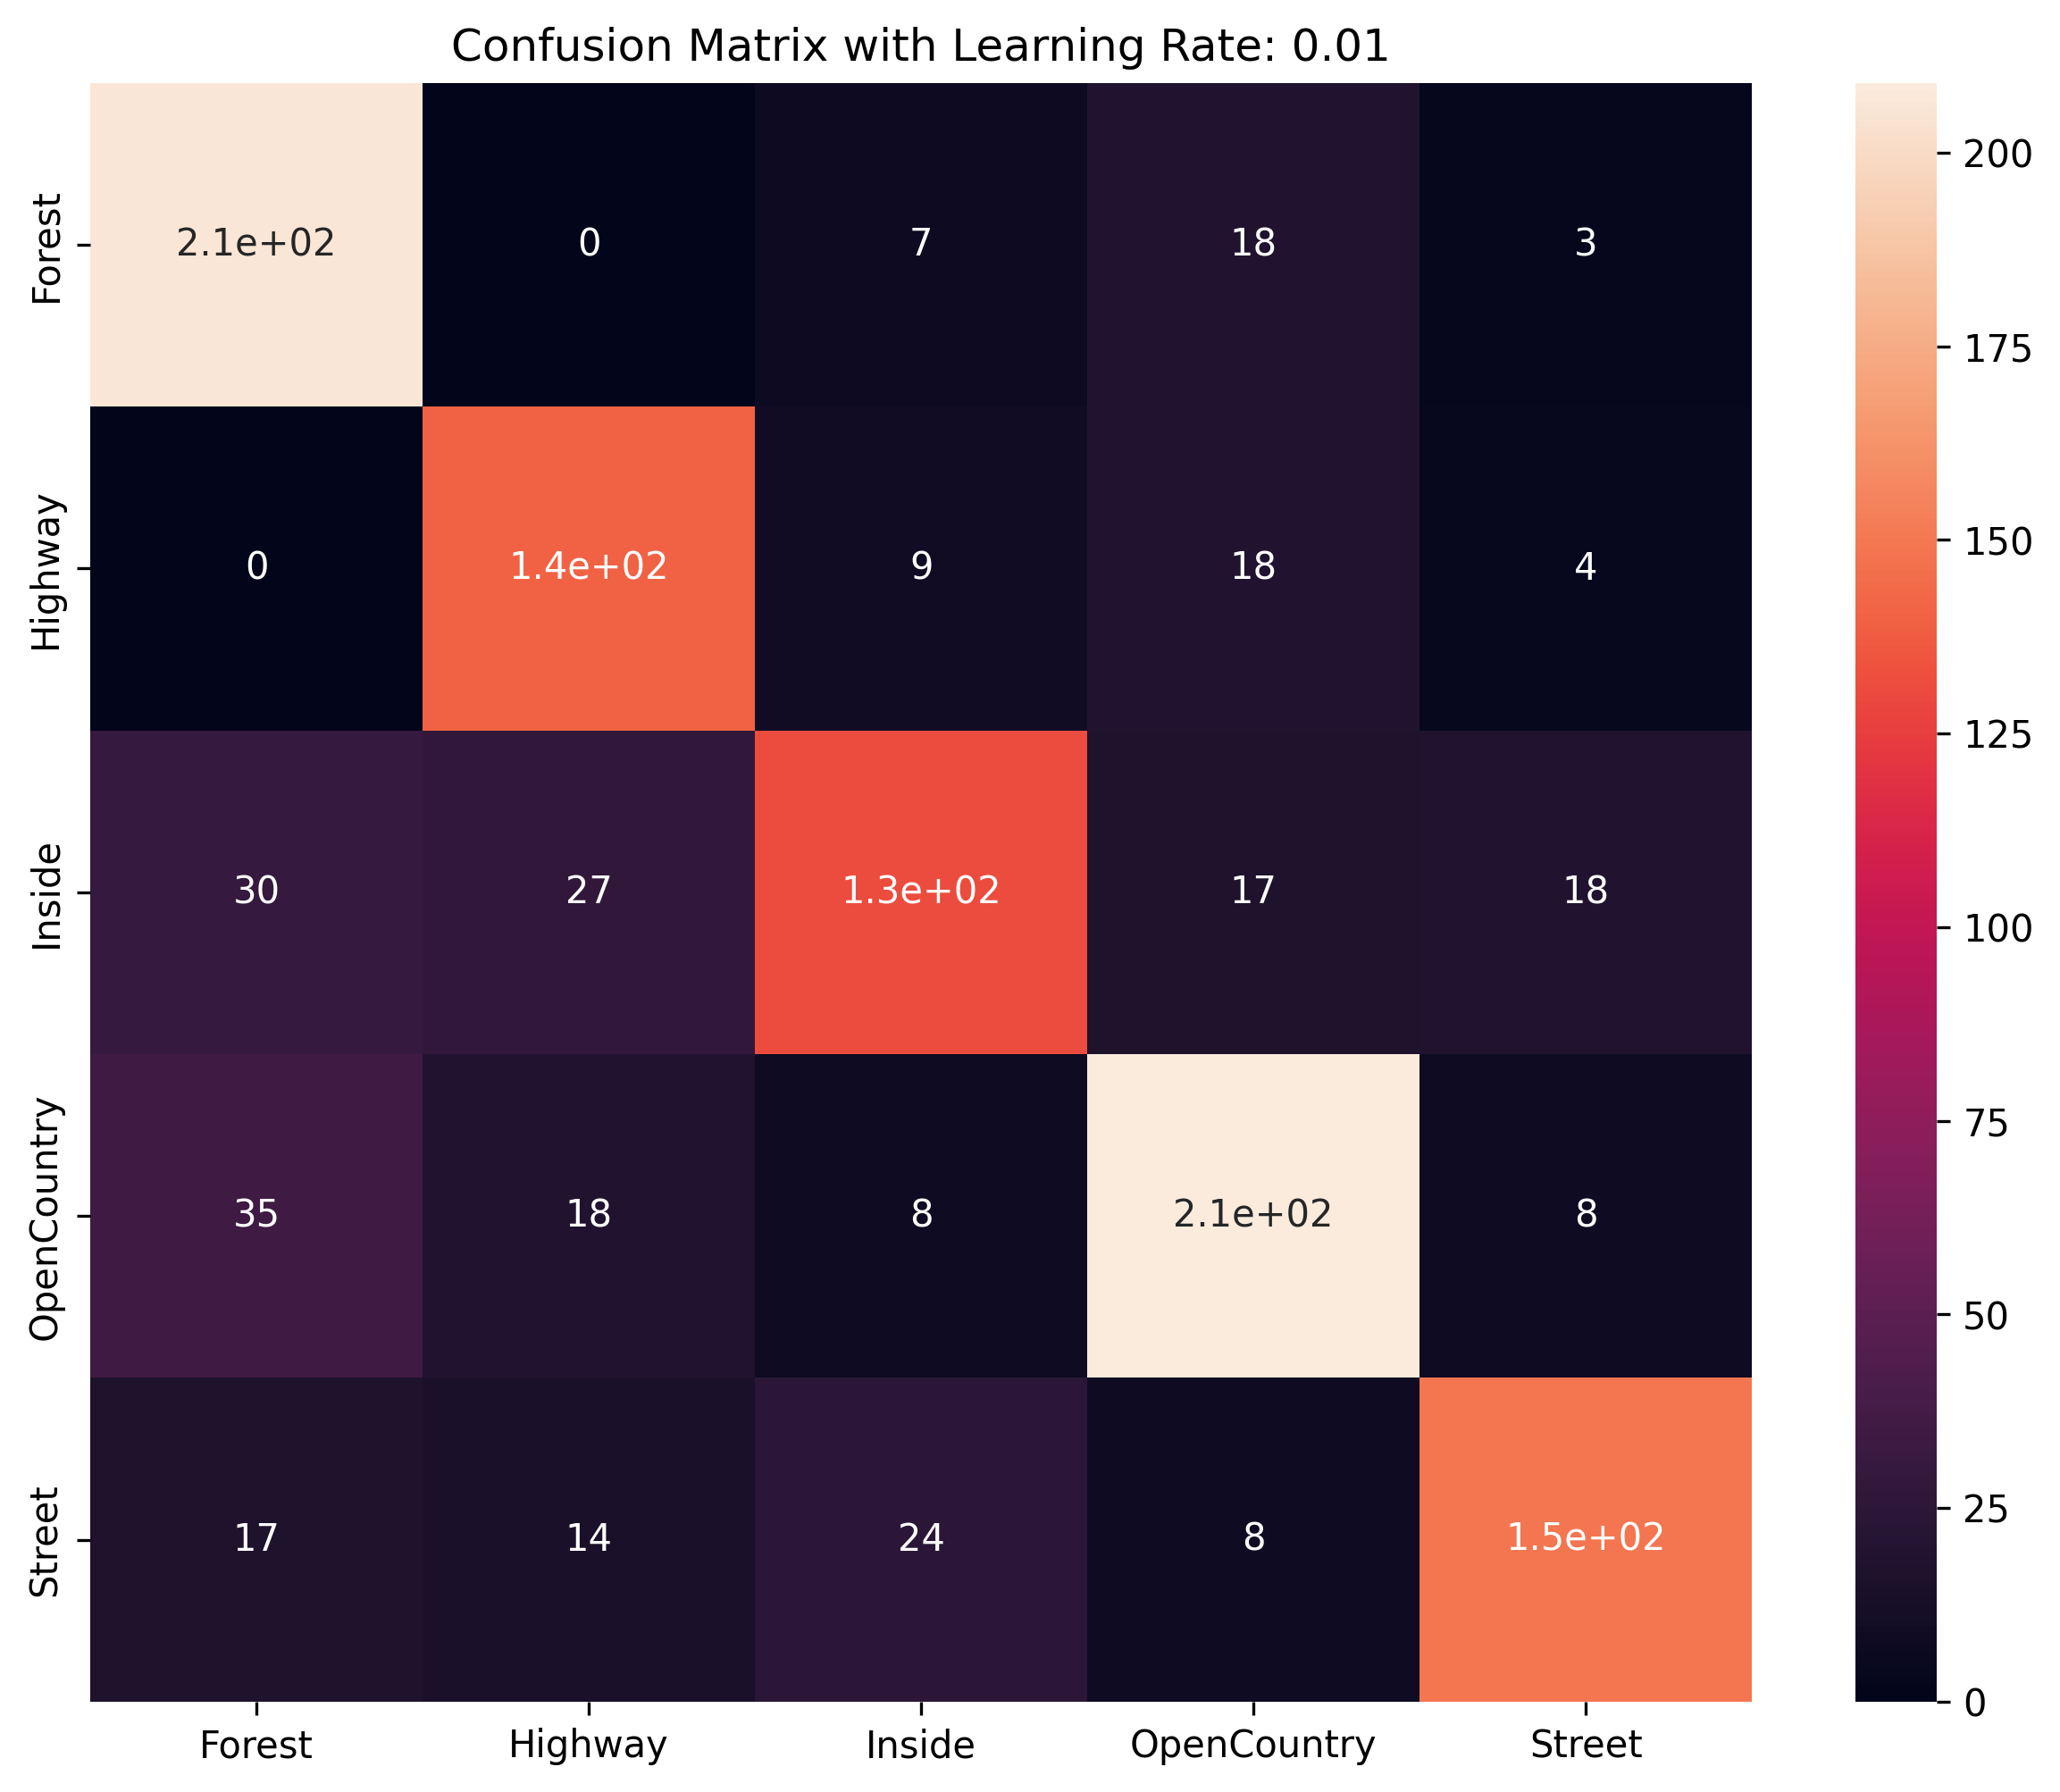

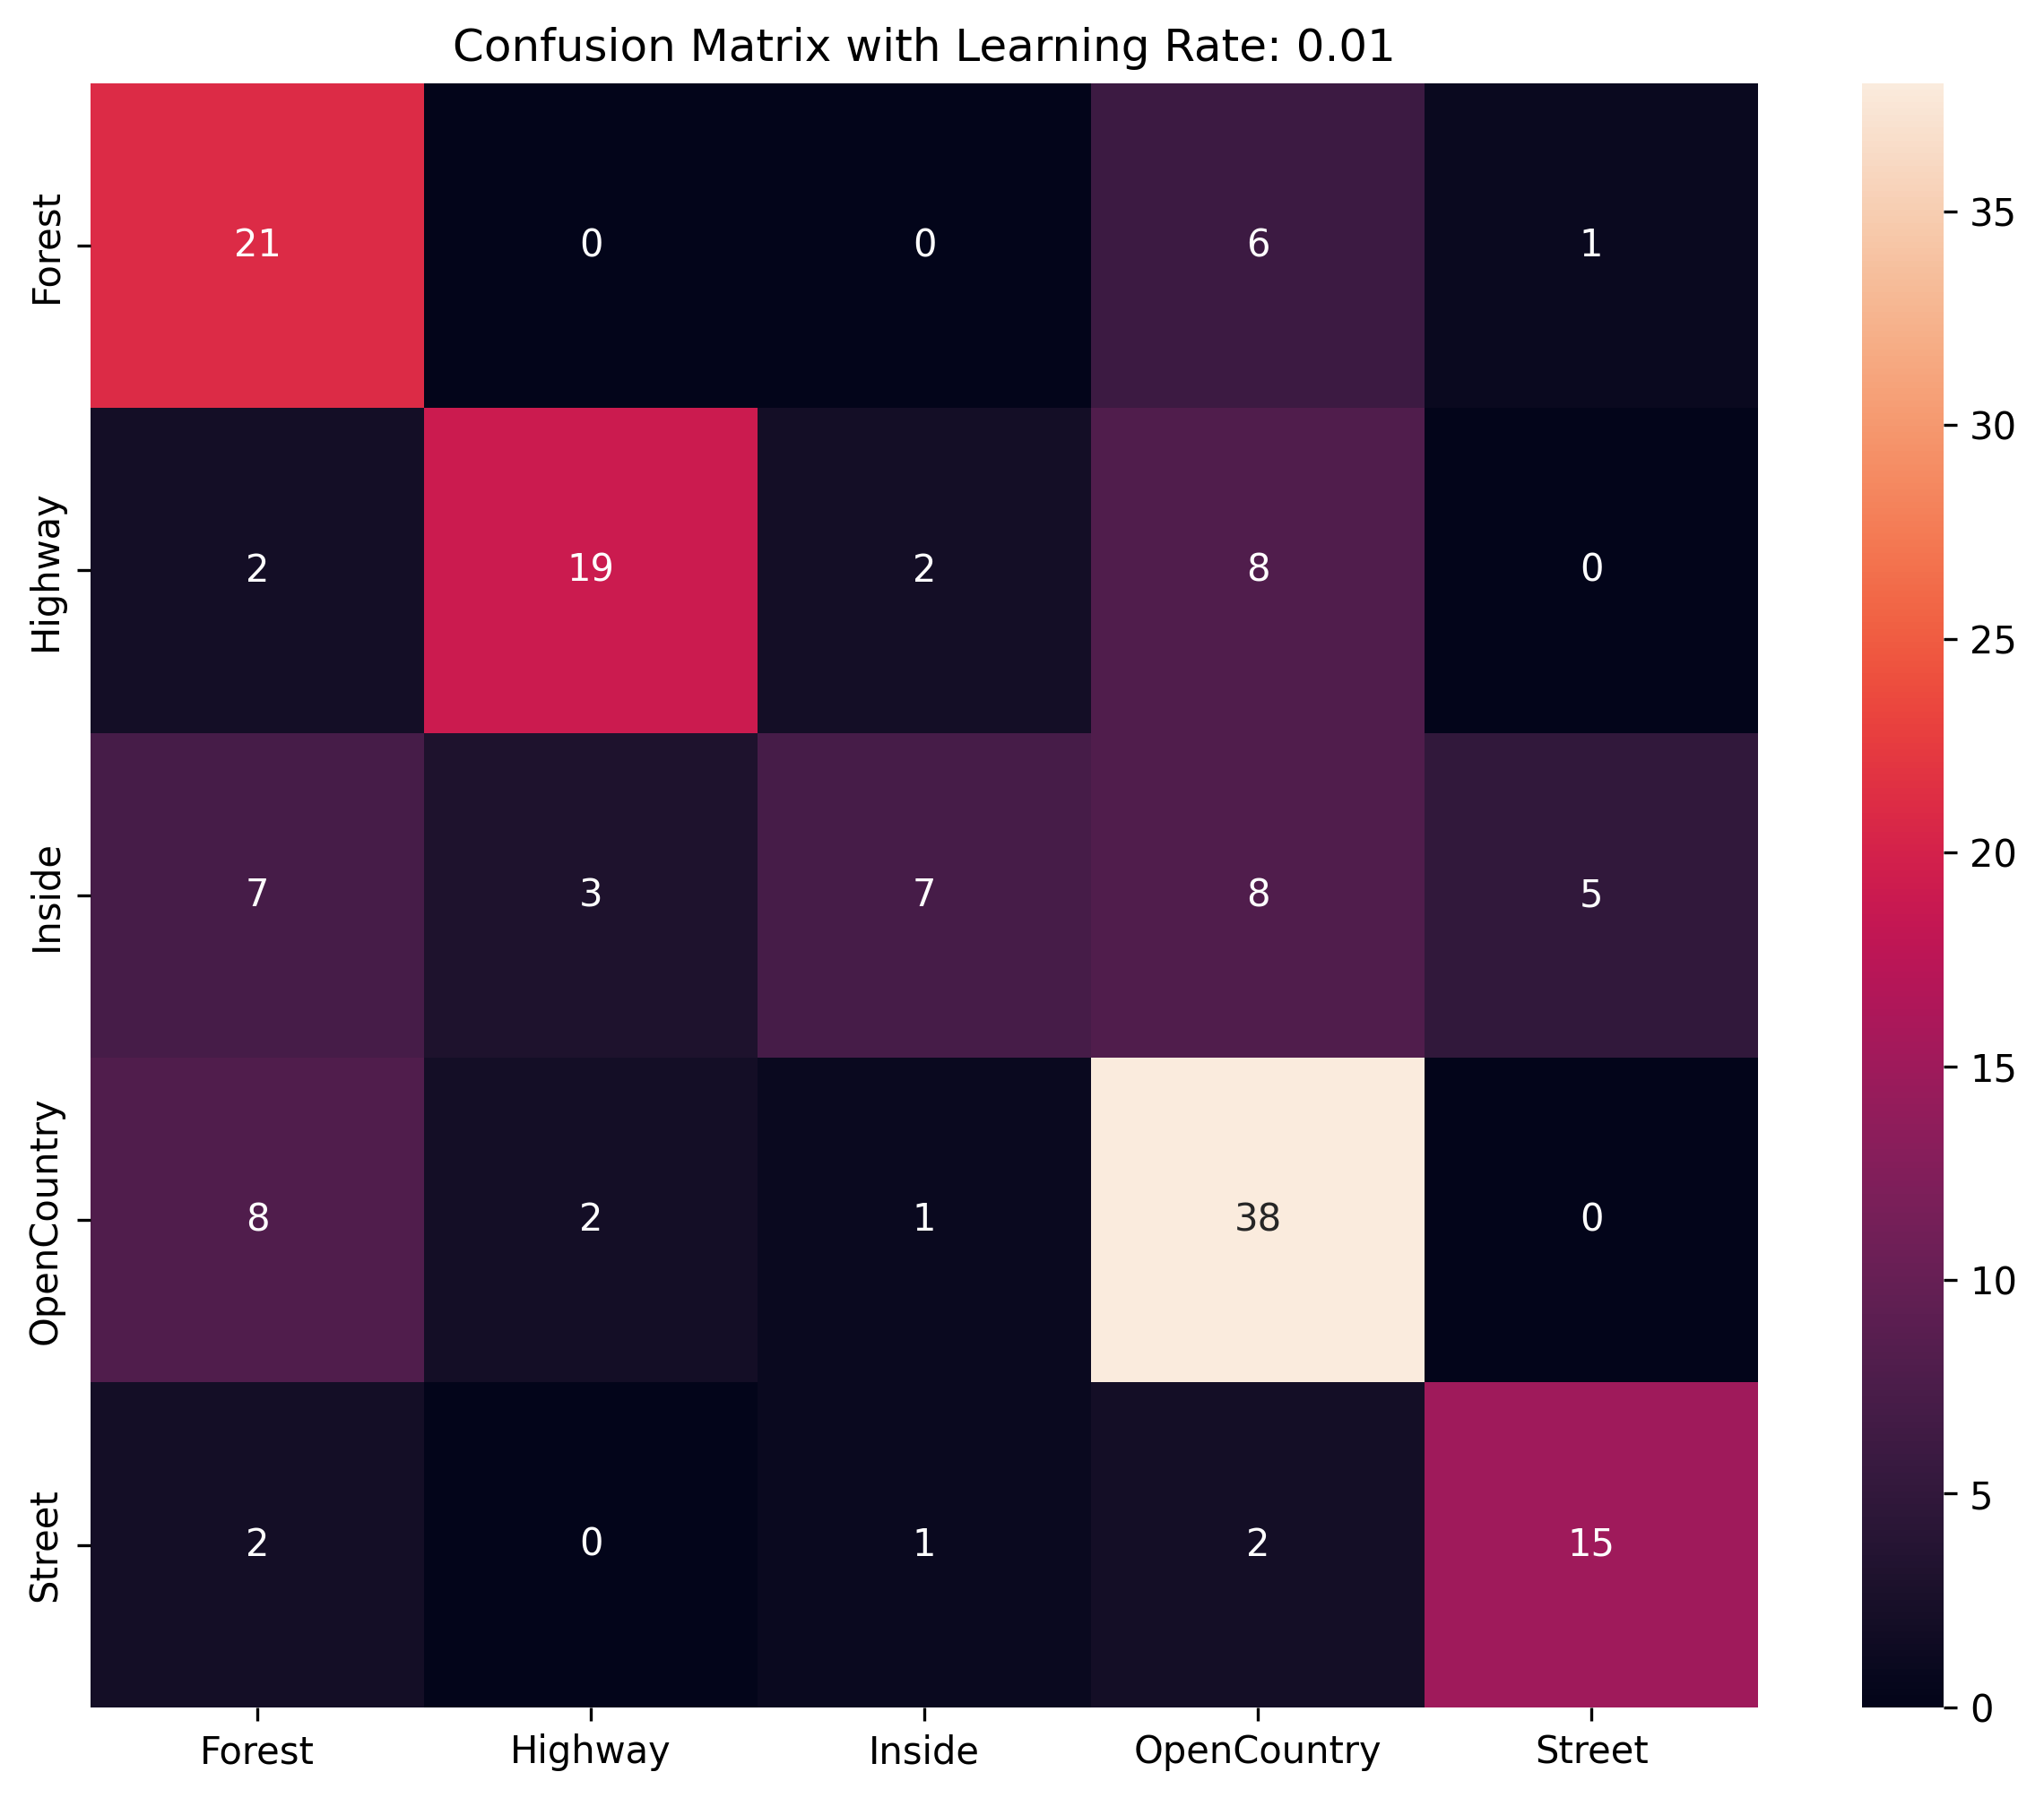

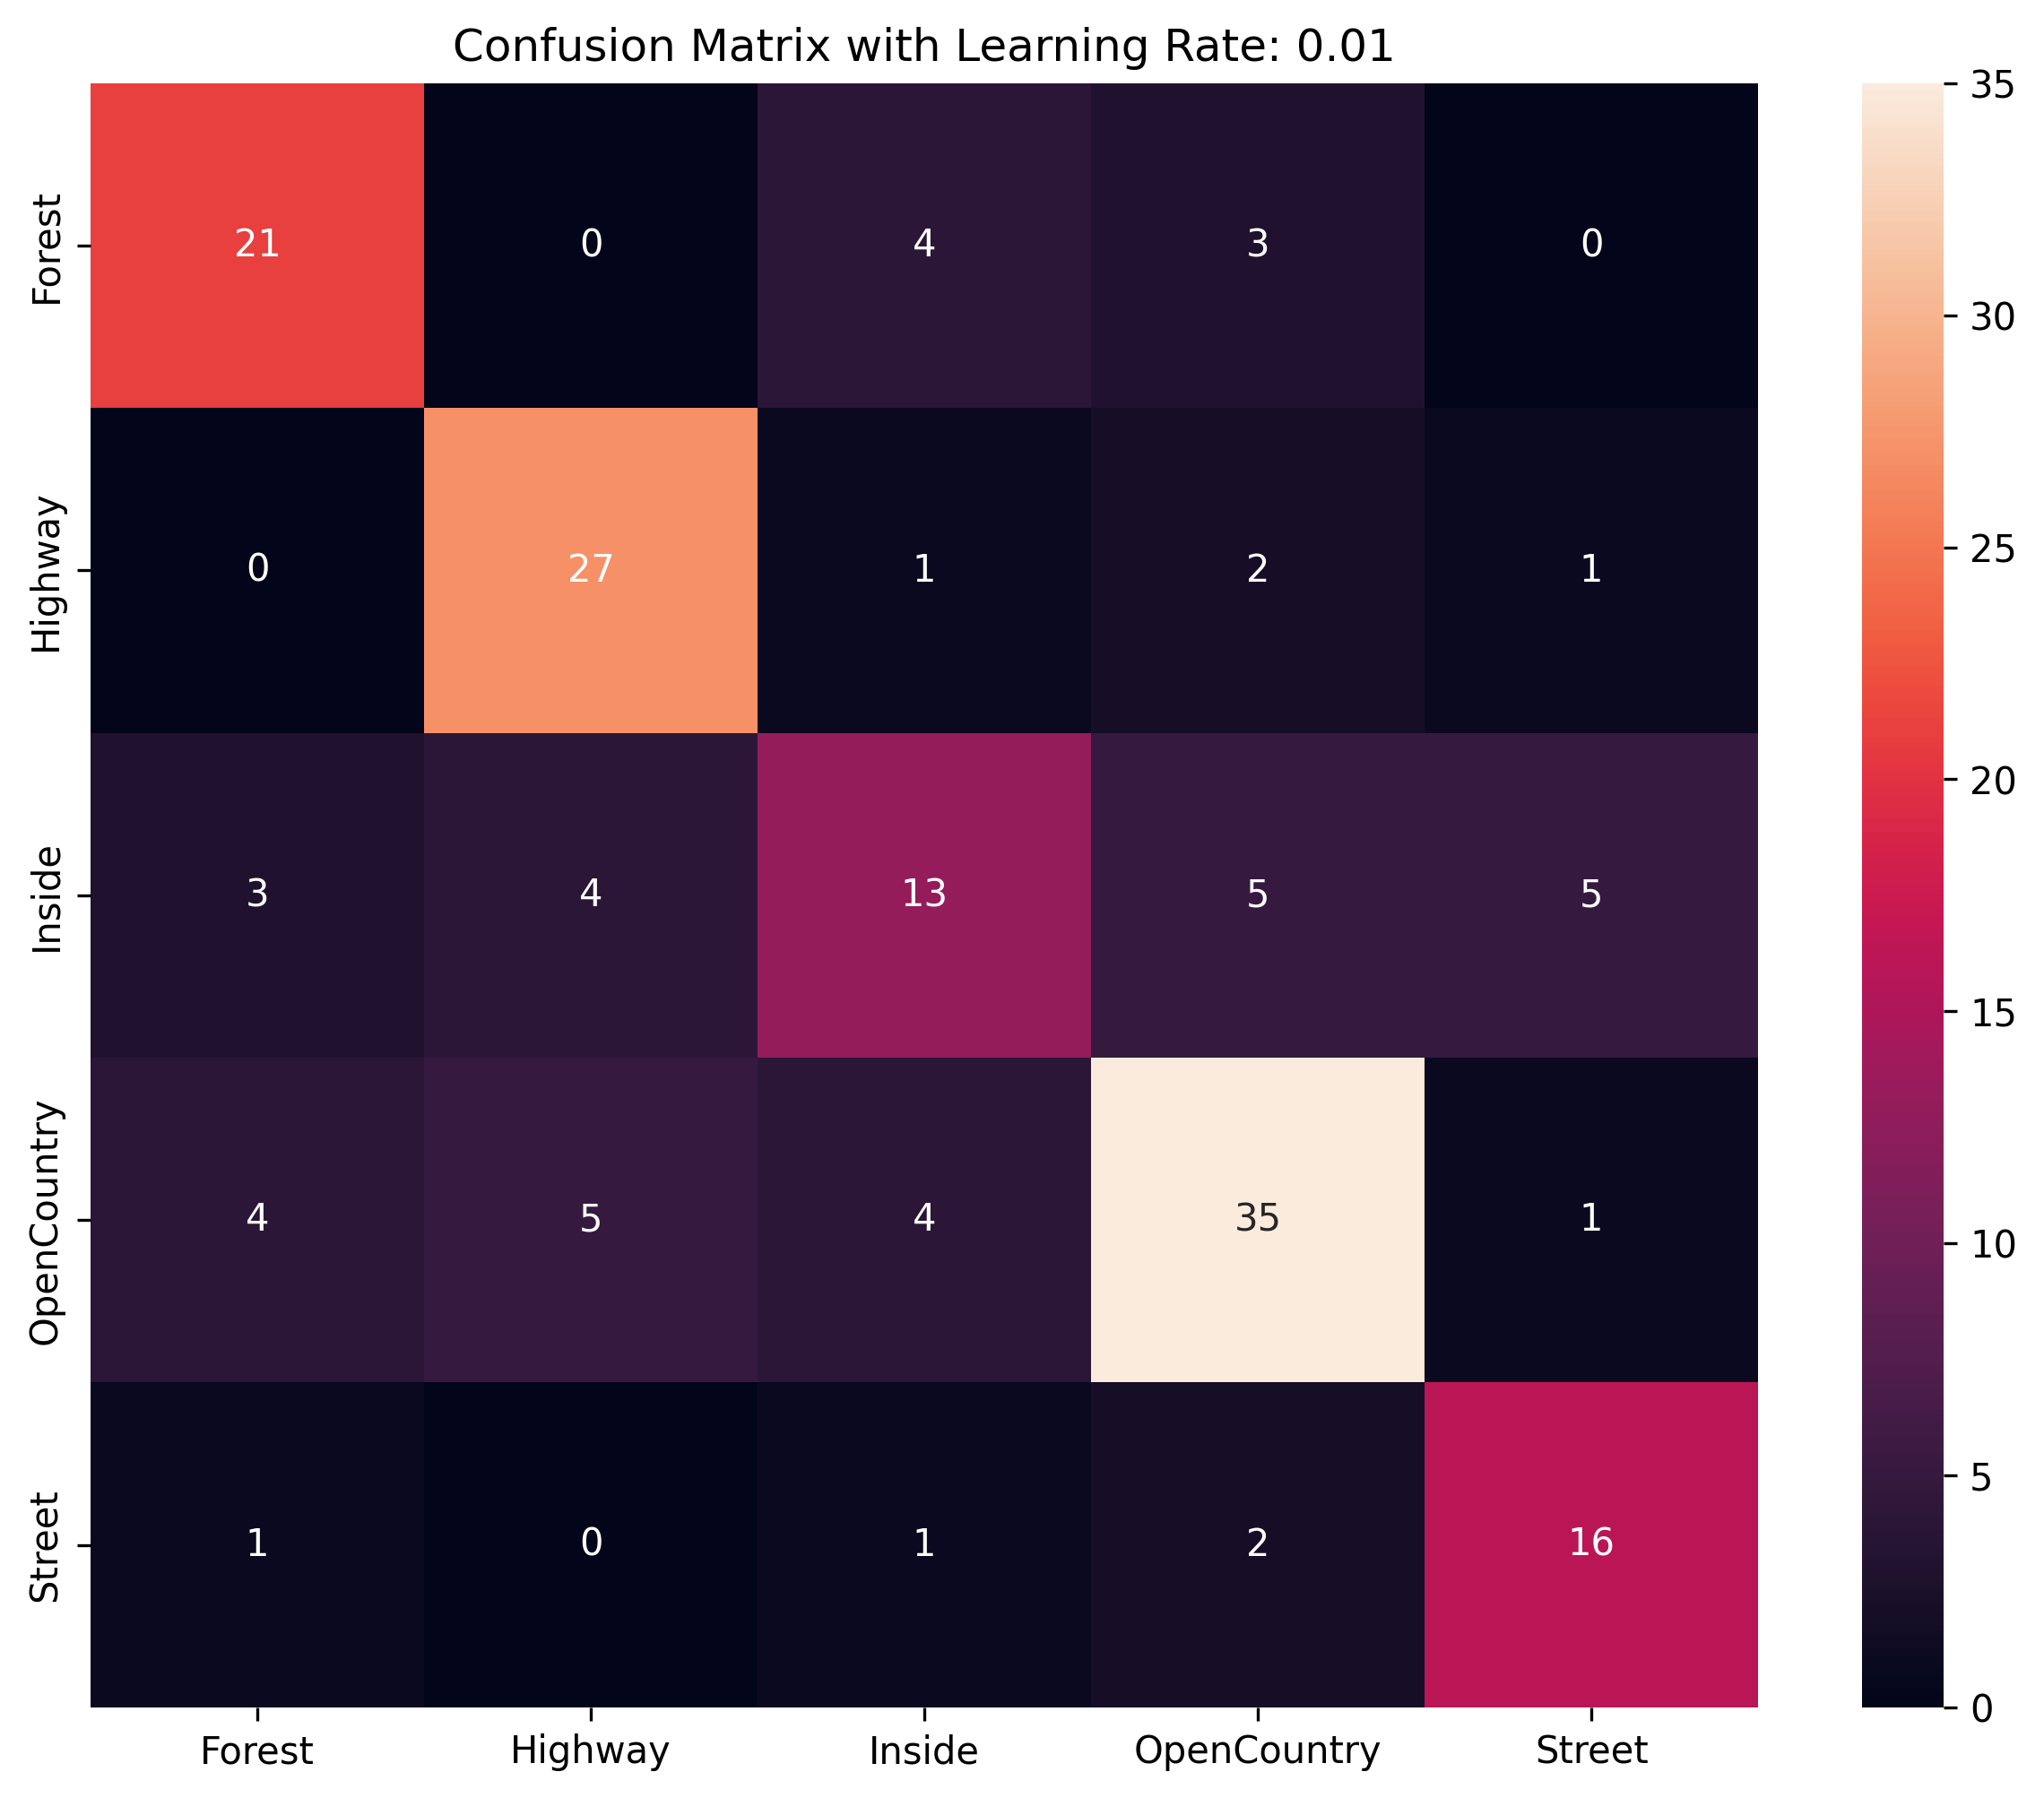

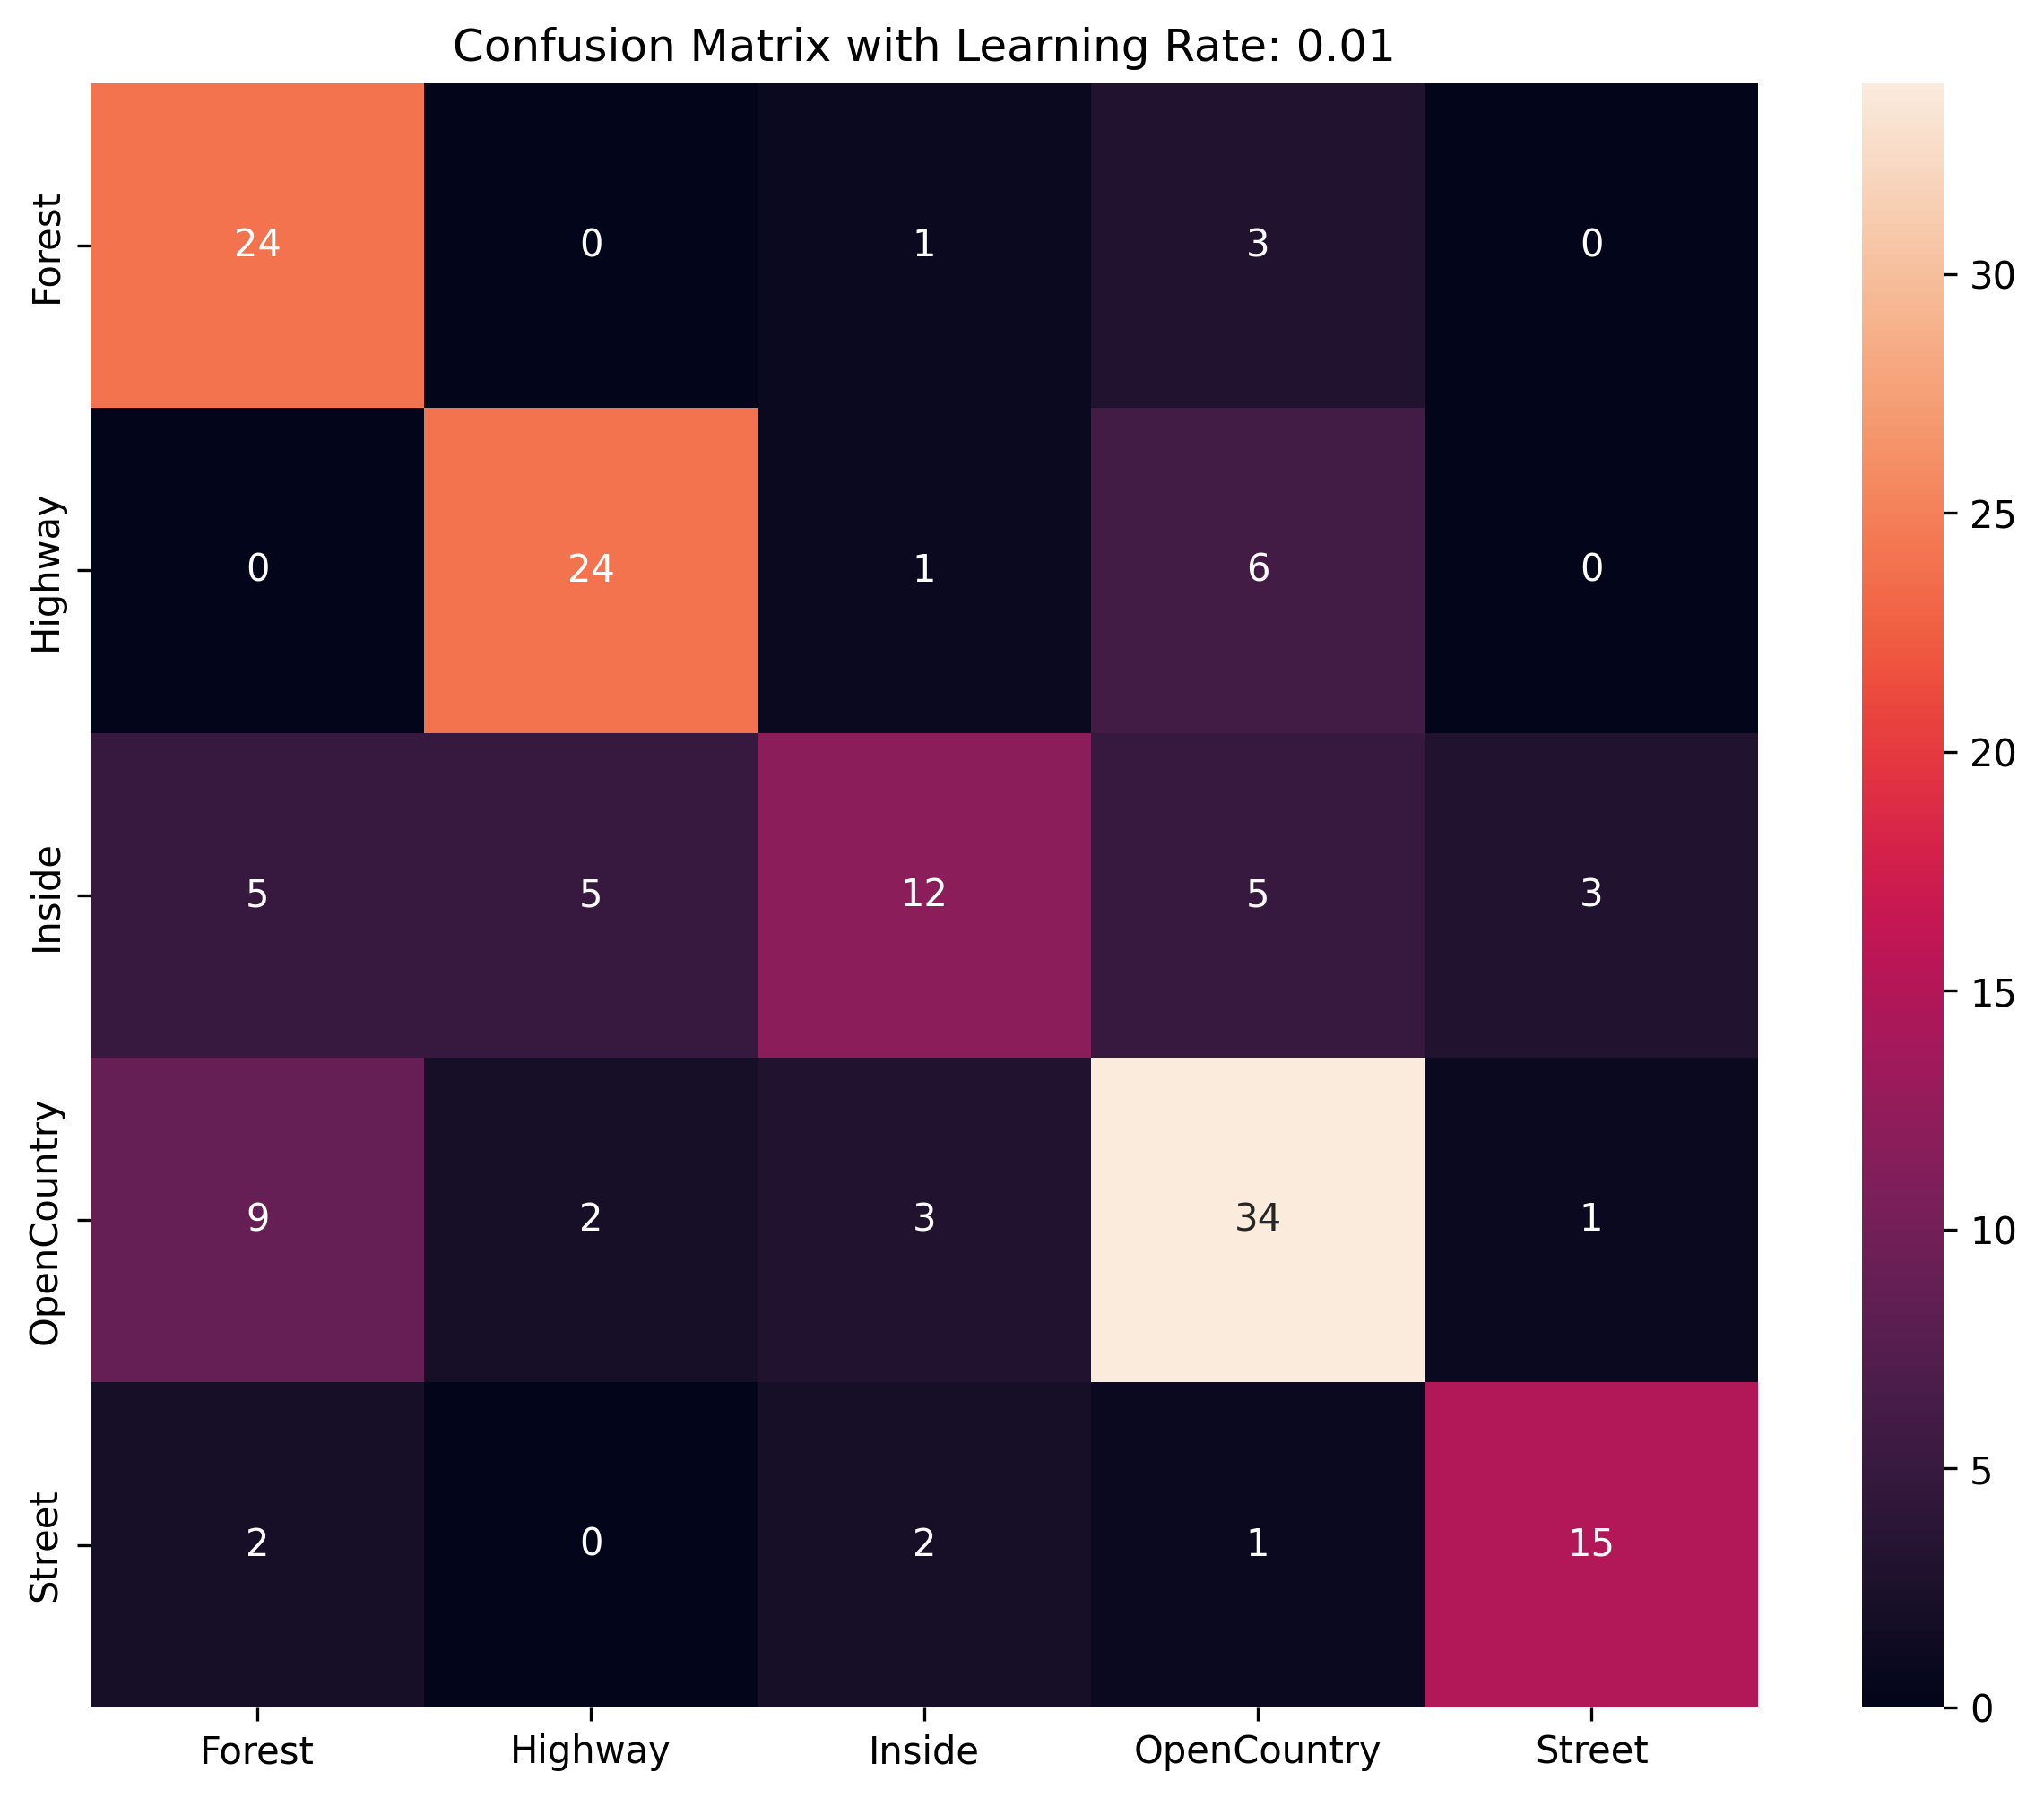

In [21]:
lrs = [1e-5,1e-4, 1e-3, 1e-2]

for lr in lrs:
    
    model_delta = MLFFNN(hidden_dim).to(device)
    model_ada_delta = MLFFNN(hidden_dim).to(device)
    model_adam = MLFFNN(hidden_dim).to(device)
    
    optimizer_delta = optim.SGD(model_delta.parameters(), lr=lr, momentum=0)
    optimizer_ada_delta = optim.SGD(model_ada_delta.parameters(),lr=lr,momentum=.8)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr)

    loss_delta,acc_delta,epoch_delta = train_model(optimizer_delta, model_delta,"model_delta")
    loss_ada_delta,acc_ada_delta,epoch_ada_delta = train_model(optimizer_ada_delta, model_ada_delta,"model_ada_delta")
    loss_adam,acc_adam,epoch_adam = train_model(optimizer_adam, model_adam,"model_adam")

    epochs = [epoch_delta,epoch_ada_delta,epoch_adam]
    
    plot_comparative(loss_delta,loss_ada_delta,loss_adam,epochs,lr,"train",loss_or_accuracy="loss")
    plot_comparative(loss_delta,loss_ada_delta,loss_adam,epochs,lr,"val",loss_or_accuracy="loss")
    
    plot_comparative(acc_delta,acc_ada_delta,acc_adam,epochs,lr,"train",loss_or_accuracy="accuracy")
    plot_comparative(acc_delta,acc_ada_delta,acc_adam,epochs,lr,"val",loss_or_accuracy="accuracy")

    plot_confusion_matrix(lr,"model_delta.pth",train_dataloader)
    plot_confusion_matrix(lr,"model_ada_delta.pth",train_dataloader)
    plot_confusion_matrix(lr,"model_adam.pth",train_dataloader)

    plot_confusion_matrix(lr,"model_delta.pth",val_dataloader)
    plot_confusion_matrix(lr,"model_ada_delta.pth",val_dataloader)
    plot_confusion_matrix(lr,"model_adam.pth",val_dataloader)

In [22]:
loss_delta

{'train': [1.6139217138290405,
  1.580166128703526,
  1.5571632249014717,
  1.5403391804013933,
  1.5218536036355155,
  1.5001592874526977,
  1.478134822845459,
  1.4528723852975027,
  1.4211745023727418,
  1.3903052943093437,
  1.3599561520985195,
  1.3246202536991665,
  1.2909280334200177,
  1.2559578895568848,
  1.228997778892517,
  1.2042392339025225,
  1.1692849602018083,
  1.1385272332600185,
  1.1325238806860787,
  1.0899438432284765,
  1.074883815220424],
 'val': [1.5918631315231324,
  1.5640356063842773,
  1.5328714847564697,
  1.5135099411010742,
  1.4873269319534301,
  1.4831730127334595,
  1.4467941999435425,
  1.4069734573364259,
  1.385431694984436,
  1.3608776092529298,
  1.3042083024978637,
  1.2816773891448974,
  1.2473325729370117,
  1.2319782972335815,
  1.1767692804336547,
  1.1696520566940307,
  1.1926491260528564,
  1.09127676486969,
  1.0482014656066894,
  1.071614718437195,
  1.1014947891235352]}

In [53]:
epochs[0]

1